In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

- INSTALL ADDITIONAL LIBRARIES IF REQUIRED
------------------------------------------
This is normally not required. The hub environment comes preinstaled with 
many packages that you can already use without setup. In case there is some
other library you would like to use that isn't on the list you run this command
once to install them.  If it is already installed this command has no effect.

In [2]:
get_ipython().system('python3 -m pip install db-dtypes pmdarima')

- IMPORT THE LIBRARIES YOU WILL USE
------------------------------------------
You only need to import packages one time per notebook session. To keep your
notebook clean and organized you can handle all imports at the top of your file.
The following are included for example purposed, feel free to modify or delete 
anything in this section.

In [3]:
import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.model_selection import train_test_split 
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from pmdarima.arima import auto_arima

CONFIGURE THE BIGQUERY SETTINGS

In [4]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [5]:
query = """
Select a.*, b.average_wage FROM 
(SELECT * FROM `ironhacks-data.ironhacks_competition.unemployment_data` ) a
JOIN `ironhacks-data.ironhacks_competition.wage_data` b 
ON a.uu_id=b.uu_id
order by uu_id, week_number
"""

In [6]:
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
empdata = query_job.to_dataframe().drop_duplicates().fillna(0)

In [7]:
empdata.head().transpose()

,0,1,3,5,7
uu_id,001cd9ae23064d7f0fd3cd327c873d8d,001cd9ae23064d7f0fd3cd327c873d8d,001cd9ae23064d7f0fd3cd327c873d8d,001cd9ae23064d7f0fd3cd327c873d8d,001cd9ae23064d7f0fd3cd327c873d8d
timeperiod,20220730,20220813,20220820,20220827,20220903
week_number,31,33,34,35,36
countyfips,18099,18099,18099,18099,18099
tract,20102,20102,20102,20102,20102
tract_name,"Census Tract 201.02, Marshall County, Indiana","Census Tract 201.02, Marshall County, Indiana","Census Tract 201.02, Marshall County, Indiana","Census Tract 201.02, Marshall County, Indiana","Census Tract 201.02, Marshall County, Indiana"
total_claims,34,10,25,10,10
edu_8th_or_less,0,0,0,0,0
edu_grades_9_11,0,0,0,0,0
edu_hs_grad_equiv,30,0,0,0,0


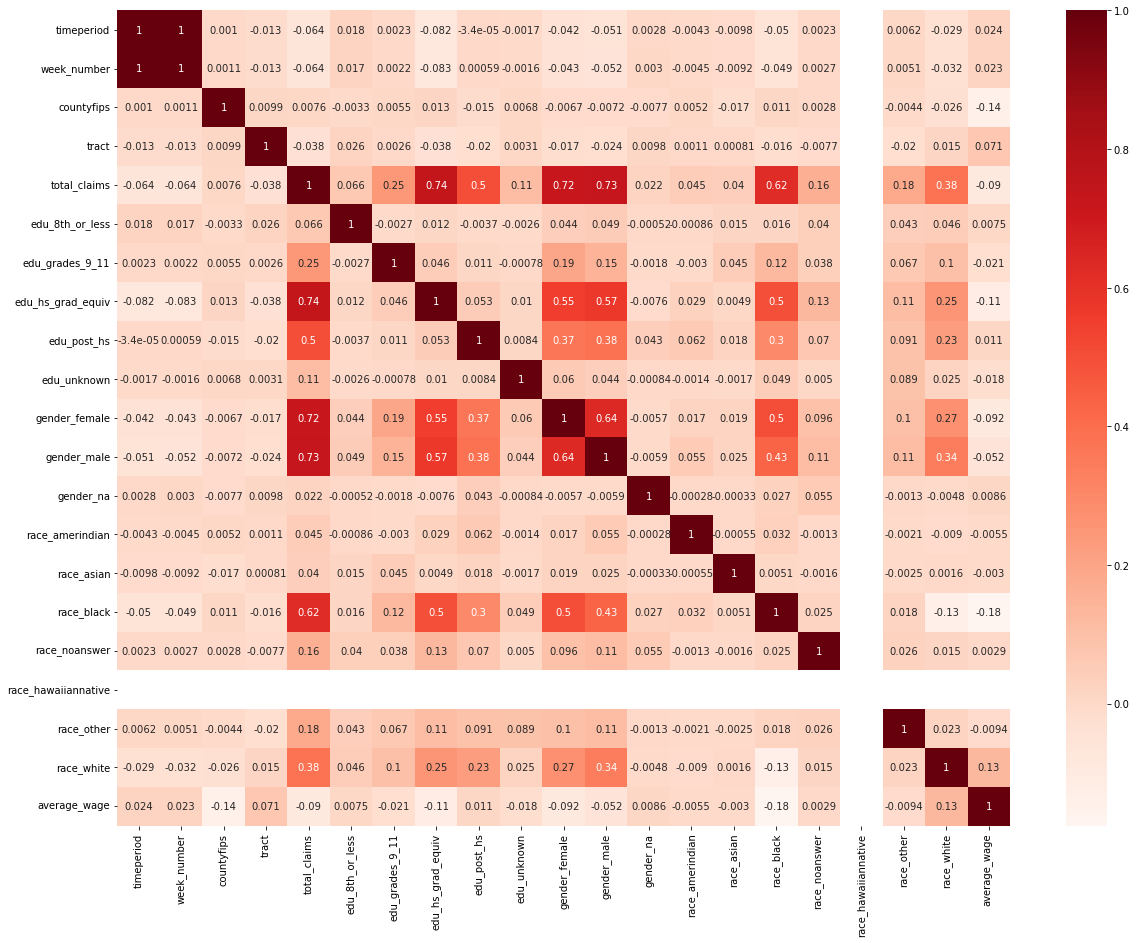

In [8]:
plt.figure(figsize=(20,15))
cor = empdata.corr(numeric_only=True)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [9]:
empdata = empdata[['uu_id', 'week_number', 'total_claims']]
empdata.head(10)

,uu_id,week_number,total_claims
0,001cd9ae23064d7f0fd3cd327c873d8d,31,34
1,001cd9ae23064d7f0fd3cd327c873d8d,33,10
3,001cd9ae23064d7f0fd3cd327c873d8d,34,25
5,001cd9ae23064d7f0fd3cd327c873d8d,35,10
7,001cd9ae23064d7f0fd3cd327c873d8d,36,10
9,001cd9ae23064d7f0fd3cd327c873d8d,37,13
11,005be9532fd717dc36d4be318fd9ad25,1,20
12,005be9532fd717dc36d4be318fd9ad25,2,19
13,005be9532fd717dc36d4be318fd9ad25,3,19
14,005be9532fd717dc36d4be318fd9ad25,5,15


<AxesSubplot:xlabel='week_number'>

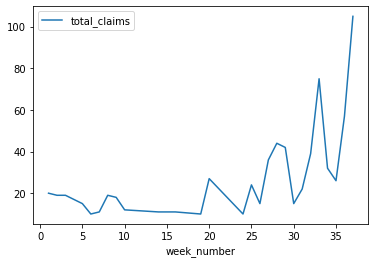

In [10]:
empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"].plot(x='week_number', y='total_claims')

In [11]:
empdata[['total_claims']].describe()

,total_claims
count,13977.0
mean,23.049796
std,14.68286
min,10.0
25%,14.0
50%,19.0
75%,27.0
max,170.0


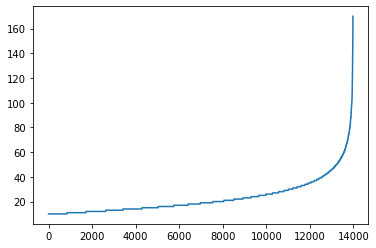

In [12]:
plt.plot(np.sort(empdata['total_claims'].values))

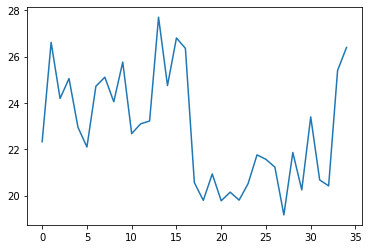

In [13]:
meancpw = []
for i in np.sort(empdata['week_number'].unique()):
    meancpw.append(empdata.loc[empdata['week_number'] == i][['total_claims']].mean())
plt.plot(meancpw)

total_claims    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

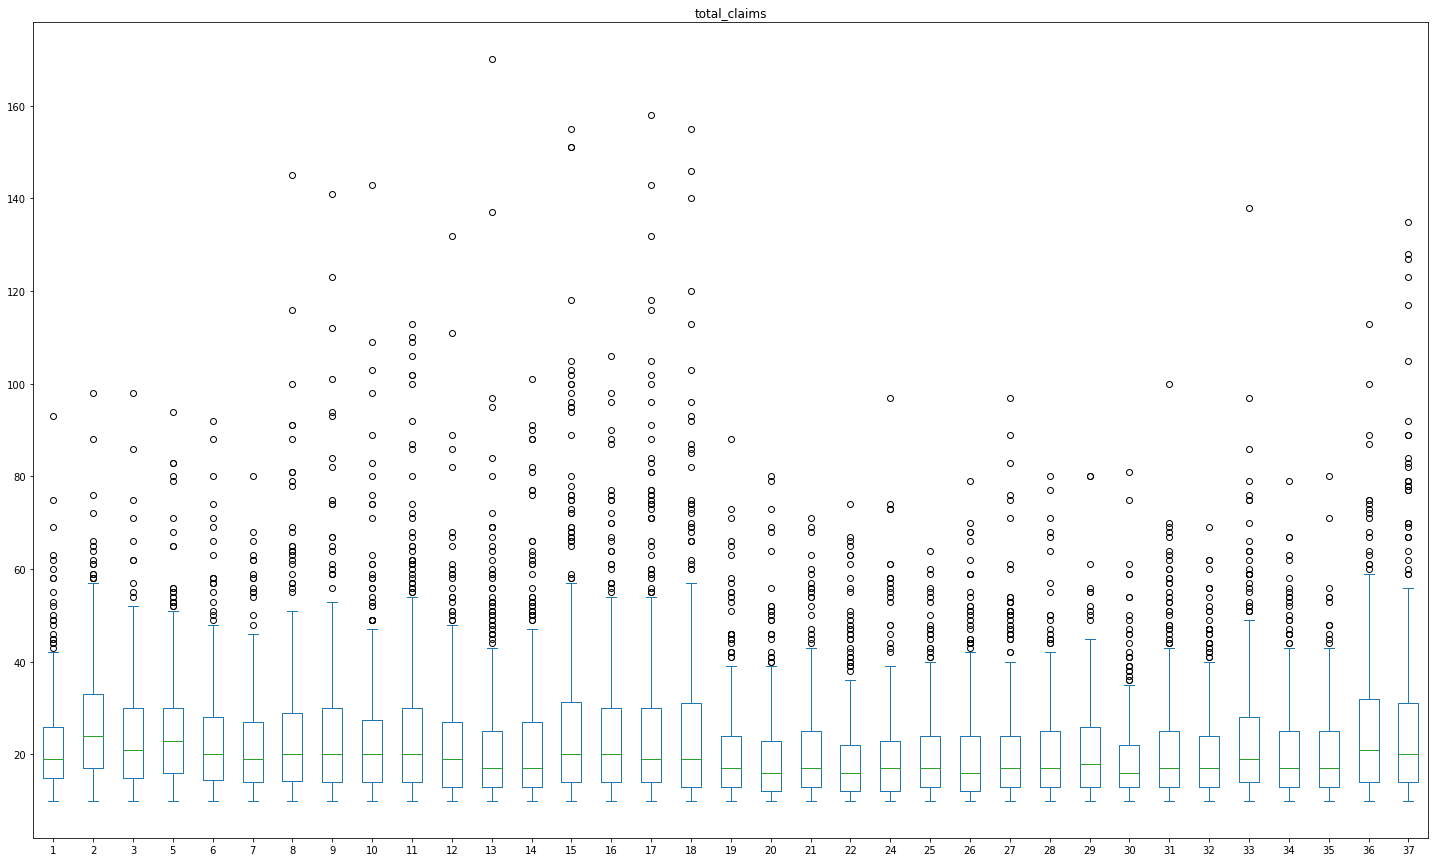

In [14]:
empdata.plot.box('week_number', figsize=(25,15))

In [15]:
empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"]

,uu_id,week_number,total_claims
11,005be9532fd717dc36d4be318fd9ad25,1,20
12,005be9532fd717dc36d4be318fd9ad25,2,19
13,005be9532fd717dc36d4be318fd9ad25,3,19
14,005be9532fd717dc36d4be318fd9ad25,5,15
15,005be9532fd717dc36d4be318fd9ad25,6,10
16,005be9532fd717dc36d4be318fd9ad25,7,11
17,005be9532fd717dc36d4be318fd9ad25,8,19
18,005be9532fd717dc36d4be318fd9ad25,9,18
19,005be9532fd717dc36d4be318fd9ad25,10,12
20,005be9532fd717dc36d4be318fd9ad25,14,11


In [16]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,37+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
allweeks

,week_number,total_claims
0,1,20
1,2,19
2,3,19
3,4,19
4,5,15
5,6,10
6,7,11
7,8,19
8,9,18
9,10,12


In [17]:
m = pm.auto_arima(allweeks['total_claims'].values, error_action='ignore')
m.predict(n_periods=4)[3]

93.6912871100285

In [18]:
query = """
SELECT * FROM `ironhacks-data.ironhacks_competition.prediction_list` order by uu_id
"""

In [19]:
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
uupred = query_job.to_dataframe()

In [20]:
uupred.head()

,uu_id,week_number
0,001cd9ae23064d7f0fd3cd327c873d8d,44
1,005be9532fd717dc36d4be318fd9ad25,44
2,007c1caccff1fbb3a0b8a10790f77141,44
3,009683350b175edfc6414d664e4ba873,44
4,00f962ce727b8dbbf20925abd5a253dd,44


In [21]:
last_week = int(empdata['week_number'].max())
last_week

37

In [22]:
pred_week = int(uupred['week_number'].max())
pred_week

44

In [23]:
uupred['total_claims'] = 0

In [24]:
uupred.head()

,uu_id,week_number,total_claims
0,001cd9ae23064d7f0fd3cd327c873d8d,44,0
1,005be9532fd717dc36d4be318fd9ad25,44,0
2,007c1caccff1fbb3a0b8a10790f77141,44,0
3,009683350b175edfc6414d664e4ba873,44,0
4,00f962ce727b8dbbf20925abd5a253dd,44,0


In [25]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        m = pm.auto_arima(allweeks['total_claims'].values[:lastw], seasonal=False, error_action='ignore')
        pred = m.predict(n_periods=predw-lastw)
        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
        for i in range(predw-lastw):
            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [26]:
dopred(33,7)

ValueError: Prediction must have `end` after `start`.

In [27]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.66666667 11.66666667 11.66666667 11.66666667]
005be9532fd717dc36d4be318fd9ad25 [75. 75. 75. 75.]
007c1caccff1fbb3a0b8a10790f77141 [16.75757576 16.75757576 16.75757576 16.75757576]
009683350b175edfc6414d664e4ba873 [17.8232811  18.03266123 17.90212962 18.15504265]
00f962ce727b8dbbf20925abd5a253dd [30.05967809 30.05967809 30.05967809 30.05967809]
02a7b845ab6b3fc2c09a50cdc486db2a [20.06438143 16.32158856 12.12912181 15.08999467]
03ba3a9a63be1a5423457246f2846292 [18.36938336 21.78997435 21.78997435 21.78997435]
050a624d618a68e43fe31189909c644f [31.49902851 25.95476772 23.67798138 22.74300442]
05298117cbe0fd69f04f89c83aaac091 [12.56226737 14.0392283  14.89058893 15.38133646]
05f47cc80d60a67d61e891e2b90c2045 [17.87878788 17.87878788 17.87878788 17.87878788]
06c78e49b4daedfeb808c42e58fb25e4 [17.33333333 17.33333333 17.33333333 17.33333333]
06e492b4f29d153af26c659d1f7da2a1 [15.57575758 15.57575758 15.57575758 15.57575758]
07306ce64b3496b7955efaaf7509d73c [10

/opt/anaconda3/lib/python3.9/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


70077360c4805acada195b59cbbe1c78 [18.33333333 18.33333333 18.33333333 18.33333333]
7322dfe92403d20403f7a527ba733641 [12.87878788 12.87878788 12.87878788 12.87878788]
733d0fa66aa7cad3330acffe30d6dc17 [18. 18. 18. 18.]
747f8bc2b0c8c0a04d29caa4cfe327d2 [11.06060606 11.06060606 11.06060606 11.06060606]
74c5fdc6aac736fa7cf9b5d45c501a03 [16.88539284 15.23748562 15.22565133 15.75961148]
75db3baff27b92ecda8651b35117d356 [22.91556823 24.45970233 25.27750178 25.71062215]
772f54511e2ccdad04e4fc903bbd19cc [26.51591694 17.11377706 17.11377706 17.11377706]
778946d9696cd6c95f57e8b1e6336389 [12.24632208 14.40600331 13.43720511 12.88352032]
7953cef088684d6a82637fe6a9e7e7a8 [31.67785296 34.02613454 33.61784473 34.18648549]
7a3c45dff186e7416bc95abd6668f65b [16.51231357 16.82679265 17.01983281 17.13832879]
7aad2bd27761397960e7f2e139ad0b9e [15.84848485 15.84848485 15.84848485 15.84848485]
7ab86f26bdf5e743b0f0adf08df559e3 [18.03030303 18.03030303 18.03030303 18.03030303]
7b1f33221592c5bc981035ecfcd359f9 [68

In [28]:
uupred

,uu_id,week_number,total_claims,w34,w35,w36,w37
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0
2,007c1caccff1fbb3a0b8a10790f77141,44,16,16.0,16.0,16.0,16.0
3,009683350b175edfc6414d664e4ba873,44,18,17.0,18.0,17.0,18.0
4,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0
...,...,...,...,...,...,...,...
520,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0
521,fcfc60d8240e5a51f878fd92e2a352a3,44,18,18.0,18.0,18.0,18.0
522,fd613eba867c6ad7350a937f743b88f2,44,20,20.0,20.0,20.0,20.0
523,fe355ff27aa8b2242a558d5e3ec99c18,44,14,16.0,14.0,14.0,14.0


In [29]:
empdata.loc[(empdata['uu_id'] == 'fd613eba867c6ad7350a937f743b88f2') & (empdata['week_number'] == 37)]

,uu_id,week_number,total_claims
16759,fd613eba867c6ad7350a937f743b88f2,37,14


In [30]:
head(pd.merge(uupred, empdata, on='uu_id'))

NameError: name 'head' is not defined

In [31]:
pd.merge(uupred, empdata, on='uu_id').head()

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,31,34
1,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,33,10
2,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,34,25
3,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,35,10
4,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,36,10


In [32]:
pd.merge(uupred, empdata, on='uu_id')

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,31,34
1,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,33,10
2,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,34,25
3,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,35,10
4,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,36,10
...,...,...,...,...,...,...,...,...,...
13972,fec479d0202d6e1e3f051a9ee902ff5d,44,32,44.0,37.0,34.0,32.0,33,59
13973,fec479d0202d6e1e3f051a9ee902ff5d,44,32,44.0,37.0,34.0,32.0,34,34
13974,fec479d0202d6e1e3f051a9ee902ff5d,44,32,44.0,37.0,34.0,32.0,35,27
13975,fec479d0202d6e1e3f051a9ee902ff5d,44,32,44.0,37.0,34.0,32.0,36,28


In [33]:
pd.join(uupred, empdata, on='uu_id')

AttributeError: module 'pandas' has no attribute 'join'

In [34]:
uupred.join(empdata, on='uu_id')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [35]:
uupred.join(empdata.loc[empdata['week_number'] == 37][['total_claims']], on='uu_id')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [36]:
uupred

,uu_id,week_number,total_claims,w34,w35,w36,w37
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0
2,007c1caccff1fbb3a0b8a10790f77141,44,16,16.0,16.0,16.0,16.0
3,009683350b175edfc6414d664e4ba873,44,18,17.0,18.0,17.0,18.0
4,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0
...,...,...,...,...,...,...,...
520,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0
521,fcfc60d8240e5a51f878fd92e2a352a3,44,18,18.0,18.0,18.0,18.0
522,fd613eba867c6ad7350a937f743b88f2,44,20,20.0,20.0,20.0,20.0
523,fe355ff27aa8b2242a558d5e3ec99c18,44,14,16.0,14.0,14.0,14.0


In [37]:
uupred.loc[uupred['uu_id'] == uu, ['total_claims']]

NameError: name 'uu' is not defined

In [38]:
uupred.loc[uupred['uu_id'] == '001cd9ae23064d7f0fd3cd327c873d8d', ['total_claims']]

,total_claims
0,11


In [39]:
uupred.loc[uupred['uu_id'] == '001cd9ae23064d7f0fd3cd327c873d8d']

,uu_id,week_number,total_claims,w34,w35,w36,w37
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0


In [40]:
uupred.loc[uupred['uu_id'] == '001cd9ae23064d7f0fd3cd327c873d8d']['total_claims']

0    11
Name: total_claims, dtype: int64

In [41]:
uupred.loc[uupred['uu_id'] == '001cd9ae23064d7f0fd3cd327c873d8d'][['total_claims']]

,total_claims
0,11


In [42]:
uupred.loc[uupred['uu_id'] == '001cd9ae23064d7f0fd3cd327c873d8d'][['total_claims']].flatten

AttributeError: 'DataFrame' object has no attribute 'flatten'

In [43]:
uupred.loc[uupred['uu_id'] == '001cd9ae23064d7f0fd3cd327c873d8d'][['total_claims']].flatten()

AttributeError: 'DataFrame' object has no attribute 'flatten'

In [44]:
uupred.loc[uupred['uu_id'] == '001cd9ae23064d7f0fd3cd327c873d8d'][['total_claims']]values

SyntaxError: invalid syntax (3069035783.py, line 1)

In [45]:
uupred.loc[uupred['uu_id'] == '001cd9ae23064d7f0fd3cd327c873d8d'][['total_claims']].values

array([[11]])

In [46]:
pd.merge(uupred, empdata, on='uu_id')

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,31,34
1,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,33,10
2,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,34,25
3,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,35,10
4,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,36,10
...,...,...,...,...,...,...,...,...,...
13972,fec479d0202d6e1e3f051a9ee902ff5d,44,32,44.0,37.0,34.0,32.0,33,59
13973,fec479d0202d6e1e3f051a9ee902ff5d,44,32,44.0,37.0,34.0,32.0,34,34
13974,fec479d0202d6e1e3f051a9ee902ff5d,44,32,44.0,37.0,34.0,32.0,35,27
13975,fec479d0202d6e1e3f051a9ee902ff5d,44,32,44.0,37.0,34.0,32.0,36,28


In [47]:
pd.merge(uupred, empdata, how='inner', on='uu_id')

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,31,34
1,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,33,10
2,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,34,25
3,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,35,10
4,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,36,10
...,...,...,...,...,...,...,...,...,...
13972,fec479d0202d6e1e3f051a9ee902ff5d,44,32,44.0,37.0,34.0,32.0,33,59
13973,fec479d0202d6e1e3f051a9ee902ff5d,44,32,44.0,37.0,34.0,32.0,34,34
13974,fec479d0202d6e1e3f051a9ee902ff5d,44,32,44.0,37.0,34.0,32.0,35,27
13975,fec479d0202d6e1e3f051a9ee902ff5d,44,32,44.0,37.0,34.0,32.0,36,28


In [48]:
pd.merge(uupred, empdata.loc[empdata['week_number'] == 37], how='inner', on='uu_id')

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,37,13
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0,37,105
2,009683350b175edfc6414d664e4ba873,44,18,17.0,18.0,17.0,18.0,37,11
3,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0,37,30
4,02a7b845ab6b3fc2c09a50cdc486db2a,44,15,20.0,16.0,12.0,15.0,37,14
...,...,...,...,...,...,...,...,...,...
418,fca0703f480d461a24d0b68fd994815e,44,15,15.0,15.0,15.0,15.0,37,44
419,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0,37,13
420,fcfc60d8240e5a51f878fd92e2a352a3,44,18,18.0,18.0,18.0,18.0,37,43
421,fd613eba867c6ad7350a937f743b88f2,44,20,20.0,20.0,20.0,20.0,37,14


In [49]:
pd.merge(uupred, empdata.loc[empdata['week_number'] == 37], on='uu_id')

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,37,13
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0,37,105
2,009683350b175edfc6414d664e4ba873,44,18,17.0,18.0,17.0,18.0,37,11
3,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0,37,30
4,02a7b845ab6b3fc2c09a50cdc486db2a,44,15,20.0,16.0,12.0,15.0,37,14
...,...,...,...,...,...,...,...,...,...
418,fca0703f480d461a24d0b68fd994815e,44,15,15.0,15.0,15.0,15.0,37,44
419,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0,37,13
420,fcfc60d8240e5a51f878fd92e2a352a3,44,18,18.0,18.0,18.0,18.0,37,43
421,fd613eba867c6ad7350a937f743b88f2,44,20,20.0,20.0,20.0,20.0,37,14


In [50]:
pd.merge(uupred, empdata.loc[empdata['week_number'] == 37], how='right', on='uu_id')

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,37,13
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0,37,105
2,009683350b175edfc6414d664e4ba873,44,18,17.0,18.0,17.0,18.0,37,11
3,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0,37,30
4,02a7b845ab6b3fc2c09a50cdc486db2a,44,15,20.0,16.0,12.0,15.0,37,14
...,...,...,...,...,...,...,...,...,...
418,fca0703f480d461a24d0b68fd994815e,44,15,15.0,15.0,15.0,15.0,37,44
419,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0,37,13
420,fcfc60d8240e5a51f878fd92e2a352a3,44,18,18.0,18.0,18.0,18.0,37,43
421,fd613eba867c6ad7350a937f743b88f2,44,20,20.0,20.0,20.0,20.0,37,14


In [51]:
pd.merge(uupred, empdata.loc[empdata['week_number'] == 37], how='outer', on='uu_id')

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,37,13
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0,37,105
2,007c1caccff1fbb3a0b8a10790f77141,44,16,16.0,16.0,16.0,16.0,<NA>,<NA>
3,009683350b175edfc6414d664e4ba873,44,18,17.0,18.0,17.0,18.0,37,11
4,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0,37,30
...,...,...,...,...,...,...,...,...,...
520,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0,37,13
521,fcfc60d8240e5a51f878fd92e2a352a3,44,18,18.0,18.0,18.0,18.0,37,43
522,fd613eba867c6ad7350a937f743b88f2,44,20,20.0,20.0,20.0,20.0,37,14
523,fe355ff27aa8b2242a558d5e3ec99c18,44,14,16.0,14.0,14.0,14.0,<NA>,<NA>


In [52]:
pd.merge(uupred, empdata.loc[empdata['week_number'] == 37], how='inner', on='uu_id')

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,37,13
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0,37,105
2,009683350b175edfc6414d664e4ba873,44,18,17.0,18.0,17.0,18.0,37,11
3,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0,37,30
4,02a7b845ab6b3fc2c09a50cdc486db2a,44,15,20.0,16.0,12.0,15.0,37,14
...,...,...,...,...,...,...,...,...,...
418,fca0703f480d461a24d0b68fd994815e,44,15,15.0,15.0,15.0,15.0,37,44
419,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0,37,13
420,fcfc60d8240e5a51f878fd92e2a352a3,44,18,18.0,18.0,18.0,18.0,37,43
421,fd613eba867c6ad7350a937f743b88f2,44,20,20.0,20.0,20.0,20.0,37,14


In [53]:
x=pd.merge(uupred, empdata.loc[empdata['week_number'] == 37], how='inner', on='uu_id')

In [54]:
x=pd.merge(uupred, empdata.loc[empdata['week_number'] == 37], how='inner', on='uu_id')
x

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,37,13
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0,37,105
2,009683350b175edfc6414d664e4ba873,44,18,17.0,18.0,17.0,18.0,37,11
3,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0,37,30
4,02a7b845ab6b3fc2c09a50cdc486db2a,44,15,20.0,16.0,12.0,15.0,37,14
...,...,...,...,...,...,...,...,...,...
418,fca0703f480d461a24d0b68fd994815e,44,15,15.0,15.0,15.0,15.0,37,44
419,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0,37,13
420,fcfc60d8240e5a51f878fd92e2a352a3,44,18,18.0,18.0,18.0,18.0,37,43
421,fd613eba867c6ad7350a937f743b88f2,44,20,20.0,20.0,20.0,20.0,37,14


In [55]:
print('Mean Absolute Error:', metrics.mean_absolute_error(x['total_claims_y'].values, x['w37'].values))
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 11.210401891252955


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [56]:
print('Mean Absolute Error:', metrics.mean_absolute_error(x['total_claims_y'].values, x['w37'].values))
print('Mean Squared Error:', metrics.mean_squared_error(x['total_claims_y'].values, x['w37'].values))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 11.210401891252955
Mean Squared Error: 311.54609929078015


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [57]:
x=pd.merge(uupred, empdata.loc[empdata['week_number'] == 34], how='inner', on='uu_id')
x

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,34,25
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0,34,32
2,007c1caccff1fbb3a0b8a10790f77141,44,16,16.0,16.0,16.0,16.0,34,10
3,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0,34,79
4,02a7b845ab6b3fc2c09a50cdc486db2a,44,15,20.0,16.0,12.0,15.0,34,12
...,...,...,...,...,...,...,...,...,...
408,fb55464f8e34af6d750d06968bf719b8,44,16,28.0,16.0,24.0,16.0,34,11
409,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0,34,14
410,fd613eba867c6ad7350a937f743b88f2,44,20,20.0,20.0,20.0,20.0,34,14
411,fe355ff27aa8b2242a558d5e3ec99c18,44,14,16.0,14.0,14.0,14.0,34,13


In [58]:
x=pd.merge(uupred, empdata.loc[empdata['week_number'] == 33], how='inner', on='uu_id')
x

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,33,10
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0,33,75
2,007c1caccff1fbb3a0b8a10790f77141,44,16,16.0,16.0,16.0,16.0,33,33
3,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0,33,39
4,02a7b845ab6b3fc2c09a50cdc486db2a,44,15,20.0,16.0,12.0,15.0,33,12
...,...,...,...,...,...,...,...,...,...
412,fca0703f480d461a24d0b68fd994815e,44,15,15.0,15.0,15.0,15.0,33,23
413,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0,33,17
414,fcfc60d8240e5a51f878fd92e2a352a3,44,18,18.0,18.0,18.0,18.0,33,14
415,fe355ff27aa8b2242a558d5e3ec99c18,44,14,16.0,14.0,14.0,14.0,33,16


In [59]:
x=pd.merge(uupred, empdata.loc[empdata['week_number'] == 34], how='inner', on='uu_id')
x

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,34,25
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0,34,32
2,007c1caccff1fbb3a0b8a10790f77141,44,16,16.0,16.0,16.0,16.0,34,10
3,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0,34,79
4,02a7b845ab6b3fc2c09a50cdc486db2a,44,15,20.0,16.0,12.0,15.0,34,12
...,...,...,...,...,...,...,...,...,...
408,fb55464f8e34af6d750d06968bf719b8,44,16,28.0,16.0,24.0,16.0,34,11
409,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0,34,14
410,fd613eba867c6ad7350a937f743b88f2,44,20,20.0,20.0,20.0,20.0,34,14
411,fe355ff27aa8b2242a558d5e3ec99c18,44,14,16.0,14.0,14.0,14.0,34,13


In [60]:
empdata.loc[empdata['uu_id'] == '001cd9ae23064d7f0fd3cd327c873d8d']]

SyntaxError: unmatched ']' (2222323321.py, line 1)

In [61]:
empdata.loc[empdata['uu_id'] == '001cd9ae23064d7f0fd3cd327c873d8d']

,uu_id,week_number,total_claims
0,001cd9ae23064d7f0fd3cd327c873d8d,31,34
1,001cd9ae23064d7f0fd3cd327c873d8d,33,10
3,001cd9ae23064d7f0fd3cd327c873d8d,34,25
5,001cd9ae23064d7f0fd3cd327c873d8d,35,10
7,001cd9ae23064d7f0fd3cd327c873d8d,36,10
9,001cd9ae23064d7f0fd3cd327c873d8d,37,13


In [62]:
x=pd.merge(uupred, empdata.loc[empdata['week_number'] == 34], how='inner', on='uu_id')
x

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,34,25
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0,34,32
2,007c1caccff1fbb3a0b8a10790f77141,44,16,16.0,16.0,16.0,16.0,34,10
3,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0,34,79
4,02a7b845ab6b3fc2c09a50cdc486db2a,44,15,20.0,16.0,12.0,15.0,34,12
...,...,...,...,...,...,...,...,...,...
408,fb55464f8e34af6d750d06968bf719b8,44,16,28.0,16.0,24.0,16.0,34,11
409,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0,34,14
410,fd613eba867c6ad7350a937f743b88f2,44,20,20.0,20.0,20.0,20.0,34,14
411,fe355ff27aa8b2242a558d5e3ec99c18,44,14,16.0,14.0,14.0,14.0,34,13


In [63]:
print('Mean Absolute Error:', metrics.mean_absolute_error(x['total_claims_y'].values, x['w34'].values))
print('Mean Squared Error:', metrics.mean_squared_error(x['total_claims_y'].values, x['w34'].values))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 8.113801452784504
Mean Squared Error: 164.22033898305085


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [64]:
x=pd.merge(uupred, empdata.loc[empdata['week_number'] == 35], how='inner', on='uu_id')
x

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,35,10
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0,35,26
2,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0,35,43
3,02a7b845ab6b3fc2c09a50cdc486db2a,44,15,20.0,16.0,12.0,15.0,35,20
4,050a624d618a68e43fe31189909c644f,44,22,31.0,25.0,23.0,22.0,35,36
...,...,...,...,...,...,...,...,...,...
398,fa339582e0e0e47497dbe039bb00b19f,44,14,14.0,14.0,14.0,14.0,35,14
399,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0,35,11
400,fd613eba867c6ad7350a937f743b88f2,44,20,20.0,20.0,20.0,20.0,35,31
401,fe355ff27aa8b2242a558d5e3ec99c18,44,14,16.0,14.0,14.0,14.0,35,10


In [65]:
print('Mean Absolute Error:', metrics.mean_absolute_error(x['total_claims_y'].values, x['w35'].values))
print('Mean Squared Error:', metrics.mean_squared_error(x['total_claims_y'].values, x['w35'].values))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 7.818858560794045
Mean Squared Error: 145.76426799007444


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [66]:
x=pd.merge(uupred, empdata.loc[empdata['week_number'] == 36], how='inner', on='uu_id')
x

,uu_id,week_number_x,total_claims_x,w34,w35,w36,w37,week_number_y,total_claims_y
0,001cd9ae23064d7f0fd3cd327c873d8d,44,11,11.0,11.0,11.0,11.0,36,10
1,005be9532fd717dc36d4be318fd9ad25,44,75,75.0,75.0,75.0,75.0,36,57
2,007c1caccff1fbb3a0b8a10790f77141,44,16,16.0,16.0,16.0,16.0,36,11
3,009683350b175edfc6414d664e4ba873,44,18,17.0,18.0,17.0,18.0,36,19
4,00f962ce727b8dbbf20925abd5a253dd,44,30,30.0,30.0,30.0,30.0,36,34
...,...,...,...,...,...,...,...,...,...
423,fcf9f3effa992cfd552696e4ae7219b6,44,17,17.0,17.0,17.0,17.0,36,12
424,fcfc60d8240e5a51f878fd92e2a352a3,44,18,18.0,18.0,18.0,18.0,36,21
425,fd613eba867c6ad7350a937f743b88f2,44,20,20.0,20.0,20.0,20.0,36,25
426,fe355ff27aa8b2242a558d5e3ec99c18,44,14,16.0,14.0,14.0,14.0,36,25


In [67]:
print('Mean Absolute Error:', metrics.mean_absolute_error(x['total_claims_y'].values, x['w36'].values))
print('Mean Squared Error:', metrics.mean_squared_error(x['total_claims_y'].values, x['w36'].values))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 10.710280373831775
Mean Squared Error: 256.5514018691589


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [68]:
# VARMAX example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
data_exog = [x + random() for x in range(100)]
# fit model
model = VARMAX(data, exog=data_exog, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
data_exog2 = [[100]]
yhat = model_fit.forecast(exog=data_exog2)
print(yhat)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


[[0.56147899 1.03757257]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [69]:
yhat

array([[0.56147899, 1.03757257]])

In [70]:
# VARMAX example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
data_exog = [x + random() for x in range(100)]
# fit model
model = VARMAX(data, exog=data_exog, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
data_exog2 = [[110]]
yhat = model_fit.forecast(exog=data_exog2)
print(yhat)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


[[0.42804118 0.87442254]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [71]:
yhat

array([[0.42804118, 0.87442254]])

In [72]:
# VARMAX example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
data_exog = [x + random() for x in range(100)]
# fit model
model = VARMAX(data, exog=data_exog, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
data_exog2 = [[100]]
yhat = model_fit.forecast(exog=data_exog2)
print(yhat)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


[[0.45340512 0.93691384]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [73]:
yhat

array([[0.45340512, 0.93691384]])

In [74]:
# VARMAX example
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# contrived dataset with dependency
data = list()
for i in range(100):
    v1 = random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)
data_exog = [x + random() for x in range(100)]
# fit model
model = VARMAX(data, exog=data_exog, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
data_exog2 = [[100]]
yhat = model_fit.simulate(4)
print(yhat)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


[[0.35449192 1.10913655]
 [0.71361601 1.16178923]
 [0.28217872 0.52896901]
 [0.15850723 0.76143087]]


In [75]:
query = """
SELECT * FROM `ironhacks-data.ironhacks_competition.prediction_list` order by uu_id
"""

In [76]:
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
uupred = query_job.to_dataframe()

In [77]:
uupred.head()

,uu_id,week_number
0,001cd9ae23064d7f0fd3cd327c873d8d,44
1,005be9532fd717dc36d4be318fd9ad25,44
2,007c1caccff1fbb3a0b8a10790f77141,44
3,009683350b175edfc6414d664e4ba873,44
4,00f962ce727b8dbbf20925abd5a253dd,44


In [78]:
uupred['total_claims'] = 0

In [79]:
uupred.head()

,uu_id,week_number,total_claims
0,001cd9ae23064d7f0fd3cd327c873d8d,44,0
1,005be9532fd717dc36d4be318fd9ad25,44,0
2,007c1caccff1fbb3a0b8a10790f77141,44,0
3,009683350b175edfc6414d664e4ba873,44,0
4,00f962ce727b8dbbf20925abd5a253dd,44,0


- IMPORT THE LIBRARIES YOU WILL USE
------------------------------------------
You only need to import packages one time per notebook session. To keep your
notebook clean and organized you can handle all imports at the top of your file.
The following are included for example purposed, feel free to modify or delete 
anything in this section.

In [80]:
import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.model_selection import train_test_split 
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.varmax import VARMAX

In [81]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [82]:
dopred(33,37)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


IndexError: tuple index out of range

In [83]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        m = VARMAX(allweeks['total_claims'].values[:lastw])
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [84]:
dopred(33,37)

IndexError: tuple index out of range

In [85]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        print(allweeks['total_claims'].values[:lastw])
        m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [86]:
dopred(33,37)

<IntegerArray>
[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 34, 11, 10]
Length: 33, dtype: Int64


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


IndexError: tuple index out of range

In [87]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        m = VARMAX(allweeks['total_claims'], order=(1,1))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [88]:
dopred(33,37)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


IndexError: tuple index out of range

In [89]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        m = VARMAX(allweeks['total_claims'])
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [90]:
dopred(33,37)

IndexError: tuple index out of range

In [91]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        print(allweeks['total_claims'])
        m = VARMAX(allweeks['total_claims'])
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [92]:
dopred(33,37)

0     11
1     11
2     11
3     11
4     11
5     11
6     11
7     11
8     11
9     11
10    11
11    11
12    11
13    11
14    11
15    11
16    11
17    11
18    11
19    11
20    11
21    11
22    11
23    11
24    11
25    11
26    11
27    11
28    11
29    11
30    34
31    11
32    10
Name: total_claims, dtype: Int64


IndexError: tuple index out of range

In [93]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        print(allweeks['total_claims'].shape())
        m = VARMAX(allweeks['total_claims'])
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [94]:
dopred(33,37)

TypeError: 'tuple' object is not callable

In [95]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        print(allweeks['total_claims'].shape)
        m = VARMAX(allweeks['total_claims'])
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [96]:
dopred(33,37)

(33,)


IndexError: tuple index out of range

In [97]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        print(allweeks['total_claims'].shape)
        m = VARMAX(allweeks)
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [98]:
dopred(33,37)

(33,)


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereweek_number     int64
total_claims    Int64
dtype: object and None. The data was
    week_number  total_claims
0             1            11
1             2            11
2             3            11
3             4            11
4             5            11
5             6            11
6             7            11
7             8            11
8             9            11
9            10            11
10           11            11
11           12            11
12           13            11
13           14            11
14           15            11
15           16            11
16           17            11
17           18            11
18           19            11
19           20            11
20           21            11
21           22            11
22           23            11
23           24            11
24           25            11
25           26            11
26           27            11
27           28            11
28           29            11
29           30            11
30           31            34
31           32            11
32           33            10
and
 None
before. After,
[[1 11]
 [2 11]
 [3 11]
 [4 11]
 [5 11]
 [6 11]
 [7 11]
 [8 11]
 [9 11]
 [10 11]
 [11 11]
 [12 11]
 [13 11]
 [14 11]
 [15 11]
 [16 11]
 [17 11]
 [18 11]
 [19 11]
 [20 11]
 [21 11]
 [22 11]
 [23 11]
 [24 11]
 [25 11]
 [26 11]
 [27 11]
 [28 11]
 [29 11]
 [30 11]
 [31 34]
 [32 11]
 [33 10]]
None.

In [99]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        print(allweeks)
        m = VARMAX(allweeks)
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [100]:
dopred(33,37)

    week_number  total_claims
0             1            11
1             2            11
2             3            11
3             4            11
4             5            11
5             6            11
6             7            11
7             8            11
8             9            11
9            10            11
10           11            11
11           12            11
12           13            11
13           14            11
14           15            11
15           16            11
16           17            11
17           18            11
18           19            11
19           20            11
20           21            11
21           22            11
22           23            11
23           24            11
24           25            11
25           26            11
26           27            11
27           28            11
28           29            11
29           30            11
30           31            34
31           32            11
32        

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereweek_number     int64
total_claims    Int64
dtype: object and None. The data was
    week_number  total_claims
0             1            11
1             2            11
2             3            11
3             4            11
4             5            11
5             6            11
6             7            11
7             8            11
8             9            11
9            10            11
10           11            11
11           12            11
12           13            11
13           14            11
14           15            11
15           16            11
16           17            11
17           18            11
18           19            11
19           20            11
20           21            11
21           22            11
22           23            11
23           24            11
24           25            11
25           26            11
26           27            11
27           28            11
28           29            11
29           30            11
30           31            34
31           32            11
32           33            10
and
 None
before. After,
[[1 11]
 [2 11]
 [3 11]
 [4 11]
 [5 11]
 [6 11]
 [7 11]
 [8 11]
 [9 11]
 [10 11]
 [11 11]
 [12 11]
 [13 11]
 [14 11]
 [15 11]
 [16 11]
 [17 11]
 [18 11]
 [19 11]
 [20 11]
 [21 11]
 [22 11]
 [23 11]
 [24 11]
 [25 11]
 [26 11]
 [27 11]
 [28 11]
 [29 11]
 [30 11]
 [31 34]
 [32 11]
 [33 10]]
None.

In [101]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        print(allweeks)
        m = VARMAX(allweeks)
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [102]:
dopred(33,37)

    week_number  total_claims
0             1            11
1             2            11
2             3            11
3             4            11
4             5            11
5             6            11
6             7            11
7             8            11
8             9            11
9            10            11
10           11            11
11           12            11
12           13            11
13           14            11
14           15            11
15           16            11
16           17            11
17           18            11
18           19            11
19           20            11
20           21            11
21           22            11
22           23            11
23           24            11
24           25            11
25           26            11
26           27            11
27           28            11
28           29            11
29           30            11
30           31            34
31           32            11
32        

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereweek_number     int64
total_claims    Int64
dtype: object and None. The data was
    week_number  total_claims
0             1            11
1             2            11
2             3            11
3             4            11
4             5            11
5             6            11
6             7            11
7             8            11
8             9            11
9            10            11
10           11            11
11           12            11
12           13            11
13           14            11
14           15            11
15           16            11
16           17            11
17           18            11
18           19            11
19           20            11
20           21            11
21           22            11
22           23            11
23           24            11
24           25            11
25           26            11
26           27            11
27           28            11
28           29            11
29           30            11
30           31            34
31           32            11
32           33            10
and
 None
before. After,
[[1 11]
 [2 11]
 [3 11]
 [4 11]
 [5 11]
 [6 11]
 [7 11]
 [8 11]
 [9 11]
 [10 11]
 [11 11]
 [12 11]
 [13 11]
 [14 11]
 [15 11]
 [16 11]
 [17 11]
 [18 11]
 [19 11]
 [20 11]
 [21 11]
 [22 11]
 [23 11]
 [24 11]
 [25 11]
 [26 11]
 [27 11]
 [28 11]
 [29 11]
 [30 11]
 [31 34]
 [32 11]
 [33 10]]
None.

In [103]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.drop('week_number')
        #m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        print(allweeks)
        m = VARMAX(allweeks)
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [104]:
dopred(33,37)

KeyError: "['week_number'] not found in axis"

In [105]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks = allweeks.drop('week_number')
        #m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        print(allweeks)
        m = VARMAX(allweeks)
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [106]:
dopred(33,37)

KeyError: "['week_number'] not found in axis"

In [107]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        print(allweeks)
        m = VARMAX(allweeks)
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [108]:
dopred(33,37)

    week_number  total_claims
0             1            11
1             2            11
2             3            11
3             4            11
4             5            11
5             6            11
6             7            11
7             8            11
8             9            11
9            10            11
10           11            11
11           12            11
12           13            11
13           14            11
14           15            11
15           16            11
16           17            11
17           18            11
18           19            11
19           20            11
20           21            11
21           22            11
22           23            11
23           24            11
24           25            11
25           26            11
26           27            11
27           28            11
28           29            11
29           30            11
30           31            34
31           32            11
32        

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereweek_number     int64
total_claims    Int64
dtype: object and None. The data was
    week_number  total_claims
0             1            11
1             2            11
2             3            11
3             4            11
4             5            11
5             6            11
6             7            11
7             8            11
8             9            11
9            10            11
10           11            11
11           12            11
12           13            11
13           14            11
14           15            11
15           16            11
16           17            11
17           18            11
18           19            11
19           20            11
20           21            11
21           22            11
22           23            11
23           24            11
24           25            11
25           26            11
26           27            11
27           28            11
28           29            11
29           30            11
30           31            34
31           32            11
32           33            10
and
 None
before. After,
[[1 11]
 [2 11]
 [3 11]
 [4 11]
 [5 11]
 [6 11]
 [7 11]
 [8 11]
 [9 11]
 [10 11]
 [11 11]
 [12 11]
 [13 11]
 [14 11]
 [15 11]
 [16 11]
 [17 11]
 [18 11]
 [19 11]
 [20 11]
 [21 11]
 [22 11]
 [23 11]
 [24 11]
 [25 11]
 [26 11]
 [27 11]
 [28 11]
 [29 11]
 [30 11]
 [31 34]
 [32 11]
 [33 10]]
None.

In [109]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        m = VARMAX(allweeks['total_claims'].values[:lastw], order=(1,1))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [110]:
dopred(33,37)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


IndexError: tuple index out of range

In [111]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [112]:
dopred(33,37)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


IndexError: tuple index out of range

In [113]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX([1,2,3,4], order=(1,1))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [114]:
dopred(33,37)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


IndexError: tuple index out of range

In [115]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX([1,2,3,4])
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [116]:
dopred(33,37)

IndexError: tuple index out of range

In [117]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX([[ 0.57746358  1.18269559]
 [ 0.56897833  0.57309576]
 [ 1.15626339  1.81098884]
 [-0.05025093  0.3721039 ]])
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

SyntaxError: invalid syntax (2989247841.py, line 7)

In [118]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX([[ 0.57746358,  1.18269559], [ 0.56897833 , 0.57309576], [ 1.15626339 , 1.81098884],  [-0.05025093 , 0.3721039 ]])
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [119]:
dopred(33,37)

LinAlgError: Matrix is not positive definite

In [120]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX([[ 1,  2], [ 3 , 4], [ 4 , 5],  [6 , 7 ]])
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [121]:
dopred(33,37)

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [122]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks)
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [123]:
dopred(33,37)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereweek_number     int64
total_claims    Int64
dtype: object and None. The data was
    week_number  total_claims
0             1            11
1             2            11
2             3            11
3             4            11
4             5            11
5             6            11
6             7            11
7             8            11
8             9            11
9            10            11
10           11            11
11           12            11
12           13            11
13           14            11
14           15            11
15           16            11
16           17            11
17           18            11
18           19            11
19           20            11
20           21            11
21           22            11
22           23            11
23           24            11
24           25            11
25           26            11
26           27            11
27           28            11
28           29            11
29           30            11
30           31            34
31           32            11
32           33            10
and
 None
before. After,
[[1 11]
 [2 11]
 [3 11]
 [4 11]
 [5 11]
 [6 11]
 [7 11]
 [8 11]
 [9 11]
 [10 11]
 [11 11]
 [12 11]
 [13 11]
 [14 11]
 [15 11]
 [16 11]
 [17 11]
 [18 11]
 [19 11]
 [20 11]
 [21 11]
 [22 11]
 [23 11]
 [24 11]
 [25 11]
 [26 11]
 [27 11]
 [28 11]
 [29 11]
 [30 11]
 [31 34]
 [32 11]
 [33 10]]
None.

In [124]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.dtypes
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks)
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [125]:
dopred(33,37)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereweek_number     int64
total_claims    Int64
dtype: object and None. The data was
    week_number  total_claims
0             1            11
1             2            11
2             3            11
3             4            11
4             5            11
5             6            11
6             7            11
7             8            11
8             9            11
9            10            11
10           11            11
11           12            11
12           13            11
13           14            11
14           15            11
15           16            11
16           17            11
17           18            11
18           19            11
19           20            11
20           21            11
21           22            11
22           23            11
23           24            11
24           25            11
25           26            11
26           27            11
27           28            11
28           29            11
29           30            11
30           31            34
31           32            11
32           33            10
and
 None
before. After,
[[1 11]
 [2 11]
 [3 11]
 [4 11]
 [5 11]
 [6 11]
 [7 11]
 [8 11]
 [9 11]
 [10 11]
 [11 11]
 [12 11]
 [13 11]
 [14 11]
 [15 11]
 [16 11]
 [17 11]
 [18 11]
 [19 11]
 [20 11]
 [21 11]
 [22 11]
 [23 11]
 [24 11]
 [25 11]
 [26 11]
 [27 11]
 [28 11]
 [29 11]
 [30 11]
 [31 34]
 [32 11]
 [33 10]]
None.

In [126]:
uupred.dtypes

uu_id           object
week_number      Int64
total_claims     int64
dtype: object

In [127]:
allweeks

,week_number,total_claims
0,1,20
1,2,19
2,3,19
3,4,19
4,5,15
5,6,10
6,7,11
7,8,19
8,9,18
9,10,12


In [128]:
allweeks.dtypes

week_number     int64
total_claims    Int64
dtype: object

In [129]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.dtypes
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks.to_numpy())
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [130]:
dopred(33,37)

TypeError: Cannot interpolate with all object-dtype columns in the DataFrame. Try setting at least one column to a numeric dtype.

In [131]:
allweeks.dtypes

week_number     int64
total_claims    Int64
dtype: object

In [132]:
allweeks

,week_number,total_claims
0,1,20
1,2,19
2,3,19
3,4,19
4,5,15
5,6,10
6,7,11
7,8,19
8,9,18
9,10,12


In [133]:
allweeks.to_numpy()

array([[1, 20],
       [2, 19],
       [3, 19],
       [4, 19],
       [5, 15],
       [6, 10],
       [7, 11],
       [8, 19],
       [9, 18],
       [10, 12],
       [11, 19],
       [12, 19],
       [13, 19],
       [14, 11],
       [15, 19],
       [16, 11],
       [17, 19],
       [18, 19],
       [19, 10],
       [20, 27],
       [21, 19],
       [22, 19],
       [23, 19],
       [24, 10],
       [25, 24],
       [26, 15],
       [27, 36],
       [28, 44],
       [29, 42],
       [30, 15],
       [31, 22],
       [32, 39],
       [33, 75],
       [34, 32],
       [35, 26],
       [36, 57],
       [37, 105]], dtype=object)

In [134]:
allweeks.values

array([[1, 20],
       [2, 19],
       [3, 19],
       [4, 19],
       [5, 15],
       [6, 10],
       [7, 11],
       [8, 19],
       [9, 18],
       [10, 12],
       [11, 19],
       [12, 19],
       [13, 19],
       [14, 11],
       [15, 19],
       [16, 11],
       [17, 19],
       [18, 19],
       [19, 10],
       [20, 27],
       [21, 19],
       [22, 19],
       [23, 19],
       [24, 10],
       [25, 24],
       [26, 15],
       [27, 36],
       [28, 44],
       [29, 42],
       [30, 15],
       [31, 22],
       [32, 39],
       [33, 75],
       [34, 32],
       [35, 26],
       [36, 57],
       [37, 105]], dtype=object)

In [135]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.dtypes
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks.values)
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [136]:
dopred(33,37)

TypeError: Cannot interpolate with all object-dtype columns in the DataFrame. Try setting at least one column to a numeric dtype.

In [137]:
allweeks.dtype

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [138]:
allweeks.dtypes

week_number     int64
total_claims    Int64
dtype: object

In [139]:
allweeks.to_numpy(dtype='int64')

array([[  1,  20],
       [  2,  19],
       [  3,  19],
       [  4,  19],
       [  5,  15],
       [  6,  10],
       [  7,  11],
       [  8,  19],
       [  9,  18],
       [ 10,  12],
       [ 11,  19],
       [ 12,  19],
       [ 13,  19],
       [ 14,  11],
       [ 15,  19],
       [ 16,  11],
       [ 17,  19],
       [ 18,  19],
       [ 19,  10],
       [ 20,  27],
       [ 21,  19],
       [ 22,  19],
       [ 23,  19],
       [ 24,  10],
       [ 25,  24],
       [ 26,  15],
       [ 27,  36],
       [ 28,  44],
       [ 29,  42],
       [ 30,  15],
       [ 31,  22],
       [ 32,  39],
       [ 33,  75],
       [ 34,  32],
       [ 35,  26],
       [ 36,  57],
       [ 37, 105]])

In [140]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.dtypes
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks.to_numpy(dtype='int64'))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [141]:
dopred(33,37)

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [142]:
allweeks.to_numpy(dtype='float64')

array([[  1.,  20.],
       [  2.,  19.],
       [  3.,  19.],
       [  4.,  19.],
       [  5.,  15.],
       [  6.,  10.],
       [  7.,  11.],
       [  8.,  19.],
       [  9.,  18.],
       [ 10.,  12.],
       [ 11.,  19.],
       [ 12.,  19.],
       [ 13.,  19.],
       [ 14.,  11.],
       [ 15.,  19.],
       [ 16.,  11.],
       [ 17.,  19.],
       [ 18.,  19.],
       [ 19.,  10.],
       [ 20.,  27.],
       [ 21.,  19.],
       [ 22.,  19.],
       [ 23.,  19.],
       [ 24.,  10.],
       [ 25.,  24.],
       [ 26.,  15.],
       [ 27.,  36.],
       [ 28.,  44.],
       [ 29.,  42.],
       [ 30.,  15.],
       [ 31.,  22.],
       [ 32.,  39.],
       [ 33.,  75.],
       [ 34.,  32.],
       [ 35.,  26.],
       [ 36.,  57.],
       [ 37., 105.]])

In [143]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.dtypes
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks.to_numpy(dtype='int64'))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [144]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.dtypes
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks.to_numpy(dtype='float64'))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [145]:
dopred(33,37)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


001cd9ae23064d7f0fd3cd327c873d8d [[62.73397615 12.82575246]
 [62.11700389  9.95136184]
 [61.31307045  5.30753556]
 [60.51743474  6.15377527]]
005be9532fd717dc36d4be318fd9ad25 [[ 16.04910105 281.64783172]
 [ 16.5419134  282.60410811]
 [ 17.09611768 295.22913459]
 [ 17.55354099 313.93790388]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


007c1caccff1fbb3a0b8a10790f77141 [[  7.67460313  63.63130871]
 [  8.39822497 147.62865031]
 [  8.68229841 254.7404788 ]
 [  8.59348533 132.31906916]]
009683350b175edfc6414d664e4ba873 [[ 17.013576   -42.66076491]
 [ 17.21105684 -15.80063847]
 [ 17.80170729  15.42502695]
 [ 18.53164052  -4.89309426]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


00f962ce727b8dbbf20925abd5a253dd [[10.09963561 57.41421907]
 [11.01731268 47.18499846]
 [11.64833517 98.07873017]
 [12.05412652 71.33608492]]
02a7b845ab6b3fc2c09a50cdc486db2a [[31.4367057  14.27030687]
 [31.11647126  9.33942431]
 [31.21638955 12.19835319]
 [30.94263214 11.25812943]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


03ba3a9a63be1a5423457246f2846292 [[ 14.56175335   1.02136647]
 [ 15.34155676 -60.21285697]
 [ 16.2333572   45.67784953]
 [ 17.36898826  36.42455753]]
050a624d618a68e43fe31189909c644f [[ 14.17981028 317.9574892 ]
 [ 14.44615459 381.19042913]
 [ 14.55644695 263.19184195]
 [ 14.92223167 323.87200558]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


05298117cbe0fd69f04f89c83aaac091 [[   5.03131672 -239.97733871]
 [   5.33486173 -234.77743531]
 [   5.57770085 -237.22943057]
 [   5.89637099 -243.08394904]]
05f47cc80d60a67d61e891e2b90c2045 [[ 21.38777806 135.65144976]
 [ 21.54860841 144.86184974]
 [ 21.68318589 190.78364458]
 [ 21.63794385 157.66548975]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


06c78e49b4daedfeb808c42e58fb25e4 [[19.70389598 -4.60136126]
 [19.5260106   9.61284813]
 [18.88673984 15.35113645]
 [19.58652332 18.75528879]]
06e492b4f29d153af26c659d1f7da2a1 [[-12.30406686  11.63078158]
 [-10.96755906  -2.2238575 ]
 [-12.35297925  22.3583832 ]
 [-11.72618253  15.33374869]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


07306ce64b3496b7955efaaf7509d73c [[ 7.80061048  9.01558861]
 [ 7.70072925  8.44031212]
 [ 7.21604744 10.24447925]
 [ 6.50394103 18.27470048]]
074f501122885ab9aef5e9d07004209d [[22.65290093 11.48413754]
 [22.09354216 17.11505128]
 [22.17560428 11.26231628]
 [20.87264792 16.08257829]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


09fbf26479f644ad33186ec51a90d65d [[21.99556222 22.3558745 ]
 [22.66914945 26.57571816]
 [22.12459477 28.92271634]
 [21.88118246 33.74890329]]
0abaea6bbc30d7cf8dbacc64727e7091 [[ 15.50088541 286.02785875]
 [ 15.69712848 293.94742369]
 [ 15.58697758 312.25027125]
 [ 15.37951269 341.39360834]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0ad94f09274e2c9cb0ef5cb77eb334b4 [[ 0.68732482 41.57478599]
 [ 0.27312748 49.76154272]
 [-0.12934353 60.15765768]
 [-0.37753748 54.93341868]]
0aed17ab54d56c6651d331418e8db6be [[20.69913192 14.5638957 ]
 [19.54540342 13.86226915]
 [19.87857763 13.46319774]
 [18.95235703 13.34231144]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0bdc0df962a3c10541c2aa5220ded58b [[20.26116303 17.78846861]
 [20.77052851  7.612184  ]
 [21.5690903  -5.2490708 ]
 [21.55118568 24.58697077]]
0d165590afad07ce71727d690f4aad80 [[12.30782638 56.58212659]
 [11.82773096 44.73810671]
 [11.76723516 42.77310583]
 [12.33839975 34.99731238]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0dc217a2798a141c59b99f5bcff29fa9 [[10.6691399  30.25697965]
 [10.3186034   6.38309164]
 [12.42163971 10.29208808]
 [13.38753914 31.46411902]]
0e6523fb3fc17f6a2ac7050972bd4bfd [[  -7.20031305 -606.21632866]
 [  -6.61533351 -600.96494283]
 [  -5.96364026 -585.24997641]
 [  -5.67001996 -579.6050014 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0eadc4f22396980ecc2e7878ffbaf14a [[  6.03326764  58.58658781]
 [  6.52590094 123.30277259]
 [  6.79701501 201.01743775]
 [  7.03408963 186.96339429]]
0f3d45341a5b113b813ffb7be7f58bab [[14.37692623 -3.07660419]
 [15.6813071  26.02867596]
 [16.46212076 47.4363517 ]
 [16.69132824 94.57512854]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10bd992d086c48a05cb0f1e3df1e20f1 [[29.96196366 11.96320148]
 [29.77032305 13.14106004]
 [31.16393322  4.64159366]
 [31.98742125 13.92573407]]
10f34862aa77995d009553a1de67db4f [[34.6915625  14.45209113]
 [35.11534945  0.16006574]
 [33.72734823 -6.22584448]
 [31.86891531  2.19669505]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11a50500827cd49f0ae130201184724f [[14.1916881  19.27756847]
 [14.08850682 10.58676795]
 [13.43561359 13.13263152]
 [14.08239309 10.87478484]]
124fe6d04692c372ffc4f84fc99f480d [[ 35.74266821 -13.44603218]
 [ 34.03332378   5.37927657]
 [ 34.47167571  20.67991868]
 [ 35.14935938  -6.10094   ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12fbd01c7d92945acd93e0d44a8bed88 [[ 19.45335978   7.68274305]
 [ 20.54856196   9.47704201]
 [ 20.64859344 -12.37486998]
 [ 20.40773742   9.05827677]]
13b7d682e844ec03d93ed9b77e08e022 [[33.73646309  4.40718543]
 [32.19053457 -3.67584539]
 [32.25458367 22.8110642 ]
 [33.92333355 28.17033921]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1400fd6122c6fe7582a30ee1280beb4b [[28.85402433 27.07556848]
 [29.46907222 29.07708705]
 [28.55607512 29.16186704]
 [29.42244081 11.71392155]]
142aacf840a655687cc387024c43dada [[16.47604277 61.6743335 ]
 [15.7908956  69.44270196]
 [14.96300611 83.177788  ]
 [14.25395376 53.70294324]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


147837d751cb44500754e9620204f8d6 [[-18.84479713  45.00508116]
 [-18.89363759  45.39826972]
 [-19.18311854  38.8083217 ]
 [-19.27018344  41.47780624]]
14ceb8012cb1b912044297c8933cfcfc [[-9.77063966 21.5846898 ]
 [-9.27665538 37.76005055]
 [-9.08681748 35.72044319]
 [-9.17802768 37.53260913]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15118b0768fba87d2ac7770249b5fb36 [[14.48091692 14.18349026]
 [13.41388302  8.31059105]
 [13.325358   24.47220828]
 [14.56716336 18.38884542]]
152a373901a20ade58dc56c1f6ef9b96 [[42.79330896 24.86715942]
 [42.65696331 20.77339938]
 [43.96277966 23.49450721]
 [44.08845446 11.52716237]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16b7c822c473ad7ae97c31f156448fd1 [[32.58423237 24.66430748]
 [33.27063361 46.09112209]
 [32.21609743 31.0371632 ]
 [32.64884435 22.89515633]]
16b9d35c6d253c30527eb2de8d2d1bb9 [[ 14.81339807 134.72646654]
 [ 14.67996518 100.89308567]
 [ 15.26213207  68.49446861]
 [ 15.7526051   93.3615134 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


179a3fb4630992ff1f9112970d61f00f [[16.63823882 48.01895877]
 [16.28968269 45.71523763]
 [16.18928811 39.73756186]
 [15.82767712 28.84942164]]
17eb58bb239f3bad95a6cac384c3db8f [[10.8451757  37.50212767]
 [10.99160933 15.00270383]
 [11.81028972 18.34345712]
 [11.5266433  29.31790306]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17f8641c080bd91fd39d6767f211beb1 [[ 6.90424621 40.97935334]
 [ 7.10694317 42.24561637]
 [ 8.17853411 38.17789644]
 [ 8.09206827  9.91215264]]
184e8a1febbf737c9865b40ac43d92ee [[ 1.70744539 51.11013609]
 [ 1.2637024  47.98502305]
 [ 0.10758488 34.25574464]
 [ 0.4356499  43.48775335]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


18792af8852f8d0c77371eb582a87ef9 [[ 23.79310711 113.6838643 ]
 [ 24.08678503 111.33015976]
 [ 24.41646976  96.44528412]
 [ 24.75220572 133.80100214]]
1901b891f05515a8c22c05ef58baba38 [[  13.14276538  -98.40012609]
 [  13.23605792 -104.55626299]
 [  13.34800506  -63.29791141]
 [  13.86060262  -53.97492998]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


196c37e49c98e0b8cdd142c001431a7a [[-11.85038928  16.18436052]
 [-11.06540206  16.22545352]
 [-11.82534265  13.72741991]
 [-12.06858991  12.54382678]]
1988578e35b2d1211f45cee910250ca6 [[ 8.15110518 50.68632762]
 [ 8.6763077   9.09837996]
 [ 9.19118141 65.97537196]
 [10.11512594  9.72415917]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


19c0ba2728a6971ff9c1301f3bf17f59 [[ 6.30859201 66.41176841]
 [ 6.5298211  62.77883139]
 [ 6.14023734 61.07119683]
 [ 6.3738265  52.61965917]]
1a37add233259107b266614f22bffd9b [[ 43.02598258 -67.4128241 ]
 [ 43.4564482  -33.46586066]
 [ 44.02624174 -72.27352674]
 [ 44.59734685 -50.3172472 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1b7425c1ee8dc2465ef939286316744c [[ 2.89917975 25.34124514]
 [ 2.19693706 21.15986361]
 [ 2.30051473 31.70018123]
 [ 1.92854917 29.97189699]]
1ba8e8f6caf333a10ab33d1add51b960 [[ 9.4695193  25.08673993]
 [ 9.26950591 35.2447676 ]
 [ 8.80354781 10.08164716]
 [ 8.91022185 30.07340662]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1baabe619d226c9e7f1ef756fb41432b [[18.00599038 34.15481229]
 [18.06165175 33.09397527]
 [18.74719236 17.50003974]
 [19.32292905 19.37208468]]
1bd2241076381b8c9e85d660512a013e [[16.85560022 15.76009612]
 [15.93831334 16.52503993]
 [15.30184249 16.16698013]
 [14.25984923 16.8067658 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1deebda501712e7595b531b8337bc31a [[18.89819411 16.55011906]
 [19.29800222 20.03220289]
 [18.85089397  9.86614023]
 [20.35070583 18.59941477]]
1e86730cef0c1021f0048c175fc96184 [[-1.10884714e+00 -1.32768124e+03]
 [-1.13337793e+00 -1.30185710e+03]
 [-1.15852617e+00 -1.32085357e+03]
 [-1.22389701e+00 -1.28217766e+03]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1ec881fbb0021331b2b29c95049284fb [[36.52302064  0.56622515]
 [36.60027535 -8.89120807]
 [37.11490997 23.44305578]
 [38.54769152  5.35458264]]
1f24014b092a7ba6a1faaac5edaac47b [[39.47679273 20.66039572]
 [40.18637857 -3.11791411]
 [39.82743301 19.71836343]
 [40.44860108 15.32245311]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1f53903c302f96fd0e8a36d02364bbca [[ 18.51200949 174.5853752 ]
 [ 18.54121546 175.20390079]
 [ 18.36143501 172.24680823]
 [ 18.2816084  144.33154485]]
1f74f4cecfe9b89fd0350fc0995e8362 [[  33.74337231  -75.63186776]
 [  34.34910259  -54.44532266]
 [  34.93754744 -110.99972387]
 [  35.14613752 -103.47683306]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1fc50fb37c0734d85581fe5e605fe7c5 [[  1.68592285  98.19176618]
 [  2.02552545  91.03725629]
 [  2.07171969 101.18940882]
 [  2.08995245 118.3495974 ]]
1fe978b588e12780393047c4294e4c8a [[17.59873371 15.88367337]
 [16.75538946 14.69308963]
 [16.46097806 14.19887468]
 [15.15753258 14.4901927 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2094eb904cf826728093f0e2713d2e30 [[  12.07033598  -99.03775507]
 [  12.44735942 -102.79764233]
 [  12.70610831 -138.5589256 ]
 [  12.99070864 -108.57846387]]
20db450280ec6846d7a829a6ba40ccac [[ 10.71255988 329.04267841]
 [ 10.53548319 271.87817243]
 [ 10.47017491 253.3030937 ]
 [ 10.25686832 255.03239622]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


20f6fd3e9f0d1f997481861655cad7e4 [[ 19.49555351 550.06573625]
 [ 18.67274116 535.76775638]
 [ 17.72175718 531.56848844]
 [ 17.00485832 539.12824313]]
21957d5517323845818d87623589e1ba [[  11.25211907 1812.92035833]
 [  11.41245797 1684.66488083]
 [  11.84472775 1710.69982378]
 [  12.24569116 1851.03458686]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


221c00f760916b30c2df9eff2bc6dc25 [[19.39114908 17.86880551]
 [18.9508278  15.48318209]
 [18.64268051 18.9035937 ]
 [16.9413784  16.75723331]]
241f741bee0eb0ce595304d106811776 [[   7.72036782 -122.25408514]
 [   7.9257436  -227.07003406]
 [   7.96731334 -260.03731229]
 [   8.15339121 -228.53423371]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2420ca4ef50459c0bcc8fdeb8ee35a68 [[21.020347   69.66632603]
 [20.91711642 67.80537502]
 [20.8879039  60.76083509]
 [20.91966914 55.24656479]]
2456c31231ec5a6931f78f305668d39a [[ 0.81611196 45.31244237]
 [ 1.54191004 50.56242594]
 [ 1.43932805 33.76133847]
 [ 2.33309928 19.56992268]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


248b6a72aba270fd9794b41f53813d5e [[-5.32778113 11.17594664]
 [-3.87677876 11.71437514]
 [-4.91711286  8.9405096 ]
 [-6.09506276 11.14786796]]
24c8b349877e075f8d1b3b4e73dd4a53 [[ 9.38587496 19.2461088 ]
 [ 9.75265705  5.73824369]
 [10.78615137 32.00339461]
 [ 9.89108869 -0.05919866]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


24f871b664684c15caad90bc237ff40d [[49.4618428  12.58065627]
 [51.18354943 25.07763142]
 [52.28786747  0.49679115]
 [52.37755436 -4.94132924]]
258c76c5552e3c876c3e24e9658c0205 [[29.62856111 12.30146749]
 [28.07614952 12.00692981]
 [27.87707649  9.17583257]
 [28.2871378  32.4580925 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


25a57fe39e03c632125308737a7d3769 [[24.48010217 30.45143142]
 [25.24949018  5.17454412]
 [25.14099293 15.98052724]
 [26.14733352 16.05349242]]
25f9cfb8488ebf12f28e2bf44754984d [[-17.94709995  48.17745996]
 [-16.81129033  28.36418479]
 [-17.34827889  14.48577392]
 [-18.13820638  19.97232881]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2686710e45843273cb902096aee8d8ab [[ 18.63749826 -17.15288929]
 [ 18.55770142  31.62501227]
 [ 18.76675998   7.54951325]
 [ 19.70745742  -7.25934019]]
26c71b31d464bc7bedc8aed7e5c6e641 [[ 25.50335327   5.4523919 ]
 [ 25.21127503 -59.30600405]
 [ 23.00971621 -21.77838497]
 [ 22.03900507  -2.3166908 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2788f24947b2fc8fcc0ded4a4403d9ff [[22.56226083  7.33676218]
 [23.16013471 17.00019751]
 [23.09378478  9.03888577]
 [24.10787482  8.90570432]]
27a707c98b1a2316dd00df2309a628c4 [[ 35.5756421  -91.59840076]
 [ 35.07135026  -0.46878826]
 [ 35.31258199 -81.40110145]
 [ 34.62747858 -64.63545274]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2835004b63bf80d6929a55a6d14842e1 [[  17.1721323  -159.66895306]
 [  17.56438156 -188.86985533]
 [  17.80537203 -254.90933216]
 [  17.92898164 -296.45957161]]
2a0f380e277560b810399f7c6a01e76e [[ 44.72586145 -40.80383813]
 [ 43.66943346  -2.76889458]
 [ 42.64691677 -13.65404272]
 [ 41.52677291 -28.27347402]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2a62116efd5f9a6da7b4ce2803eba96d [[  11.45503091 -117.68908707]
 [  11.61164456 -209.13322386]
 [  11.44396137 -232.44135118]
 [  11.19383268 -233.05878175]]
2a7f196a773a4dce36a9f57828d1104f [[  9.4811209  179.3851873 ]
 [  9.49089866 191.35187336]
 [  9.32845455 217.34664487]
 [  9.26171341 174.1263285 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2abe33dadcdb70181a2f693df31247a7 [[   4.93441403 1063.67504134]
 [   4.56397802 1053.89913898]
 [   4.24067167 1022.85949314]
 [   3.82548478  996.69866376]]
2af35a38ee1416c5532a5e35425ecbb8 [[  3.86063534 306.42201432]
 [  4.00466464 240.08013893]
 [  4.24264088 302.48830041]
 [  4.44403508 276.86845844]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2b4f94600254e0f271c110161e841358 [[ 14.68250719 130.47834468]
 [ 15.19230049 100.9054755 ]
 [ 15.89159443 206.37631218]
 [ 16.40225139 288.05189332]]
2b6b2f2e6d3340e7d9ae46cd41eaef1b [[ 9.36011403 14.05978995]
 [ 9.53325795 14.58666554]
 [ 9.21731069 16.35044986]
 [ 8.66857054 13.46078709]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2ce8c1fbabbed69343d1af45e99c4839 [[ 2.63658409  9.81389851]
 [ 0.819066   20.92231175]
 [ 1.38981849 17.29648938]
 [ 0.61099129 -2.50028905]]
2d19305e3ee06c83f1247ddda5c70d57 [[17.87191699 28.91450273]
 [18.51261001 12.49327974]
 [17.23261097 18.16768495]
 [17.08429801 11.92681808]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2db2c67aed99c51c9d00d01f14030608 [[10.0045041  43.05727147]
 [ 9.65344331 43.91210792]
 [10.25284591 43.19144789]
 [10.72901217 41.80009057]]
2ddb832dc6e28aba32224f559c5f0b63 [[12.41620855 59.60945079]
 [12.12633934 58.63282941]
 [12.40470621 64.78765212]
 [12.84753313 42.35636504]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2dedb86602589ad3cf8a09380ce032d1 [[  4.27204277 437.46328793]
 [  4.51629227 332.81809781]
 [  5.03433232 309.84315483]
 [  5.50742026 349.64956245]]
2e6f7ee3f6f1ea9096625cbcb38e54cd [[-3.84952646 10.33355091]
 [-4.0041215  17.83130919]
 [-4.15030113 18.1565672 ]
 [-4.71309638 22.70362208]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3098ba7b30da9acf99e1d491a22e01e5 [[10.9312375  72.50921002]
 [10.03294197 49.60320498]
 [ 9.85562302 66.05674269]
 [ 9.52515509 71.57479905]]
318f8580dab148310f87b072fd9f6c9f [[ 4.78165288 18.06818537]
 [ 5.18624619 24.75397721]
 [ 5.85587507 18.5192033 ]
 [ 5.73872485 26.6807587 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3193b3205553224c47be06622d7b044d [[ 5.59519836 14.79999194]
 [ 6.32089265 30.72395022]
 [ 7.03944366  5.19219398]
 [ 8.64425176 14.45618857]]
3224483a60925de51923d51b10a00141 [[19.49585096 15.49466371]
 [20.64281364 22.05579429]
 [20.65317238 13.17068061]
 [21.67098451 14.98708315]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


32686c399e21429791a419c0146217c9 [[ 5.58436502 71.43279704]
 [ 6.58942501 47.20119599]
 [ 6.10872069 -9.2427204 ]
 [ 4.39367889 29.16828356]]
32ce6ba7f7da17932e0e3c53f69f366b [[18.97807954 14.80992671]
 [20.0116064  16.21143247]
 [18.32455523 12.78577615]
 [17.90886759  8.66554132]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


33c4302fb88e93ea520a346fe2853209 [[ 30.10884794  95.09556774]
 [ 29.40769502 139.29918675]
 [ 28.02493139 121.33129879]
 [ 27.74109617  59.40081664]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


33eee76748953453ca6ea4ba51515157 [[ 17.13344482 -54.09591617]
 [ 16.50174503 -75.83376748]
 [ 15.80135314 -84.497898  ]
 [ 15.05763428 -32.23840584]]
33f8f477e670b3cac704f4c0faa6e318 [[ 11.42946294 120.70338745]
 [ 11.26163544 136.7571061 ]
 [ 10.63023527 137.11478968]
 [ 10.43872284 130.90608938]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


348c852abba65f89cd8af9395d6069d8 [[ 35.83609794 -19.46888392]
 [ 35.7294808    4.41360423]
 [ 35.56397863  -9.97406175]
 [ 35.42794286 -23.2687225 ]]
34ace0fda1bd8217d5cd6928f682a2c7 [[ 35.38401568 -30.58164539]
 [ 35.60831773 -40.13147117]
 [ 35.83299758 -33.71393432]
 [ 36.17870701 -42.32102416]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


34e6adeedc3b344eb183a0b5e8b4b774 [[13.66743553 10.16941439]
 [13.92222118 33.95440853]
 [12.91272942 51.88229569]
 [11.43285325 45.23566359]]
358cb073759d71d8abe8d6eaf7a3ead5 [[10.71543799 60.78865001]
 [11.20950161 64.58131649]
 [11.3130456  53.01452942]
 [11.68059776 57.40363603]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


35ada71743cfb77aca10c389e36caa28 [[-4.23799108e+00 -5.70366022e+03]
 [-4.12378349e+00 -5.66633317e+03]
 [-3.96005323e+00 -5.64851342e+03]
 [-3.70746954e+00 -5.61032222e+03]]
3611ab4b321d4532f1f18b13d1fd3b93 [[33.77303815  6.28815076]
 [33.12562104  5.47315656]
 [32.58434509  3.82562742]
 [32.82608809 17.09405202]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


36c489a05d6a987ff961fdc67ccadbc1 [[ 3.79789645e-01 -3.69320862e+02]
 [ 8.38892253e-01 -3.67124783e+02]
 [ 1.18306225e+00 -3.76419111e+02]
 [ 1.33515039e+00 -3.81524049e+02]]
370a5fb730297d91eb3443d50582515e [[25.11916813 22.24144454]
 [24.79151264  5.59911655]
 [24.67874914 33.10815827]
 [25.9650216  16.35048876]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


37495d17e82f7df326bfc2c4c090f7b7 [[ 4.77788332 42.06026305]
 [ 5.94713865 57.11181955]
 [ 4.97111172 79.42656389]
 [ 6.01628536 70.85599573]]
38e264ca88c300dc19938de0abc88ec4 [[12.28546276 22.97001332]
 [11.89409162 20.03400275]
 [11.40103781 11.48366342]
 [12.33611012 19.9146151 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3934b01a1e31d0a6af96867e1afbf03c [[19.04600748 16.38207852]
 [18.74332927 18.130149  ]
 [19.12032271 15.8405543 ]
 [19.12737513 21.99778966]]
395702b93c95499f70d36073ba97df97 [[10.47485178 77.47836185]
 [10.89892805 28.10537527]
 [11.50588043 78.56218607]
 [11.54129897 48.87626702]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


39a100d6d185266c9a61f621e3461ca9 [[ 20.76267051  96.46731126]
 [ 21.35613877 159.2735831 ]
 [ 21.66830246 213.19724934]
 [ 21.88161703 194.30312546]]
3a40f9f36533037a0dc9f426b87bf8d5 [[20.74803556 84.46684622]
 [19.08662161 91.09680423]
 [17.43931871 81.18071508]
 [16.35766656 71.56014365]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3a6f00be69a3da3b1cacfd1019865c0c [[24.98815407 14.72026154]
 [26.00499867 13.63501525]
 [26.75518862 13.506903  ]
 [27.16473299 16.81258757]]
3aa0a81e436042726e3913394182a6eb [[19.99244672 18.64076221]
 [20.79942332 14.971109  ]
 [19.13623921 15.05132937]
 [19.67355531  9.00706466]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3ac19461ea7efd6c892f9aba99ca55cd [[ 26.41852544  32.73204381]
 [ 27.89416188   0.62768612]
 [ 28.63376657  -9.7252834 ]
 [ 27.87860314 -36.00737034]]
3b64b154b842527478b03e19c11e300b [[ 7.05325181 11.74664203]
 [ 7.6804288  10.8214876 ]
 [ 8.12099471 15.71966681]
 [ 8.21146778 12.2142902 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3c887b182d660a9a6b874c5f9b4f3f61 [[  6.29353474 305.85065555]
 [  6.32777338 347.55004954]
 [  6.47957296 210.54966749]
 [  6.93487931 181.51460357]]
3d5c4d633d7c5171d91cc9a073eceb3a [[19.1777877   9.36169827]
 [21.04982563 17.88314385]
 [21.79384799 28.35005252]
 [22.37734896 50.53662403]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3eaeeb015822cc1c6b77c914fae0d087 [[10.33040659 64.15729507]
 [10.69817047  9.72414884]
 [11.22182285 51.56509207]
 [11.88001158 -1.68188055]]
3ebec5c7e13f05f1772dae73f3a1f5e0 [[   9.89825013 -174.59574428]
 [   9.67511364 -135.94443209]
 [   9.46613928 -147.18238784]
 [   9.50033274 -108.35158885]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3f20a7038f07e774663e01dea8a04cd0 [[17.02457936 25.2350786 ]
 [17.38120613 27.17600267]
 [17.75837677 29.9179222 ]
 [17.8449873  25.41651025]]
3fafd824892198e078c4dfcd6a26d7cf [[20.39563029 36.73796427]
 [19.71686384 21.06769115]
 [19.25346839 18.12132928]
 [19.41928752 18.04342802]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4084f9199d73deb5cf6dd200a5db1c80 [[ 9.80005346 40.84274004]
 [10.60480864  9.15070292]
 [10.30591731  4.40570625]
 [10.4785556  17.65489695]]
420b44cc7e3f55d738df565421e59941 [[28.37934536 18.78431373]
 [27.73757322 14.06832146]
 [29.03935241 11.16255226]
 [29.96190985 12.68100676]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4258714000b9209afeb28e3032d8873d [[  9.35070772 164.92824049]
 [  9.53958302  88.65937909]
 [ 10.12804152  50.19991509]
 [ 11.13845791 -56.9604673 ]]
42606376eba36d3065753ab0013f4c14 [[ -2.9977044  133.2900957 ]
 [ -3.02238437 131.75063183]
 [ -2.86470794 112.42433556]
 [ -2.52473417 113.03331965]]
42dec75b5a3b02de7908789cc6649e6d [[ -171583.96222045 18247505.2505618 ]
 [ -219354.64971593 24514788.19597038]
 [ -258230.448925   29769716.69779351]
 [ -286756.73803633 33841018.79381265]]
4338a76c28b57d89da8a28cf06adcf73 [[39.65339827 13.31976799]
 [40.8211856   8.69221992]
 [41.3079024  13.64749432]
 [41.74044899 10.74893414]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4368ac6502dd50bc209781d0d0f660f4 [[10.31069478 40.5157305 ]
 [10.19985721 25.27680434]
 [10.05021092 40.64622206]
 [ 9.52437732 26.51077681]]
437523120b5bcbb4f6f5502c8216f2d0 [[ 4.67227838 26.45722141]
 [ 4.91058783 24.2837347 ]
 [ 5.25297384 23.8257634 ]
 [ 6.25243249 24.27676374]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


441519fbb02b948549a2593f0c6a8211 [[  19.16963965 -219.11708233]
 [  18.79270669 -177.77001206]
 [  18.89421207 -185.02767511]
 [  18.96715209 -154.61323498]]
442a1b8f964352b0845991efdfe0a83a [[12.6333001  19.78743788]
 [ 9.60735182 15.59101399]
 [10.26274687 18.44755453]
 [ 9.54651543 14.47390232]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


44585653fcc97ff048845c7718889631 [[   0.75125059 -193.12789171]
 [   0.81950396 -201.51681711]
 [   0.70510141 -195.25417453]
 [   0.60588158 -201.60745235]]
445ccda085809824099ff41f0ed427e5 [[17.27918346 80.97456361]
 [17.14010067 55.36620482]
 [17.24184469 39.56956389]
 [17.20014812 53.33486563]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


44610534f2a03a72609764f95834c7f8 [[36.99960157 19.60851302]
 [37.25425469 13.91527747]
 [36.2626998  -7.52437826]
 [36.3728128  20.27148635]]
447d5984bb8a8179bff002ccd1bba162 [[ 4.68958194 10.10501274]
 [ 4.2929009  28.30552811]
 [ 5.16735736  1.37331393]
 [ 3.85116713 -1.01631947]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


451262a076827ead70bf9e87ef6d4840 [[  6.40649705 140.79169522]
 [  6.52899333 144.60060377]
 [  6.76920325  67.47516682]
 [  7.95990146  26.59492513]]
45c8cf419dd4c4b442dbf3603ba94379 [[ 16.73595661 220.08320698]
 [ 16.42796818 236.73580837]
 [ 16.03038008 242.23546528]
 [ 15.44309686 204.63319528]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


461637d0edf7d72b7ca711e7b019553e [[  15.11694289 -129.10685674]
 [  13.96756313 -136.95706498]
 [  13.58946896  -93.42708597]
 [  13.24438436 -115.36720593]]
461f4a6d476cf7257e9b4ab8b9371885 [[18.45559415 59.39169397]
 [18.08532699 29.2863554 ]
 [17.97370616 54.63033467]
 [17.91332409 31.73924098]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


46b2882ec4c373527ec33f7bd4f1388d [[  41.19470132 -127.57428615]
 [  41.06901086 -148.09433332]
 [  41.20903191  -78.37465487]
 [  41.54931112  -86.64118899]]
46c4f6c75e663b1ca82ea7994e6d83d3 [[ 16.82379815 163.8585219 ]
 [ 16.92455034 119.95314745]
 [ 17.39875451 179.09887897]
 [ 17.4544547  218.92222826]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


46c92d587470f0bc73b7474ac0fd41ca [[20.0837364  10.87662888]
 [18.5538936  19.11767109]
 [18.71354767 14.34397286]
 [17.77732205 11.78744079]]
46e96d9a3529a65f56d9e6a8dd33fc87 [[ 21.50905677 178.01220472]
 [ 21.05824851 201.08047422]
 [ 20.63181206 210.14161547]
 [ 20.17492155 162.28156719]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


471301a66d4c4feb1f474cf934be8999 [[18.71618578 40.64438946]
 [18.11335216 63.15783818]
 [17.09140411 32.73248102]
 [16.06993793 43.07521612]]
4765514a954c2fc3eb7c1993662e60e9 [[  8.40488079 509.00586697]
 [  8.47073597 542.32476871]
 [  8.74432779 547.94555294]
 [  8.72689894 591.05273139]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


47ef7e3c1efab409502a8e4c675654f6 [[ 9.94870576  7.07836206]
 [10.78117073 11.3124112 ]
 [10.25182494 13.27475925]
 [ 9.73344363  8.66545025]]
47f0290645712229fd4f8f1fe7dc6b05 [[ 7.14790935  9.22844436]
 [ 5.62306493 11.24793619]
 [ 5.51684192  8.09616821]
 [ 5.85335144 15.00543388]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


481b365a771dc6d05bcfa5e38cf33731 [[  5.64253191 108.98817439]
 [  5.2456532   87.10138449]
 [  4.82696578 100.84282134]
 [  4.65110861  79.18266616]]
4869240f378dd59f04a0a083c0fe6c03 [[  20.39269164 -243.27021515]
 [  20.11215646 -239.85825298]
 [  20.17960006 -267.004101  ]
 [  20.35606389 -263.6258951 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


48752f9ac7c72819e56bcccceefee7a6 [[  24.29774123 -117.952167  ]
 [  24.14870409 -123.28493179]
 [  23.72708422 -131.64572275]
 [  23.39448364 -152.05318821]]
489a93264d03adecc4589fd9cd34ad36 [[10.90161515  7.88025644]
 [12.09651663  4.98727213]
 [13.03715944 20.79132512]
 [13.39461272 20.00952792]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


48ac5846d8d781fd5b7c6a863a572359 [[ 13.38783857 269.93715686]
 [ 12.90592864 165.83465275]
 [ 12.89486923 176.1191766 ]
 [ 12.95104577 156.29813439]]
48d1b41c0e356998f9f60ea534f1326f [[ 26.5607644  910.37877139]
 [ 26.14154007 918.84051103]
 [ 25.73253524 920.05370669]
 [ 25.22074235 938.7204355 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4988189262a81dbef85220422f5277fd [[17.01023636 22.62342359]
 [16.5680388  19.71896961]
 [17.36407406 29.92864358]
 [16.0784646  26.26035979]]
4a22571b2563761671604973ba849ef5 [[ 6.49608675 -2.85529214]
 [ 5.97790748 35.99501581]
 [ 6.41627131 41.93057257]
 [ 6.22894065 20.66475228]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4a6ae3b5be1b9b7c10c177e1b9fded82 [[-13.61463719  13.71776767]
 [-13.77996775  16.49480727]
 [-13.78678973   3.70266156]
 [-13.78747811   7.91159739]]
4b64982fb643e7eee44ce1ef8929cb44 [[32.57571668  4.74500407]
 [32.94450154 -4.4832589 ]
 [30.69416546  0.08719638]
 [30.07248962 13.43199471]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4c612ffd5f49d054536c369580b91474 [[ 13.9672753  330.8065661 ]
 [ 13.85525067 325.70879154]
 [ 13.69691816 361.98211234]
 [ 13.48147248 369.97965682]]
4ca0a1c6a388982e4526ff6843825010 [[ 30.90952196 -62.14271216]
 [ 30.75622649 -19.48779762]
 [ 31.36334548   4.787226  ]
 [ 30.77078127   2.45552549]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4cf5a6ca5bc512af4d9c656eaeb4d279 [[  12.80980176 -403.47302006]
 [  12.63042515 -369.87254152]
 [  12.25074028 -490.47890356]
 [  11.97224337 -434.07262045]]
4da27496ea51392169807ce30edde6bf [[  12.57603583 -250.29435675]
 [  12.41187984 -304.07730492]
 [  12.36695358 -283.05852586]
 [  12.27450986 -240.33431582]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4e47a34030916597b6293593de5016a2 [[ 14.05976859 494.3211726 ]
 [ 14.17610486 466.54488962]
 [ 14.28837158 447.76059992]
 [ 14.45207183 449.58719709]]
4ed4b67acaf7b9c4d039e01d9d8c4b6a [[10.64509412  1.44167435]
 [ 9.74925806 11.55943636]
 [ 9.80210765  8.6762881 ]
 [ 9.03942655 -3.26309906]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4f38233021d41195c29f0a206e75a77e [[15.28672219 43.55391786]
 [15.45251098 25.14855267]
 [16.20684164 11.3745809 ]
 [17.1311228  57.76086267]]
4fcf06b3645f8cb516215da638ce5f7f [[   9.67491416 -215.45189977]
 [   9.55137795 -214.23713457]
 [   9.32187682 -214.21904914]
 [   9.22535122 -220.15960867]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


50088293eaca82f8c05e74c7aa38733f [[31.78235001 24.2883569 ]
 [33.21652776 20.10192583]
 [34.06779154 47.60606203]
 [33.82093083 57.0258878 ]]
50247c509e6c47b550a516f66e35c1d1 [[ 8.89863305 27.49296337]
 [ 9.73412131 20.42610406]
 [10.53724205 27.65231534]
 [11.01458542 37.93028107]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5091d0be49e94dc89756d9b0dd743214 [[  11.16428645 -111.96669668]
 [  11.11144319 -113.74659824]
 [  11.26196964  -49.6784021 ]
 [  11.74533959  -63.68108178]]
516a760c644c21ff41a8cd20b6fb73bf [[30.56880124 27.44037636]
 [30.87509139 13.18528214]
 [30.44328957 22.58154676]
 [32.3612767  30.52321654]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


51a955afdcc0c4de1b57a881226925c0 [[10.63108023 23.96977076]
 [12.1125645  23.75477731]
 [12.76655224 24.29029087]
 [11.84315133 26.62305589]]
51af2e559924bc5ac87f549c8779ba37 [[14.138164   25.93735907]
 [14.98765178 26.98908014]
 [15.26720941 46.50911173]
 [14.84045504 30.69424216]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


52341b7215e0fb673d35b8a9638eeecf [[  0.85192795  99.39287666]
 [  2.53545619 254.63350568]
 [  5.11450435 194.75965754]
 [  7.3726037  299.81857969]]
52f393e27a5d94231575ab9bfa341bcf [[  12.8696246  1655.21378555]
 [  12.76834442 1593.33891725]
 [  12.6881908  1699.96034136]
 [  12.54666163 1771.07140553]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


53405bf66812a9f2623a307de572c11e [[  22.0836139  1196.11841488]
 [  22.29718331 1224.85401646]
 [  22.5020956  1207.56144684]
 [  22.72708429 1222.56790673]]
5530c743ed9acfbd5d9ce30aa9b5a394 [[13.54215114 22.11934494]
 [12.76246447 23.42071895]
 [12.98585714 16.42610135]
 [13.07462961 11.84393466]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


55b3a08bb5ac8ee0f151cd2f7440f246 [[11.0064049  30.49176143]
 [11.74336524 35.16831813]
 [12.94038337 77.04455082]
 [12.93617721 62.56842363]]
56851c8621607ae081c4e5bfc667057d [[ 33.11520753 291.44906539]
 [ 32.86922073 268.77246188]
 [ 32.81279782 284.13826955]
 [ 32.60656753 290.82544648]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


56d73815bdda97aca8e26051183ed3ba [[ 8.8193929  63.32569202]
 [ 8.98120803 74.57515603]
 [ 9.49073454 58.02045201]
 [10.17354014 56.20472141]]
5744a323eb20d22fbe14f2913989cb86 [[13.76011641 21.234634  ]
 [14.17900332  9.81808263]
 [14.34841458 21.80344242]
 [15.15458581 17.8714793 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


574ff76bf046909190b36c41ec5ad4ad [[-3.66087095 33.97166471]
 [-3.84138042 38.06914672]
 [-3.78316718 47.25681427]
 [-2.94162652 46.56815025]]
58313733000358ab97030c3688616a8b [[ 8.95322927 22.71894858]
 [10.50651012 18.39121899]
 [11.9309507  15.33156148]
 [13.15351037 25.02819383]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5846c7b267dc6e4b00863277e3582f80 [[ 33.13543508  41.14413746]
 [ 32.89889953  14.29174842]
 [ 31.5250402  -19.10821921]
 [ 31.75627211   9.79990405]]
585f8731c2255d6b3f817a31180848b9 [[ 4.67129943 13.34497951]
 [ 4.99570456 -2.7913011 ]
 [ 4.69968337 -3.81821558]
 [ 4.87667949 14.3462365 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


58c85b68415bc08c49b2a430cee9f2f9 [[  13.81246502 -408.11680702]
 [  13.48780014 -396.74891055]
 [  13.20382024 -476.67702383]
 [  12.59495448 -465.27649065]]
592a852d462dffe18312976a3da5b7d8 [[49.06638722  7.13846477]
 [47.97221138 12.69351763]
 [46.81941788  9.45427651]
 [47.41732144  8.04078289]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


592f2bae77a77f0721533ce7f3926d64 [[  17.60010084 -163.65830125]
 [  16.88031216 -178.13987678]
 [  16.24696207 -175.74443525]
 [  15.41392087 -209.79826669]]
5977eb9301db6dd318dcf44eee64439c [[ 7.69608981 16.90497707]
 [ 8.5839096  20.03434824]
 [ 7.66416801 21.48790769]
 [ 8.41322322 15.18049056]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5a2c726a9af1492d08478394a7938cc8 [[28.40656978 10.9580589 ]
 [27.56429077 -4.7905825 ]
 [26.30715332  2.91454453]
 [25.89472674 18.73409977]]
5a9758f65f001b6432ff31ff64a459d7 [[   9.96627769 -147.9242815 ]
 [   9.94337259 -146.57209871]
 [  10.06455887 -104.39147284]
 [  10.3859321   -88.93377743]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5aef70478b1bb50e1207bb1864a03ab0 [[ 13.36185649 308.77376564]
 [ 13.03589336 335.0257418 ]
 [ 12.77224741 358.43192257]
 [ 12.42681744 361.2064903 ]]
5b266c11201654ddb90d1a80cf294645 [[  9.59731374 209.80648227]
 [  9.21685254 199.707234  ]
 [  8.77198168 218.52595953]
 [  8.42210296 211.06000069]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5b5f642bf566e944c9bdac9840bf1e81 [[22.67115929 23.66644539]
 [22.04875329  7.44382666]
 [21.18598494 13.4844109 ]
 [21.36697045 23.69115533]]
5b8dd5be2b1e709f1cde61ab9438a8cb [[-26.90946949  33.23544469]
 [-26.25812733  32.78922312]
 [-25.91956658  43.68472891]
 [-24.4054961   34.24758232]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5ba7caaa7b10591d00eec45bf939284c [[  15.85365209 -205.85585938]
 [  15.24497803 -211.62933107]
 [  14.56875356 -213.27459138]
 [  14.42086902 -218.16267404]]
5bf51fc2e162d6faf9e3cf79e4198378 [[ 3.45996507 17.04508362]
 [ 3.44712883 14.72767812]
 [ 4.70437056 17.45221126]
 [ 4.52569848 20.09822293]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5c034ab90d217bb1b993b22daaf1c27e [[40.98809187 14.78624139]
 [41.59878733 14.44894517]
 [42.02805554 10.27380782]
 [42.04041226 12.5881324 ]]
5c04f20bd2f8552aa7ac210dc01292fb [[ 9.08293408 38.23597355]
 [ 9.0213223  33.88821666]
 [ 7.89947354 25.64764294]
 [ 8.60308562 37.47553084]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5c16723691805b4b6a90bce32128b6c9 [[ 23.65925203 164.24035467]
 [ 21.58715336 147.10651674]
 [ 20.46143747 133.35404296]
 [ 19.34429016 107.99584569]]
5c43cbf8f0d860e91a9160706ea9b7d8 [[  1.67719752 -13.98121348]
 [ -0.2012108    8.20055116]
 [ -1.89752031  -1.87616305]
 [ -4.17053981  20.44708343]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5c79d376ac31aa05924b3adaf6460644 [[19.45119883 20.13438623]
 [21.02043429 11.07750302]
 [21.17421226  3.23465773]
 [21.31939969 30.2178311 ]]
5db93f554d0a9df617e6e51043049dc4 [[ 6.62486096 30.58907771]
 [ 7.47280721 47.95211084]
 [ 7.1028105  47.22553181]
 [ 6.27436596 34.49887422]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5e819ecea31bac6db64c0ccf48818fa8 [[ 8.38401879 41.96465187]
 [ 6.97063621 38.94679597]
 [ 7.97211354 54.10570314]
 [ 7.30611027 23.83142642]]
5e9480dba0f8de932f4d9fb55fa6b8b1 [[ 18.99029711 986.64362962]
 [ 18.89402664 985.21466145]
 [ 18.86864803 971.99646469]
 [ 19.02185749 997.63045677]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5f7f03a3797bb112aaadac83bc654303 [[17.06540331 22.48987096]
 [18.49642654 26.49434015]
 [20.47267336 25.02541021]
 [21.97516333 10.34510184]]
5f9844eb68630b75decbafdfa4974943 [[35.54714059 -5.08356876]
 [35.48289083 11.80306785]
 [35.11296893 19.34614161]
 [36.01846817 50.6146322 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5fe0dbe328785bc4e6bfe3b5609cf17d [[ 18.2223268  186.62871346]
 [ 18.41287229 201.16578304]
 [ 18.96325779 172.30211156]
 [ 19.17360224 239.7300807 ]]
601ff2c0fd709298f6644ad0e766b2d6 [[ 17.53641068 -21.38290478]
 [ 18.03287031 -35.85102697]
 [ 17.53656879 -51.87687063]
 [ 17.17485048 -50.78040106]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


60946318ef5818fdfd1e931128ef391a [[46.6130078  13.93655546]
 [47.17115399 18.33063849]
 [47.38903608 23.19058425]
 [47.64400817 24.33821078]]
6167d550c0cdd68c799d372c5df97acb [[15.77838836 -9.11718464]
 [14.99992646  4.3517379 ]
 [14.39549478  6.00587634]
 [14.09038996  4.74710216]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


618bd975f55a022bd54daf828c1f7ce5 [[ 2.20825752e+00  4.16752244e+01]
 [-7.39218026e-03  1.57414876e+01]
 [-2.10756931e-01  3.66009148e+01]
 [-6.21513138e-01  3.03971033e+01]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6239669cbfe444abd0a46536a670d150 [[ 18.81988338 111.33598272]
 [ 19.09787463 111.17371019]
 [ 19.41405157 112.11593263]
 [ 19.75654244 162.35018521]]
627f0516c61e02f14a399ff99aaf141c [[ 18.60626701 531.50091211]
 [ 18.90349956 546.49371515]
 [ 19.12643527 537.48844443]
 [ 19.49502248 556.53521179]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


639c126e54c9418b800800b6626d118e [[ 12.78286175 127.06366818]
 [ 12.29756868 122.21197219]
 [ 11.82181758  97.32005406]
 [ 11.73697466 111.17560361]]
63b65e67206ef8201d3df16a8fc518b7 [[  0.88062225 110.70624965]
 [  0.46999611 128.00147584]
 [ -0.45222339 144.96253469]
 [ -1.16421203 147.08931126]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


63cf0d83a2d02d554965073e71e93e08 [[21.69763866 33.2550534 ]
 [22.31385933 22.47289015]
 [22.58229932 16.89725852]
 [22.2260804  20.99924747]]
63fc3e82740fcc3de0e5cf76fb4f96fe [[19.83898186 13.85837676]
 [22.25591    14.92416859]
 [22.58110163 18.92899943]
 [21.83222518  9.79484125]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6505dba31a2e5fa96251a7ba5d2fc1a0 [[11.94390102  8.11930916]
 [12.03592908 13.46046671]
 [11.96513171 12.12777401]
 [10.64140498 10.79384304]]
65c933853ba6f9ad80097936c2924aa6 [[27.92037621 10.50403915]
 [27.02973151 10.87719526]
 [27.3497864  10.24391073]
 [27.75436092 10.36857521]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


65f24aac652de33abaf3f227b41e2641 [[16.18654769  8.71587685]
 [15.49811337 11.35784499]
 [13.81508928 16.16197174]
 [16.34694695 13.22416956]]
663b0660c9f85a475e5b7ce499dc48a3 [[ 10.89815333  85.37638595]
 [ 11.01183558  77.65270981]
 [ 11.00185667  66.78907364]
 [ 11.05097876 101.10228084]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6657c9871fa2f67cd168e6f94354060e [[12.5441146  25.77657425]
 [12.67912611 30.47836143]
 [12.96816196 51.89915229]
 [10.72370224 32.60284953]]
666c7361f0603c0cb4b783beddb796d8 [[23.31832981 15.82468783]
 [23.18918022 11.90478952]
 [23.0233379   7.95837937]
 [22.46472712 16.85740719]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


66d134a595bd52251321d496ae2f4e0b [[19.16336771 56.71484644]
 [18.16566676 58.10294243]
 [17.7594735  37.15896042]
 [17.35547607 25.65788588]]
67407bf95ef751acc3accd630226b53d [[-14.03530782  83.81380028]
 [-14.11163165  82.1409098 ]
 [-15.13318633  87.94493945]
 [-15.63811482  80.34699049]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


676fffaaecefffe4ce93ca264c5c3c36 [[18.54898757 11.89236727]
 [18.55484487 13.45514152]
 [18.05549796 10.9520158 ]
 [18.70843169 11.43369729]]
67bbd99237964244c2ad3d0531394291 [[ 17.69188833 235.35334253]
 [ 17.3703965  161.47885891]
 [ 17.5617514  260.63101378]
 [ 17.3403113  256.30729543]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6803d35ef14c26cc19b7d9dacaa80672 [[ 2.49930335 49.98145241]
 [ 1.54522651 41.85383585]
 [ 1.2408511  34.01235936]
 [ 1.24012715 18.24502945]]
68153b89651358b0e4dab495d4feb3e9 [[21.5836174  39.47701631]
 [19.47853951 14.67189821]
 [20.43658178 27.10264666]
 [19.30875636 27.86718113]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6877b5946ab2ee471e4c546252057f29 [[48.45332878 15.77281589]
 [49.02772009 23.34217738]
 [49.21847368 15.44705664]
 [49.64446112 12.75475306]]
68e5bdd9fde563b534c8a38dfddb6146 [[ -2.95784501  74.99536478]
 [ -2.53543311  96.52840289]
 [ -2.56555295 132.02362944]
 [ -2.73174165 108.2174793 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


69274b987d26fbed84eb7d2b157badb6 [[ 6.33432451 17.09725873]
 [ 6.22268833 12.02321278]
 [ 5.11851417 17.96869855]
 [ 5.87463655 13.42525046]]
695e104bd84215f8226793190ee20baf [[34.97746008 26.35363629]
 [37.53453196 10.25277822]
 [38.55837987 16.7896316 ]
 [38.93937009 14.35478908]]
6a5609f385912113b6f1014b958ed748 [[29.36160587 25.70316604]
 [28.98242098 21.26502082]
 [29.0666945  10.86602524]
 [30.51729528 42.58188153]]
6ac331ecae4b7e4dd2750893612331f9 [[ 6.78560349  6.98190703]
 [ 6.40316609 31.60767029]
 [ 8.41228509 12.6522017 ]
 [ 9.41294793 29.29492788]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6b22ecccaddde4516a88c6981373daf3 [[12.32237493 12.36805242]
 [14.25883874 15.53739693]
 [13.7979592  11.16446585]
 [14.16635861 17.19166831]]
6b778af080e42bb4b461bbc4ed1b666c [[17.00030031 34.00423676]
 [17.4693886  24.12644702]
 [17.25917697 20.52399409]
 [16.19401124 23.80017672]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6bc590ccd895d32877228c363a07d90f [[ 15.36679353 179.61450647]
 [ 14.7489642  175.44759063]
 [ 14.25417975 144.70239046]
 [ 13.89217342 166.00763976]]
6bdcabb0a40d03f8901d1d0e4a5124dc [[ 31.49876857  12.59068548]
 [ 32.34813919   6.03927849]
 [ 32.00458647 -47.08102474]
 [ 31.30737131 -13.4199546 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6c1ad176e4007cf241439f6113a927ca [[-31.30879065  25.13928231]
 [-31.34969836  27.65977482]
 [-33.96656396  21.01163505]
 [-34.0614958   17.76469299]]
6c316cb2fc150a2f9fd50925926fc1f8 [[ 17.12353982 110.74495537]
 [ 16.95413013 141.84455481]
 [ 16.36296801 189.0278499 ]
 [ 15.60432817 150.51424064]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6cd923e2eebf6dbd10f781e8a35e4a99 [[18.14314031 15.40391707]
 [19.50374426 16.84024511]
 [20.18298726 16.17030024]
 [20.47434041  8.68218787]]
6d4dc6590c52c9b265d5003bf90ddbbb [[18.16717156 14.38218177]
 [19.03583434  8.72933371]
 [16.57727477 16.14393158]
 [16.41168741 10.55262652]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6e585a6e6fc9cd621d7f73b92c292214 [[59.16482794 28.30076851]
 [59.98227661  1.50814859]
 [61.23975288 19.38301731]
 [60.40784373 31.39877732]]
6f483941cceef95c97d28b4f904a0d57 [[16.68019169 31.69823   ]
 [16.92905418 31.25969578]
 [16.51451792 37.21093671]
 [17.00502574 26.70674579]]
6fbb60a508283bc1fb30c13ac419941a [[ 0.40037918 12.        ]
 [ 0.34301955 12.        ]
 [ 1.94569361 12.        ]
 [ 2.4170702  12.        ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


70077360c4805acada195b59cbbe1c78 [[-0.06789631 10.7166035 ]
 [-1.35960218 14.24663639]
 [-2.27677761 15.90522562]
 [-1.78506621 39.05643216]]
7322dfe92403d20403f7a527ba733641 [[ 7.17954608 13.44126703]
 [ 7.32073935 15.88354117]
 [ 7.96068755 16.8941506 ]
 [ 8.06601561 12.51066129]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


733d0fa66aa7cad3330acffe30d6dc17 [[12.39283181 31.93117648]
 [12.4360772  31.96786469]
 [11.25396187 22.97199937]
 [11.03162881 31.86058695]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


747f8bc2b0c8c0a04d29caa4cfe327d2 [[15.08225762 10.85647162]
 [13.92803196 10.55145936]
 [14.68208947 11.12924853]
 [14.22935314 11.66435468]]
74c5fdc6aac736fa7cf9b5d45c501a03 [[22.00747417 14.16686299]
 [22.63736688 27.2103189 ]
 [22.05183745 46.7134881 ]
 [20.2895409  23.92680914]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


75db3baff27b92ecda8651b35117d356 [[   19.10327306 -1605.2943081 ]
 [   19.12236059 -1564.14561759]
 [   19.17224338 -1584.09821047]
 [   19.34022466 -1546.06558159]]
772f54511e2ccdad04e4fc903bbd19cc [[ 21.76312012 230.88499799]
 [ 21.90307141 245.244396  ]
 [ 22.15133652 281.21706527]
 [ 22.37504633 366.34950522]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


778946d9696cd6c95f57e8b1e6336389 [[12.22624803 36.32190539]
 [11.57251416 45.60151602]
 [10.72866953 35.36557855]
 [11.15342327 27.41753273]]
7953cef088684d6a82637fe6a9e7e7a8 [[15.89832296 78.04264441]
 [15.35098183 85.37738588]
 [14.59944885 85.07867909]
 [13.47925898 63.66891029]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7a3c45dff186e7416bc95abd6668f65b [[   18.47021189 -2454.5023032 ]
 [   18.07167049 -2454.81447173]
 [   17.7293623  -2464.9263451 ]
 [   17.23568569 -2482.00304865]]
7aad2bd27761397960e7f2e139ad0b9e [[19.60793336  1.83070597]
 [20.76800747 27.3225928 ]
 [22.50655986  5.82905911]
 [22.57242438 16.65946744]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7ab86f26bdf5e743b0f0adf08df559e3 [[ 27.55245269 363.62235341]
 [ 27.43436684 373.38933905]
 [ 27.51038111 320.41363314]
 [ 27.33815732 308.47983523]]
7b1f33221592c5bc981035ecfcd359f9 [[  21.22330572 5443.23392065]
 [  21.28036177 5431.80371006]
 [  21.35624337 5435.71875587]
 [  21.43660358 5412.5418761 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7b208b710114a393f20ec464c7849157 [[ 0.22968414 30.68819564]
 [-1.04095534 57.91265405]
 [-1.98866654 10.48595229]
 [-2.21813769 69.93288705]]
7b4b81e3e66af9462dc475aa2e7427a1 [[25.74401493 36.48371572]
 [26.41318361 33.75738635]
 [27.26427677 -9.38525746]
 [27.4112268  55.84604993]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7b67eb2512a721025efe5cb967a38aff [[ 11.48685517  92.95934978]
 [ 11.46515826 138.81741756]
 [ 11.00229675 140.02710152]
 [ 10.70180727 151.67657384]]
7bff91298a7f07d1cdcc7cb13c49eb41 [[ 10.0605585  118.92881717]
 [  9.71026863 120.26620983]
 [  9.57476866 100.84665975]
 [  9.82598189  76.61802089]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7c570ea23642d08f4e1dac443dfca6c0 [[  8.86873081 742.00900627]
 [  8.90703188 739.86345702]
 [  8.88685341 624.75141724]
 [  8.9534122  631.37725843]]
7c8e4a2171c253411138d6e3a4399620 [[25.33752584 35.01381715]
 [24.82910678 42.23886711]
 [24.50850513 15.4481688 ]
 [24.29670775 41.86450312]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7cf24c78c601ab6a16ab1607a5426d29 [[23.64594393 67.31003917]
 [22.69678638 68.67289174]
 [21.35822863 74.10145509]
 [19.95248048 58.28076428]]
7dd5fff353cd08adc694aa74d7fa31af [[ 33.64435891 -10.96134169]
 [ 33.7736949  -38.94023269]
 [ 33.43375325 -33.21764881]
 [ 32.84970069 -30.27961109]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7df3e38fbdab0a32ca0fa9fb6c8bd8c4 [[    43.31713713 -17647.90987291]
 [    43.27521155 -17721.64189126]
 [    43.14512633 -17789.98602888]
 [    42.98477911 -17864.03454699]]
7e1a4171a3a5fdf83696d9179174d4cd [[21.99166639 16.09753577]
 [22.57801123 16.86591095]
 [22.5454379  20.58556221]
 [15.51460836 16.03592435]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7e2478517261a19d87c0ab2e737fb25f [[ 6.80503905 28.53494905]
 [ 7.08995324 -1.08845738]
 [ 6.97724126 34.79408151]
 [ 7.05725514  3.00517785]]
7e3e3d2f2f2b4f20fa63c425271e08e4 [[ 16.80494296 192.37628954]
 [ 16.5899653  209.71184725]
 [ 16.34197891 178.06912571]
 [ 16.25946923 234.6921703 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7ee27423441d3bced123afcec6335da8 [[12.51478511 61.71011688]
 [12.12874924 30.16023525]
 [12.70290341 42.15396516]
 [12.58060363 65.37139213]]
7eeae8c98cf4678be80f35a01f25fe6c [[ 1.46617576e+01 -4.85041584e+01]
 [ 1.43258019e+01 -5.30851060e+01]
 [ 1.40058951e+01  2.15291132e-02]
 [ 1.44747309e+01  1.84121744e+01]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7f9c903be0e820137bd63ee9e9a97af8 [[ 3.79311771  9.53590353]
 [ 4.00727111 37.78296205]
 [ 4.52442425 25.68991173]
 [ 6.19964391 22.89999954]]
81594c0c7e4ef4c4cdbb7133d01cb361 [[   3.18560432 -754.69294978]
 [   3.36918736 -756.32243526]
 [   3.55750967 -758.65391621]
 [   3.55561795 -760.19690393]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8236e0d2df83f079ad33ff54ad4e518b [[40.93859018 -5.46370281]
 [40.83431611  1.4254595 ]
 [41.50714075 17.78881842]
 [41.43476842 12.84367042]]
8267c703abd7db102110ec19c18ae372 [[18.73606893  2.08359928]
 [17.86905162  9.45091312]
 [18.43961218  7.9405791 ]
 [18.24414702 16.91331103]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


82b9ea58ff3d04a35df8deba80644a0e [[16.79471064  1.63479616]
 [17.72037587 53.8176607 ]
 [17.91345175 76.13720995]
 [17.91340761 23.00001164]]
842c96eacb965c2a1c0cbd6e51a7f741 [[41.68902886 17.08638145]
 [42.53070801 20.42141792]
 [42.10863103 14.52232024]
 [43.61029326 16.44817872]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


85093fc593ca8c7bc3d9f86346c0c830 [[37.15560436 11.88485169]
 [37.68997007 16.39283593]
 [37.42997359 14.26949555]
 [37.76840367 12.40451386]]
862f88264e4bdb239089465784dbe203 [[ 24.83952834 104.80414047]
 [ 25.34848094 174.7938932 ]
 [ 25.56237323 170.91763142]
 [ 25.89526829 180.03166834]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8932b66a9b94dcf03c942facc50ff401 [[16.9434654  30.5215657 ]
 [18.0466969  39.31491194]
 [17.94404875 48.37890267]
 [18.1461304  19.07056099]]
89399fcb71863c561d2a2703d8bd4a15 [[ 10.21527194 794.84018296]
 [ 10.06222733 788.13789108]
 [  9.90841006 780.8991715 ]
 [  9.76025137 768.80875353]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


89ca758dd8e4958d6e8e32ccb439c638 [[22.77394617 21.86937473]
 [21.63583661 19.02618838]
 [21.32757608  8.12942154]
 [21.58060999 17.4289883 ]]
8ac85c3e00e200910bf73b909d6f970b [[12.00165805 18.41231645]
 [10.57305488  9.85981047]
 [10.31827989  5.71374405]
 [ 9.97555267 14.07468308]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8b20a6749088c7ff1237983076ebfeaa [[-15.86657662   1.83555089]
 [-16.56896531   5.62958074]
 [-17.40396877   9.11513502]
 [-17.79805318  12.0795648 ]]
8b3b762a9010e36e084aae4c305d1b06 [[ 96.74593187  -7.84864882]
 [ 96.93328731 -12.20448562]
 [ 98.44090344 -23.99592936]
 [ 99.52590516 -18.86522256]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8b737a167ef2e623abed4c4243ed8b8d [[23.86520316 41.10916016]
 [23.1357408  -4.82352478]
 [21.96336605 18.98217444]
 [21.69600466 30.23648815]]
8baa08eb0d7462333382e51f72737b14 [[27.84835852 12.90040618]
 [28.0467722  22.89718751]
 [28.33037961 12.19559395]
 [30.27299267 14.17204612]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8c9d2aa90948679972a9382aadcc6001 [[28.62129803  9.78318603]
 [30.34733261 12.20080143]
 [32.75763531 27.67213487]
 [34.085701   20.81822041]]
8cc5579ada546380bcf2663e0692e520 [[17.45539339  6.21017014]
 [17.17537015 10.19923183]
 [17.73294705 10.12774243]
 [17.98699161  5.6908153 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8ce569bbea13d8c92615e2cff87dcb0d [[-0.47808852 81.24038886]
 [-0.80351622 74.51631588]
 [-1.13449984 65.21068362]
 [-1.19691007 60.94154051]]
8d4837b174344462ac0acf31aced69e2 [[26.84778901 -2.33897648]
 [25.88116583  8.00377469]
 [26.51643077  9.62145691]
 [26.99993542 -6.72997023]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8d7022c454fc05456cfb4b9cadf5f109 [[ 10.08189381 201.78385297]
 [ 10.83650218 192.42658728]
 [ 11.35406805 259.26187606]
 [ 11.86251059 232.18121063]]
8dad735d80cf4a1768bbf15c68e3afa7 [[  7.61474392 171.39430987]
 [  7.09717532 172.10970911]
 [  6.64669957 194.12078623]
 [  6.15982241 221.13534709]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8ed377ac3767ffda176fcdea40bcd7e4 [[16.71497884 18.96552997]
 [17.58874836 25.18948533]
 [17.76829117 26.44726062]
 [17.30214477 38.57551525]]
8eef3f1453830d1939aae4e774e87c53 [[ 31.29029222 -29.06484836]
 [ 30.55894972 -27.44855747]
 [ 29.27908937 -33.74671083]
 [ 28.621093   -28.09502817]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8f782a6153268c6031e31784e2d4eae2 [[13.01269768 47.24055211]
 [11.1686195  37.79617638]
 [10.56455549 54.66887845]
 [10.19564393 44.40374557]]
9059885d1cfb186d078f691eafd6a24d [[30.0083948  -4.65689608]
 [29.92001495 11.62297615]
 [30.06919726 -2.22263376]
 [31.44777532  7.49760762]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9067053e8719d5cd878ba6351d817310 [[ 16.79228925 -30.50637472]
 [ 16.00643416 -27.09846094]
 [ 15.12833424 -25.58199359]
 [ 14.2471432  -22.89302601]]
91ec70e2da02ad3cb9ae962a7452be48 [[ 13.58412724  98.25999609]
 [ 13.29827855  98.19460468]
 [ 12.81557954 127.74594125]
 [ 11.94865826 124.27867133]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9200a2b83d869882f514fa76e6bcd05c [[21.48698037  6.19098676]
 [21.06889819  9.43751356]
 [21.47522558  9.1389685 ]
 [21.60421768 19.34197566]]
931e7312a52b294244e6e05d33134c1e [[-14.20843693  89.46822726]
 [-14.25530302  51.08164877]
 [-14.7106635   99.33413079]
 [-13.17264655 100.59192095]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


932a58530abff8a48558e2a15639d453 [[ 7.22151421 13.72136179]
 [ 8.12452833 20.51781059]
 [ 8.27445395 12.28601993]
 [ 8.14882166 25.1726762 ]]
939e1edba462129ca3442d7e80e3a6df [[ 9.20939531 53.16912572]
 [ 8.98832991 62.55204505]
 [ 8.77917829 68.33868435]
 [ 8.36323697 46.07873649]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


93c603c6ec0389076b9f852f9250a231 [[ 16.09880931  37.79061953]
 [ 16.22287341 102.34758053]
 [ 16.68270969  67.71749474]
 [ 17.19874221 121.00589176]]
94cfe2eeb9088207be40c491c2b8524e [[    6.28742772 -1140.38998274]
 [    6.43126241 -1109.21834549]
 [    6.44891466 -1093.8314608 ]
 [    6.74274023 -1000.60385435]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


94f1f3cc229ef12ee0659de4ab3b4e94 [[ 4.0275051  18.49350691]
 [ 2.33763177 45.16967251]
 [ 2.49970312 27.15337743]
 [ 3.31652061 30.61296965]]
953e68b130eaa59a171dc28d594d5303 [[20.11899204 24.04540269]
 [18.49681582 23.18246946]
 [18.0381063  24.52979566]
 [17.67714466 21.34053332]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


96b3d9311ce32f929ecc8f989d9656e2 [[ 16.3151915  -30.78398059]
 [ 16.98225486   0.1077001 ]
 [ 17.15241539  -4.27955571]
 [ 17.56347463 -31.71716698]]
9748c8d4f8762b4636a18fc95cb596a4 [[13.43633224 49.63321316]
 [13.52420687 52.91653735]
 [13.4828744  51.8699688 ]
 [13.50305174 65.46623114]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


97e5bdffc50e369922a89c3946a92e44 [[10.73054757 26.89780867]
 [10.08351744 18.85768465]
 [ 8.66872782 20.4446349 ]
 [ 6.81367292 32.15997849]]
983badfd7b568728e39a2344a9006078 [[51.57086353  4.22962129]
 [51.08094126  7.84398666]
 [48.80620804  8.30843371]
 [48.50366304 14.73224526]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


984ffa38c6fdcecc2b57bbcadee3f81f [[ 22.93366572 -42.60632018]
 [ 22.9641391  -11.15228503]
 [ 23.09060501 -15.15724973]
 [ 23.51078087 -11.62863924]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9883a286690ddb549fd39aff729f83ee [[ 17.77654635 -63.98923142]
 [ 17.10831577 -12.61167472]
 [ 16.85153961 -43.06366168]
 [ 16.48730335 -61.47261675]]
98c85fec4b8bf095a732ab363e0b2ff3 [[   5.82040223 -174.87274397]
 [   5.93933951 -204.44690104]
 [   5.71184853 -242.37398462]
 [   5.22979653 -306.75984786]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


98e63567a2f4907c9cb2637247651530 [[ 11.57049687 624.84364837]
 [ 11.55282819 629.98863917]
 [ 11.49028511 695.00477169]
 [ 11.31720541 590.22626104]]
99b418342eb86b3aba7061fb1b7584a8 [[ 21.00706109 433.09430865]
 [ 20.70101614 470.6839332 ]
 [ 20.40452703 407.97036925]
 [ 20.17063446 485.97875071]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


99c1cb11273b064dc48649886138eb8e [[24.4926924  11.08722782]
 [25.2899414  10.62572851]
 [25.84934768 10.72198434]
 [24.81198764 10.89108959]]
99c75ff0ed83b04f57a0f99dfc1b05b2 [[19.16711602 18.16423234]
 [18.92681118  5.59456546]
 [18.12241561 11.17088962]
 [17.43883126 27.88841584]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


99fc3cb44cdaf10cc69506d7c92b6466 [[ 13.89300009 315.24365644]
 [ 13.6961073  357.2914106 ]
 [ 13.45933861 235.60185822]
 [ 13.74362381 199.73804417]]
9a890bcd3def2cd1ad8270f81fe8adaf [[ 38.11588906   6.66588757]
 [ 38.30673958  -6.6533856 ]
 [ 38.02572564 -26.7295485 ]
 [ 36.62812289 -16.03948212]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9a8d8797ae3765b4ca946803c38b8ea6 [[ 32.48851029 -11.52824724]
 [ 31.98998188   9.65435088]
 [ 31.898196     8.19475847]
 [ 30.97069822  -3.66545911]]
9b461ff4ed0094dc132cb01b2e1db9ba [[25.34633382 12.26017516]
 [26.43803551  8.28629419]
 [27.50231807 21.82666193]
 [27.79017364 15.88221685]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9c62c3bead53d866799d5195059566e6 [[25.61263063  6.27706843]
 [25.31754146  1.02515002]
 [24.32647824 16.55828976]
 [25.51922146  8.66719542]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9c7e7feff195285d5b7a47369b68bc4e [[  34.14311021 -127.11115472]
 [  34.12381641 -163.27054055]
 [  34.07907263 -160.65310831]
 [  34.13822547 -154.32679303]]
9d137c34d4598e4f67aac16df77037e0 [[-24.12391458  41.7985409 ]
 [-25.73190148  28.91177616]
 [-27.21083636  40.90935902]
 [-26.82904453  49.10195617]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9dd9614f2619fd1b8397cabdb3f2248a [[41.01579731 -2.31791164]
 [42.2187788  49.33086496]
 [42.80244465 13.23824978]
 [42.59666353 37.41412914]]
9e943f3dccee65ed33733a794a4d030e [[  3.52298609 224.98333555]
 [  2.99179959 220.68612536]
 [  2.625911   220.5770875 ]
 [  2.39627352 196.07401422]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9ee08e65a6fc00045b2c609903e65603 [[27.07271546 13.87738687]
 [25.52836889 14.35250487]
 [23.98527758 11.34937492]
 [23.67747451 23.65379214]]
a01b6cfa3022893470d884ca2534202c [[ 39.05082193  10.07683397]
 [ 37.83386668 -25.38135809]
 [ 37.99380021  -5.55669787]
 [ 37.22788337  24.19273554]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a01d4790949ed9261a56c55a5eb2c239 [[ 6.99848507 15.12049218]
 [ 8.01417722 22.53042321]
 [ 8.24475172 22.33495877]
 [ 7.57130332 21.34492686]]
a04177f6fbc3ba8065f2681089a0fad7 [[16.79016452 19.59296102]
 [16.94036112  2.4470018 ]
 [16.35767216 28.19052778]
 [16.64194538 10.17667384]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a086a7bd8569dff6d9c4fe7db247e86d [[18.94057353 11.86119591]
 [18.0351422  13.70843223]
 [17.78819049 14.26611734]
 [18.1228356  18.39762271]]
a0875049afbd1cb4735e07c03fb8baae [[12.49351209 49.56962597]
 [12.30683017 52.88493774]
 [12.39475128 34.67359943]
 [12.95462355 33.78456954]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a0c62bdce75bc5e1d047eae6ab6046ad [[ 11.36080228 298.04954549]
 [ 10.99108082 242.84008527]
 [ 11.08583774 229.20062366]
 [ 10.92178048 347.06316798]]
a0e42a2440ccd1dffe96a0d4cc4a8952 [[ 14.11646829 -22.88646842]
 [ 14.72825912 -28.5481415 ]
 [ 15.30652531 -39.13539263]
 [ 14.72601494 -44.49396243]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a20575f25400fc50aa8377e345b97d41 [[ 3.30391994 13.44494616]
 [ 5.21965812 15.74778413]
 [ 4.96455732 14.41088967]
 [ 5.54076184 13.25520731]]
a21252ae119bf94fb9343a9d279b1f09 [[20.02034416 14.99232426]
 [19.69085275 19.28520671]
 [18.26559033 18.94197104]
 [17.27254628 17.32860988]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a21afcba89ef782fc3d2696b6a60f9c2 [[ 6.16062845 21.10761801]
 [ 5.20869227 11.71648578]
 [ 5.17588502 18.12469988]
 [ 7.91557029 11.97429844]]
a253da9e1d743c9579e25c1b69a05eb2 [[ 40.4794916   11.450408  ]
 [ 41.31517528  -4.01685184]
 [ 42.51091927  11.85708106]
 [ 41.43155133 -12.95010563]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a490a9038c51aee1aa41a969308340a8 [[ -1.61469373 446.58097998]
 [ -1.84074028 378.07021901]
 [ -1.85374289 363.40711692]
 [ -2.08032891 354.77341564]]
a514bda8b5262164df92063a50786753 [[ 8.07387631 65.69970412]
 [ 7.79251421 84.63848753]
 [ 6.84067398 87.63331067]
 [ 5.86942978 62.03710596]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a5af04cc361abb2597b7aeda9c8f05f5 [[21.49163303 19.26653386]
 [21.54811439 21.04385538]
 [21.66273837 25.03518663]
 [21.61534777 25.8842851 ]]
a5c01f891423feb7623ecfbeea6d103c [[-4.99920614 26.45210958]
 [-5.47324817 31.69072716]
 [-3.95193099 34.98293192]
 [-4.32619465 22.34574848]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a5d7cec02c6005b044e40dd7a42ce4d2 [[36.92806874 21.64993273]
 [37.56886116 17.10080532]
 [38.24824556 17.93104047]
 [38.52315118 43.2079952 ]]
a633db168b2c85a2f98be4bd877894d6 [[-4.29753797 19.46002111]
 [-5.23488547  9.36547778]
 [-6.78524246 25.43388929]
 [-5.56632799 14.91320332]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a7745ca5549c5be27faf5ff747401ccc [[39.43403064 34.50929466]
 [37.96427632 21.75268312]
 [37.73233748 21.27707191]
 [37.06161726 19.59719401]]
a7a6e62bcc876979d5f02bdec82c9869 [[-16.72473903  36.83376905]
 [-17.74555378  20.46560907]
 [-17.60696381   6.34297743]
 [-16.73331382  40.40438896]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a7dee09e9fbf07ce1c880016b3e69f35 [[ 18.33898402  -0.54175947]
 [ 18.61672854  -2.04807153]
 [ 19.05465609 -11.73913854]
 [ 19.1217046  -32.35949863]]
a90462cd11ae4e43144239bf7c4828a4 [[18.96177414 22.41473862]
 [19.32795168 20.53427224]
 [18.34555376 12.18451301]
 [18.46313531 27.87121439]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a949965ca25205c4fb8f47bac724b832 [[10.27107989 75.2141797 ]
 [10.83579385 69.40832872]
 [10.72973498 79.43551629]
 [10.97353042 95.45277837]]
a993d47c7143bed2a187b0cac7d17983 [[ 7.5947707  26.22116036]
 [ 8.87403596 67.73066072]
 [ 8.43547323 72.55239612]
 [ 8.72336208 64.88215083]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ab1993483e82e85b729f5d958120d50d [[28.26167809 14.89023628]
 [29.55649486 12.36944479]
 [28.29951789  2.70138424]
 [27.60190206 11.43586418]]
abd614b6bace46049b465469a384ac0b [[ 5.43429352 22.98153949]
 [ 4.37271356 19.61599366]
 [ 4.3287892  17.8255117 ]
 [ 4.07673296 21.15467869]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


abf354f67e94370068c7141648efe147 [[28.17954683 12.92894466]
 [27.48635531 12.46444559]
 [27.91411502 13.25730356]
 [27.36316464  9.0331325 ]]
adef8f4cb061376c14393d4fb9ab3f89 [[  6.26842052 186.97915423]
 [  5.8967863  177.0103936 ]
 [  5.5996885  196.79132251]
 [  5.01069508 211.63053773]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


adf09caf6306aab8015ea16df0efab86 [[ 16.94069167 366.27421889]
 [ 17.37033763 253.85319298]
 [ 17.8569198  321.54597904]
 [ 18.32727566 402.13993805]]
adf57413c8c1462b6c066f14034bea53 [[ 24.94512115  21.97743554]
 [ 25.56615015   8.37962617]
 [ 25.59499223 -33.04885407]
 [ 22.14415896 -42.91554279]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ae2f6787bb01d859420365f1ab55a3c1 [[  15.80892297 -150.64782399]
 [  15.90406808 -175.68254579]
 [  15.81197258 -199.37385948]
 [  15.85610712 -203.40145523]]
aea09a8d8901d51bb5c67eabc50f4379 [[ 7.46949735 16.29083784]
 [ 8.21446662  8.08167837]
 [ 7.33447066 11.02882688]
 [ 6.69010682 14.58910662]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


aeb668565350951c2e5b983ca5d18873 [[  23.06059566 -457.51306084]
 [  22.90914697 -512.89513454]
 [  22.55477944 -542.97939829]
 [  22.07591072 -652.12874242]]
aef08e5cd6bbf488ae574e9462f3e47b [[ 34.50416888 -34.88851563]
 [ 32.76661021 -23.48199005]
 [ 32.90857568 -10.21703506]
 [ 32.24786607 -12.58005541]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b08f608e6e2018affd0eadc6217cd9d6 [[17.2551247  36.82546076]
 [17.97481647 46.38827839]
 [18.69836254 79.82234791]
 [19.07708458 93.78558315]]
b1d41e64e8d10b7c427570a7f77f1826 [[ 1.49275367 60.77637204]
 [ 2.51099576 51.17052574]
 [ 2.7672023  35.06995113]
 [ 4.45156621 48.01079207]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b249b93771413c68f826e6583566f645 [[ 11.30879807 740.77043978]
 [ 11.35394087 905.52216998]
 [ 11.37983921 957.95005651]
 [ 11.36440383 846.39232824]]
b25e809679da1728ba3638a9fb418257 [[-2.0892217   6.43528175]
 [-1.95088603  7.57940753]
 [-3.3284228  13.58525079]
 [-1.55632122 19.97384422]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b2aedbc721bb3852961092b0c46eab8e [[ 28.15830771 170.17260625]
 [ 27.73618524 169.10774038]
 [ 27.38487662 121.6525654 ]
 [ 27.43367344 128.83831467]]
b3a4cfbf22f45360e7fb11d1f8f86b9e [[  7.22878416  44.62457358]
 [  7.54089965 119.06056407]
 [  6.76859187 112.63602993]
 [  6.52946604  83.2041971 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b49552ef5ef12e825e2ac8be26b54033 [[36.85807255  1.56876926]
 [35.78263901 -1.58699907]
 [36.10420473 15.72792907]
 [35.96961541 16.22696031]]
b537d7f73173f1a4227001cef49d1222 [[  13.98135113 -112.70119596]
 [  13.44323603  -78.32319593]
 [  13.10486633  -87.08209007]
 [  12.76175679  -56.44356684]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b57c8824284adeabf73b43cf206b3819 [[12.48014741 20.65110747]
 [11.28686564 17.55298588]
 [11.82727628 12.87561405]
 [13.81544411 15.20485208]]
b5dd82a5d296b283ded47e0110ce386d [[ 9.98626487 71.70175874]
 [ 8.64129075 60.07231114]
 [ 8.32758594 58.44384358]
 [ 8.1655655  50.35407001]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b63901e116eff9653b0bb68135364147 [[30.13942407  9.43415723]
 [30.21026244 13.86140881]
 [28.93361509 11.10724469]
 [28.62566052  9.40786225]]
b63efd0868b06138b7c8f9da9027e457 [[72.24004728 -0.41680572]
 [72.46457418  3.91456129]
 [71.69106369  5.29385825]
 [71.24311469 11.43775102]]
b67c2c4abede3730932f8d53aba0341a [[ 7.16237144 13.84672674]
 [ 9.07472574 13.24587298]
 [11.17862208 12.70763419]
 [14.41283664 11.54773118]]
b768694827b9ce3faa76db5daf06e523 [[16.92925016 57.67762831]
 [17.42032801 55.06095823]
 [17.80991108 48.89986139]
 [18.38604833 98.9824825 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b7d1ab1b8c062f0098dc3ce8ff59a821 [[ 13.98915706 -21.15820798]
 [ 12.71620825 -18.78099997]
 [ 11.15598286 -18.33919839]
 [ 10.46424691  -2.14501043]]
b7dd087ca5fc64edaad0e6d8ea34bd82 [[  9.24245577 259.94777853]
 [  9.38271141 244.54942254]
 [  9.60510771 258.67692635]
 [  9.74824309 256.77799713]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b8114861c419dc4c0cdbbc07a943b2b9 [[ 9.27198845 78.42062283]
 [ 9.25683499 25.61303934]
 [ 9.15758178 19.25106301]
 [ 9.04704769  5.34462566]]
b81bda93a68e51718e7e3f272961f9b4 [[  16.53922095 -202.9456789 ]
 [  16.86845952 -192.08047599]
 [  16.74878691 -238.39866275]
 [  16.90660245 -213.39562024]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b84d48cb3e210ed3d4ae5522c752bd43 [[ 25.07164672 -34.01697764]
 [ 25.22525974 -35.96021323]
 [ 25.4843371  -31.63014859]
 [ 25.6324425  -57.62638684]]
b8801e9acd413ba93922af95ab5bc392 [[25.87223878 24.65964706]
 [26.9685744  28.6478026 ]
 [26.19830128 16.04372569]
 [26.48193511 16.18257743]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b94dcf22caa499f548c25164e13a8aba [[ 55.08924628 -13.75050741]
 [ 55.42514103 -31.04171495]
 [ 56.10046065 -11.96313084]
 [ 56.09384302 -66.98357647]]
b96eda75e8ffe638fff75143380a7ae6 [[22.94043943 29.27824978]
 [22.24240355 27.48371933]
 [22.57431616 24.83427742]
 [21.83856429 22.61232686]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ba71cfee2a23d7d3f0845cb5d6f1476f [[-36.62558985  35.53749603]
 [-36.71359301  31.97017427]
 [-35.28914164   3.15590745]
 [-36.1836437   28.99652712]]
bba6b4d023cec7812f6b6c30c570b278 [[  8.5994383  431.97218942]
 [  8.74998841 470.13924234]
 [  8.91814045 211.80517523]
 [  9.51183879 119.61637962]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bbcb018f0e5e49e13636f6e78ce9f60f [[15.47269763 26.35779297]
 [16.53772578 20.93632252]
 [17.61111991 44.44222427]
 [17.75590668 15.97808012]]
bc281215b12aa7a7b7ef1c769027e041 [[12.15641273 26.94737044]
 [11.84889164 20.37348191]
 [12.56236677 32.98409968]
 [14.42977425 23.87474252]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bc7ebe1813e2b66f084289e1b1172f21 [[  19.83113641 -139.27424978]
 [  19.93581921 -139.42004351]
 [  19.33491248 -145.69737981]
 [  19.13729187 -134.28651622]]
bc9128e5845a9ef736ccbd42b96f0030 [[ -2.32784321 394.19534221]
 [ -2.08123833 385.43710945]
 [ -1.44035001 411.52141223]
 [ -1.14533879 332.83425938]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bcf10911a28373ba22a779145eaa9942 [[-14.95470286  28.59304299]
 [-15.01537914  39.24193328]
 [-14.58970742  38.49151152]
 [-14.37192385  38.53374892]]
bd42c9bae54ed298a8281caf7b699ff6 [[ 1.05258675 18.82271062]
 [ 1.0501951  26.09571346]
 [ 1.43811077 10.15178965]
 [ 1.97779121 16.56980445]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bd98af28b14ebbd3d45f05570ad9b72b [[ 17.76353195 674.84596076]
 [ 17.48625089 605.38581377]
 [ 17.45371566 420.36390413]
 [ 17.77598449 440.61725743]]
bef4a61635998c4d1b2b18327892a332 [[17.39757408 19.93427429]
 [17.78045458  6.33160137]
 [18.93899596 34.43152986]
 [18.81539284 30.49490807]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bf3bb60ad8c35a1dc9aba30880f8dbb8 [[19.82018803 22.02642573]
 [19.75813544 16.87818644]
 [18.87261502 20.52905085]
 [19.23094395 29.81594147]]
bf8df4bed5c89ab2aca38cc649b8038e [[29.77229442 -2.23227194]
 [28.38362535  4.96310448]
 [27.72758213  6.36860938]
 [26.92455661  0.71714824]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bf9e1cf78ce5a29fb59c7e634d596263 [[  8.72431061 330.02126826]
 [  8.48787728 353.06937063]
 [  8.29236862 349.60193329]
 [  7.96834493 382.42902358]]
bff474e03c775cd4d326df7044b6911e [[ 22.57263304 -20.12587374]
 [ 22.38523292  23.08186396]
 [ 23.29597373  12.7206151 ]
 [ 24.24803137  15.53612524]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c008e7a443149c9d5894c5b3d5373140 [[ 9.2071379  40.01030137]
 [ 9.67364281 14.30186279]
 [ 8.12123786 12.28942944]
 [ 8.15540115 32.89321209]]
c0391823af85ef75df9d031878d35b5d [[ 17.55983864 267.90362732]
 [ 17.83887013 318.72345374]
 [ 18.03682495 310.23027037]
 [ 18.2843367  371.38248785]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c06321bd819be6f5c537c67a2797bd12 [[16.70088854 10.87227983]
 [16.49894014 21.30725159]
 [17.70129751 15.21921735]
 [17.84224144 15.85631117]]
c08958366558975968a93e9087aed6db [[10.59551513  5.68551734]
 [11.07060452 47.03980918]
 [11.1649591  20.30725125]
 [11.70465734 10.40298196]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c1f22c61eea660c6176bb4452a7f58b9 [[ 5.06637956 20.35027067]
 [ 6.59816992 47.47292331]
 [ 5.97190797 32.15388636]
 [ 5.38033168 23.97128603]]
c2e8e1c1da5aa1482049619b9f50efca [[ 9.67962751  8.76579309]
 [ 9.74085489 61.669309  ]
 [ 9.8946497  24.4529112 ]
 [10.69050367  2.93037562]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c3f6bd78c860c5b2f1f94361ce313085 [[  8.41387279 375.66520547]
 [  8.30191727 341.92772834]
 [  8.68052548 285.84634067]
 [  8.71420393 383.20121512]]
c54e262cc40c41b9095dcb5e08ce6e71 [[37.94771965  7.38680475]
 [36.87593862 32.69113901]
 [37.5093015  20.47944711]
 [36.94653616 -0.32484453]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c5db45ff8e2b39f40b282e2cb7e5584a [[ 11.6770017  275.74900238]
 [ 10.88588693 294.80257013]
 [  9.89485404 254.67359413]
 [  9.31132339 296.71804494]]
c5ec684089ebc4b152d4bc616685ad1d [[ 36.99706936   7.64148923]
 [ 36.74938803 -16.69280886]
 [ 36.118134    16.29174152]
 [ 35.44855053  -0.56117511]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c672051724f43ece79af744a5e47668f [[ 13.44850902 733.35974302]
 [ 12.97420089 752.59508616]
 [ 12.53191069 716.65682789]
 [ 12.17510234 705.04554381]]
c676fe3aef9660b4e225ac44d2e1174b [[2.26372785e+00 4.84895456e+03]
 [2.45719086e+00 4.79097659e+03]
 [2.66450976e+00 4.76267663e+03]
 [2.92919698e+00 4.68649444e+03]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c82ff1f157906a6e9c37a08989544676 [[ 10.21543053 152.35940646]
 [ 10.32244274 266.52184156]
 [  9.85766869 253.36493496]
 [  9.56705476 188.03336674]]
c8c87872fa559a2fd200ded474e8a8ad [[ 66.92896681  -7.80652769]
 [ 66.90501707 -28.40941075]
 [ 66.46204605 -32.99777739]
 [ 65.73166155   0.24882829]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ca479a7052cd4e84391854e800362169 [[ 15.61958422 117.53062357]
 [ 15.78914274  77.93953848]
 [ 16.01561298 144.96867487]
 [ 15.97303296 155.28870659]]
cb09047c9bc2c7afd2d74daa905f68bf [[14.62710021 18.20028499]
 [14.82062043 10.2869328 ]
 [15.7736937  35.41257429]
 [14.81246265 23.52188076]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cb304c84e572423d939db1dbb2009609 [[ 27.34135661 -82.19701794]
 [ 25.51930903  -5.1291943 ]
 [ 25.27151122 -52.20618678]
 [ 24.77102158   8.5499904 ]]
cbbc75242459ad8a30fba8f8119a5521 [[ 16.22911755 829.44474235]
 [ 16.32654838 825.0865367 ]
 [ 16.416422   820.27786411]
 [ 16.56107751 817.59298996]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cbc5bb11c092796a7127a349ae8ab045 [[48.29864489 16.10475703]
 [47.93879909  7.06182566]
 [47.01340508  8.88572044]
 [46.43208902  7.63126639]]
cbcb0e04d6b21520dd35c88e304e0a08 [[31.19104928  6.28393123]
 [30.6936144  -9.49250583]
 [30.69705669  0.03787108]
 [28.73279246  1.32178946]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cc4a424e97a09fe72e5e9597c12af1df [[ 8.53727711 65.95662785]
 [ 8.83311447 52.541993  ]
 [ 9.12298936 59.98582445]
 [ 9.63648335 51.64119186]]
cd070689c07788f255dab0f996474640 [[17.78673329 14.53272687]
 [17.5347573  13.08055836]
 [17.58517739 14.34103201]
 [18.10645388 15.82417995]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cd572640b6e423db8fd7ad50ef0b4473 [[29.91647815  3.86769818]
 [29.80893208 15.83918851]
 [30.13662343 12.39214568]
 [29.60828192  9.73425234]]
cd9e56779d1e78b55ee14e0e9d48f5ab [[  6.77232909 128.81504609]
 [  6.5690295  137.17338267]
 [  6.16339333  84.31667263]
 [  6.66545774  58.45884362]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cdfe175e21e14759b98d9dc9ad03fb10 [[10.85907689 51.62402644]
 [10.88905035 65.60198216]
 [10.86601224 77.22209318]
 [10.39889905 69.80400011]]
ce3e58980b9240213bd8ea1fbbefd044 [[-16.59249202  38.5590165 ]
 [-16.30280354   3.39568958]
 [-17.5052525   -2.42016817]
 [-17.19353763  25.69266609]]
ce64452a172b006bd45b3c1f147c88c1 [[39.06041377 -0.83373341]
 [38.26131974  9.34303631]
 [39.61093319 14.76649774]
 [39.30338136 -0.26603656]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ce8723e47ce346b09bc20deb5d27749e [[  9.17611768  45.84768784]
 [ 10.24498138  49.11748895]
 [ 11.16319956  17.33878442]
 [ 11.69714119 214.23614627]]
ce8b2c0e11c538921c39c06b298d2393 [[13.06267758 15.36574866]
 [13.43668414 16.98239315]
 [14.48165402 20.35121301]
 [14.098034   19.88354097]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ce9d46e559d5457a59ce3b288f2f8e7d [[34.62977366  9.67085534]
 [34.83344113 -0.45413204]
 [34.10370618 12.50909761]
 [34.23619636  6.50050514]]
cf7ee51cf57f0c735f70a2696fff59a8 [[18.74385063 11.73054587]
 [17.72463613  9.92943442]
 [16.28370652 10.83836807]
 [17.72442038 11.5660701 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cfd973395338c6049c4ffea98214e90c [[ 44.83659947  10.62615526]
 [ 44.66530972 -11.50013989]
 [ 45.30942721  -5.59958806]
 [ 45.70987123  15.12445584]]
cfeb7a55105a6e277ebef7dc3df83ffc [[ 3.989617   18.93609264]
 [ 5.1865867  34.14046229]
 [ 4.14844829 29.24413586]
 [ 3.56849648 27.0880305 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d022be7b24f488153a47c5ebaec904eb [[ 8.77108598 10.00979387]
 [ 8.10136894 16.20321143]
 [ 6.90477276 19.70109313]
 [ 5.62950811 12.22733941]]
d0808351616eaf2e1d5d36d52e6cb669 [[-4.55012277 30.55769201]
 [-3.98774837 22.30615355]
 [-3.2642788  15.64509798]
 [-3.91542303  8.60858482]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d192c7de73aa0a21fb4d99766e5b1b89 [[  15.79014748  -86.31851714]
 [  16.10307156 -115.31626495]
 [  16.30543937 -164.42048496]
 [  16.33009489 -146.70436324]]
d199aebcfab8dd5f47f9a2d645e5e25d [[ 17.6831493  -65.29855171]
 [ 17.57879124 -74.79891163]
 [ 17.37102985 -71.42985172]
 [ 16.94191221 -74.30093926]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d1e34bb3edb270f7321788fd307f170e [[   7.12203847 -310.79783316]
 [   6.66861926 -325.42411936]
 [   6.15407931 -289.39374877]
 [   5.90699549 -205.90408323]]
d2fb0b2935cd696dc7681a74797e86b7 [[ -1.1626292   30.0843206 ]
 [ -2.69168824 -10.03982216]
 [ -2.97962608  31.10265984]
 [ -2.53701214  18.10490155]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d3bf31d4fda5dd60330943a904ac5d5a [[ 6.58214748e+01  1.77242974e+01]
 [ 6.59848504e+01 -1.96345461e+00]
 [ 6.57033475e+01  1.57156824e-02]
 [ 6.50369059e+01  3.65654824e-01]]
d42203d57e7b727be6c74adb6ec01f29 [[ 14.4529138  195.91958972]
 [ 14.55699742 158.75641395]
 [ 14.5369756  203.13953821]
 [ 14.63770488 174.01969334]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d44e7a9d13d3730892b6ffff9af4d595 [[35.32308848 37.94160115]
 [33.76584238 52.37460892]
 [35.10047938 44.17416621]
 [37.65196937 55.4889414 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d4ab328be737d00b398dc4d48963e2a1 [[21.89587089 78.58852594]
 [22.26874235 58.00132277]
 [22.37792667 48.2496281 ]
 [22.94665089 25.8579061 ]]
d4b2ea25bfcbac86f18ca67712e9ab4f [[ 20.48704955 -28.63599464]
 [ 20.77382452 -32.56244798]
 [ 20.68799513 -53.76468722]
 [ 20.03528611 -65.85615197]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d4ce127aa5a02d0660970041b98e3005 [[ 13.09227924 576.66454435]
 [ 12.60498542 568.79255709]
 [ 12.13254577 678.70000072]
 [ 11.34397955 604.30842586]]
d526897e467bdc956bbf1d1a7d1f22c0 [[23.03322793 21.28742953]
 [23.26712166  7.05163218]
 [24.99747116 19.1433417 ]
 [25.84134225 11.5764329 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d637ac269ed7d8542ec0a524d629ffaf [[30.48174645  7.73280687]
 [30.2325776   4.21690557]
 [29.88189412  1.46191331]
 [28.69219431 -9.0304732 ]]
d65e188a0e2d9d0b2efdfcf6a1b81783 [[  15.08530779 -412.02143326]
 [  15.47107975 -384.56769337]
 [  15.66500031 -377.16121032]
 [  16.11880307 -388.94779978]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d6623f71978a56f75cbc167fd3b935f4 [[ 6.10321661 16.43530769]
 [ 6.01499133 13.85399112]
 [ 7.3005462  12.70945709]
 [ 7.44770961 14.77461909]]
d6a4947ec7c2a78bd32ba4e30f3bba53 [[22.12566003 17.00723283]
 [22.30032846 13.03637603]
 [23.58788755 16.95050008]
 [23.58432974 15.39668418]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d6d6aa73853ad771aaf7f972661fd2e6 [[-8.46075889 12.82447562]
 [-7.7767564  16.56584574]
 [-7.96599605 14.26742307]
 [-7.93007863 12.1549677 ]]
d75d4e493e871d3eb24b1d348ef440a0 [[36.49034167 66.70996515]
 [35.98018392 75.27867732]
 [33.9304826  49.87572832]
 [33.19013596 38.27756846]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d78d5eaa3a43f2a71683ae0f05ce3a8f [[ -9.90867015   8.81120049]
 [-10.64893285  56.59203344]
 [-12.47604681   8.39335   ]
 [-12.95111796  44.05023917]]
d7a8af51ca8eb58392ab833bc0ae516b [[15.85413789 31.18303258]
 [15.80656051 17.96801899]
 [16.26820679 42.65003797]
 [15.71858694 25.17150356]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d7fccf988f1d2e7ec1a105f974835ef8 [[   3.2135226  -443.60100338]
 [   2.15887153 -373.27955359]
 [   1.31690793 -381.08609853]
 [   0.45491977 -404.00348636]]
d9f6293ea290fd5f01904c594b5a90b9 [[  9.46540074 -48.20232867]
 [  9.00076389 -54.15912579]
 [  8.67227251 -40.99547713]
 [  8.48231373 -36.15652389]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


da68e5b292b530606ce5e2f7d9fb4342 [[ 2.27365378 18.84213882]
 [ 1.06131916 15.45285801]
 [ 1.15260929 21.38849848]
 [ 1.9393424  15.28488791]]
dacd3e932f6546f12ba6b7f3e711a0ed [[ 44.0880547   18.3958016 ]
 [ 45.14755369 -48.63641905]
 [ 44.54941693 -17.78744514]
 [ 44.75853704 -26.07833017]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


db0fbb4c6e88a74d6387efab221c1a7a [[ 11.3238089   61.1390913 ]
 [ 12.29915987 161.26746315]
 [ 12.80940351 189.54433779]
 [ 13.19364157 141.06007366]]
db27f7d84ea8ef691d33dbb715272977 [[30.81293894 16.21945047]
 [32.00965183 32.07701476]
 [32.91610861 11.83970199]
 [32.21213327 -4.80180886]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dbaba98befa4fc0363b337d5148dd896 [[11.19846941 24.94240356]
 [12.27738134 15.49021179]
 [10.06708229 16.39272423]
 [ 9.8262973  21.31491597]]
dbe44146ae677a77353f803391928966 [[ 9.13928886 32.87475964]
 [ 9.78304861  0.95496095]
 [11.0979089  30.27212802]
 [11.89523038 41.50344546]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dc2a4f701fccdca97a2a8522f607db76 [[27.14109889 14.95955298]
 [26.75169705 18.15508189]
 [26.64130715 15.9329625 ]
 [25.63685209 22.06419694]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dc370d6cb5c3688ac7fa00f9ee56b4bd [[  17.80980023  -62.65778195]
 [  17.18891248  -96.04917512]
 [  16.08756736 -123.45106926]
 [  14.45513937 -109.81613455]]
dc43d4854e85174fd42fe2e9c3c66f12 [[ 6.95067253 50.46142383]
 [ 6.43952827 44.1295607 ]
 [ 6.34446592 37.28803114]
 [ 5.78121743 41.34367226]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dce4bc75ebe72c6785278052e0af100c [[ 5.62465935 22.13656405]
 [ 4.98200682 19.92241373]
 [ 6.00751876 16.91212649]
 [ 6.40992878 24.48728905]]
dd012c5266c9843f1049d7d012b18ed0 [[11.10301892 13.52428553]
 [10.80465598 11.51866769]
 [ 8.79208116 15.99318113]
 [ 7.88061247 27.73831517]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dd240f0580c98aeff68dfc9ab6a19b4a [[22.95134039 12.85267388]
 [23.73449439 11.22043464]
 [24.40957309 10.75156603]
 [25.06240541 11.35255655]]
dd4faebf6a4c2dc95a361236f215caee [[34.70526607 16.22848115]
 [35.68483081 22.44303647]
 [35.70166024 -4.19141467]
 [35.68219359 -9.0578447 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


def0c3fa02633394cd2b5041de7710ac [[17.99081833 33.84646916]
 [16.40420199 32.9024796 ]
 [15.15746502 22.37041664]
 [15.05203647 31.02379408]]
dfa86215568c869a2e94ce3e5fcf1661 [[57.21925851 12.28643773]
 [58.25875286 -2.89827727]
 [58.22903835 -4.40027229]
 [57.20508272 -1.88525434]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dfaf614469f9c8f10d64ceefd9cde4a9 [[-3.98714735 23.74821707]
 [-5.23930023 11.97529563]
 [-6.14406099 34.218576  ]
 [-6.31084723 29.77750874]]
e0e676badd59e9b1f2ecf853d2ca1ecb [[17.35832318 20.58860588]
 [16.76452363 12.20442838]
 [16.66865961 12.47967999]
 [16.88833281 21.78901112]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e36c60ce269cf6f779cc1e9957f80857 [[ 14.75357231 202.71512535]
 [ 14.93665147 188.52573147]
 [ 14.94474566 278.37008594]
 [ 14.59446828 311.04252776]]
e39c66ecceec76ee8f9f811fa4a2d246 [[17.05117235 12.44784857]
 [16.44048943 10.87729107]
 [16.14178067 14.43349215]
 [17.49797468 11.31122827]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e4786a617066d9d27fc324a1120c76f8 [[-2.77178124  7.16108044]
 [-4.12291895 21.44346522]
 [-2.61855365 50.14894707]
 [-1.91643943 18.3429517 ]]
e4c3463c4a946e9301a4f64830eac663 [[25.24707292 32.43692442]
 [26.46257898 17.94235425]
 [26.76561219 10.8526216 ]
 [25.58583139 19.44291297]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e4e2fbc655aa5270695f8a48f7180cab [[26.05101521 21.86204551]
 [27.5331986   8.04414754]
 [27.55006149 17.0696346 ]
 [29.21180644 13.15359309]]
e50bc1df1b2b46879a29c009cf17654e [[27.31379674  9.0950484 ]
 [28.9208592   8.56545114]
 [31.20582015 12.56824096]
 [31.80518535 18.30562421]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e654962bff96a16d2ce4a43206ca72b1 [[24.48817642 13.33297642]
 [23.95549511  9.57086443]
 [22.09971838 11.61010446]
 [21.41805623 14.4876834 ]]
e76b18c02d69bdf2a261b733fd441673 [[24.04225925  8.21328309]
 [23.95563039  3.64465274]
 [21.29496066  5.22378332]
 [20.77253429  9.86484456]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e7e08825e5ce14c08ad265c2bfc40227 [[14.83813811 70.67570641]
 [14.97371949 59.46025359]
 [15.0651903  62.78516544]
 [15.08881493 47.00651992]]
e8110fa2ab61007365cb825240af25dd [[20.84819321 31.35652375]
 [21.53613859 18.65816603]
 [22.34489345 45.33230541]
 [22.93984078 22.9973394 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e847a8217e0447f92b06d59fa7c88982 [[  53.14898468  -37.41815718]
 [  53.93298825  -73.52609888]
 [  53.08162997 -148.83300209]
 [  51.77997412 -100.13890737]]
e8b3b95e93a6dc7dbb90f4e72e7ac065 [[21.18679968  3.15562689]
 [20.47304454  5.81112111]
 [20.31691172 -3.5134093 ]
 [19.76258021  6.63144352]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e8f426c17a7172179be379cb926bd278 [[28.94049304  4.43043496]
 [28.44346649 13.45510783]
 [28.89811426  9.43128775]
 [28.92856443 10.38910285]]
e99e2af4a924268f8dae0beba680b0bf [[ 21.22555354 110.62648995]
 [ 21.3916513  249.96910036]
 [ 20.92625012 315.5422042 ]
 [ 20.11792492 407.48337514]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


eb17558d218dbd25eef1e19ecc78248a [[13.57280506 43.28251463]
 [13.868673   18.39984916]
 [14.72294879 16.75647712]
 [15.52200185 22.1653876 ]]
eccf545fec3a624430ee4b264e4d7c3e [[ 25.96423599 -46.76435167]
 [ 24.94967822  11.52216114]
 [ 26.16248595  39.9046941 ]
 [ 27.84564674  11.67198508]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


edcb2ff4e70a0437347f07e2dd6867e8 [[  13.57514984 -166.87692722]
 [  14.08135288 -108.65630325]
 [  14.38671751 -145.26486464]
 [  14.2898452  -164.05636574]]
ee9da2a37f88c1f0e922757286c26270 [[   7.19575852 -182.99353097]
 [   7.28177439 -222.8040828 ]
 [   7.35794435 -197.55285923]
 [   7.70404127 -137.39615502]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ef76030f911b99b664285c543a238775 [[44.09181379 11.38236284]
 [43.93225989  9.91901147]
 [43.9021142  12.49209525]
 [42.97167124 12.56929599]]
f013068de98db1470bd986137a0c6d23 [[11.74293975 69.74607427]
 [10.44824162 48.93032898]
 [ 9.78915419 63.85852462]
 [ 8.43612108 55.88153451]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f0c359ea042cfbb7b690ca3b78fd7f60 [[ 12.43190738 122.57621569]
 [ 12.56344849  67.10405348]
 [ 12.91648565  87.47013563]
 [ 13.36752289 131.65329978]]
f0fdfe3859cd89a7d30ff7f15e2f06df [[  17.81806851 1666.44969449]
 [  18.24067476 1711.92939028]
 [  18.5560645  1726.28350334]
 [  18.78178159 1740.6070601 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f142e2854cb3408a0daf85c0d1f97e74 [[11.43551359 66.83750692]
 [12.07570032 16.60008331]
 [13.1927007  -9.35538546]
 [14.38605921 53.71155738]]
f1bebcc62175d8c0c05ba9e63aa68b2e [[ 13.96109369  19.80985371]
 [ 14.94315178   2.848887  ]
 [ 15.78204341 -77.66167808]
 [ 15.81013538 -71.50740196]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f25446d4d951867ca7b984ad17c6c1e0 [[25.18420024 15.27243741]
 [25.76680311 14.83093543]
 [24.30216573 13.46937999]
 [23.35878198 15.44986266]]
f328006c7c2a699678d33c97ed0b5dde [[ 21.52928032 867.67938715]
 [ 21.73194964 882.68993064]
 [ 21.56256045 890.98629654]
 [ 21.48957465 899.87396977]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f35320206f3dd1ffc411e4ac127caf92 [[14.12730448 24.06984985]
 [14.08066817 34.38896104]
 [14.01724974 49.63054954]
 [12.19468524 41.13782957]]
f38aacf279329cbb0fd7807a9ddc6f6c [[  53.8205944   -15.92496941]
 [  55.03938645   -8.49426978]
 [  55.25328211  -16.17515588]
 [  56.4408242  -101.80132027]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f4156396854199e5d45a23248e03e379 [[ 16.82733265 124.91655199]
 [ 15.79601676 125.63367806]
 [ 14.35137603  85.00705378]
 [ 14.07410445  77.3274388 ]]
f43fb9e90c5ecf879016b159aaa17fcb [[ 15.97390086 213.90472674]
 [ 15.32491995 238.20810166]
 [ 14.57823253 296.38914379]
 [ 13.63701761 221.85097109]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f4520092ddd64f380cc29f27329112a6 [[17.7967558  10.50842036]
 [17.52613112 -7.31734324]
 [16.9292107  14.26003896]
 [17.02549148 -1.08445529]]
f45fb7ce83b62c22c577bca121fdb2c1 [[12.24054892 30.36366589]
 [13.4612404  31.61006015]
 [13.97691271 48.30917399]
 [13.32224141 49.247384  ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f4f5baac978b6ad7f401d5925bc77311 [[ 7.52136811 26.52144255]
 [ 7.49391747 25.65937806]
 [ 8.6718298  36.69213615]
 [ 8.23031729 25.02025737]]
f5702bec0e2b40b4c9987e6d656b2721 [[14.05541399 23.90203662]
 [14.00274404  1.11554412]
 [12.68747242 14.13218409]
 [11.84154191 28.98209798]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f61f291c865fe4fe2bfd6dad53e5d058 [[36.41363944 19.08704875]
 [36.30994376 11.55725111]
 [35.42020572 16.62676697]
 [35.29524578 17.8559681 ]]
f63ddd4e3eb78163c5b06897f160db5f [[-21.3360571  -20.56959993]
 [-22.97060004  30.18730688]
 [-24.08218873  14.65247723]
 [-24.15253597  19.85790672]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f6d5c6d9c9f4d5b9e178ba482f663970 [[ 46.99236652 -27.20107909]
 [ 46.0188247  -27.27492746]
 [ 46.70816692  12.45031691]
 [ 48.43471873  -2.74233143]]
f70960d492c2fd067680a14baa0f66e9 [[ 15.30325338  30.88475505]
 [ 16.41927341 -13.009437  ]
 [ 17.59669834  15.30834008]
 [ 18.63437721  37.30875326]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f75b648bd705d4bce859fb3cbb02997f [[ 55.42039899 -28.64506515]
 [ 54.00828036 -33.3110892 ]
 [ 54.20092335 -19.88861981]
 [ 53.90718292 -14.01103588]]
f7f087af0599e6b2eaa4045ba1a0be50 [[ 9.91036125  7.22581647]
 [10.12346193  5.19716044]
 [ 8.20854686 10.77198767]
 [10.19050065  9.88618719]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f85ba39277c72bdc3ded77985721b991 [[ 24.61524731 138.90435355]
 [ 24.39190022 153.08669068]
 [ 24.63998532 159.75067996]
 [ 24.8692214  163.93967127]]
fa18717cd28da214ea9a38210fd9dd14 [[26.70588941 12.38255507]
 [27.25073787 10.90468854]
 [27.31002931 10.28628635]
 [27.76435482 12.6195163 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fa339582e0e0e47497dbe039bb00b19f [[ 7.5721539  10.62971063]
 [ 8.24361283 13.75589008]
 [ 7.20214442 13.36289774]
 [ 6.23862779 11.03145079]]
fb55464f8e34af6d750d06968bf719b8 [[32.24073745 32.35718965]
 [31.73676323 24.51374683]
 [32.0341921  32.75175379]
 [32.29067612 11.04607786]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fca0703f480d461a24d0b68fd994815e [[25.80102593  0.81827671]
 [26.85286567 23.02081784]
 [27.25590695 52.61085731]
 [27.70281421 75.43840703]]
fcf9f3effa992cfd552696e4ae7219b6 [[ 7.24718022 39.01717366]
 [ 6.97803255 36.54702065]
 [ 6.98521914 30.51646106]
 [ 7.42369679 15.42679244]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fcfc60d8240e5a51f878fd92e2a352a3 [[  9.55111968 100.87398696]
 [  9.41595755  50.03403432]
 [  9.87438379  71.7017009 ]
 [  9.79699575  73.08406852]]
fd613eba867c6ad7350a937f743b88f2 [[ 16.85982208  -2.9660224 ]
 [ 15.89590839  -8.633936  ]
 [ 14.45282904 -45.92465994]
 [ 12.49206454 -17.8194175 ]]
fe355ff27aa8b2242a558d5e3ec99c18 [[  8.48647677 245.46653609]
 [  7.94363665 229.75066806]
 [  7.81703653 188.42173205]
 [  7.9096677  157.92606787]]
fec479d0202d6e1e3f051a9ee902ff5d [[ 22.80199289 200.21982519]
 [ 23.45694513 219.40699911]
 [ 24.08062201 229.16048282]
 [ 24.70165564 264.25819425]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [146]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.dtypes
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks['total_claims'].to_numpy(dtype='float64'))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [147]:
dopred(33,37)

IndexError: tuple index out of range

In [148]:
allweeks['total_claims'].to_numpy(dtype='float64')

array([ 20.,  19.,  19.,  19.,  15.,  10.,  11.,  19.,  18.,  12.,  19.,
        19.,  19.,  11.,  19.,  11.,  19.,  19.,  10.,  27.,  19.,  19.,
        19.,  10.,  24.,  15.,  36.,  44.,  42.,  15.,  22.,  39.,  75.,
        32.,  26.,  57., 105.])

In [149]:
allweeks.to_numpy(dtype='float64')

array([[  1.,  20.],
       [  2.,  19.],
       [  3.,  19.],
       [  4.,  19.],
       [  5.,  15.],
       [  6.,  10.],
       [  7.,  11.],
       [  8.,  19.],
       [  9.,  18.],
       [ 10.,  12.],
       [ 11.,  19.],
       [ 12.,  19.],
       [ 13.,  19.],
       [ 14.,  11.],
       [ 15.,  19.],
       [ 16.,  11.],
       [ 17.,  19.],
       [ 18.,  19.],
       [ 19.,  10.],
       [ 20.,  27.],
       [ 21.,  19.],
       [ 22.,  19.],
       [ 23.,  19.],
       [ 24.,  10.],
       [ 25.,  24.],
       [ 26.,  15.],
       [ 27.,  36.],
       [ 28.,  44.],
       [ 29.,  42.],
       [ 30.,  15.],
       [ 31.,  22.],
       [ 32.,  39.],
       [ 33.,  75.],
       [ 34.,  32.],
       [ 35.,  26.],
       [ 36.,  57.],
       [ 37., 105.]])

In [150]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.dtypes
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks['total_claims'].to_numpy(dtype='float64'))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [151]:
dopred(33,37)

IndexError: tuple index out of range

In [152]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.dtypes
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks.to_numpy(dtype='float64'))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [153]:
dopred(33,37)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


001cd9ae23064d7f0fd3cd327c873d8d [[ 3.46397704 12.19780624]
 [ 3.84154518  6.59152639]
 [ 5.29497032 14.91792339]
 [ 5.95949677 14.45694976]]
005be9532fd717dc36d4be318fd9ad25 [[ 27.36699035 628.91509073]
 [ 27.28079996 627.74530243]
 [ 27.19579152 640.26117825]
 [ 27.10088355 649.42422027]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


007c1caccff1fbb3a0b8a10790f77141 [[ 12.79174279 311.67725118]
 [ 12.35927624 254.7518851 ]
 [ 11.96365817 260.279075  ]
 [ 11.63096302 204.49180411]]
009683350b175edfc6414d664e4ba873 [[ 11.81662767  -9.52403479]
 [ 12.32951329 -45.88271366]
 [ 12.29720131 -57.68936626]
 [ 12.03589071 -79.90776648]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


00f962ce727b8dbbf20925abd5a253dd [[ 19.94826236  76.91070559]
 [ 20.14890078  86.74302504]
 [ 19.7842908  109.46834108]
 [ 19.58168068  87.3808531 ]]
02a7b845ab6b3fc2c09a50cdc486db2a [[36.14837703 10.42406216]
 [35.79019443 14.82529632]
 [35.85888435 18.03189005]
 [37.22123188  1.12988994]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


03ba3a9a63be1a5423457246f2846292 [[  10.65140821  -59.74040745]
 [  11.14465896 -145.18791815]
 [  11.37681245 -122.58984686]
 [  11.56989411 -135.88436675]]
050a624d618a68e43fe31189909c644f [[ 15.44405545 221.9688683 ]
 [ 15.91077186 156.82852572]
 [ 16.59990146 273.70898891]
 [ 16.95322904 316.05804657]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


05298117cbe0fd69f04f89c83aaac091 [[  17.36122946 -228.11365078]
 [  17.57175346 -226.64250451]
 [  17.98970973 -219.10374424]
 [  18.21468403 -257.48891175]]
05f47cc80d60a67d61e891e2b90c2045 [[ 19.43077913 199.35151221]
 [ 18.92771065 244.11727682]
 [ 18.22322082 260.28571605]
 [ 17.5598948  201.0024234 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


06c78e49b4daedfeb808c42e58fb25e4 [[22.90459034  1.56899403]
 [21.3476633  19.31712864]
 [21.88111396 13.65112521]
 [21.58127874 -1.14677296]]
06e492b4f29d153af26c659d1f7da2a1 [[-10.23823738  10.88086392]
 [ -8.79978902   6.08844871]
 [ -9.14652343  12.56103246]
 [ -8.81249527  10.25950642]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


07306ce64b3496b7955efaaf7509d73c [[26.06139853 12.42702223]
 [26.87149918  6.65467175]
 [25.85878866  1.89206512]
 [24.1877793   8.74701425]]
074f501122885ab9aef5e9d07004209d [[25.22139543 20.07363023]
 [26.26381179 15.38331135]
 [26.99478138 15.57689814]
 [27.36209096 11.99454805]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


09fbf26479f644ad33186ec51a90d65d [[14.24725904 20.2391552 ]
 [15.43828171 25.8078377 ]
 [15.38800607 23.24336051]
 [15.72520843 32.68880184]]
0abaea6bbc30d7cf8dbacc64727e7091 [[  4.99929363 325.29743863]
 [  4.64962578 404.31994542]
 [  4.27859457 402.80886752]
 [  3.82279065 377.08728493]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0ad94f09274e2c9cb0ef5cb77eb334b4 [[18.01842273 30.59651728]
 [16.73930391 43.46752039]
 [16.79126519 45.26734283]
 [16.70009026 49.60915156]]
0aed17ab54d56c6651d331418e8db6be [[42.08599054 12.28442972]
 [42.64576096 12.35726587]
 [43.15508409 12.21559336]
 [43.16363044 12.74919636]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0bdc0df962a3c10541c2aa5220ded58b [[11.88699507 13.42994591]
 [12.06624016 -1.6783521 ]
 [13.07114955 44.23506645]
 [14.61489193  9.69501804]]
0d165590afad07ce71727d690f4aad80 [[15.4504614  44.29562499]
 [15.48101191 43.79612427]
 [15.51142107 37.65471132]
 [15.70882511 53.94289173]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0dc217a2798a141c59b99f5bcff29fa9 [[ 7.21021886 18.39206738]
 [ 7.22565493 14.07047064]
 [ 8.24905479 16.49941794]
 [ 8.26464342 20.07447376]]
0e6523fb3fc17f6a2ac7050972bd4bfd [[   1.52920378 -503.10363279]
 [   1.96198997 -503.98361153]
 [   2.71555796 -500.30678872]
 [   2.52361424 -502.24971177]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0eadc4f22396980ecc2e7878ffbaf14a [[  8.79121179 213.85820831]
 [  8.42901211 276.0988086 ]
 [  8.28909798 244.89803003]
 [  8.24309954 237.94864927]]
0f3d45341a5b113b813ffb7be7f58bab [[ 22.33088286  77.18987111]
 [ 22.05361524 101.99335261]
 [ 21.1648783   91.93256992]
 [ 20.51679116  82.48248746]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10bd992d086c48a05cb0f1e3df1e20f1 [[-1.51302634 26.1822798 ]
 [-2.49512243  5.80040611]
 [-2.93921957 35.53821267]
 [-3.04957135 30.7226242 ]]
10f34862aa77995d009553a1de67db4f [[ 38.51105941  -6.03418828]
 [ 38.03352966  18.1249592 ]
 [ 38.36885763 -17.05459534]
 [ 38.20047533   4.35647841]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11a50500827cd49f0ae130201184724f [[47.25770207 19.98437134]
 [47.67532973  3.36846781]
 [47.27268111 10.40594536]
 [46.33879004 11.27617491]]
124fe6d04692c372ffc4f84fc99f480d [[-10.16217965  25.1639299 ]
 [-10.95422003  38.68699406]
 [-10.17350034  26.58471124]
 [ -9.16204091  44.28646359]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12fbd01c7d92945acd93e0d44a8bed88 [[ 31.67394587 -24.32171426]
 [ 30.2676541   12.75808046]
 [ 30.38433175  -1.37162406]
 [ 30.69984167  -4.43827165]]
13b7d682e844ec03d93ed9b77e08e022 [[15.61965287 13.89823395]
 [15.37240538 10.60319758]
 [15.39800589  8.63893807]
 [15.26076098 18.40809078]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1400fd6122c6fe7582a30ee1280beb4b [[15.61539691 44.65287331]
 [15.12214971 21.97323089]
 [14.07165492 20.14718435]
 [15.17052565 16.95296417]]
142aacf840a655687cc387024c43dada [[ 8.56283199 79.24850061]
 [ 7.9756968  51.32537871]
 [ 7.7096209  32.95162057]
 [ 8.41807255  9.51766519]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


147837d751cb44500754e9620204f8d6 [[25.17904802 28.31084516]
 [25.76892445 20.63387477]
 [26.19532112 32.48375563]
 [26.54794314 17.86886369]]
14ceb8012cb1b912044297c8933cfcfc [[ 2.71153731 33.3842238 ]
 [ 3.44211344 28.64675434]
 [ 4.49348756 24.77935156]
 [ 4.30183588 34.76146449]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15118b0768fba87d2ac7770249b5fb36 [[13.42031204 23.79294618]
 [14.26461444 16.19257551]
 [14.1071564  12.75833959]
 [13.73304246  9.50219148]]
152a373901a20ade58dc56c1f6ef9b96 [[29.76984773 24.61731861]
 [30.87996975  5.47634302]
 [29.95077768 11.7310163 ]
 [28.78074405 17.43274762]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16b7c822c473ad7ae97c31f156448fd1 [[19.77051011 31.45697292]
 [20.29283205 36.23340842]
 [19.17713955 42.14372773]
 [18.13963362 27.54492664]]
16b9d35c6d253c30527eb2de8d2d1bb9 [[ 14.56359632 102.67487654]
 [ 15.12889012 108.44678763]
 [ 14.97309583 239.75826039]
 [ 14.14575333 190.57902583]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


179a3fb4630992ff1f9112970d61f00f [[22.3481601  19.89625113]
 [23.07607339 47.2598234 ]
 [22.27911109 53.20459768]
 [21.5663143  40.19713519]]
17eb58bb239f3bad95a6cac384c3db8f [[12.99372775 34.00572259]
 [15.40401589 27.57829935]
 [14.6413999  10.89366911]
 [14.84111082 35.05654743]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17f8641c080bd91fd39d6767f211beb1 [[ 1.55773423 27.09568904]
 [ 1.03573359  4.76304237]
 [ 1.26783795 35.42471997]
 [ 2.13831998 32.71646901]]
184e8a1febbf737c9865b40ac43d92ee [[ 6.65576653 46.05968751]
 [ 6.52724089 28.31470585]
 [ 6.89390538  7.61429724]
 [ 8.52609667  7.38869649]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


18792af8852f8d0c77371eb582a87ef9 [[ 9.89111921 36.46430677]
 [10.60440499  5.46015969]
 [11.89578669 53.06046412]
 [12.65978299 44.04494355]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1901b891f05515a8c22c05ef58baba38 [[ 21.15475284 -50.82545793]
 [ 21.54958275 -41.66835201]
 [ 22.20337132 -27.68144756]
 [ 22.78252002 -42.48791466]]
196c37e49c98e0b8cdd142c001431a7a [[ 8.87241417 30.73127274]
 [ 8.94434867 19.59867055]
 [11.0681682  17.519018  ]
 [11.84634507 21.9184408 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1988578e35b2d1211f45cee910250ca6 [[-4.37497919 16.081073  ]
 [-5.20637355 45.09038971]
 [-5.81248628 27.77847458]
 [-5.14381123 33.09336676]]
19c0ba2728a6971ff9c1301f3bf17f59 [[14.79442303 64.90361504]
 [14.69280849 64.37958212]
 [14.60598361 61.06063528]
 [14.5251033  56.3454368 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1a37add233259107b266614f22bffd9b [[  48.26615615  -82.57855372]
 [  48.73437401 -111.86852976]
 [  49.00642798 -128.92319268]
 [  49.11968274 -191.61446869]]
1b7425c1ee8dc2465ef939286316744c [[22.78090113 56.40782182]
 [22.11065614 42.52772875]
 [22.26746393 43.12453462]
 [23.24502961 21.26735643]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1ba8e8f6caf333a10ab33d1add51b960 [[ 7.36130541 10.77210789]
 [ 4.79768143 24.08938967]
 [ 5.66069023 33.93279838]
 [ 5.4919291  35.75540324]]
1baabe619d226c9e7f1ef756fb41432b [[14.82963869 45.4795862 ]
 [15.08899561 26.23475631]
 [15.12186424 50.85624047]
 [14.72766838 46.9852899 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1bd2241076381b8c9e85d660512a013e [[20.33136001 15.23440526]
 [20.09422102 13.45731917]
 [20.82923243 12.59331191]
 [21.25871811 17.66700794]]
1deebda501712e7595b531b8337bc31a [[17.81198077 16.63939269]
 [18.14146113 12.70572426]
 [19.92691479  7.4006526 ]
 [22.39869307 12.58699873]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1e86730cef0c1021f0048c175fc96184 [[   -5.3046561  -2199.55179083]
 [   -6.00038442 -2110.42244543]
 [   -6.54502511 -2126.88531917]
 [   -7.14827215 -2130.14747758]]
1ec881fbb0021331b2b29c95049284fb [[ 6.45298857 34.37525266]
 [ 5.34363782 33.08922392]
 [ 4.95468686 23.58003129]
 [ 4.36827476 -4.67029316]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1f24014b092a7ba6a1faaac5edaac47b [[-11.9027733   30.35668428]
 [-12.16968747  21.07831423]
 [-11.37739507  25.06935191]
 [ -9.95347114  26.43729164]]
1f53903c302f96fd0e8a36d02364bbca [[ 14.02849082 160.17356359]
 [ 13.76065312 196.73122104]
 [ 13.51829465 229.7243101 ]
 [ 12.68874999 301.59167603]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1f74f4cecfe9b89fd0350fc0995e8362 [[  35.30560553 -220.07947823]
 [  35.12129635 -186.04808262]
 [  35.14123164 -139.15314996]
 [  35.29687608 -133.12984097]]
1fc50fb37c0734d85581fe5e605fe7c5 [[25.21058524 39.96903984]
 [25.38231225 79.52907238]
 [25.94518586 40.62836623]
 [26.33905262 98.83332154]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1fe978b588e12780393047c4294e4c8a [[21.81383821 11.74988543]
 [21.19415314  3.12741328]
 [20.92977732  5.41925308]
 [20.74028366 11.71876157]]
2094eb904cf826728093f0e2713d2e30 [[  16.2909417   -63.85292209]
 [  16.98050964  -49.29343373]
 [  17.49566784  -56.83437918]
 [  17.94353297 -103.30011505]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


20db450280ec6846d7a829a6ba40ccac [[ 11.64969708 308.82814467]
 [ 11.3599721  284.22384535]
 [ 11.24219116 224.91295971]
 [ 11.46266889 227.07858252]]
20f6fd3e9f0d1f997481861655cad7e4 [[ 14.608163   336.9989477 ]
 [ 14.43627487 293.62041794]
 [ 14.39989934 306.82478352]
 [ 14.47116009 317.33712796]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


21957d5517323845818d87623589e1ba [[   8.75825285 3042.407167  ]
 [   8.43828721 3047.5131876 ]
 [   8.11984919 3094.6556632 ]
 [   7.72345046 3193.86037343]]
221c00f760916b30c2df9eff2bc6dc25 [[15.19196731 11.52755   ]
 [16.46616442  9.29464187]
 [19.37993589 10.4034634 ]
 [19.76460965 14.66906926]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


241f741bee0eb0ce595304d106811776 [[   6.95889634 -226.65404586]
 [   6.97970913 -247.73445238]
 [   6.85928384 -259.07070119]
 [   6.89132815 -275.87986638]]
2420ca4ef50459c0bcc8fdeb8ee35a68 [[16.70412508 47.29304364]
 [17.11567041 33.69856848]
 [17.80505083 22.66960332]
 [18.73484029 27.45985209]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2456c31231ec5a6931f78f305668d39a [[10.27809034 37.65978194]
 [10.31913253 52.66940757]
 [10.09245279 41.41913169]
 [ 9.24583203 36.9018162 ]]
248b6a72aba270fd9794b41f53813d5e [[ 8.30821776 14.34149905]
 [ 9.59723522 11.93856797]
 [ 9.09385246 10.66891072]
 [ 9.07149573 10.06471221]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


24c8b349877e075f8d1b3b4e73dd4a53 [[23.15211768 14.43454112]
 [23.1048632  -7.45727173]
 [21.44691156  0.97810521]
 [21.38795637  3.9153576 ]]
24f871b664684c15caad90bc237ff40d [[ 44.76969991   5.4011318 ]
 [ 44.65920486 -10.90533451]
 [ 44.12352256   9.66630428]
 [ 45.37427866  11.83938582]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


258c76c5552e3c876c3e24e9658c0205 [[23.64432035 24.26631298]
 [22.96853323 26.57001795]
 [23.38069771  8.78161798]
 [21.01705236  1.19984911]]
25a57fe39e03c632125308737a7d3769 [[15.50010113 25.05061187]
 [16.29773872 26.48213136]
 [16.03761532  5.2305696 ]
 [14.72691498  1.67592471]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


25f9cfb8488ebf12f28e2bf44754984d [[21.04562102 24.38092544]
 [20.8459089   3.61952848]
 [21.00176173 24.12996684]
 [20.79826134 -1.58714986]]
2686710e45843273cb902096aee8d8ab [[ 29.8570689    6.77622756]
 [ 31.42082403  28.40222884]
 [ 31.01466558 -13.71382161]
 [ 29.88331992  44.91413998]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


26c71b31d464bc7bedc8aed7e5c6e641 [[ 27.22362347 -14.33120898]
 [ 27.04003163 -25.2724626 ]
 [ 26.18486447  16.42050468]
 [ 27.20926893  -4.43576054]]
2788f24947b2fc8fcc0ded4a4403d9ff [[10.03399004 15.02932525]
 [10.8061093   5.64858526]
 [10.26438078  8.11224438]
 [ 9.24913617 11.02814071]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


27a707c98b1a2316dd00df2309a628c4 [[ 25.59767072  -7.93525788]
 [ 26.15097581 -19.75900956]
 [ 25.97377422 -61.93321559]
 [ 25.18750316 -39.00597394]]
2835004b63bf80d6929a55a6d14842e1 [[  23.07031332 -194.54990633]
 [  23.3607873  -256.28333538]
 [  23.49256521 -334.77185012]
 [  23.43552237 -352.72243856]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2a0f380e277560b810399f7c6a01e76e [[  4.4797112   37.61664574]
 [  3.96345671  69.39605451]
 [  3.86091653 -21.34997244]
 [  2.69572283  77.97789185]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2a62116efd5f9a6da7b4ce2803eba96d [[  18.58775518   40.67602283]
 [  19.56436929   -8.69683905]
 [  20.39511591  -19.57776802]
 [  20.9071544  -141.78674565]]
2a7f196a773a4dce36a9f57828d1104f [[  8.56231523 267.18255304]
 [  8.12224049 219.62231657]
 [  7.61867133 247.33575841]
 [  7.62683446 185.13698591]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2abe33dadcdb70181a2f693df31247a7 [[ 21.47972523 662.38101414]
 [ 21.5040793  690.80228833]
 [ 21.58897303 705.89157251]
 [ 21.69540749 691.68835187]]
2af35a38ee1416c5532a5e35425ecbb8 [[ 13.79226981 288.94020984]
 [ 13.99195933 295.41070174]
 [ 14.24540969 223.69449353]
 [ 14.64440402 207.69516047]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2b4f94600254e0f271c110161e841358 [[ 13.06164916 351.1042783 ]
 [ 12.95936845 409.8071567 ]
 [ 12.6624585  414.32515522]
 [ 12.38071311 323.90928072]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2b6b2f2e6d3340e7d9ae46cd41eaef1b [[12.0601699  12.71143237]
 [13.66584207 12.55196786]
 [13.96953961 13.65071869]
 [13.96353922 14.98565845]]
2ce8c1fbabbed69343d1af45e99c4839 [[24.06027239  4.40138228]
 [24.21425693 18.16036193]
 [25.65402077 18.99648464]
 [25.67616965 16.12560095]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2d19305e3ee06c83f1247ddda5c70d57 [[ 1.42397865 17.84993219]
 [ 1.91752151 12.53604265]
 [ 3.74377994 28.37885949]
 [ 3.1735326   6.95453184]]
2db2c67aed99c51c9d00d01f14030608 [[12.95100271 61.95613505]
 [12.95800702 74.77186356]
 [11.97915887 62.06176301]
 [11.69594063 44.76377729]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2ddb832dc6e28aba32224f559c5f0b63 [[ 15.09529041 101.89111047]
 [ 14.18502462 107.90043671]
 [ 13.98240179 103.7221125 ]
 [ 13.73724726  84.4411837 ]]
2dedb86602589ad3cf8a09380ce032d1 [[  3.99900965 377.08825981]
 [  4.1642981  403.76302082]
 [  4.05157912 395.03998035]
 [  4.28718968 400.08506942]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2e6f7ee3f6f1ea9096625cbcb38e54cd [[-7.562464   30.57131418]
 [-4.92751925 17.99309817]
 [-6.4008438  18.48926794]
 [-5.63898395 17.04429321]]
3098ba7b30da9acf99e1d491a22e01e5 [[19.49555227 60.62118095]
 [18.70779217 56.71545309]
 [17.31290125 87.01925334]
 [16.56486729 27.14617094]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


318f8580dab148310f87b072fd9f6c9f [[-17.23607608  23.58082276]
 [-17.1817011   24.85725336]
 [-17.54083879  23.09690587]
 [-17.73154149  22.11543358]]
3193b3205553224c47be06622d7b044d [[12.35216281 39.05025158]
 [12.73235246 47.27634593]
 [11.55302839 50.07764716]
 [10.11618789 46.19966232]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3224483a60925de51923d51b10a00141 [[13.37353482 20.98834454]
 [12.02503672 14.94460961]
 [12.05046358 17.02432397]
 [13.00817451 21.04967857]]
32686c399e21429791a419c0146217c9 [[ 28.29375821 -22.65375632]
 [ 28.05267562  -4.00429913]
 [ 27.43056397  16.71008324]
 [ 27.63043328  -8.1563041 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


32ce6ba7f7da17932e0e3c53f69f366b [[16.60138298 16.55307142]
 [16.99405729 16.74558016]
 [17.85456587 13.65120241]
 [18.18405423 14.68180518]]
33c4302fb88e93ea520a346fe2853209 [[ 11.61728679 120.19810918]
 [ 10.88392144 106.28748594]
 [ 10.39265308  74.14205865]
 [ 10.8271418   63.35035976]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


33eee76748953453ca6ea4ba51515157 [[ 16.1194914  -44.03371499]
 [ 15.763953   -42.5469186 ]
 [ 15.82788245 -25.30340328]
 [ 15.68792742 -57.96562417]]
33f8f477e670b3cac704f4c0faa6e318 [[ 12.73532404  75.98293239]
 [ 13.13564525  59.31988142]
 [ 13.60972447  59.73071707]
 [ 13.87999119 111.98699945]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


348c852abba65f89cd8af9395d6069d8 [[14.08437966 -6.00621741]
 [12.32012261 -7.96639665]
 [12.18102528 -1.59511859]
 [11.48300477 -3.79786986]]
34ace0fda1bd8217d5cd6928f682a2c7 [[35.99838095  0.13449306]
 [37.08971558 -0.66473221]
 [37.88713717 15.17582048]
 [38.6166145  17.30451662]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


34e6adeedc3b344eb183a0b5e8b4b774 [[ 3.40853725 84.4947353 ]
 [ 1.8503367  36.10246059]
 [ 0.70888586 64.07243894]
 [ 0.91830016 22.81655719]]
358cb073759d71d8abe8d6eaf7a3ead5 [[12.58970207 34.72734256]
 [13.18408505 14.01076015]
 [14.33173599 62.95585969]
 [14.54403999 92.88955783]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


35ada71743cfb77aca10c389e36caa28 [[   17.25012771 -7461.21610067]
 [   17.33618382 -7461.83665992]
 [   17.20696837 -7477.7333051 ]
 [   17.14719066 -7474.48277538]]
3611ab4b321d4532f1f18b13d1fd3b93 [[10.65141561 15.8918298 ]
 [10.52505688 17.3794231 ]
 [11.73420196 15.20270515]
 [11.10890412 23.39927174]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


36c489a05d6a987ff961fdc67ccadbc1 [[   9.17380403 -448.6857139 ]
 [   9.53019058 -449.13138979]
 [   9.6919782  -452.85841444]
 [   9.78629731 -469.03560417]]
370a5fb730297d91eb3443d50582515e [[23.63073122 37.27228027]
 [22.9113178   7.26721191]
 [21.6868753  14.81801696]
 [22.96932977 20.40842595]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


37495d17e82f7df326bfc2c4c090f7b7 [[  60.38930415  -48.47968528]
 [  61.04709941 -113.27736812]
 [  59.97655819  -95.00756392]
 [  58.34725138 -100.62351467]]
38e264ca88c300dc19938de0abc88ec4 [[18.89559848 25.09757453]
 [17.86949849 31.20121476]
 [16.81989219 23.93580569]
 [15.41991283 21.39163752]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3934b01a1e31d0a6af96867e1afbf03c [[ 5.66704506 13.30348043]
 [ 7.32290247 14.95182004]
 [ 8.20286308 14.08738864]
 [ 9.2703666  13.46382052]]
395702b93c95499f70d36073ba97df97 [[ 10.23364465 122.82351059]
 [  9.48935999  85.53987804]
 [  9.47228215  68.97489399]
 [  9.45847491  73.24853511]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


39a100d6d185266c9a61f621e3461ca9 [[ 14.07261306 202.43080975]
 [ 14.09960573 187.80991166]
 [ 14.45924261 164.15090955]
 [ 14.73377541 236.98579889]]
3a40f9f36533037a0dc9f426b87bf8d5 [[10.01963255 40.96161126]
 [10.71718235 45.76531059]
 [11.06336759 57.93628065]
 [11.14942026 39.83576491]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3a6f00be69a3da3b1cacfd1019865c0c [[37.67774561 14.96149713]
 [38.05793819 16.86515316]
 [36.39880776 13.4695077 ]
 [35.88770965 14.54049479]]
3aa0a81e436042726e3913394182a6eb [[44.51222712 13.52733111]
 [45.01654129 -3.2160926 ]
 [44.16877762 15.71115943]
 [45.06817712  9.28206794]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3ac19461ea7efd6c892f9aba99ca55cd [[ 17.4581953    0.29941862]
 [ 17.42764875 -11.9877785 ]
 [ 17.1520199   11.67354322]
 [ 17.97013105  26.15067677]]
3b64b154b842527478b03e19c11e300b [[13.11709386  6.3240203 ]
 [13.67595172  9.58246045]
 [13.74796839  1.8745479 ]
 [13.32026189  3.68751236]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3c887b182d660a9a6b874c5f9b4f3f61 [[ 10.04001728 214.76757023]
 [ 10.60857348 177.56533039]
 [ 11.05958411 195.6188746 ]
 [ 11.39654208 318.53569454]]
3d5c4d633d7c5171d91cc9a073eceb3a [[11.00349265 44.77236426]
 [11.14796505 21.58932772]
 [12.2195079  52.39563811]
 [11.72169342 22.39689633]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3eaeeb015822cc1c6b77c914fae0d087 [[11.96022262 40.40849607]
 [12.25576335 35.21504389]
 [12.46788414 66.75309076]
 [12.74108236 82.0120418 ]]
3ebec5c7e13f05f1772dae73f3a1f5e0 [[   7.5249627   -15.53192015]
 [   8.0921514   -30.72440026]
 [   8.27198713  -87.47601396]
 [   8.55389975 -105.05876854]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3f20a7038f07e774663e01dea8a04cd0 [[17.02665417 41.57345602]
 [17.06395326 43.33335909]
 [17.11606326 43.02523774]
 [16.97789302 44.35327586]]
3fafd824892198e078c4dfcd6a26d7cf [[ 7.13568537 11.59572719]
 [ 6.7816502  31.19327505]
 [ 6.77745227 14.11741665]
 [ 6.00383661 23.44558274]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4084f9199d73deb5cf6dd200a5db1c80 [[43.0605275  42.97301386]
 [42.28519664 29.02963974]
 [41.83168013 10.45672713]
 [41.57860534 29.04393808]]
420b44cc7e3f55d738df565421e59941 [[ 9.93830388 18.42675546]
 [ 9.53361326 13.5493167 ]
 [10.32672868 13.2604626 ]
 [10.71930639 17.40175622]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4258714000b9209afeb28e3032d8873d [[  2.83244659 227.77783762]
 [  2.24723376 165.72967588]
 [  2.10088614 134.26291791]
 [  2.6677996   80.89205341]]
42606376eba36d3065753ab0013f4c14 [[-12.10001326 162.04853999]
 [-12.29071193 158.28842642]
 [-12.59360857 188.35949591]
 [-13.07148243 215.96763632]]
42dec75b5a3b02de7908789cc6649e6d [[   103245.45547629 -13519688.99547586]
 [    84249.92526255 -11391465.55984266]
 [    61961.63912028  -8814567.58141071]
 [    37274.66748062  -5905203.1213443 ]]
4338a76c28b57d89da8a28cf06adcf73 [[13.96260869 15.66736492]
 [13.85828606 18.44914037]
 [13.23667998 19.03898416]
 [13.54387645 16.40043097]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4368ac6502dd50bc209781d0d0f660f4 [[ 8.20105218 38.84574421]
 [ 8.43510497 48.7797941 ]
 [ 8.01821757 33.83927226]
 [ 7.60913534 43.97007581]]
437523120b5bcbb4f6f5502c8216f2d0 [[18.50936494 20.29977856]
 [18.30386751 26.41521588]
 [18.27863778 23.8721182 ]
 [17.71211381 32.27419051]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


441519fbb02b948549a2593f0c6a8211 [[  21.85633889 -204.35233027]
 [  21.62089569 -225.22130356]
 [  21.04608787 -225.58970357]
 [  20.71090861 -206.71510455]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


442a1b8f964352b0845991efdfe0a83a [[11.06089994  9.33453081]
 [12.36062384 17.57058567]
 [ 9.4977799  16.3110323 ]
 [ 8.34331906 16.30429838]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


44585653fcc97ff048845c7718889631 [[  15.65668975 -172.21354945]
 [  15.69849474 -164.51017912]
 [  15.73692699 -173.23983544]
 [  15.80174981 -165.73157199]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


445ccda085809824099ff41f0ed427e5 [[28.02979606 65.10133225]
 [28.23634522 64.31673066]
 [27.64351778 45.1490981 ]
 [27.85369019 78.68047459]]
44610534f2a03a72609764f95834c7f8 [[-11.90333569  44.34642726]
 [-11.06234781  25.69176723]
 [ -9.7578783   34.21653386]
 [ -8.34728174  19.57590444]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


447d5984bb8a8179bff002ccd1bba162 [[ 22.76966189  -1.99379351]
 [ 22.01006085 -23.11258799]
 [ 20.90865177  24.03617023]
 [ 20.64673118  -7.03688608]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


451262a076827ead70bf9e87ef6d4840 [[ 14.95145447 137.90782979]
 [ 15.30654265 123.24680895]
 [ 15.49220406 115.82663855]
 [ 15.45634362 149.84453029]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


45c8cf419dd4c4b442dbf3603ba94379 [[  8.63914135 295.71896061]
 [  7.96947988 255.40864871]
 [  7.5769067  217.5000932 ]
 [  7.28491005 283.90678241]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


461637d0edf7d72b7ca711e7b019553e [[  18.67016456 -118.38744413]
 [  18.35965461 -113.44881698]
 [  17.63388449 -126.53895135]
 [  16.52986528 -124.75903478]]
461f4a6d476cf7257e9b4ab8b9371885 [[26.18221111 59.11687806]
 [25.73946945 26.14797639]
 [25.92321722 12.07616814]
 [26.55243483 19.57431318]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


46b2882ec4c373527ec33f7bd4f1388d [[  34.82995266 -205.74088327]
 [  34.21380575  -60.06685073]
 [  34.55545371   14.05038869]
 [  36.2133906   153.08723186]]
46c4f6c75e663b1ca82ea7994e6d83d3 [[ 23.15163823 209.50100664]
 [ 23.09929119 244.48281972]
 [ 23.11925837 296.33758469]
 [ 22.81905778 331.30127487]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


46c92d587470f0bc73b7474ac0fd41ca [[19.31278941 20.89333469]
 [19.51580814  6.38167376]
 [19.45952395 23.51380546]
 [20.79484919 12.47906423]]
46e96d9a3529a65f56d9e6a8dd33fc87 [[ 6.26602568 72.77629023]
 [ 6.76703833 67.11247868]
 [ 7.45804126 26.28095123]
 [ 8.26049727 57.40506583]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


471301a66d4c4feb1f474cf934be8999 [[46.24745285 -4.83187912]
 [47.83608038 13.81768669]
 [47.22230152 44.24407106]
 [47.23820883  4.30608011]]
4765514a954c2fc3eb7c1993662e60e9 [[ 11.32947253 408.49883191]
 [ 11.60382574 449.37233959]
 [ 11.95015619 454.79250019]
 [ 12.27122629 519.06401078]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


47ef7e3c1efab409502a8e4c675654f6 [[15.8004668   5.9537954 ]
 [15.23476876 13.95688473]
 [16.56352161 10.96232769]
 [16.0152041  12.61509141]]
47f0290645712229fd4f8f1fe7dc6b05 [[ 8.39978871 13.24151412]
 [ 9.18332974 13.61343607]
 [ 8.74683038 12.07057538]
 [ 8.58685775 12.84060847]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


481b365a771dc6d05bcfa5e38cf33731 [[ 8.75066733 58.43332759]
 [ 9.4598908  42.73575785]
 [ 9.70521257 64.86273845]
 [ 9.49675284 99.44954969]]
4869240f378dd59f04a0a083c0fe6c03 [[  16.02384762 -433.87719767]
 [  15.53023175 -445.54750934]
 [  15.00237793 -436.69392214]
 [  14.55729891 -414.39183595]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


48752f9ac7c72819e56bcccceefee7a6 [[  19.55072645 -149.72824875]
 [  18.80540736 -150.94803855]
 [  18.33016193 -153.64367408]
 [  17.79549305 -146.40315334]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


489a93264d03adecc4589fd9cd34ad36 [[16.81660558  2.6145712 ]
 [18.36701645 13.54250498]
 [19.29662994  9.46376465]
 [20.52574147 13.17101267]]
48ac5846d8d781fd5b7c6a863a572359 [[ 17.51388561 172.35739021]
 [ 17.48118629 132.04601606]
 [ 17.75977901 113.46727911]
 [ 18.24490452  98.0710907 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


48d1b41c0e356998f9f60ea534f1326f [[ 36.20294998 585.88590977]
 [ 36.33368277 603.01752044]
 [ 36.46132327 626.21688948]
 [ 36.37386524 648.57538278]]
4988189262a81dbef85220422f5277fd [[20.32150878 13.9784565 ]
 [20.39107214 17.68790897]
 [20.03991427 27.14436086]
 [19.48235819 22.79815155]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4a22571b2563761671604973ba849ef5 [[-2.48821018 63.43905336]
 [-0.16613767 32.59758884]
 [-1.4835515  39.34629164]
 [-0.5557024  41.5217766 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4a6ae3b5be1b9b7c10c177e1b9fded82 [[13.35444451  4.45558921]
 [12.96867862  7.21280339]
 [11.73425054  4.67939899]
 [10.15539622  6.7870751 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4b64982fb643e7eee44ce1ef8929cb44 [[18.00860365 16.06248764]
 [18.17460826 27.83157103]
 [18.44589856  5.16251575]
 [16.90614538 16.64575082]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4c612ffd5f49d054536c369580b91474 [[ 14.23171294 313.29257133]
 [ 14.11085408 513.79841861]
 [ 13.47739167 325.11516515]
 [ 13.44826753 288.25338224]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4ca0a1c6a388982e4526ff6843825010 [[13.95839727 42.98166856]
 [13.70401901 21.20432948]
 [12.92235894 44.76811334]
 [13.02948865 10.41688724]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4cf5a6ca5bc512af4d9c656eaeb4d279 [[  12.64574161 -278.04080134]
 [  12.54389224 -339.54005819]
 [  12.54192728 -299.03964036]
 [  12.68102587 -251.06376836]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4da27496ea51392169807ce30edde6bf [[  10.21355794 -184.01712322]
 [  10.55030309 -172.4890191 ]
 [  10.86886247 -158.24947274]
 [  11.24367136 -143.46615694]]
4e47a34030916597b6293593de5016a2 [[  9.36534449 420.22962104]
 [  9.61218041 414.13171421]
 [  9.84517745 431.69756022]
 [ 10.05998421 446.14450199]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4ed4b67acaf7b9c4d039e01d9d8c4b6a [[14.5889651   0.24854587]
 [13.50385306 15.0925422 ]
 [14.27128127 22.58510371]
 [15.45047156 13.28967478]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4f38233021d41195c29f0a206e75a77e [[ 8.89426193  2.32839734]
 [10.02971688 40.03495277]
 [10.19425452 67.9617264 ]
 [10.13054189 34.49009853]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4fcf06b3645f8cb516215da638ce5f7f [[   4.08711127 -227.67533595]
 [   3.71635638 -220.86080572]
 [   3.56925285 -229.91584325]
 [   3.35240152 -220.21566749]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


50088293eaca82f8c05e74c7aa38733f [[23.27338835 53.02689651]
 [22.76663736 76.26964133]
 [22.23317365 63.99077079]
 [22.05862731 68.93328794]]
50247c509e6c47b550a516f66e35c1d1 [[15.38383133 28.28364383]
 [15.7228614  29.62809851]
 [15.76547611 21.49634288]
 [16.92200148 27.74626178]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5091d0be49e94dc89756d9b0dd743214 [[  15.68857122  -85.37332231]
 [  15.70875044  -68.27063846]
 [  15.90538915 -105.43848467]
 [  15.86387224 -140.01967671]]
516a760c644c21ff41a8cd20b6fb73bf [[31.5033354  49.3592862 ]
 [31.71724045 29.59975295]
 [32.7779336  20.23432624]
 [32.41206539 27.31754982]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


51a955afdcc0c4de1b57a881226925c0 [[15.04635405 26.81190399]
 [15.09497551 24.56406158]
 [15.36912577 23.86035532]
 [15.89996619 22.76356115]]
51af2e559924bc5ac87f549c8779ba37 [[ 3.98957119 13.34275925]
 [ 5.18190836 11.24577331]
 [ 6.39527041 35.95455265]
 [ 6.32107977 35.20928202]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


52341b7215e0fb673d35b8a9638eeecf [[  27.52706707  -61.09713042]
 [  27.34345561 -188.95946802]
 [  26.97291379  -99.40664849]
 [  26.89075955  -33.58562964]]
52f393e27a5d94231575ab9bfa341bcf [[   9.92440713 1237.23543442]
 [  10.1295427  1249.93128994]
 [  10.39156045 1256.28426022]
 [  10.46226669 1232.06857768]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


53405bf66812a9f2623a307de572c11e [[  17.84620875 1557.80892936]
 [  17.86370591 1573.91334556]
 [  17.82435785 1580.60422645]
 [  17.82326066 1607.38887552]]
5530c743ed9acfbd5d9ce30aa9b5a394 [[18.89977914 23.13647669]
 [17.79164042 19.87115475]
 [16.97845867 25.23062731]
 [14.80386078 26.01917542]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


55b3a08bb5ac8ee0f151cd2f7440f246 [[ 11.5550184   26.3416077 ]
 [ 12.20023994 107.40375336]
 [ 12.01587773  74.9386917 ]
 [ 11.98831165 129.28416643]]
56851c8621607ae081c4e5bfc667057d [[ 24.66210378 211.03854494]
 [ 25.0024164  227.73240186]
 [ 24.64909988 196.46688012]
 [ 24.69579751 218.18391187]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


56d73815bdda97aca8e26051183ed3ba [[ 20.57414747  91.86404829]
 [ 20.01356111 114.6051667 ]
 [ 19.34148268 139.36862548]
 [ 18.42610971 112.04370069]]
5744a323eb20d22fbe14f2913989cb86 [[21.69621284 12.80866714]
 [22.57094394 13.78045659]
 [23.6755548  16.63954481]
 [23.39190491  8.51006849]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


574ff76bf046909190b36c41ec5ad4ad [[28.65286871 22.89535286]
 [30.12051947  6.56575498]
 [30.54556997 25.35743537]
 [30.06804602  6.12254451]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


58313733000358ab97030c3688616a8b [[18.09497847 20.48266974]
 [18.99807875 28.96503569]
 [19.02551497 41.39374834]
 [18.61467388 33.93486455]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5846c7b267dc6e4b00863277e3582f80 [[ 47.46498833   2.64656142]
 [ 47.22981547  -2.70751833]
 [ 46.30615547 -16.62594621]
 [ 45.87490873  16.59674219]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


585f8731c2255d6b3f817a31180848b9 [[ 11.24486708   0.68268567]
 [ 11.45026528 -17.24758334]
 [ 10.42330759 -20.41203128]
 [  9.54021226   9.50218452]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


58c85b68415bc08c49b2a430cee9f2f9 [[  11.68382759 -197.74914037]
 [  12.07958714 -249.6482265 ]
 [  12.26272025 -201.4972828 ]
 [  12.64342246 -154.38759904]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


592a852d462dffe18312976a3da5b7d8 [[13.95248421 21.21839556]
 [16.25097024 24.35460227]
 [17.05311656 15.13856789]
 [16.30597614 15.18743182]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


592f2bae77a77f0721533ce7f3926d64 [[  18.48490692 -138.44099027]
 [  18.60748797  -87.80337452]
 [  18.82605731  -60.50938481]
 [  18.78046755 -147.03171441]]
5977eb9301db6dd318dcf44eee64439c [[35.75285941 15.97816131]
 [35.67480257 11.62063353]
 [35.4085378  19.75381815]
 [36.06561408 12.24750944]]
5a2c726a9af1492d08478394a7938cc8 [[29.76770183  9.3257567 ]
 [29.39326244  2.02144233]
 [30.04073941  5.21859246]
 [28.78962582  8.47558958]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5a9758f65f001b6432ff31ff64a459d7 [[  19.232173   -250.87341618]
 [  18.7019342  -177.13688103]
 [  18.36694058 -194.3858379 ]
 [  17.81841406 -210.61748589]]
5aef70478b1bb50e1207bb1864a03ab0 [[ 11.3606134  590.85393617]
 [ 10.13932868 506.51981049]
 [  9.02940751 524.38165543]
 [  7.89366715 415.25989049]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5b266c11201654ddb90d1a80cf294645 [[ 10.26495531  99.55118667]
 [ 10.40648159 126.14883242]
 [ 10.80827013 108.62451149]
 [ 11.21050701 125.59125025]]
5b5f642bf566e944c9bdac9840bf1e81 [[36.15143436  2.17805275]
 [35.00085052  0.50538015]
 [35.76188168  2.78129598]
 [35.22574731  5.55764029]]
5b8dd5be2b1e709f1cde61ab9438a8cb [[-2.6615224  25.21294086]
 [-0.69411001 26.50835601]
 [-0.21938161 29.95810418]
 [ 0.4883042  20.82002927]]
5ba7caaa7b10591d00eec45bf939284c [[  12.346053   -175.47723455]
 [  12.21728528 -176.56205483]
 [  12.16707301 -166.13139752]
 [  12.57409519 -156.14442504]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5bf51fc2e162d6faf9e3cf79e4198378 [[27.78600273 17.52028523]
 [26.70752581 17.85084755]
 [25.15475113 15.54460178]
 [23.87343962 14.04937699]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5c034ab90d217bb1b993b22daaf1c27e [[27.07092415 13.67786773]
 [28.31361265 13.06974756]
 [28.07264182 16.26869092]
 [28.08955015 14.58705367]]
5c04f20bd2f8552aa7ac210dc01292fb 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[[30.79767283 21.40311722]
 [29.36344469 13.33444784]
 [27.7382728  20.58204681]
 [27.98209346 11.47658703]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5c16723691805b4b6a90bce32128b6c9 [[16.59163982 52.4623525 ]
 [17.29974925 44.40641387]
 [17.54725198 60.52381754]
 [17.58824257 79.88191199]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5c43cbf8f0d860e91a9160706ea9b7d8 [[ 0.87626985 13.51218744]
 [ 0.98099473 24.69055776]
 [-0.10435518  4.53903042]
 [ 1.10236576  5.98209952]]
5c79d376ac31aa05924b3adaf6460644 [[ 26.41806767   4.68997207]
 [ 27.8357762   -1.95816266]
 [ 28.47333564  16.62953181]
 [ 28.33354933 -22.75075892]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5db93f554d0a9df617e6e51043049dc4 [[16.3079267   3.00934767]
 [18.39398031 42.6583939 ]
 [17.44694272 64.84938722]
 [15.86210591 53.92548596]]
5e819ecea31bac6db64c0ccf48818fa8 [[18.3796382  15.69535396]
 [17.19703495 34.62683752]
 [17.96647065 22.17208356]
 [17.43638645 23.77574304]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5e9480dba0f8de932f4d9fb55fa6b8b1 [[ 29.66901622 811.24750928]
 [ 29.84091145 820.95835714]
 [ 30.05199738 824.37361055]
 [ 30.19657357 825.66410494]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5f7f03a3797bb112aaadac83bc654303 [[43.52297256  6.12210161]
 [44.16499216  8.90831472]
 [44.68234927 -0.97415693]
 [46.05043986 12.96500401]]
5f9844eb68630b75decbafdfa4974943 [[35.36027752  1.53621968]
 [35.60356526 42.01733772]
 [36.08100117  3.76723902]
 [35.93379606 14.97289364]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5fe0dbe328785bc4e6bfe3b5609cf17d [[ 15.14278073 416.78076474]
 [ 14.29392645 462.79467215]
 [ 13.35135451 385.0673976 ]
 [ 12.79436402 294.04073941]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


601ff2c0fd709298f6644ad0e766b2d6 [[ 21.79112083 -33.66338396]
 [ 21.96305601 -20.41135832]
 [ 22.74504475  -4.12748801]
 [ 23.1888754   -1.2892035 ]]
60946318ef5818fdfd1e931128ef391a [[61.61272839 26.36246182]
 [61.49773105 29.35061268]
 [60.0080602  11.32380539]
 [59.38239814 -7.72182744]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6167d550c0cdd68c799d372c5df97acb [[ -9.14214655   7.01979436]
 [ -9.557537    12.5927668 ]
 [-11.40537991  -3.72096534]
 [-11.04296408  26.37568792]]
618bd975f55a022bd54daf828c1f7ce5 [[-15.54941422  49.5359007 ]
 [-15.92273829  63.47071339]
 [-15.3326772   19.26593737]
 [-15.44616376  57.49581863]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6239669cbfe444abd0a46536a670d150 [[ 21.3719835  195.35142508]
 [ 21.16708332 214.06099184]
 [ 20.88863241 203.55728421]
 [ 20.62715158 203.57691442]]
627f0516c61e02f14a399ff99aaf141c [[  5.93986067 686.41562135]
 [  5.96833305 708.67880265]
 [  6.0939569  676.95761734]
 [  6.21132476 656.60391391]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


639c126e54c9418b800800b6626d118e [[ 13.83717173  85.57616437]
 [ 13.83264533 101.38668828]
 [ 13.6597222   57.00272882]
 [ 14.10628888  68.46945419]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


63b65e67206ef8201d3df16a8fc518b7 [[-10.76293943  92.19372793]
 [-10.46365583 107.47108194]
 [-10.46104128  58.17710708]
 [-10.11975622  94.73863672]]
63cf0d83a2d02d554965073e71e93e08 [[40.68546035 16.6720372 ]
 [41.04038899  6.82126663]
 [40.58496826  7.13261737]
 [41.71978049 17.85479168]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


63fc3e82740fcc3de0e5cf76fb4f96fe [[20.88667471  4.35679333]
 [21.75657804 10.82502089]
 [22.52279917 11.96571374]
 [23.57392007 16.26377762]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6505dba31a2e5fa96251a7ba5d2fc1a0 [[ 4.76793279 11.57604474]
 [ 3.35710761  8.01450248]
 [ 3.96350067 15.56543174]
 [ 1.3825283   4.69454863]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


65c933853ba6f9ad80097936c2924aa6 [[19.42912644 10.03715925]
 [20.56426849 10.63454222]
 [19.15894908 10.07051637]
 [18.2334333  10.47173406]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


65f24aac652de33abaf3f227b41e2641 [[19.67564664  9.09115187]
 [19.20508148 10.30216844]
 [19.70229708 12.14918504]
 [20.24669542 12.02709833]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


663b0660c9f85a475e5b7ce499dc48a3 [[ 6.33558419 96.45498362]
 [ 5.97189993 95.46143424]
 [ 5.77119465 94.52336875]
 [ 5.46693973 79.38436206]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6657c9871fa2f67cd168e6f94354060e [[18.5546035  45.26384019]
 [17.38990725 34.80011206]
 [16.69927917 46.57237348]
 [15.01863465 37.41733469]]
666c7361f0603c0cb4b783beddb796d8 [[6.47677632 8.68373347]
 [4.93500968 9.88230526]
 [4.84305404 9.9697354 ]
 [4.00791845 6.31104574]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


66d134a595bd52251321d496ae2f4e0b [[11.89270385 25.66677203]
 [12.81421438 23.24300531]
 [13.52779384 18.38143358]
 [15.00446488 11.82180442]]
67407bf95ef751acc3accd630226b53d [[ 51.76439018 -18.78253311]
 [ 52.75237994   4.13178091]
 [ 52.39183133  -8.06487111]
 [ 52.19242833  30.20198091]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


676fffaaecefffe4ce93ca264c5c3c36 [[26.90758718 12.83988361]
 [26.83085796 12.23972207]
 [26.64586687 12.12628431]
 [26.26643118 12.01871361]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


67bbd99237964244c2ad3d0531394291 [[  9.44760224 361.24695399]
 [  8.26271585 194.20098141]
 [  8.34943092 158.77849923]
 [  8.48257924 106.02434185]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6803d35ef14c26cc19b7d9dacaa80672 [[12.77064428 16.01397646]
 [14.06180012 13.77991679]
 [15.71528518 42.39435379]
 [15.34858804 38.49826318]]
68153b89651358b0e4dab495d4feb3e9 [[23.24895638 27.01405285]
 [23.26376206 17.14184054]
 [21.56060141 29.27965325]
 [21.13309796 22.55708271]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6877b5946ab2ee471e4c546252057f29 [[ 9.8856594  26.03492918]
 [11.33127286 17.1334892 ]
 [ 9.2360957  50.39137493]
 [ 9.70956714 51.07027939]]
68e5bdd9fde563b534c8a38dfddb6146 [[ 22.28297104 114.10876959]
 [ 21.80046737 114.95220329]
 [ 21.21038727 107.82224403]
 [ 20.90761009 109.12201426]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


69274b987d26fbed84eb7d2b157badb6 [[ 3.80903611 13.02351031]
 [ 4.68330891 16.41676078]
 [ 3.71848696 13.02478789]
 [ 3.7475795  17.09192891]]
695e104bd84215f8226793190ee20baf [[-2.48940864 19.27754989]
 [-1.21871746 17.80724203]
 [-0.42835028 16.93543169]
 [ 0.54350534 14.10448527]]
6a5609f385912113b6f1014b958ed748 [[-2.34663575  4.09904903]
 [-2.95775578 31.53414204]
 [-2.32285393 28.20887449]
 [-3.83109928 46.91610122]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6ac331ecae4b7e4dd2750893612331f9 [[31.54381745 15.08307582]
 [30.66204313 29.7769874 ]
 [32.64308981 -1.88411583]
 [32.57916826 -7.09589776]]
6b22ecccaddde4516a88c6981373daf3 [[40.2280765  11.24744527]
 [41.23713013 14.84602382]
 [40.76343293  7.64806201]
 [40.96420965 11.60129134]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6b778af080e42bb4b461bbc4ed1b666c [[19.27436155 12.73162766]
 [19.17883167 49.11402238]
 [20.34216305 17.66632142]
 [20.9812804  45.60807781]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6bc590ccd895d32877228c363a07d90f [[ 15.18545132 174.18412029]
 [ 14.73401478 179.51597291]
 [ 14.17568734 133.93871914]
 [ 13.90867993  74.39434942]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6bdcabb0a40d03f8901d1d0e4a5124dc [[ 24.55150685 -71.26088901]
 [ 23.08334612 -61.0391282 ]
 [ 22.21558752  20.25429491]
 [ 23.1050787   37.88544557]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6c1ad176e4007cf241439f6113a927ca [[55.10037763 23.23813437]
 [57.08913407 17.44919725]
 [56.45230018 26.69976441]
 [55.96987155 13.98567318]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6c316cb2fc150a2f9fd50925926fc1f8 [[ 10.40140559  87.55695177]
 [ 10.94208497 113.47386003]
 [ 11.39497279  47.63110941]
 [ 12.09865467  59.62724487]]
6cd923e2eebf6dbd10f781e8a35e4a99 [[24.12733801 14.87379812]
 [23.75908032 15.8505623 ]
 [23.38264275 12.36999933]
 [24.03555676 21.17013433]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6d4dc6590c52c9b265d5003bf90ddbbb [[14.78289737  8.20775922]
 [14.16850189 14.19312913]
 [15.45641482 11.08570414]
 [16.11141089 15.87361671]]
6e585a6e6fc9cd621d7f73b92c292214 [[18.09695903 20.19068666]
 [17.48160819 19.10984077]
 [17.28540466 30.42801114]
 [15.99664091 13.17629696]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6f483941cceef95c97d28b4f904a0d57 [[17.11282573 19.61942516]
 [17.37139974 37.37624909]
 [16.08185534 39.18510398]
 [15.43969601 23.64595368]]
6fbb60a508283bc1fb30c13ac419941a [[15.74103883 12.        ]
 [16.2951029  12.        ]
 [17.11132089 12.        ]
 [17.84821347 12.        ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


70077360c4805acada195b59cbbe1c78 [[56.4559372  13.55941995]
 [57.62654074  4.35619674]
 [58.7280053   0.09567152]
 [59.42700672  2.60361481]]
7322dfe92403d20403f7a527ba733641 [[17.77155947 12.76056887]
 [19.18580029 15.91084607]
 [19.73906139 14.13407935]
 [20.79569227 10.74646788]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


733d0fa66aa7cad3330acffe30d6dc17 [[18.58242713 30.35260038]
 [18.22406183 25.11802345]
 [17.56325762 23.70404412]
 [17.8189009  27.05705509]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


747f8bc2b0c8c0a04d29caa4cfe327d2 [[23.49730753 11.66991835]
 [22.79716192 10.97682863]
 [22.77702428 10.91506808]
 [22.11240342 11.27275144]]
74c5fdc6aac736fa7cf9b5d45c501a03 [[13.59922105 48.32773655]
 [13.04079802 29.90395403]
 [13.52989352 28.82014604]
 [14.03914828 20.40695944]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


75db3baff27b92ecda8651b35117d356 [[ 1.76200996e+00 -2.09028767e+03]
 [ 1.46041198e+00 -2.13954893e+03]
 [ 1.17431684e+00 -2.16352737e+03]
 [ 8.73777275e-01 -2.16324976e+03]]
772f54511e2ccdad04e4fc903bbd19cc [[ 18.88215533 419.30880883]
 [ 18.67910769 281.12737632]
 [ 18.92295212 261.13182483]
 [ 19.24156784 278.35267363]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


778946d9696cd6c95f57e8b1e6336389 [[19.94610759 25.64120622]
 [19.63558702 27.27545986]
 [20.10703981 24.34301291]
 [20.43280167 26.22501859]]
7953cef088684d6a82637fe6a9e7e7a8 [[20.17188893 37.96229788]
 [20.35691155 59.76010476]
 [19.55715137 65.71148745]
 [19.8342655  45.42539631]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7a3c45dff186e7416bc95abd6668f65b [[    7.50087123 -2725.94891402]
 [    7.07363695 -2721.3614424 ]
 [    6.59380894 -2728.264764  ]
 [    6.08988886 -2731.74658066]]
7aad2bd27761397960e7f2e139ad0b9e [[ 17.41660037   7.29030232]
 [ 18.45478176  27.78086859]
 [ 17.82721938 -11.4081561 ]
 [ 16.71993956  37.78051169]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7ab86f26bdf5e743b0f0adf08df559e3 [[ 28.78716043 473.17784474]
 [ 28.62034268 496.76401795]
 [ 28.07917887 454.46364981]
 [ 27.89424717 402.67332533]]
7b1f33221592c5bc981035ecfcd359f9 [[  34.89639896 3300.90975501]
 [  35.35191506 3328.72906627]
 [  35.77893312 3358.19818056]
 [  36.20207243 3392.94283929]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7b208b710114a393f20ec464c7849157 [[ 21.5742515   54.73137368]
 [ 23.08395636 -21.34938364]
 [ 21.85438641  75.33258577]
 [ 21.57060105  53.74043386]]
7b4b81e3e66af9462dc475aa2e7427a1 [[ 5.40130403 57.0784567 ]
 [ 7.94882643 80.57397214]
 [ 7.42896905 17.13142107]
 [ 7.11444262 35.63220985]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7b67eb2512a721025efe5cb967a38aff [[19.46170408 46.80880174]
 [19.95934285 50.91143051]
 [20.6331735  41.66251408]
 [21.13058151 61.68589433]]
7bff91298a7f07d1cdcc7cb13c49eb41 [[  9.21303043  65.28294297]
 [  9.67685284  75.85789359]
 [ 10.12547435 108.07613806]
 [ 10.50352889  87.03979948]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7c570ea23642d08f4e1dac443dfca6c0 [[  2.26690945 676.987036  ]
 [  2.44770858 631.53728312]
 [  2.48828774 659.27475363]
 [  2.68954865 447.70101975]]
7c8e4a2171c253411138d6e3a4399620 [[ 5.02295403 40.53051766]
 [ 5.29018171 38.44543386]
 [ 5.7571483  34.9952033 ]
 [ 5.90873031 48.79173134]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7cf24c78c601ab6a16ab1607a5426d29 [[20.08812689 17.93194642]
 [20.94341809 24.16708489]
 [21.51454172 30.90626335]
 [21.83238649 51.48002336]]
7dd5fff353cd08adc694aa74d7fa31af [[ 23.89128716  20.69490235]
 [ 24.80136827 -13.2918368 ]
 [ 25.44024293   6.05498954]
 [ 26.16463432   8.94120968]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7df3e38fbdab0a32ca0fa9fb6c8bd8c4 [[-1.45555978e+01 -1.73050931e+04]
 [-1.46206621e+01 -1.72519656e+04]
 [-1.45005648e+01 -1.72088380e+04]
 [-1.44823354e+01 -1.71686400e+04]]
7e1a4171a3a5fdf83696d9179174d4cd [[ 3.87917004 17.64140453]
 [ 1.84893044 13.68304658]
 [ 6.74277872 15.01051447]
 [10.5389971  13.89023422]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7e2478517261a19d87c0ab2e737fb25f [[-4.07045535 21.87334088]
 [-3.22255168 39.54027428]
 [-0.48058053 34.0030607 ]
 [ 0.34063363 33.64069333]]
7e3e3d2f2f2b4f20fa63c425271e08e4 [[ 10.07469456 187.45862625]
 [  9.82504169 222.505011  ]
 [  9.65892056 187.03315757]
 [  9.48760681 226.27796754]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7ee27423441d3bced123afcec6335da8 [[17.18496253 73.90842502]
 [15.9112168  68.73897713]
 [15.21687824 75.25515291]
 [14.3369469  95.03881996]]
7eeae8c98cf4678be80f35a01f25fe6c [[  13.41704674  -96.32073623]
 [  12.26531308  -89.38418164]
 [  11.12028978 -122.55096714]
 [   9.26437076 -132.5625354 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7f9c903be0e820137bd63ee9e9a97af8 [[ 8.45097698  7.92631619]
 [ 7.0486708  26.47318222]
 [ 7.39097495 28.54204078]
 [ 7.47020036 22.92611035]]
81594c0c7e4ef4c4cdbb7133d01cb361 [[   3.30845924 -446.557455  ]
 [   3.91144227 -457.05401704]
 [   4.73778457 -436.40194917]
 [   5.27092661 -420.15408506]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8236e0d2df83f079ad33ff54ad4e518b [[ 0.08166075 28.92655008]
 [ 0.26672735 34.35125189]
 [ 0.85808327 45.44891364]
 [ 0.99313556 32.29892929]]
8267c703abd7db102110ec19c18ae372 [[17.28335688  9.70309171]
 [16.97363277 11.86835167]
 [15.41959906  4.4439388 ]
 [13.27989689 14.65132762]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


82b9ea58ff3d04a35df8deba80644a0e [[11.66741119 57.01477882]
 [11.89183337 53.29416346]
 [12.15099492 55.51981971]
 [12.69417482 41.59759246]]
842c96eacb965c2a1c0cbd6e51a7f741 [[33.03457047 20.64751331]
 [33.73377909 25.88236749]
 [33.2229129  32.95303268]
 [30.45432136 28.30775542]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


85093fc593ca8c7bc3d9f86346c0c830 [[-5.1278124  12.95485892]
 [-5.07744103 15.64895377]
 [-5.91871821 15.29174827]
 [-3.25561121 13.34147808]]
862f88264e4bdb239089465784dbe203 [[ 14.12149616 124.56099335]
 [ 14.40975581 206.68773473]
 [ 14.31050714 201.90738565]
 [ 14.29392969 154.65720862]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8932b66a9b94dcf03c942facc50ff401 [[24.27945237 39.57574872]
 [24.00791329 26.43455681]
 [24.44480135 35.71362608]
 [24.78039961 37.74151138]]
89399fcb71863c561d2a2703d8bd4a15 [[  13.23470372 1139.72778933]
 [  12.59809189 1125.82660917]
 [  12.01531892 1121.12978148]
 [  11.40012131 1114.73428091]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


89ca758dd8e4958d6e8e32ccb439c638 [[30.669225   21.12758258]
 [29.95052283  6.96283457]
 [30.49600477 11.5048689 ]
 [28.47573932 25.83102535]]
8ac85c3e00e200910bf73b909d6f970b [[23.28910311 20.83298801]
 [23.2924814  18.23694662]
 [24.87721272  8.73246711]
 [23.56486337 11.11066417]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8b20a6749088c7ff1237983076ebfeaa [[10.09152144 14.65101497]
 [11.51777021 15.87002582]
 [13.4794115   6.78462823]
 [13.2663328  11.557122  ]]
8b3b762a9010e36e084aae4c305d1b06 [[-3.21096932 24.4054104 ]
 [-1.50440669 44.46821772]
 [-1.47123441 35.88467569]
 [-2.67663717 39.17370116]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8b737a167ef2e623abed4c4243ed8b8d [[14.02835678 22.81100355]
 [12.83387732 20.25435069]
 [12.26212025 17.60085298]
 [12.51421657 38.85434707]]
8baa08eb0d7462333382e51f72737b14 [[-44.46610527  21.71679887]
 [-44.46898059  22.81130801]
 [-45.53934974  12.51139873]
 [-46.55896765  22.01356417]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8c9d2aa90948679972a9382aadcc6001 [[26.99800365 24.68979927]
 [25.84763547  7.82981255]
 [26.82164095 18.97564246]
 [26.07853603  8.21867319]]
8cc5579ada546380bcf2663e0692e520 [[42.13086397 -3.05463351]
 [40.65980389  2.23708866]
 [39.61717708  8.62834645]
 [40.27545248  9.43815266]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8ce569bbea13d8c92615e2cff87dcb0d [[25.30663238 57.11829035]
 [25.0239608  58.23613065]
 [24.88402661 35.90825537]
 [25.08797274 68.50773562]]
8d4837b174344462ac0acf31aced69e2 [[34.2894921  12.12363121]
 [34.48326876 -1.286563  ]
 [34.67223631 12.74583249]
 [35.46910647  5.71342594]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8d7022c454fc05456cfb4b9cadf5f109 [[  7.84787275 396.87555914]
 [  7.97296737 399.39477469]
 [  8.30428743 424.44696859]
 [  8.44122919 305.52282547]]
8dad735d80cf4a1768bbf15c68e3afa7 [[  4.07561438  64.57543512]
 [  4.66594408  63.03235214]
 [  5.23567544  91.71856548]
 [  5.56300085 106.17349149]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8ed377ac3767ffda176fcdea40bcd7e4 [[20.80395068 37.91556591]
 [21.38497113 30.11782682]
 [21.87615855 34.04091503]
 [21.06668589 44.13688301]]
8eef3f1453830d1939aae4e774e87c53 [[29.06371769  0.54427167]
 [28.84876016 -9.85738491]
 [29.22172048  3.63604197]
 [29.84746301  7.54902584]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8f782a6153268c6031e31784e2d4eae2 [[36.6811908  35.55841869]
 [36.11188986 36.61860879]
 [34.35394715 44.43259579]
 [33.56152365 50.91721249]]
9059885d1cfb186d078f691eafd6a24d [[14.90075437  4.80460055]
 [15.81705222  0.8211948 ]
 [16.08351532 30.80452434]
 [14.78703761 -0.704676  ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9067053e8719d5cd878ba6351d817310 [[ 15.60143317  32.18828286]
 [ 15.8288134   12.65769851]
 [ 16.80080174  28.04660451]
 [ 16.8391897  -20.57391427]]
91ec70e2da02ad3cb9ae962a7452be48 [[ 16.06941421  83.72195384]
 [ 15.94217387 115.83831377]
 [ 15.48254156  77.60068843]
 [ 15.45051443 116.78877011]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9200a2b83d869882f514fa76e6bcd05c [[11.49615345 10.589806  ]
 [ 9.90018712 11.89879366]
 [10.02538946  2.27230081]
 [ 8.42348875 16.94866252]]
931e7312a52b294244e6e05d33134c1e [[16.51829846 42.42826885]
 [15.96329701 -4.48818555]
 [15.81932674 10.46723456]
 [14.35324    26.13195722]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


932a58530abff8a48558e2a15639d453 [[ 4.74649739 27.21818826]
 [ 6.22389035 25.42580841]
 [ 6.65769792 11.89993793]
 [ 6.08219746 15.80424891]]
939e1edba462129ca3442d7e80e3a6df [[ 8.20537608 68.43976329]
 [ 7.55998621 37.44795275]
 [ 8.97312622 40.36387962]
 [ 9.76488541 53.61747523]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


93c603c6ec0389076b9f852f9250a231 [[16.46928164 42.32680821]
 [17.29614778 42.26675424]
 [17.70257277 16.13516205]
 [18.89017702 28.48663079]]
94cfe2eeb9088207be40c491c2b8524e [[-9.01133242e-01 -4.95489849e+02]
 [-2.85098382e-01 -4.87789826e+02]
 [ 1.78855944e-01 -5.55279878e+02]
 [ 8.55375157e-01 -4.94836554e+02]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


94f1f3cc229ef12ee0659de4ab3b4e94 [[10.32577319  8.30469684]
 [ 9.89708546 14.06584198]
 [ 8.70796414 27.16366146]
 [10.40284518 26.80931949]]
953e68b130eaa59a171dc28d594d5303 [[14.90498863 15.42058052]
 [15.67405764 10.82927709]
 [16.62764604  8.28542556]
 [17.71219728 13.73058122]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


96b3d9311ce32f929ecc8f989d9656e2 [[ 10.78805761 -50.11948286]
 [ 10.72922518 -32.56276273]
 [ 10.82332081 -25.05013197]
 [ 11.04854275 -35.06518608]]
9748c8d4f8762b4636a18fc95cb596a4 [[13.07650997 59.66965732]
 [12.71051014 48.76281811]
 [12.98990628 56.05540798]
 [12.97776456 40.14735388]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


97e5bdffc50e369922a89c3946a92e44 [[19.30699524  5.81818775]
 [17.34213336 19.66900957]
 [19.24686581 38.19333119]
 [21.2002917  38.20911117]]
983badfd7b568728e39a2344a9006078 [[ 1.53142837 14.26128773]
 [ 2.07015678 17.78177964]
 [ 0.74596447 17.13172224]
 [ 0.14730288 22.96743898]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


984ffa38c6fdcecc2b57bbcadee3f81f [[ 22.97177099 -38.09429739]
 [ 22.55838519 -42.20914382]
 [ 21.75633095 -58.3222384 ]
 [ 21.01772327 -59.97685994]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9883a286690ddb549fd39aff729f83ee [[ 12.13354154  20.82326169]
 [ 12.66356151 -44.22117921]
 [ 12.30751885 -38.61034545]
 [ 11.6190286  -54.92604113]]
98c85fec4b8bf095a732ab363e0b2ff3 [[ -2.7326157  -82.31570874]
 [ -2.21867182 -74.05514527]
 [ -1.70883664 -60.67256517]
 [ -1.1583935  -55.73150757]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


98e63567a2f4907c9cb2637247651530 [[ 17.32375506 302.19949254]
 [ 17.75220324 315.73400837]
 [ 18.18088168 349.00324068]
 [ 18.49295019 397.70088171]]
99b418342eb86b3aba7061fb1b7584a8 [[  7.91716977 348.66551633]
 [  8.04214145 427.84291775]
 [  7.75370052 403.49659245]
 [  7.56998063 309.59142031]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


99c1cb11273b064dc48649886138eb8e [[14.76332343 10.88065384]
 [12.83380262 12.03220322]
 [12.85474056 10.60308365]
 [14.42172976 11.38083779]]
99c75ff0ed83b04f57a0f99dfc1b05b2 [[ 6.43485979 18.67285349]
 [ 5.85986023 16.78958789]
 [ 4.98288523  8.18862783]
 [ 5.79449469 17.90060463]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


99fc3cb44cdaf10cc69506d7c92b6466 [[ 12.5341948  154.30797181]
 [ 12.84244355 254.21583651]
 [ 12.91168348 343.40365751]
 [ 12.65279338 278.39694934]]
9a890bcd3def2cd1ad8270f81fe8adaf [[32.2266563  11.34176532]
 [32.92751103 30.71816958]
 [34.16988076 15.00416638]
 [34.75445624 -1.40568268]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9a8d8797ae3765b4ca946803c38b8ea6 [[15.08431597 -7.4070951 ]
 [14.75504836  6.38550127]
 [14.55502159 25.4913351 ]
 [15.56620013  7.83693544]]
9b461ff4ed0094dc132cb01b2e1db9ba [[ 0.42310722 19.84999275]
 [ 0.17640953 22.88362643]
 [ 0.58085355 12.77221181]
 [ 0.85319431 26.87073591]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9c62c3bead53d866799d5195059566e6 [[15.25764085 21.76185843]
 [16.63230166 15.51561775]
 [17.561264    8.6931285 ]
 [17.9172781  11.58291841]]
9c7e7feff195285d5b7a47369b68bc4e [[  24.22706995 -162.97039904]
 [  24.06653097  -78.42522834]
 [  24.33540491 -100.98718813]
 [  24.32660752 -129.11786774]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9d137c34d4598e4f67aac16df77037e0 [[38.72343583  1.20644356]
 [37.78007469 18.83753697]
 [37.8742742  23.70543484]
 [38.73406376 39.21441901]]
9dd9614f2619fd1b8397cabdb3f2248a [[27.59213072 20.72720434]
 [27.29493849 11.75588619]
 [27.81561419  7.49243783]
 [26.24016063  2.36307096]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9e943f3dccee65ed33733a794a4d030e [[  9.43686032 149.42880357]
 [  9.5701607  173.9692205 ]
 [  9.28407401 199.07586612]
 [  8.78792252 214.58081078]]
9ee08e65a6fc00045b2c609903e65603 [[16.93023424 11.77632405]
 [16.68807005 10.98438414]
 [16.73323753 21.31628812]
 [17.71979256 11.27883302]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a01b6cfa3022893470d884ca2534202c [[14.91603891 42.11581966]
 [14.95222842 27.55390555]
 [14.21070612 48.57445582]
 [14.99580315 19.52574833]]
a01d4790949ed9261a56c55a5eb2c239 [[18.69421458 24.91082854]
 [20.07843905 15.62282994]
 [19.79676028 26.0464978 ]
 [20.44767126 12.88758602]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a04177f6fbc3ba8065f2681089a0fad7 [[34.33355828 -5.61065478]
 [34.70771628  6.8087978 ]
 [34.91556299 -4.22707185]
 [34.7659176   6.02376148]]
a086a7bd8569dff6d9c4fe7db247e86d [[-0.42824583 20.07308873]
 [-0.4614212  14.90838629]
 [ 0.61506841 15.66423447]
 [ 1.35166077 19.82655746]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a0875049afbd1cb4735e07c03fb8baae [[12.1726499  63.21272508]
 [12.08175038 57.15595725]
 [12.45632658 47.99605214]
 [12.79888162  9.00789378]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a0c62bdce75bc5e1d047eae6ab6046ad [[  8.54337581 227.05511735]
 [  8.59347506 198.39179346]
 [  9.02534197 230.79102095]
 [  9.08210565 151.02978543]]
a0e42a2440ccd1dffe96a0d4cc4a8952 [[ 14.41736998 -19.9128131 ]
 [ 14.24561874 -26.81425826]
 [ 14.1929836  -35.12055951]
 [ 14.75637749 -36.47724996]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a20575f25400fc50aa8377e345b97d41 [[16.49693974 12.88053627]
 [17.35530166 13.63330915]
 [19.31637099 12.57215323]
 [20.65325252 14.39885253]]
a21252ae119bf94fb9343a9d279b1f09 [[18.61726377 19.30116083]
 [18.12887782 17.37088122]
 [17.5921453  17.98855116]
 [17.96155201 17.2968679 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a21afcba89ef782fc3d2696b6a60f9c2 [[23.38256784 12.63372881]
 [22.45934263 10.77782962]
 [21.57311622 18.33914147]
 [21.39469758 18.81965458]]
a253da9e1d743c9579e25c1b69a05eb2 [[ 26.50380832 -24.52994721]
 [ 24.14203951   6.90136927]
 [ 24.57929207 -14.1983271 ]
 [ 22.83659751   2.70927561]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a490a9038c51aee1aa41a969308340a8 [[  4.51497962 256.56766729]
 [  4.75832183 254.48477454]
 [  5.12533031 186.87428302]
 [  5.70910397 180.28334741]]
a514bda8b5262164df92063a50786753 [[ 12.22031355  90.45703375]
 [ 11.45993256 100.91385213]
 [ 10.59513424  51.16022465]
 [ 10.25196458  40.27528403]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a5af04cc361abb2597b7aeda9c8f05f5 [[14.06943911 23.43966194]
 [14.33370622 18.57294911]
 [15.27443388 10.02005414]
 [15.91757809 13.18622753]]
a5c01f891423feb7623ecfbeea6d103c [[33.54852992 18.49964991]
 [31.58575449 17.28753814]
 [32.85903326 24.20403352]
 [30.90692263  8.60633157]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a5d7cec02c6005b044e40dd7a42ce4d2 [[46.38715389 22.4873272 ]
 [47.14639029 20.87720333]
 [47.26147454 12.1414827 ]
 [47.30064746 17.74139821]]
a633db168b2c85a2f98be4bd877894d6 [[ 1.7905548  -2.23619619]
 [ 0.803758   10.09548115]
 [-0.37117632 12.25155257]
 [-1.38035483  3.99293493]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a7745ca5549c5be27faf5ff747401ccc [[36.46306298 19.34783324]
 [36.55088663 16.3556798 ]
 [36.30579258 29.1518206 ]
 [34.83544851 20.59832405]]
a7a6e62bcc876979d5f02bdec82c9869 [[-17.58254583  28.97738527]
 [-18.54930893  27.43787882]
 [-19.1572102   35.85623062]
 [-19.80157968  38.16822268]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a7dee09e9fbf07ce1c880016b3e69f35 [[ 23.79935037 -50.47202762]
 [ 22.78783549 -54.048558  ]
 [ 22.24038586 -44.3075879 ]
 [ 21.2711112  -46.38934849]]
a90462cd11ae4e43144239bf7c4828a4 [[ 7.11531435 31.72854862]
 [ 7.18208168 34.67975291]
 [ 6.45846166 12.80191133]
 [ 6.9599145  40.37764082]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a949965ca25205c4fb8f47bac724b832 [[ 1.77195762e+00  1.45728819e+02]
 [-9.88028751e-02  1.30395448e+02]
 [-4.74854804e-01  1.15289946e+02]
 [-1.40070305e+00  1.33739925e+02]]
a993d47c7143bed2a187b0cac7d17983 [[15.2902975  54.24494444]
 [15.69712985 27.67582951]
 [16.66717892 34.63738438]
 [17.3692174  20.50432202]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ab1993483e82e85b729f5d958120d50d [[14.62379415 19.14197774]
 [16.27244108 12.63515939]
 [15.43311247 12.76970892]
 [16.16792286 20.87546533]]
abd614b6bace46049b465469a384ac0b [[28.73046723 16.12396859]
 [28.52426293 16.29588687]
 [28.3874918  11.21656283]
 [28.78887717 13.89761009]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


abf354f67e94370068c7141648efe147 [[46.75007761 10.571718  ]
 [46.0242496  10.22846562]
 [44.70227662 12.62951735]
 [44.86474733 12.26236212]]
adef8f4cb061376c14393d4fb9ab3f89 [[ 6.30269634 71.57834321]
 [ 6.75232401 85.15761326]
 [ 7.19340811 35.34665314]
 [ 8.06407582 43.52389164]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


adf09caf6306aab8015ea16df0efab86 [[ 10.91364111 490.8421248 ]
 [ 11.00422976 525.19000649]
 [ 11.07945051 624.49520226]
 [ 11.0399078  622.34932242]]
adf57413c8c1462b6c066f14034bea53 [[45.19691131 -4.41123601]
 [45.4547961  -5.13289415]
 [45.90358002 -7.8020359 ]
 [45.61190644  4.50326173]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ae2f6787bb01d859420365f1ab55a3c1 [[  15.56178024 -157.62560189]
 [  15.59771831 -157.75078532]
 [  15.70201136 -121.61183218]
 [  15.33607397 -110.36097412]]
aea09a8d8901d51bb5c67eabc50f4379 [[20.20281407  7.18782857]
 [18.2352689  16.71329231]
 [18.46967499 16.08138815]
 [18.73916674  8.26596109]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


aeb668565350951c2e5b983ca5d18873 [[   4.99945272 -564.97920146]
 [   4.53879971 -546.31368168]
 [   4.32205355 -499.15009296]
 [   4.39878148 -456.9296912 ]]
aef08e5cd6bbf488ae574e9462f3e47b [[-13.2975103   31.55817419]
 [-15.34079791  25.72637071]
 [-15.93345526  42.74073081]
 [-15.27757396  32.83954787]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b08f608e6e2018affd0eadc6217cd9d6 [[  8.9343507  143.92032483]
 [  8.54531569 142.3559453 ]
 [  8.01253393 108.98978298]
 [  7.97105168 177.35523482]]
b1d41e64e8d10b7c427570a7f77f1826 [[23.96575425 30.09582228]
 [24.34608218 16.84109286]
 [23.90586879 51.93350077]
 [22.46934872 14.59116114]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b249b93771413c68f826e6583566f645 [[ 12.16267351 451.69189576]
 [ 12.78636251 528.5272718 ]
 [ 13.25750334 659.35675286]
 [ 13.52637685 606.23185907]]
b25e809679da1728ba3638a9fb418257 [[13.00539449 19.26981525]
 [12.86736734 15.67354836]
 [13.30914584  5.08271366]
 [12.39218286  2.73195434]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b2aedbc721bb3852961092b0c46eab8e [[ 15.02093923 211.48687175]
 [ 14.28925846 213.92916538]
 [ 13.51898072 169.6272899 ]
 [ 13.12084717 172.03590966]]
b3a4cfbf22f45360e7fb11d1f8f86b9e [[ 8.65385128 51.61121853]
 [ 9.09057358 86.4565854 ]
 [ 9.12853757 56.74119179]
 [ 9.67431747 61.74859796]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b49552ef5ef12e825e2ac8be26b54033 [[-4.74867864  8.4634832 ]
 [-4.62236453 47.78714463]
 [-4.9186298  10.35236682]
 [-6.29748331 29.99372687]]
b537d7f73173f1a4227001cef49d1222 [[ 13.00166994 -34.75939807]
 [ 13.46679761 -40.2181071 ]
 [ 13.58582971 -84.30140237]
 [ 13.58474316 -79.59061021]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b57c8824284adeabf73b43cf206b3819 [[16.90928056 25.19695942]
 [15.97091277 23.16472451]
 [15.5061286  18.7640082 ]
 [15.00807429 16.95272764]]
b5dd82a5d296b283ded47e0110ce386d [[10.5356639  58.78474421]
 [10.23614191 64.24922047]
 [ 9.75559862 34.1331258 ]
 [10.61093368 43.97450008]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b63901e116eff9653b0bb68135364147 [[19.02758054 11.14947121]
 [17.68069629 11.09620057]
 [16.36089311  5.15641211]
 [13.8112097   8.69653318]]
b63efd0868b06138b7c8f9da9027e457 [[21.08230231 14.94581936]
 [21.51105429 11.28364032]
 [21.24600542 13.95870282]
 [20.38397354  1.0749984 ]]
b67c2c4abede3730932f8d53aba0341a [[21.53460576 16.65819106]
 [17.87737227 13.848058  ]
 [19.48786744 13.95217476]
 [19.93145681 17.29715262]]
b768694827b9ce3faa76db5daf06e523 [[  8.77813593 114.8138914 ]
 [  8.48723125  56.38141707]
 [  9.23744223  36.77449522]
 [ 10.11766248  62.48436573]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b7d1ab1b8c062f0098dc3ce8ff59a821 [[21.62260521  9.66028136]
 [21.49529139  7.29215651]
 [21.46345521 -5.30168775]
 [21.11154821 -6.24590386]]
b7dd087ca5fc64edaad0e6d8ea34bd82 [[ 23.43110595 315.95189972]
 [ 23.41791116 321.60443492]
 [ 23.33293475 315.39292385]
 [ 23.2376609  324.57551694]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b8114861c419dc4c0cdbbc07a943b2b9 [[14.8528188  -6.65555687]
 [13.65613757 19.34037007]
 [13.66478525  8.24321254]
 [13.06802743  4.57460151]]
b81bda93a68e51718e7e3f272961f9b4 [[  24.25472277 -179.38479819]
 [  24.4158422  -218.14999166]
 [  24.35156394 -210.2075638 ]
 [  24.4389099  -174.27925374]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b84d48cb3e210ed3d4ae5522c752bd43 [[ 19.42458361 -66.8399459 ]
 [ 19.12142159 -49.326554  ]
 [ 19.00986581 -60.97321101]
 [ 18.53989712 -52.44065126]]
b8801e9acd413ba93922af95ab5bc392 [[ 38.71656281  13.85394256]
 [ 38.80624021  47.39902568]
 [ 40.78306065 -10.42224073]
 [ 39.59244551 -12.04423148]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b94dcf22caa499f548c25164e13a8aba [[ 71.76230795 -62.70491522]
 [ 71.95572862 -21.59307275]
 [ 73.16865861 -25.4038417 ]
 [ 74.54535792 -19.74058507]]
b96eda75e8ffe638fff75143380a7ae6 [[29.61715194 14.38646097]
 [30.87409722 24.36523219]
 [31.46628985 12.67431964]
 [32.6901808   6.01589927]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ba71cfee2a23d7d3f0845cb5d6f1476f [[ 55.66025188 -26.69272249]
 [ 54.2815672  -55.54325966]
 [ 52.93345255 -14.755943  ]
 [ 52.43276457 -24.9035091 ]]
bba6b4d023cec7812f6b6c30c570b278 [[  9.91199974 560.77371866]
 [  9.87374851 647.53228586]
 [  9.59805667 746.51819443]
 [  9.10952142 764.71335808]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bbcb018f0e5e49e13636f6e78ce9f60f [[37.89478168 13.88809215]
 [37.30721848 14.71507727]
 [37.92635327  8.8186158 ]
 [37.96667655 -5.79701515]]
bc281215b12aa7a7b7ef1c769027e041 [[ 3.22926008 23.13639302]
 [ 3.30772648 36.9082732 ]
 [ 2.84663812 18.87507133]
 [ 3.26175539 38.15358122]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bc7ebe1813e2b66f084289e1b1172f21 [[  15.42344735 -196.37514948]
 [  15.14729027 -199.25789568]
 [  14.61272598 -170.34075284]
 [  14.58906963 -172.61838542]]
bc9128e5845a9ef736ccbd42b96f0030 [[ -5.45224792 283.62619393]
 [ -5.02917624 241.19307623]
 [ -4.60203831 274.90094781]
 [ -4.16984049 256.86674904]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bcf10911a28373ba22a779145eaa9942 [[34.91943985 25.22145107]
 [34.45000342  6.73065937]
 [34.57289756 19.51920565]
 [32.60325987 18.17903508]]
bd42c9bae54ed298a8281caf7b699ff6 [[13.56167816 10.32444219]
 [14.82541038 17.20793841]
 [14.05966616 23.85469082]
 [15.21109257 22.036397  ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bd98af28b14ebbd3d45f05570ad9b72b [[ 15.11581354 912.82517575]
 [ 14.48876068 920.51866394]
 [ 13.85454277 930.21308084]
 [ 13.13666562 985.60285391]]
bef4a61635998c4d1b2b18327892a332 [[11.84494118 19.78955556]
 [13.08926554 33.13755686]
 [12.84240118 44.9926099 ]
 [12.45142566 43.64370097]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bf3bb60ad8c35a1dc9aba30880f8dbb8 [[11.65325707 36.76885843]
 [11.89029841 27.08680996]
 [11.37834975 51.69769403]
 [11.85657603 19.79289723]]
bf8df4bed5c89ab2aca38cc649b8038e [[23.82759301  9.50826912]
 [23.11907396 10.19825416]
 [22.8503116  12.78998995]
 [24.03763372 17.7086184 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bf9e1cf78ce5a29fb59c7e634d596263 [[  1.52194582 302.90298919]
 [  1.48833276 321.78451788]
 [  1.51185862 313.56856667]
 [  1.39478624 271.79988642]]
bff474e03c775cd4d326df7044b6911e [[ 17.66951317  16.91034708]
 [ 18.64380067  21.03976777]
 [ 19.22774999 -14.43364549]
 [ 19.20257634 -10.58497863]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c008e7a443149c9d5894c5b3d5373140 [[ 44.88716457   7.13674173]
 [ 44.47521056 -22.60653986]
 [ 42.87824002   2.27015368]
 [ 43.92419785  14.92459252]]
c0391823af85ef75df9d031878d35b5d [[ 10.90171777 417.75424539]
 [ 10.90489233 428.82936433]
 [ 10.93037334 411.29819669]
 [ 10.87207897 450.76379397]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c06321bd819be6f5c537c67a2797bd12 [[39.82465147  8.34188397]
 [40.41183407 12.17472519]
 [41.45085378 14.86333741]
 [40.75386408 11.71191661]]
c08958366558975968a93e9087aed6db [[14.6075949  12.05243737]
 [16.67111786 53.72888672]
 [17.51063355 17.71223674]
 [18.84517463  6.89848176]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c1f22c61eea660c6176bb4452a7f58b9 [[ 8.96553244 40.97006907]
 [ 7.97302267 34.67573326]
 [ 8.131611   37.78163119]
 [ 7.45583973 51.63908437]]
c2e8e1c1da5aa1482049619b9f50efca [[40.4252207  15.052549  ]
 [40.80492233 36.94611007]
 [39.6460676   2.11173161]
 [39.66076418 15.94208457]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c3f6bd78c860c5b2f1f94361ce313085 [[  5.95234946 474.323431  ]
 [  5.7719487  499.83876798]
 [  5.44031497 512.47682923]
 [  5.18736813 597.21497868]]
c54e262cc40c41b9095dcb5e08ce6e71 [[-2.66878906 15.57326588]
 [-2.21051368 30.45584686]
 [-2.11016645 20.64278029]
 [ 0.05484382 19.80594597]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c5db45ff8e2b39f40b282e2cb7e5584a [[ 10.38030763 152.48781514]
 [ 10.65802934 125.39569548]
 [ 11.00278371 104.69843215]
 [ 11.42625593  49.61577959]]
c5ec684089ebc4b152d4bc616685ad1d [[ 43.15037674  -4.06879061]
 [ 42.76674765 -16.03640086]
 [ 40.72018781   4.83333812]
 [ 40.56610002  -6.64487901]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c672051724f43ece79af744a5e47668f [[ 18.61313928 537.94146147]
 [ 18.64287728 500.02015061]
 [ 18.69303807 535.6594653 ]
 [ 18.64032904 535.45116448]]
c676fe3aef9660b4e225ac44d2e1174b [[  24.83872172 6273.71256289]
 [  24.84979673 6284.00558135]
 [  24.86462882 6299.71263922]
 [  24.99478657 6339.0879457 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c82ff1f157906a6e9c37a08989544676 [[ 14.43512899 165.69583505]
 [ 14.96298239 174.72518825]
 [ 15.39753292 147.27134921]
 [ 15.42141567 159.99803014]]
c8c87872fa559a2fd200ded474e8a8ad [[20.49553943  6.78802511]
 [18.53622747 19.0732285 ]
 [18.96417178 53.30626353]
 [19.42252204 10.40815066]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ca479a7052cd4e84391854e800362169 [[ 30.15049808  97.89552869]
 [ 30.25543653 109.7255282 ]
 [ 30.29868824 160.93845105]
 [ 29.93516661 183.03391279]]
cb09047c9bc2c7afd2d74daa905f68bf [[12.19832982 25.42022649]
 [10.97415277 28.17271727]
 [ 9.22261602 36.68749595]
 [ 8.68988813 26.7155226 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cb304c84e572423d939db1dbb2009609 [[ 38.40646344 -40.90569421]
 [ 38.26397352 -16.29450341]
 [ 38.34810576  24.71129113]
 [ 38.50578593 -86.00060147]]
cbbc75242459ad8a30fba8f8119a5521 [[  19.63868275 1078.62583444]
 [  19.47266193 1079.39971658]
 [  19.23059463 1080.58195942]
 [  19.05358383 1087.99496209]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cbc5bb11c092796a7127a349ae8ab045 [[31.37544152  6.55499744]
 [32.58478258 13.44013596]
 [32.3056398  13.57767584]
 [32.6600212  19.25692051]]
cbcb0e04d6b21520dd35c88e304e0a08 [[21.94209965 11.25603547]
 [21.85568362  9.91040233]
 [21.78094104  0.72160373]
 [22.40201152 12.47494436]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cc4a424e97a09fe72e5e9597c12af1df [[9.97709169e-01 1.17383477e+02]
 [6.40081411e-01 1.08630343e+02]
 [3.15987812e-01 1.06062720e+02]
 [4.24153127e-02 9.60051843e+01]]
cd070689c07788f255dab0f996474640 [[22.24512776  7.85368507]
 [21.63081755 11.97563845]
 [21.5119967  12.3275797 ]
 [20.94366881 11.01899503]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cd572640b6e423db8fd7ad50ef0b4473 [[46.53312049 19.07171355]
 [49.5227494  11.09991061]
 [48.96949092  3.28362016]
 [47.11376891  8.81681056]]
cd9e56779d1e78b55ee14e0e9d48f5ab [[ 6.24482264 82.39959779]
 [ 6.59170712 62.31397422]
 [ 7.47252064 25.41906004]
 [ 8.47318281 16.07614418]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cdfe175e21e14759b98d9dc9ad03fb10 [[21.14053598 54.09967188]
 [20.94145254 62.30219657]
 [21.00501062 60.51017443]
 [20.62238451 60.30710801]]
ce3e58980b9240213bd8ea1fbbefd044 [[ 13.52261698   8.31696367]
 [ 12.48495587 -12.05231055]
 [ 11.76451235  58.15919574]
 [ 12.02226464  15.39130477]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ce64452a172b006bd45b3c1f147c88c1 [[ 45.92925927 -12.24043593]
 [ 44.81162576 -14.28860235]
 [ 42.44166822 -10.0507841 ]
 [ 40.86274991   0.82655892]]
ce8723e47ce346b09bc20deb5d27749e [[ 20.77463108 348.71848245]
 [ 20.05758556 406.03757568]
 [ 19.56142738 496.45610381]
 [ 18.73437447 368.65995173]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ce8b2c0e11c538921c39c06b298d2393 [[11.96792548 17.21876654]
 [12.11186336 23.50686566]
 [11.86692101 25.79258073]
 [10.60285743 15.56832614]]
ce9d46e559d5457a59ce3b288f2f8e7d [[32.85816202  5.49053508]
 [31.73684226  9.89527965]
 [32.07205388 11.62256931]
 [31.8948045   6.42076309]]
cf7ee51cf57f0c735f70a2696fff59a8 [[27.71704092 10.75383661]
 [26.98358649 10.50842905]
 [26.47929215 11.44501993]
 [27.9393865  10.20993212]]
cfd973395338c6049c4ffea98214e90c [[ 44.07763869 -24.57472167]
 [ 43.41995885 -10.36652143]
 [ 42.70865943  -5.64399658]
 [ 42.78112524   5.56218954]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cfeb7a55105a6e277ebef7dc3df83ffc [[18.76049754 25.55482903]
 [17.60209499 33.47511738]
 [15.35785147 19.01170583]
 [15.70206843 20.36614971]]
d022be7b24f488153a47c5ebaec904eb [[ 7.15853197 15.45273231]
 [ 6.60758466  7.77395974]
 [ 6.75706315 23.80584588]
 [10.16129595 19.76427182]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d0808351616eaf2e1d5d36d52e6cb669 [[46.92526835 13.54821725]
 [48.54344464  6.66242302]
 [48.27729134 -0.21958976]
 [48.90290573  4.00649054]]
d192c7de73aa0a21fb4d99766e5b1b89 [[  17.64918254 -227.68416782]
 [  17.3713953  -236.59412436]
 [  17.20495709 -240.94851206]
 [  16.87313628 -255.45543495]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d199aebcfab8dd5f47f9a2d645e5e25d [[ 13.80774973 -31.31811621]
 [ 14.22316257 -29.59965239]
 [ 14.36373082 -28.8104378 ]
 [ 14.65303421 -27.90809401]]
d1e34bb3edb270f7321788fd307f170e [[  13.32377287 -298.53433599]
 [  12.88603595 -264.78291357]
 [  12.47810782 -233.51167072]
 [  12.39332849 -191.81618686]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d2fb0b2935cd696dc7681a74797e86b7 [[ 27.41740066 -19.06290688]
 [ 28.52531104   2.89680405]
 [ 29.19055475   9.41968544]
 [ 30.20424972  12.28551183]]
d3bf31d4fda5dd60330943a904ac5d5a [[13.40319984 12.09582929]
 [13.89838758 23.63115874]
 [13.71377153 23.52022625]
 [13.87045141 11.38067731]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d42203d57e7b727be6c74adb6ec01f29 [[ 17.70698074 200.00758483]
 [ 17.52573383 226.02618262]
 [ 17.42641757 175.6085941 ]
 [ 17.29384681 212.77418175]]
d44e7a9d13d3730892b6ffff9af4d595 [[19.36084455 53.33420125]
 [18.13130925 31.7143493 ]
 [18.45099605 57.1016533 ]
 [17.78261678 28.84113959]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d4ab328be737d00b398dc4d48963e2a1 [[15.06163284 81.2523231 ]
 [15.27415822 53.12432285]
 [16.04933485 86.91546309]
 [16.32565107 72.70086268]]
d4b2ea25bfcbac86f18ca67712e9ab4f [[ 16.92282536 -45.34390777]
 [ 16.55414515 -51.84699978]
 [ 16.16603317 -27.64291315]
 [ 16.20172627 -19.0048517 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d4ce127aa5a02d0660970041b98e3005 [[ 19.0021102  405.2058957 ]
 [ 18.9400131  431.77025509]
 [ 18.81143764 481.52536832]
 [ 18.52312504 415.01014931]]
d526897e467bdc956bbf1d1a7d1f22c0 [[ 49.23355738  17.15313609]
 [ 47.16210158   3.70602273]
 [ 45.18955965   8.51346354]
 [ 44.97922997 -16.79663987]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d637ac269ed7d8542ec0a524d629ffaf [[39.06483001 19.61807775]
 [38.66248763 22.080053  ]
 [38.85866173  6.03589236]
 [40.07908342 14.6129469 ]]
d65e188a0e2d9d0b2efdfcf6a1b81783 [[   9.39411836 -370.1661281 ]
 [   9.67456188 -365.89522777]
 [  10.2649796  -341.31012016]
 [  10.34283067 -364.98748255]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d6623f71978a56f75cbc167fd3b935f4 [[20.66510458 13.92984232]
 [20.61103982 13.82333519]
 [22.13103735 12.36022523]
 [23.00777765 17.67149445]]
d6a4947ec7c2a78bd32ba4e30f3bba53 [[10.03589706 13.83185652]
 [11.67717571 13.8418505 ]
 [12.1936059  11.4942027 ]
 [13.78908657 15.55364256]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d6d6aa73853ad771aaf7f972661fd2e6 [[17.0583553   8.12540162]
 [15.43243513 10.43541084]
 [15.87371201 11.43589663]
 [15.41049486 17.46881712]]
d75d4e493e871d3eb24b1d348ef440a0 [[47.08045895 46.35339251]
 [46.89603061 43.20600394]
 [46.57036745 39.97003512]
 [46.77441127 38.53068356]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d78d5eaa3a43f2a71683ae0f05ce3a8f [[ 18.20368971  39.84023104]
 [ 16.72916617 -16.57185085]
 [ 15.61890365  14.18265831]
 [ 15.50120412  28.95722778]]
d7a8af51ca8eb58392ab833bc0ae516b [[ 3.03178929 -7.91042734]
 [ 5.03894288 21.76348585]
 [ 6.13182084 36.72678997]
 [ 5.90903202 50.80591145]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d7fccf988f1d2e7ec1a105f974835ef8 [[  -4.27040133 -133.19819644]
 [  -4.02485759 -223.38075206]
 [  -4.42656475 -214.85950636]
 [  -4.55697681 -123.24112361]]
d9f6293ea290fd5f01904c594b5a90b9 [[ 18.30723477 -27.98503152]
 [ 18.85886561 -20.99344122]
 [ 19.0849633  -25.86546355]
 [ 19.34193291 -23.91088208]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


da68e5b292b530606ce5e2f7d9fb4342 [[19.39108822 11.58811845]
 [18.63616146 15.05909033]
 [19.46599984 19.26020174]
 [21.21925427  7.18266767]]
dacd3e932f6546f12ba6b7f3e711a0ed [[  58.54639246 -126.82956308]
 [  56.27873608  -43.78556298]
 [  55.85106694  -38.95581578]
 [  55.87690789  -61.39606925]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


db0fbb4c6e88a74d6387efab221c1a7a [[  5.90527227 307.42636231]
 [  5.72845785 354.73669249]
 [  6.10112472 327.10613637]
 [  6.14498285 371.51953838]]
db27f7d84ea8ef691d33dbb715272977 [[ 3.04635169 49.02681391]
 [ 1.35003885 -0.11138512]
 [ 2.22896049 36.85645121]
 [ 2.51750805 41.94964391]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dbaba98befa4fc0363b337d5148dd896 [[14.09405789 19.38355251]
 [12.71898975 11.53434344]
 [12.6053605   9.99009162]
 [10.73023537  7.62691697]]
dbe44146ae677a77353f803391928966 [[ 7.36669223 76.37439353]
 [ 6.86249772 66.82261986]
 [ 6.7061212  37.60080639]
 [ 7.32259767 68.10858794]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dc2a4f701fccdca97a2a8522f607db76 [[33.30259909 14.3288335 ]
 [32.48352612 10.75140295]
 [32.79673669 24.75237614]
 [33.97201788 19.73689367]]
dc370d6cb5c3688ac7fa00f9ee56b4bd [[ 24.82122615  23.79981178]
 [ 25.98408694  17.91451721]
 [ 26.40529525 -47.34543035]
 [ 25.92635924 -50.6502167 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dc43d4854e85174fd42fe2e9c3c66f12 [[12.9738448  49.36527609]
 [11.73830971 49.89397166]
 [12.08942381 42.50528053]
 [11.54395987 39.64837013]]
dce4bc75ebe72c6785278052e0af100c [[12.59468004 20.4024055 ]
 [12.02553153 17.26336867]
 [12.61888919 15.23009503]
 [13.90341086 16.29609925]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dd012c5266c9843f1049d7d012b18ed0 [[ 9.19705086 16.72383238]
 [ 9.17541342 17.83659981]
 [ 9.71126414 17.42028861]
 [10.15171413 23.96558017]]
dd240f0580c98aeff68dfc9ab6a19b4a [[10.96057683 11.28636935]
 [11.19164329 13.98479014]
 [12.42371292 13.03036225]
 [13.00058119 11.65624127]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dd4faebf6a4c2dc95a361236f215caee [[16.22315382 -9.68036867]
 [13.71411752 -0.49816944]
 [11.5138997  18.3033471 ]
 [12.48731631 18.17946853]]
def0c3fa02633394cd2b5041de7710ac [[ 4.75409284 29.39650404]
 [ 3.733476   29.6994221 ]
 [ 2.50095573 18.09629241]
 [ 3.26664274 16.89874757]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dfa86215568c869a2e94ce3e5fcf1661 [[-24.83026408  24.63726091]
 [-24.14415316  12.66118703]
 [-23.94439876  14.66409387]
 [-24.30688049  22.97725054]]
dfaf614469f9c8f10d64ceefd9cde4a9 [[28.16662152 43.902273  ]
 [29.22786427 -0.10227321]
 [28.95639705  6.95900757]
 [28.28468674 35.91491548]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e0e676badd59e9b1f2ecf853d2ca1ecb [[19.41897013 19.78434767]
 [19.03978209 15.77848506]
 [19.40841592 18.543935  ]
 [19.73973368 21.91204935]]
e36c60ce269cf6f779cc1e9957f80857 [[ 16.08172512 189.07080198]
 [ 16.19294832 203.73834523]
 [ 16.16903159 248.74259894]
 [ 16.11413746 303.15274218]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e39c66ecceec76ee8f9f811fa4a2d246 [[17.42077482 14.04006104]
 [17.12114337 15.57373706]
 [16.85565945  9.25927822]
 [16.69459485 12.09489382]]
e4786a617066d9d27fc324a1120c76f8 [[21.35321288  7.04213456]
 [21.96771557 18.7303146 ]
 [23.54666813 17.13284789]
 [23.14792061  7.96936476]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e4c3463c4a946e9301a4f64830eac663 [[  3.27978996  -7.35707798]
 [  3.23624961   3.37086762]
 [  1.98899591 -15.0421001 ]
 [ -0.35472493  -3.11909033]]
e4e2fbc655aa5270695f8a48f7180cab [[24.32025376  5.01896067]
 [25.56327593 19.09968563]
 [27.25823598 13.21590992]
 [26.85341937 -3.68369719]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e50bc1df1b2b46879a29c009cf17654e [[ 5.91894069 25.23538972]
 [ 6.46446563 41.46543733]
 [ 5.10323523 33.80811356]
 [ 4.6700305  33.50062836]]
e654962bff96a16d2ce4a43206ca72b1 [[15.73026173 17.58900884]
 [15.53080979 24.26054593]
 [16.31552648  9.62289281]
 [15.0861224  20.95048283]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e76b18c02d69bdf2a261b733fd441673 [[13.76277871  9.74494357]
 [12.47128133  8.79359507]
 [13.26382114 12.70409689]
 [14.44341946  8.94649419]]
e7e08825e5ce14c08ad265c2bfc40227 [[  9.52613055  58.85079407]
 [  9.45799266  37.47203579]
 [ 10.2164369   49.07496572]
 [ 10.78637852 -21.47005163]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e8110fa2ab61007365cb825240af25dd [[21.01346886 29.00693871]
 [22.56000229 27.05351965]
 [22.88140493 13.02692151]
 [23.78299625 13.84234015]]
e847a8217e0447f92b06d59fa7c88982 [[  63.75318541 -100.36859077]
 [  62.76881263 -163.29745843]
 [  62.37785199 -119.6336078 ]
 [  61.68777038  -88.07793899]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e8b3b95e93a6dc7dbb90f4e72e7ac065 [[19.815639   -1.84081837]
 [18.56392859 15.79804476]
 [19.28635808  0.34433896]
 [18.64727747  6.47617837]]
e8f426c17a7172179be379cb926bd278 [[20.33712161  1.3620408 ]
 [19.97539435  9.57417342]
 [20.33026211 12.24988334]
 [21.17648356 19.91137107]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e99e2af4a924268f8dae0beba680b0bf [[ 16.04490227 139.07386774]
 [ 16.3805633  140.19720953]
 [ 16.5864614  125.5933211 ]
 [ 17.06626511 152.92407432]]
eb17558d218dbd25eef1e19ecc78248a [[11.7994509   5.45071619]
 [12.86079702 41.44982059]
 [12.29507242 41.96429275]
 [12.96372656 37.159021  ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


eccf545fec3a624430ee4b264e4d7c3e [[ 9.87284772 13.71961143]
 [ 9.59053331 29.66681923]
 [11.20632906 76.42102004]
 [13.83789236 39.35663245]]
edcb2ff4e70a0437347f07e2dd6867e8 [[   8.42677205 -166.17596364]
 [   8.46492948 -137.81828723]
 [   8.63818722 -109.89634574]
 [   8.87904501 -127.18140181]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ee9da2a37f88c1f0e922757286c26270 [[  17.22707415 -226.06161113]
 [  17.61966523 -147.87230746]
 [  17.59484197 -216.33104436]
 [  17.48936819 -271.69544904]]
ef76030f911b99b664285c543a238775 [[41.62406262 12.12285232]
 [41.83924504 10.73985613]
 [41.89910571 11.26720577]
 [41.52143682 10.5701833 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f013068de98db1470bd986137a0c6d23 [[13.16937708 40.11683534]
 [12.93734083 31.84428543]
 [13.1457128  31.17778429]
 [13.07766685 32.96893849]]
f0c359ea042cfbb7b690ca3b78fd7f60 [[ 12.56060732  72.35018405]
 [ 12.8990334  119.49288542]
 [ 13.03552719  91.87764447]
 [ 13.01337176 115.98035044]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f0fdfe3859cd89a7d30ff7f15e2f06df [[  11.05395086 2597.92462047]
 [  11.06361083 2575.91792988]
 [  11.04907933 2609.91956837]
 [  11.17053845 2531.67283018]]
f142e2854cb3408a0daf85c0d1f97e74 [[ 7.06654965 38.69550421]
 [ 7.77348166 53.77085146]
 [ 8.22439231 89.21183342]
 [ 8.7445435  52.68628572]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f1bebcc62175d8c0c05ba9e63aa68b2e [[  8.7512574  -59.84538983]
 [  9.15239377 -23.91019029]
 [  9.70859477 -86.88166321]
 [  9.69642511 -85.95408751]]
f25446d4d951867ca7b984ad17c6c1e0 [[23.0353603  16.19116991]
 [24.3830981  11.70114243]
 [22.71047458 14.2168888 ]
 [23.16750897 12.39319944]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f328006c7c2a699678d33c97ed0b5dde [[-2.72308023e-01  9.35676823e+02]
 [-2.79971832e-01  9.44290982e+02]
 [-1.94596828e-01  9.44021123e+02]
 [-3.49436593e-01  9.41521993e+02]]
f35320206f3dd1ffc411e4ac127caf92 [[17.5952621  33.61857413]
 [16.79859095 39.9827438 ]
 [15.38094314 34.65544549]
 [15.58685836 27.5069322 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f38aacf279329cbb0fd7807a9ddc6f6c [[ 47.34828121 -69.78022476]
 [ 47.131813   -68.48623842]
 [ 48.181641    -2.87694805]
 [ 49.39754931 -11.50430304]]
f4156396854199e5d45a23248e03e379 [[12.28755072 55.11508331]
 [12.66643267 78.57045562]
 [12.12793428 79.55552801]
 [12.10594101 47.27871551]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f43fb9e90c5ecf879016b159aaa17fcb [[ 13.54992106 152.62631831]
 [ 13.49714575 169.35175567]
 [ 13.2163829  205.41805266]
 [ 12.69235597 289.872112  ]]
f4520092ddd64f380cc29f27329112a6 [[19.44935724  2.67205106]
 [19.2409378  10.8306009 ]
 [18.9068309  -7.88985085]
 [16.94553562 14.66928505]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f45fb7ce83b62c22c577bca121fdb2c1 [[20.85626416 23.63634339]
 [21.53208288 24.01334396]
 [22.30608322 33.88431833]
 [22.60247262 39.90637757]]
f4f5baac978b6ad7f401d5925bc77311 [[10.70202844 37.8963084 ]
 [10.89938442 26.8210791 ]
 [11.3766205  35.01260301]
 [10.7478548  29.77921514]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f5702bec0e2b40b4c9987e6d656b2721 [[18.46042997 10.58182849]
 [16.75592079  7.80602995]
 [15.3096084  -0.22161391]
 [15.074831   16.34285693]]
f61f291c865fe4fe2bfd6dad53e5d058 [[21.33698243 13.85097175]
 [21.11076004 31.39199725]
 [21.38221197 21.90387296]
 [21.74672501 22.91021015]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f63ddd4e3eb78163c5b06897f160db5f [[-21.21258585  11.58288052]
 [-22.0082368   45.25241603]
 [-20.23484578  48.78763213]
 [-20.0063191   26.70690394]]
f6d5c6d9c9f4d5b9e178ba482f663970 [[32.44824515  1.17872877]
 [33.27785299 42.17675028]
 [35.32263746  3.36845319]
 [35.11044887 23.9747647 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f70960d492c2fd067680a14baa0f66e9 [[19.53902931 63.08516408]
 [20.10215614 62.32492391]
 [20.45799388 78.98940753]
 [20.99174735 91.06729565]]
f75b648bd705d4bce859fb3cbb02997f [[23.59889019 22.26625468]
 [22.53515108 29.16527141]
 [21.64505459 16.87145845]
 [20.0418296  45.11061062]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f7f087af0599e6b2eaa4045ba1a0be50 [[17.13778823  8.63416121]
 [16.6369053  11.92542184]
 [17.57267464  7.88931563]
 [16.83220942  5.35874908]]
f85ba39277c72bdc3ded77985721b991 [[12.12584631 94.16577841]
 [12.76795607 81.05943069]
 [13.58178696 60.29180841]
 [14.4326343  42.85361554]]
fa18717cd28da214ea9a38210fd9dd14 [[45.47475077 10.12571519]
 [45.31437867 12.0287914 ]
 [45.34682527 11.47413447]
 [44.92748811 10.9928715 ]]
fa339582e0e0e47497dbe039bb00b19f [[40.11598195 12.61044484]
 [40.17371435 15.95171318]
 [39.97262298 14.35093746]
 [39.07766365 14.17314184]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fb55464f8e34af6d750d06968bf719b8 [[25.65693495 15.06313605]
 [26.31094223 27.84298065]
 [26.4323041   7.10210462]
 [25.78262108 24.6345647 ]]
fca0703f480d461a24d0b68fd994815e [[27.15849233 53.33566845]
 [27.43711286 99.17172545]
 [27.10524118 52.37751671]
 [27.19206984 63.93899032]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fcf9f3effa992cfd552696e4ae7219b6 [[-5.40706466 36.8284914 ]
 [-5.37665885 16.0324158 ]
 [-4.25827534 29.42696898]
 [-3.58826088 35.49577693]]
fcfc60d8240e5a51f878fd92e2a352a3 [[  8.25369053  84.1053337 ]
 [  8.64105534 123.04262674]
 [  8.14478767 127.98666175]
 [  7.25346337 153.60008398]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fd613eba867c6ad7350a937f743b88f2 [[ 27.68034341   2.86739344]
 [ 27.08191057 -10.56269134]
 [ 26.84694472  20.20397634]
 [ 27.77585915  11.90552443]]
fe355ff27aa8b2242a558d5e3ec99c18 [[  8.9802118  131.29875297]
 [  9.33401396 175.10925353]
 [  9.6073111   49.86095771]
 [ 10.39594217  78.82019017]]
fec479d0202d6e1e3f051a9ee902ff5d [[  1.13642556 530.25508576]
 [  1.11786381 506.6407759 ]
 [  1.18027413 513.64123136]
 [  1.16070898 514.33780564]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [154]:
allweeks.to_numpy(dtype='float64')

array([[  1.,  20.],
       [  2.,  19.],
       [  3.,  19.],
       [  4.,  19.],
       [  5.,  15.],
       [  6.,  10.],
       [  7.,  11.],
       [  8.,  19.],
       [  9.,  18.],
       [ 10.,  12.],
       [ 11.,  19.],
       [ 12.,  19.],
       [ 13.,  19.],
       [ 14.,  11.],
       [ 15.,  19.],
       [ 16.,  11.],
       [ 17.,  19.],
       [ 18.,  19.],
       [ 19.,  10.],
       [ 20.,  27.],
       [ 21.,  19.],
       [ 22.,  19.],
       [ 23.,  19.],
       [ 24.,  10.],
       [ 25.,  24.],
       [ 26.,  15.],
       [ 27.,  36.],
       [ 28.,  44.],
       [ 29.,  42.],
       [ 30.,  15.],
       [ 31.,  22.],
       [ 32.,  39.],
       [ 33.,  75.],
       [ 34.,  32.],
       [ 35.,  26.],
       [ 36.,  57.],
       [ 37., 105.]])

In [155]:
allweeks.to_numpy(dtype='float64').shape()

TypeError: 'tuple' object is not callable

In [156]:
allweeks.to_numpy(dtype='float64').shape

(37, 2)

In [157]:
allweeks.to_numpy(dtype='float64').shape[1]

2

In [158]:
allweeks.to_numpy(dtype='float64').shape

(37, 2)

In [159]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.dtypes
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        #m = VARMAX(allweeks.to_numpy(dtype='float64'))
        m = VARMAX(allweeks)
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [160]:
dopred(33,37)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereweek_number     int64
total_claims    Int64
dtype: object and None. The data was
    week_number  total_claims
0             1            11
1             2            11
2             3            11
3             4            11
4             5            11
5             6            11
6             7            11
7             8            11
8             9            11
9            10            11
10           11            11
11           12            11
12           13            11
13           14            11
14           15            11
15           16            11
16           17            11
17           18            11
18           19            11
19           20            11
20           21            11
21           22            11
22           23            11
23           24            11
24           25            11
25           26            11
26           27            11
27           28            11
28           29            11
29           30            11
30           31            34
31           32            11
32           33            10
and
 None
before. After,
[[1 11]
 [2 11]
 [3 11]
 [4 11]
 [5 11]
 [6 11]
 [7 11]
 [8 11]
 [9 11]
 [10 11]
 [11 11]
 [12 11]
 [13 11]
 [14 11]
 [15 11]
 [16 11]
 [17 11]
 [18 11]
 [19 11]
 [20 11]
 [21 11]
 [22 11]
 [23 11]
 [24 11]
 [25 11]
 [26 11]
 [27 11]
 [28 11]
 [29 11]
 [30 11]
 [31 34]
 [32 11]
 [33 10]]
None.

In [161]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.dtypes
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        #m = VARMAX(allweeks.to_numpy(dtype='float64'))
        m = VARMAX(np.asarray(allweeks))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [162]:
dopred(33,37)

TypeError: Cannot interpolate with all object-dtype columns in the DataFrame. Try setting at least one column to a numeric dtype.

In [163]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.dtypes
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks.to_numpy(dtype='int64'))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [164]:
dopred(33,37)

UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [165]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.dtypes
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks.to_numpy(dtype='float64'))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [166]:
dopred(33,37)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


001cd9ae23064d7f0fd3cd327c873d8d [[15.31721445  7.31862946]
 [15.53603913  9.25776812]
 [14.8529299   3.6689327 ]
 [13.35720162  4.04235129]]
005be9532fd717dc36d4be318fd9ad25 [[ 11.62367441 588.540011  ]
 [ 11.55431848 584.63836606]
 [ 11.52547308 581.38827673]
 [ 11.5766952  575.79322125]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


007c1caccff1fbb3a0b8a10790f77141 [[  9.99395223 354.4494137 ]
 [  9.21315632 263.41012368]
 [  8.95461834 250.96391896]
 [  8.93869487 116.09627828]]
009683350b175edfc6414d664e4ba873 [[  12.60086728  -97.32316455]
 [  11.7288919  -126.79570804]
 [  10.67391869 -124.47950014]
 [   9.92847235  -68.0408573 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


00f962ce727b8dbbf20925abd5a253dd [[  3.64185692  56.17971473]
 [  4.23212653 107.35963571]
 [  3.59826533 134.58010885]
 [  3.25726121  88.89113539]]
02a7b845ab6b3fc2c09a50cdc486db2a [[20.98079322 10.19980733]
 [19.9720957  18.16926525]
 [20.4556636  14.57711191]
 [20.35242233 36.1546554 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


03ba3a9a63be1a5423457246f2846292 [[   3.07100567 -275.47629808]
 [   2.8026234  -183.54157055]
 [   2.63778941 -184.00439501]
 [   2.6932679  -149.42624051]]
050a624d618a68e43fe31189909c644f [[ 20.69490472 362.70956339]
 [ 21.03488784 257.07071559]
 [ 21.47956259 212.02276266]
 [ 21.99808662 207.61312957]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


05298117cbe0fd69f04f89c83aaac091 [[   3.20445796 -380.04797809]
 [   2.87964669 -369.20836447]
 [   2.74786153 -370.10518415]
 [   2.56925127 -388.72811243]]
05f47cc80d60a67d61e891e2b90c2045 [[ 14.93808985 248.67875541]
 [ 14.63173812 233.75906043]
 [ 14.32067626 170.59333812]
 [ 14.26048055 247.97153666]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


06c78e49b4daedfeb808c42e58fb25e4 [[-3.99972554 20.26260739]
 [-5.09977588 -4.14290194]
 [-6.70855447 38.11917592]
 [-5.41282695 25.54389658]]
06e492b4f29d153af26c659d1f7da2a1 [[54.66523178 15.03994684]
 [53.25849934 24.88903228]
 [54.19328943 24.33887215]
 [54.09665724 20.35737932]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


07306ce64b3496b7955efaaf7509d73c [[13.73708262 11.59140398]
 [14.07967039 11.80527616]
 [14.25653077  4.11280321]
 [12.99150214  9.50777493]]
074f501122885ab9aef5e9d07004209d [[14.60994761 13.72751547]
 [15.28156727 12.24410403]
 [14.87128601 10.87588994]
 [13.3224743   6.5108067 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


09fbf26479f644ad33186ec51a90d65d [[12.82763434 17.7545841 ]
 [13.19248701 22.10020004]
 [14.31881785 28.21317621]
 [15.27608789 12.34176492]]
0abaea6bbc30d7cf8dbacc64727e7091 [[  5.80812192 253.65062484]
 [  5.76398801 222.05959714]
 [  6.1302597  170.58547384]
 [  6.60661894 190.34337992]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0ad94f09274e2c9cb0ef5cb77eb334b4 [[29.46430994 23.65478515]
 [30.22513328 58.68747354]
 [31.13008663 36.22444305]
 [31.64950083 55.68976495]]
0aed17ab54d56c6651d331418e8db6be [[-5.63158637 13.40267462]
 [-4.56566696 13.2098545 ]
 [-3.21254257 12.77926311]
 [-2.53154934 13.73937057]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0bdc0df962a3c10541c2aa5220ded58b [[ 33.42648158 -54.19039803]
 [ 33.38919307  33.07936689]
 [ 34.7530074   12.20170756]
 [ 35.77038742  10.82998812]]
0d165590afad07ce71727d690f4aad80 [[ 5.74158359 29.49826585]
 [ 5.93786145 36.34869903]
 [ 6.94826643 24.16547061]
 [ 7.91065946 18.08130322]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0dc217a2798a141c59b99f5bcff29fa9 [[13.9845673  16.54387414]
 [13.66517779 22.22391072]
 [13.65610959 19.89263547]
 [13.49943842 19.47843833]]
0e6523fb3fc17f6a2ac7050972bd4bfd [[   17.85585489 -1560.16227583]
 [   17.56519381 -1570.68160866]
 [   17.28451235 -1590.13752742]
 [   16.86785557 -1586.35656217]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0eadc4f22396980ecc2e7878ffbaf14a [[ 15.93755917 174.78986451]
 [ 16.03718301 157.05657798]
 [ 16.36011488 134.07037856]
 [ 16.52587014 193.79259415]]
0f3d45341a5b113b813ffb7be7f58bab [[19.02912938 49.48135935]
 [19.26857674 32.16736108]
 [19.7270902  88.95522518]
 [19.49215832 52.82259721]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10bd992d086c48a05cb0f1e3df1e20f1 [[14.21003585  4.22382507]
 [13.57199907 22.24632904]
 [13.66714577 31.81843331]
 [13.74660455 19.62436431]]
10f34862aa77995d009553a1de67db4f [[22.5369124  18.92042259]
 [23.05862898  4.59570271]
 [23.80523307 10.70511995]
 [24.57764372 21.01269279]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11a50500827cd49f0ae130201184724f [[33.71898948 20.78255879]
 [34.8627866   8.92902128]
 [35.56184197 14.50194154]
 [35.43312457  8.49116691]]
124fe6d04692c372ffc4f84fc99f480d [[  3.65262739 -14.44564517]
 [  1.10536514  19.6684212 ]
 [ -0.16261891  16.56659446]
 [  0.09548948  19.33416783]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12fbd01c7d92945acd93e0d44a8bed88 [[31.70419735 -5.16686719]
 [31.50647434 -5.42776614]
 [29.60451577 -0.64074989]
 [29.06458227 17.8068588 ]]
13b7d682e844ec03d93ed9b77e08e022 [[34.63000203 11.45076812]
 [34.65588434  6.70919647]
 [35.06433921 15.16381354]
 [35.54887377 10.73852555]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1400fd6122c6fe7582a30ee1280beb4b [[ 1.12313258 26.83668913]
 [ 1.94962185 24.3372548 ]
 [ 3.31859681 40.62299565]
 [ 2.75140064 13.24892183]]
142aacf840a655687cc387024c43dada [[ 4.72128521 95.93562829]
 [ 3.45847074 94.89251574]
 [ 2.26154583 84.03679895]
 [ 1.18889409 94.00322146]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


147837d751cb44500754e9620204f8d6 [[28.29552034 23.28544602]
 [29.0007471  14.95636371]
 [30.50534348 32.20775763]
 [29.81948513 30.02941924]]
14ceb8012cb1b912044297c8933cfcfc [[ 7.76471048 34.35541784]
 [ 8.51343614 46.85086901]
 [ 8.84436353 30.14252977]
 [ 8.9119181  27.50791187]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15118b0768fba87d2ac7770249b5fb36 [[17.06010674 28.719016  ]
 [16.89567949 12.51582488]
 [17.40433766  8.98059195]
 [17.33448122 15.59141661]]
152a373901a20ade58dc56c1f6ef9b96 [[-12.10358061  21.5817373 ]
 [-12.32792394  14.0952959 ]
 [-12.67151315  32.25846266]
 [-12.89040362  17.95900659]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16b7c822c473ad7ae97c31f156448fd1 [[29.54535282 29.00857243]
 [29.21272535 38.97863873]
 [28.95651133 25.54610332]
 [28.35100795 44.13857142]]
16b9d35c6d253c30527eb2de8d2d1bb9 [[ 16.72693983 233.85677483]
 [ 16.02307428 221.24721255]
 [ 15.10769093 209.9032305 ]
 [ 14.31409545 210.76651648]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


179a3fb4630992ff1f9112970d61f00f [[16.84199612  7.37403321]
 [17.96656279 34.25112675]
 [18.30082726 42.16840413]
 [17.94475839 32.81297658]]
17eb58bb239f3bad95a6cac384c3db8f [[43.43721505 -9.26355204]
 [43.38141909 12.66258824]
 [42.58132862 -6.94384383]
 [41.35427173 14.12691386]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17f8641c080bd91fd39d6767f211beb1 [[16.50346911 -6.91283657]
 [15.25505352  7.06617279]
 [14.72963052 16.05803786]
 [14.71267233 22.96357789]]
184e8a1febbf737c9865b40ac43d92ee [[17.95805146 28.49133332]
 [17.7374075  36.1594925 ]
 [17.28021036 29.02730948]
 [17.83241657 28.84555351]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


18792af8852f8d0c77371eb582a87ef9 [[ 12.74133572 225.97276396]
 [ 11.95523444 262.42738257]
 [ 10.67455524 242.45236775]
 [ 10.01663634 229.30473854]]
1901b891f05515a8c22c05ef58baba38 [[   8.72854508 -130.38671399]
 [   8.86349155  -97.896104  ]
 [   8.85512698 -113.73708681]
 [   9.11366487 -111.43103773]]
196c37e49c98e0b8cdd142c001431a7a [[18.40672222 30.01021351]
 [17.864574   -0.42097104]
 [16.81571511 43.96290862]
 [16.82898153  9.96655234]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1988578e35b2d1211f45cee910250ca6 [[25.30712763 12.6495852 ]
 [24.20291559 -5.2078275 ]
 [24.53473047 22.05418668]
 [24.82282048 22.10750239]]
19c0ba2728a6971ff9c1301f3bf17f59 [[25.16474308 49.71107444]
 [25.31207182 51.00848392]
 [25.18168231 50.18826038]
 [24.89934946 56.52373673]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1a37add233259107b266614f22bffd9b [[  42.89833185  -94.1824861 ]
 [  43.27438791 -103.65277475]
 [  43.59299036  -74.27898048]
 [  44.24947627 -117.76969713]]
1b7425c1ee8dc2465ef939286316744c [[24.12768199 23.29080072]
 [23.66924597 44.14590587]
 [24.28649271 31.43806976]
 [25.21088771 -8.63737599]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1ba8e8f6caf333a10ab33d1add51b960 [[27.26713955  8.83938179]
 [28.9255813  26.59480015]
 [30.06934659 -1.13238176]
 [29.87061805  7.61119536]]
1baabe619d226c9e7f1ef756fb41432b [[18.5158895  28.0842617 ]
 [18.72699995 10.02369485]
 [20.67757427 36.90043986]
 [20.21403631 47.61542621]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1bd2241076381b8c9e85d660512a013e [[13.39344985 12.22096673]
 [15.11753694 13.32665718]
 [15.5124772  10.99723744]
 [16.52501304 16.6680639 ]]
1deebda501712e7595b531b8337bc31a [[14.84954973 16.48352499]
 [14.64874395 13.73035178]
 [15.77535797 13.79726241]
 [16.18181263 15.22003725]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1e86730cef0c1021f0048c175fc96184 [[    4.48801735 -1343.85143953]
 [    4.43153374 -1343.23222843]
 [    4.53725698 -1381.74965748]
 [    4.54731433 -1376.39099675]]
1ec881fbb0021331b2b29c95049284fb [[ 11.47522844  -6.22719711]
 [ 11.09515076 -14.15177696]
 [ 10.69481331  23.19859478]
 [ 11.54175998  59.85417213]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1f24014b092a7ba6a1faaac5edaac47b [[-6.6488803  11.54627118]
 [-7.54654318 21.42705683]
 [-7.04837603  5.96023011]
 [-7.38179979 25.80488032]]
1f53903c302f96fd0e8a36d02364bbca [[ 11.38970474 145.68566689]
 [ 11.5574256  155.11081914]
 [ 11.61206789 163.01164126]
 [ 11.75790113 158.1731297 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1f74f4cecfe9b89fd0350fc0995e8362 [[  31.00464761 -211.85987589]
 [  30.70978913 -243.44357521]
 [  30.17757852 -222.02369449]
 [  29.89760603 -234.78399088]]
1fc50fb37c0734d85581fe5e605fe7c5 [[22.40917579 29.70763524]
 [23.17261244 42.67394253]
 [23.38464504 65.33108275]
 [23.56573949 96.03473765]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1fe978b588e12780393047c4294e4c8a [[12.43700221  9.31840534]
 [12.45234057 11.39006739]
 [11.64632049 13.53740623]
 [13.54830642 16.85159717]]
2094eb904cf826728093f0e2713d2e30 [[   8.0963986  -144.43602141]
 [   8.11454536 -174.82334084]
 [   8.3116394  -122.80312737]
 [   8.47950896 -147.14101794]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


20db450280ec6846d7a829a6ba40ccac [[  4.60158574 216.22200958]
 [  4.7452381  221.82210912]
 [  4.79328961 191.2193281 ]
 [  4.96148783 146.26189708]]
20f6fd3e9f0d1f997481861655cad7e4 [[ 10.93808383 373.1025534 ]
 [ 10.87756066 246.54477356]
 [ 11.02666459 334.86365814]
 [ 10.85139482 342.54065395]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


21957d5517323845818d87623589e1ba [[   9.29190075 3005.17533891]
 [   8.92702198 3024.43853363]
 [   8.66760406 3055.84179769]
 [   8.43042485 2966.6273126 ]]
221c00f760916b30c2df9eff2bc6dc25 [[ 9.29025424 10.0044837 ]
 [10.96703169 13.78398724]
 [11.78793791 13.78279602]
 [13.23021667 11.95205182]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


241f741bee0eb0ce595304d106811776 [[   6.44324387 -356.24495864]
 [   6.4143759  -296.19592629]
 [   6.14338692 -354.25828654]
 [   5.85803291 -315.28255635]]
2420ca4ef50459c0bcc8fdeb8ee35a68 [[ 16.18911368 106.23079104]
 [ 15.33039941 107.24678154]
 [ 14.54901849 100.05248297]
 [ 13.90586561 102.2661733 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2456c31231ec5a6931f78f305668d39a [[13.68162087 38.86908986]
 [13.4703908  28.34491105]
 [13.441054   12.4601032 ]
 [15.21154997 27.07629144]]
248b6a72aba270fd9794b41f53813d5e [[ 8.13833612 11.28886628]
 [ 8.5484545  10.56257647]
 [ 8.3135811  12.61264521]
 [ 7.54045612 12.02820829]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


24c8b349877e075f8d1b3b4e73dd4a53 [[22.90564294 14.86431711]
 [23.22520899 13.09159841]
 [24.30148476 21.73163192]
 [25.8163992  26.67198074]]
24f871b664684c15caad90bc237ff40d [[ 30.01287365  12.03023031]
 [ 29.66426346 -25.14856665]
 [ 28.11125892   6.04496036]
 [ 28.03990037  -0.47506888]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


258c76c5552e3c876c3e24e9658c0205 [[21.239183   11.96028406]
 [20.92777902 -3.70292076]
 [19.93806761 22.28854672]
 [20.60553845 -3.73848114]]
25a57fe39e03c632125308737a7d3769 [[30.43563702 28.34747029]
 [30.34148916 15.95476553]
 [29.93848746 10.10547573]
 [30.48570578 22.83035725]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


25f9cfb8488ebf12f28e2bf44754984d [[ 47.8934611   10.60506983]
 [ 45.39738146 -14.48525106]
 [ 44.70155977  -8.12386818]
 [ 44.33326314  -4.34636285]]
2686710e45843273cb902096aee8d8ab [[-11.69869787  48.20415747]
 [-13.31404622  37.8633011 ]
 [-13.65425834  41.66849282]
 [-13.13336852  38.89247442]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


26c71b31d464bc7bedc8aed7e5c6e641 [[ 21.51080027  57.15831425]
 [ 23.46634093  18.84665093]
 [ 24.36331758  22.09231542]
 [ 25.3856586  -25.54922523]]
2788f24947b2fc8fcc0ded4a4403d9ff [[16.22076952 15.8041326 ]
 [16.31761588  9.87876636]
 [16.21929559  5.86815784]
 [15.31954036 11.03309251]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


27a707c98b1a2316dd00df2309a628c4 [[ 26.73035243 -15.13204435]
 [ 27.30423138 -63.02522044]
 [ 27.40775612 -19.11132775]
 [ 27.30715557 -39.9009445 ]]
2835004b63bf80d6929a55a6d14842e1 [[   5.25923462 -498.47140666]
 [   4.75592974 -493.39318773]
 [   4.33236082 -389.17443934]
 [   4.18663882 -340.91549241]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2a0f380e277560b810399f7c6a01e76e [[11.61024743 69.13476885]
 [11.16573669 24.12780961]
 [ 9.41045903 18.49389175]
 [ 9.51613604 36.96039316]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2a62116efd5f9a6da7b4ce2803eba96d [[  15.95756381 -189.73428813]
 [  16.04232822 -194.81410646]
 [  16.1146732  -173.52025492]
 [  16.23505101 -129.58627589]]
2a7f196a773a4dce36a9f57828d1104f [[  6.63519397 243.82444929]
 [  6.19734054 339.97703383]
 [  5.45949634 313.42028029]
 [  4.88918624 245.68401371]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2abe33dadcdb70181a2f693df31247a7 [[ 17.30482663 725.13127406]
 [ 17.31996936 743.5862723 ]
 [ 17.28613583 758.34656731]
 [ 17.29810278 765.13531155]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2af35a38ee1416c5532a5e35425ecbb8 [[ 11.96980603  94.58271563]
 [ 12.59788848 293.51010529]
 [ 12.55794937 432.83830559]
 [ 12.35409695 388.50064129]]
2b4f94600254e0f271c110161e841358 [[ 17.46323698 571.88860876]
 [ 16.77414805 570.42956629]
 [ 16.03746176 587.17615363]
 [ 15.19665707 543.53115825]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2b6b2f2e6d3340e7d9ae46cd41eaef1b [[ 7.97925591 15.23831651]
 [ 7.70213989 15.16965362]
 [ 8.7932047  14.52248362]
 [ 9.55571801 10.69010497]]
2ce8c1fbabbed69343d1af45e99c4839 [[ 8.36880822 14.75942157]
 [10.61419433 16.45084602]
 [10.56537296  5.19908634]
 [ 9.46153254 17.24006997]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2d19305e3ee06c83f1247ddda5c70d57 [[24.85904692  5.48728416]
 [23.55137833 15.5016988 ]
 [24.25118752 -1.24680795]
 [24.79289962 34.86054906]]
2db2c67aed99c51c9d00d01f14030608 [[23.69687979 37.53961282]
 [23.13735633 60.71468454]
 [22.03450986 79.81586655]
 [20.19583663 45.7991623 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2ddb832dc6e28aba32224f559c5f0b63 [[10.42239515 67.06715194]
 [10.34506926 49.52646159]
 [10.38458296 71.25527881]
 [10.61236539 67.20667222]]
2dedb86602589ad3cf8a09380ce032d1 [[ 10.84773628 239.48126872]
 [ 11.20352322 259.2063318 ]
 [ 11.46433419 336.2289761 ]
 [ 11.26114708 341.69226744]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2e6f7ee3f6f1ea9096625cbcb38e54cd [[-1.88851187 24.21535565]
 [-1.37598175 12.85958184]
 [-1.3142516  22.66085693]
 [-0.44759902 14.80826182]]
3098ba7b30da9acf99e1d491a22e01e5 [[ 7.42539162 63.41939881]
 [ 7.42026793 64.4312128 ]
 [ 6.60282733 61.36780347]
 [ 6.99664504 37.27849379]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


318f8580dab148310f87b072fd9f6c9f [[ 1.27304673 19.35245898]
 [ 0.25849015 24.13236232]
 [ 1.10130062 14.45366017]
 [-0.10520252 27.99358085]]
3193b3205553224c47be06622d7b044d [[19.57555556 40.94357962]
 [19.04520476 39.82712331]
 [19.3650369  13.77375501]
 [20.79415581 29.04117255]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3224483a60925de51923d51b10a00141 [[12.94687973 19.18673544]
 [12.7416893  19.4069345 ]
 [12.50459606 16.57862606]
 [11.79873274 17.16663721]]
32686c399e21429791a419c0146217c9 [[23.29454716 -3.79219835]
 [23.80012042 45.81692553]
 [24.17892622  4.42304833]
 [24.07561582 -1.55558925]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


32ce6ba7f7da17932e0e3c53f69f366b [[23.49752876 11.07033027]
 [23.58895904 15.1753904 ]
 [22.62927612 21.13054357]
 [23.76872925  9.39449049]]
33c4302fb88e93ea520a346fe2853209 [[ 11.46018703 108.99962762]
 [ 11.87455391 115.66377851]
 [ 12.26158713  79.3800776 ]
 [ 12.0100176   81.02252768]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


33eee76748953453ca6ea4ba51515157 [[ 15.10319949 -20.17629898]
 [ 15.54392659  21.8561706 ]
 [ 16.62689297  46.08180089]
 [ 18.12264148  27.2965338 ]]
33f8f477e670b3cac704f4c0faa6e318 [[ 5.72040877 42.36123299]
 [ 6.03625844 64.02478496]
 [ 6.82324279 12.91463138]
 [ 7.74987871 -0.12718231]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


348c852abba65f89cd8af9395d6069d8 [[ 42.92304529 -11.27195678]
 [ 42.9241916  -21.81564962]
 [ 42.70512134 -27.87729478]
 [ 42.32320615 -61.71545751]]
34ace0fda1bd8217d5cd6928f682a2c7 [[ 45.55514923 -55.96803778]
 [ 45.36710469 -57.55001456]
 [ 45.32722544 -54.00433654]
 [ 44.71166784 -51.97090718]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


34e6adeedc3b344eb183a0b5e8b4b774 [[-3.36291889 78.31784108]
 [-3.78722474 30.77969205]
 [-4.9016682  48.78167587]
 [-4.34449899 66.09234132]]
358cb073759d71d8abe8d6eaf7a3ead5 [[ 11.69731044 117.5550781 ]
 [ 10.86859126  93.35253501]
 [ 10.54799628  96.66628686]
 [ 10.31813873  53.83129229]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


35ada71743cfb77aca10c389e36caa28 [[   32.01788265 -5568.60580078]
 [   32.31810556 -5574.40515331]
 [   32.49619114 -5608.64941079]
 [   32.66686857 -5629.56656825]]
3611ab4b321d4532f1f18b13d1fd3b93 [[28.1961038   8.20749932]
 [28.41461933 15.20319214]
 [29.57832499  6.39902533]
 [28.92529639  7.95820608]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


36c489a05d6a987ff961fdc67ccadbc1 [[  -5.0155101  -346.83692875]
 [  -4.91234754 -333.10922306]
 [  -4.66698909 -324.97132733]
 [  -4.58024396 -302.32583159]]
370a5fb730297d91eb3443d50582515e [[-1.97934314 40.05518173]
 [-0.98711278  7.39460036]
 [-1.99631743 31.63999436]
 [-3.22351513 19.98270468]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


37495d17e82f7df326bfc2c4c090f7b7 [[ 57.67101379 -88.70579672]
 [ 59.2146006   20.08370146]
 [ 59.77131835 -76.85193108]
 [ 60.26375569 -60.89279351]]
38e264ca88c300dc19938de0abc88ec4 [[10.84072108 18.59680566]
 [11.00327167 15.11167982]
 [11.13657162  8.40663519]
 [13.65228463 13.21129069]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3934b01a1e31d0a6af96867e1afbf03c [[ 4.56603645 17.06247531]
 [ 5.04884682 18.71855139]
 [ 5.15233899 20.74993913]
 [ 4.18981752 20.23285524]]
395702b93c95499f70d36073ba97df97 [[ 14.49315434  77.00543876]
 [ 14.08548587 100.13745218]
 [ 13.75426265  79.39131853]
 [ 13.36303306 107.05499329]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


39a100d6d185266c9a61f621e3461ca9 [[ 14.9998461  302.4174041 ]
 [ 14.79329687 264.23352867]
 [ 14.54200672 266.39685355]
 [ 14.34850876 236.06428525]]
3a40f9f36533037a0dc9f426b87bf8d5 [[21.01751765 46.63701398]
 [20.4844601  91.24792772]
 [19.49780348 70.58478189]
 [18.14988415 79.1059538 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3a6f00be69a3da3b1cacfd1019865c0c [[37.5201257  17.3381284 ]
 [37.15196659 15.73751796]
 [36.3179822  14.48359805]
 [36.91146821 14.22414048]]
3aa0a81e436042726e3913394182a6eb [[22.75631943 16.97636378]
 [22.37062842 13.95188494]
 [22.8565809  16.99873839]
 [23.82616493 12.6771601 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3ac19461ea7efd6c892f9aba99ca55cd [[26.39756442 -3.47327855]
 [27.59693903 32.06463772]
 [29.19364724 33.26774748]
 [30.97278182 55.01112349]]
3b64b154b842527478b03e19c11e300b [[14.87131223 11.03154413]
 [15.07791853  7.67388415]
 [15.05386945 10.91774607]
 [15.09495757  3.58810615]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3c887b182d660a9a6b874c5f9b4f3f61 [[  2.66534415 214.26402431]
 [  3.0806389  348.30220808]
 [  3.10262594 397.01936468]
 [  2.89666627 398.54908844]]
3d5c4d633d7c5171d91cc9a073eceb3a [[18.69594458 36.44779479]
 [18.59351869 45.11926961]
 [17.77508922 50.62114709]
 [17.54359333 33.98764115]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3eaeeb015822cc1c6b77c914fae0d087 [[11.99541722 46.13133192]
 [12.56825359 22.22811789]
 [13.37354745 43.85753809]
 [13.62868948 66.7714982 ]]
3ebec5c7e13f05f1772dae73f3a1f5e0 [[  16.66028148 -118.7760268 ]
 [  16.7250189  -113.01197651]
 [  16.48911046 -109.58895246]
 [  16.56924069 -106.64359523]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3f20a7038f07e774663e01dea8a04cd0 [[21.71151791 36.13182005]
 [22.03599494 36.8000413 ]
 [22.30351452 39.46505469]
 [22.15184769 38.78952619]]
3fafd824892198e078c4dfcd6a26d7cf [[21.72371472 35.03929193]
 [21.72971267 27.37291609]
 [20.73709577  3.07622881]
 [19.50716744 13.15545861]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4084f9199d73deb5cf6dd200a5db1c80 [[ 3.64195726 15.85049603]
 [ 3.06612346 16.2340013 ]
 [ 2.78992519 26.82211971]
 [ 3.16616766 15.22756571]]
420b44cc7e3f55d738df565421e59941 [[13.67070501 18.94065445]
 [13.34998551 14.33371518]
 [14.60339352 15.79530178]
 [13.84652221 11.53057059]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4258714000b9209afeb28e3032d8873d [[ 11.24457888 217.77647494]
 [ 10.76942332 256.24228935]
 [ 10.21773031 188.26821166]
 [ 10.04743021 180.66148069]]
42606376eba36d3065753ab0013f4c14 [[  6.14271603 122.89192254]
 [  6.37320484 131.69766764]
 [  6.52051452 123.34090513]
 [  6.54133113 142.4178879 ]]
42dec75b5a3b02de7908789cc6649e6d [[ -371030.06224321 48415392.74040455]
 [ -305558.92281253 41130909.25164149]
 [ -227789.73924246 32195276.37217733]
 [ -140721.6759604  21954285.96569391]]
4338a76c28b57d89da8a28cf06adcf73 [[11.17463454 19.94237384]
 [10.75275932 19.37460198]
 [ 9.81746026 20.88323058]
 [11.05531286 19.0951403 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4368ac6502dd50bc209781d0d0f660f4 [[15.21458813 48.35387201]
 [14.19352904 59.5922665 ]
 [12.93597453 37.10314514]
 [13.36471981 26.46762863]]
437523120b5bcbb4f6f5502c8216f2d0 [[17.9464687  18.75326022]
 [18.1943417  25.01897808]
 [18.69889998 10.28411961]
 [19.95478913 22.81219759]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


441519fbb02b948549a2593f0c6a8211 [[   5.96351301 -108.09716457]
 [   6.50832086  -99.71018975]
 [   7.13070453  -44.64785406]
 [   8.06472069  -38.23591069]]
442a1b8f964352b0845991efdfe0a83a [[27.65863854  8.9248446 ]
 [27.62632974 17.12107199]
 [29.43603856 16.01110593]
 [28.93430887 13.49360792]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


44585653fcc97ff048845c7718889631 [[   6.59584147 -235.79205431]
 [   6.29031098 -242.92364938]
 [   6.04931337 -237.65425758]
 [   5.74763998 -239.66357768]]
445ccda085809824099ff41f0ed427e5 [[  8.63293156  90.68734664]
 [  8.75522424  96.95677779]
 [  7.9224512  114.43833713]
 [  6.906591    50.99072116]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


44610534f2a03a72609764f95834c7f8 [[23.20750047 15.17181918]
 [23.66853659 11.05688381]
 [24.18429508 17.97628084]
 [22.78718216 12.0165581 ]]
447d5984bb8a8179bff002ccd1bba162 [[ 6.02573884 19.58084295]
 [ 6.9898838  19.15922473]
 [ 8.09789602 31.16985125]
 [ 9.71224796 28.26488583]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


451262a076827ead70bf9e87ef6d4840 [[14.0708301  35.42674727]
 [15.01038256 61.49343968]
 [15.75175316 59.57723631]
 [16.14192891 44.23381829]]
45c8cf419dd4c4b442dbf3603ba94379 [[ 12.95761398 283.7145513 ]
 [ 12.3912879  266.58959196]
 [ 11.73913466 301.19084351]
 [ 10.97951595 289.73522777]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


461637d0edf7d72b7ca711e7b019553e [[ 14.10934745 -58.73749136]
 [ 13.93254718 -49.35742783]
 [ 13.68999451 -74.66239662]
 [ 13.13227242 -91.11953722]]
461f4a6d476cf7257e9b4ab8b9371885 [[14.11055413 59.52739978]
 [13.45101139 44.34625482]
 [13.50731344 51.26494225]
 [12.95871206 55.90602308]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


46b2882ec4c373527ec33f7bd4f1388d [[  5.03039081   8.67032391]
 [  5.25310168  24.73595475]
 [  5.54740048 -15.33978814]
 [  5.97751755 119.20923399]]
46c4f6c75e663b1ca82ea7994e6d83d3 [[ 12.69919006 205.87672407]
 [ 12.76685836 174.06007468]
 [ 13.05456976 211.72136135]
 [ 13.10848441 220.21753129]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


46c92d587470f0bc73b7474ac0fd41ca [[27.46986533 23.13385224]
 [27.14056293 19.48339403]
 [27.02944471  5.8216696 ]
 [25.40966855 25.72261337]]
46e96d9a3529a65f56d9e6a8dd33fc87 [[ 18.10465296 -12.45752977]
 [ 19.25057114  29.5591562 ]
 [ 20.04892381  29.14072513]
 [ 20.95975203  42.19470095]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


471301a66d4c4feb1f474cf934be8999 [[-6.82142    52.38545342]
 [-7.17776177 45.8184254 ]
 [-7.7663501  39.84764406]
 [-7.7888318  46.18152474]]
4765514a954c2fc3eb7c1993662e60e9 [[ 20.20316221 680.61242292]
 [ 20.10292845 665.92848199]
 [ 20.0009266  717.97126998]
 [ 19.83377821 741.99002605]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


47ef7e3c1efab409502a8e4c675654f6 [[37.57121819 15.68734154]
 [39.1234042  12.008401  ]
 [39.61213161 12.76389584]
 [40.9730867  19.0147517 ]]
47f0290645712229fd4f8f1fe7dc6b05 [[28.8890653   2.3893473 ]
 [26.94074767  6.4136387 ]
 [26.37807334  8.91430442]
 [26.9279277  12.87540209]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


481b365a771dc6d05bcfa5e38cf33731 [[14.42644813 22.93837996]
 [15.20296796 17.38523267]
 [15.75012412 76.89459253]
 [15.74569251 45.77323878]]
4869240f378dd59f04a0a083c0fe6c03 [[  21.03010397 -465.21380758]
 [  20.5534727  -470.06688377]
 [  19.91183551 -478.72844611]
 [  19.28018354 -497.06592215]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


48752f9ac7c72819e56bcccceefee7a6 [[  23.84106857 -115.15337251]
 [  23.58911396 -126.16618215]
 [  23.26894294 -116.995361  ]
 [  22.72184793 -109.8547413 ]]
489a93264d03adecc4589fd9cd34ad36 [[ 9.7780783  16.87028976]
 [10.66540627 15.35551437]
 [11.44513258 20.17687197]
 [11.40296905 15.89756108]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


48ac5846d8d781fd5b7c6a863a572359 [[ 10.33108066 192.32460543]
 [ 10.09427867 278.45328127]
 [  9.41436969 147.59609637]
 [  9.64296444 153.00074897]]
48d1b41c0e356998f9f60ea534f1326f [[ 26.57785007 308.46938789]
 [ 27.11502048 326.91875072]
 [ 27.51188465 338.29275438]
 [ 27.98516658 352.53453845]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4988189262a81dbef85220422f5277fd [[12.79951884 21.85753468]
 [12.02371726 11.55850943]
 [13.82873383 24.45798409]
 [13.63481865 23.95454709]]
4a22571b2563761671604973ba849ef5 [[ -2.21014598  23.39424169]
 [ -1.74556077  44.73963012]
 [ -0.89845066 -13.33661628]
 [ -1.85014786  22.58122671]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4a6ae3b5be1b9b7c10c177e1b9fded82 [[13.04334267 12.39127677]
 [13.02952892 10.25466091]
 [13.09951438 11.6021749 ]
 [13.98120444  9.94675646]]
4b64982fb643e7eee44ce1ef8929cb44 [[24.3812594  19.20635061]
 [25.35144954 12.07033241]
 [25.08006231 14.77249517]
 [24.87618037 -2.11279597]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4c612ffd5f49d054536c369580b91474 [[ 15.27457144 380.72406757]
 [ 14.89892757 480.78503204]
 [ 14.24224903 480.62187628]
 [ 13.55084103 423.16824047]]
4ca0a1c6a388982e4526ff6843825010 [[ -9.23067671  50.84252617]
 [ -9.92285862  47.28799078]
 [-10.03367869  95.89858267]
 [ -9.30125758  57.98185419]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4cf5a6ca5bc512af4d9c656eaeb4d279 [[  13.25680162 -611.17122379]
 [  12.37611639 -605.62723484]
 [  11.77731872 -474.8644527 ]
 [  11.48541405 -383.04849554]]
4da27496ea51392169807ce30edde6bf [[  10.87968428 -290.08626852]
 [  10.7718595  -281.44507473]
 [  10.65728699 -230.79450944]
 [  10.98613451 -123.20227846]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4e47a34030916597b6293593de5016a2 [[ 13.64282473 659.87560937]
 [ 13.41944005 647.27925389]
 [ 13.20508025 624.87460914]
 [ 12.99655193 625.63803121]]
4ed4b67acaf7b9c4d039e01d9d8c4b6a [[25.85996278 -1.32762   ]
 [24.35817632  3.19003306]
 [23.70964795 -2.27474579]
 [22.93405393  6.88227871]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4f38233021d41195c29f0a206e75a77e [[ 4.35451714 57.5826025 ]
 [ 4.62792123  3.29766281]
 [ 5.75102182 37.26648735]
 [ 6.29564933 16.49808145]]
4fcf06b3645f8cb516215da638ce5f7f [[   7.1230288  -225.85764328]
 [   7.24383899 -226.74807228]
 [   7.43333392 -228.94189733]
 [   7.32640184 -207.2076612 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


50088293eaca82f8c05e74c7aa38733f [[61.8920843  65.71258305]
 [61.11957458 58.13905615]
 [61.51480645 36.80110603]
 [62.03179683 31.04588124]]
50247c509e6c47b550a516f66e35c1d1 [[14.51873912 37.73985054]
 [13.99840429 56.32897392]
 [12.88788511 49.38635649]
 [11.49333876 55.124349  ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5091d0be49e94dc89756d9b0dd743214 [[  21.86930838  -69.56791424]
 [  22.3856213   -99.67140247]
 [  22.4908709  -110.67545313]
 [  22.75609166 -142.93447785]]
516a760c644c21ff41a8cd20b6fb73bf [[12.51019622 50.71659891]
 [13.73907034 45.93368197]
 [14.58638996 36.23555666]
 [14.3390015  31.84903276]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


51a955afdcc0c4de1b57a881226925c0 [[10.58622114 22.46833286]
 [10.64537044 25.72495154]
 [10.79598847 15.53830899]
 [13.0129337  18.74428452]]
51af2e559924bc5ac87f549c8779ba37 [[14.3914946  30.23463148]
 [14.30353091 35.76254599]
 [14.54656855 52.84769811]
 [14.38952003 54.50135569]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


52341b7215e0fb673d35b8a9638eeecf [[  14.0582075  -148.70488984]
 [  13.13717326 -249.81324794]
 [  12.166398   -247.98364755]
 [  10.92637102 -233.46314596]]
52f393e27a5d94231575ab9bfa341bcf [[   2.45717056 1447.20963008]
 [   2.51460939 1505.35891556]
 [   2.57078616 1522.67274485]
 [   2.39776892 1497.46528878]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


53405bf66812a9f2623a307de572c11e [[ -15.40338529 1347.33356203]
 [ -15.24892099 1305.75500905]
 [ -15.08560287 1236.58835643]
 [ -14.86056658 1190.02878901]]
5530c743ed9acfbd5d9ce30aa9b5a394 [[16.2858235  19.84308063]
 [16.37886451 24.64071823]
 [15.23394146 18.38310241]
 [14.97604952 15.86758403]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


55b3a08bb5ac8ee0f151cd2f7440f246 [[ 13.28306212 144.03575388]
 [ 12.20046857  92.70075667]
 [ 11.86574457  82.51542996]
 [ 11.73248713  97.82991589]]
56851c8621607ae081c4e5bfc667057d [[ 50.20599153 205.91647502]
 [ 50.07461765 235.19344036]
 [ 50.08833517 233.13118801]
 [ 50.23405057 219.39505592]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


56d73815bdda97aca8e26051183ed3ba [[ 14.60149263  78.64918856]
 [ 14.81488892  89.97992218]
 [ 14.82146485 107.61799269]
 [ 14.00073251 113.20365101]]
5744a323eb20d22fbe14f2913989cb86 [[ 8.19020185 16.10175633]
 [ 6.68075036 19.20576654]
 [ 4.67838152 16.28437995]
 [ 4.70558907 18.56776729]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


574ff76bf046909190b36c41ec5ad4ad [[ 1.67869006 29.86957635]
 [ 3.03924513 52.72922234]
 [ 3.32932956 30.7849331 ]
 [ 4.10903626 32.77123569]]
58313733000358ab97030c3688616a8b [[12.85778464 30.59264377]
 [12.87423716 39.56598893]
 [12.84315685 40.71145407]
 [12.39873294 44.54579503]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5846c7b267dc6e4b00863277e3582f80 [[48.01820119 10.12226594]
 [48.93707324 -9.41151553]
 [47.84711922 -9.40016008]
 [48.80791756 -1.6277474 ]]
585f8731c2255d6b3f817a31180848b9 [[ 16.77560109 -10.75595865]
 [ 16.70491982  18.97034809]
 [ 17.83067549  23.65900888]
 [ 18.63521418  28.36219724]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


58c85b68415bc08c49b2a430cee9f2f9 [[  16.57327806 -470.57765663]
 [  16.35202224 -282.9049044 ]
 [  16.42152208 -267.09492752]
 [  16.52908974 -191.1374137 ]]
592a852d462dffe18312976a3da5b7d8 [[25.73817486  3.85867844]
 [25.51372436 11.64941913]
 [25.23426518 -1.48538617]
 [24.18638599  6.74992405]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


592f2bae77a77f0721533ce7f3926d64 [[  15.4855363   -90.62967624]
 [  15.51428386 -110.42734847]
 [  15.10302325 -131.63685014]
 [  15.02165601 -138.55901396]]
5977eb9301db6dd318dcf44eee64439c [[52.3995622  11.83842975]
 [51.54374952 11.56315547]
 [50.20180298 11.54252596]
 [49.73277339 13.48765823]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5a2c726a9af1492d08478394a7938cc8 [[24.03066267  4.52845193]
 [23.22296141 14.56202878]
 [21.91019852  4.19334465]
 [19.81653907 23.00509108]]
5a9758f65f001b6432ff31ff64a459d7 [[  11.98433871 -137.48073326]
 [  11.85087572 -140.01387634]
 [  11.79700863 -151.60936363]
 [  11.73718917 -123.91546136]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5aef70478b1bb50e1207bb1864a03ab0 [[ 12.08334812 145.28925545]
 [ 12.45607546 214.38016755]
 [ 12.64399533 248.48824223]
 [ 12.51806808 357.25739639]]
5b266c11201654ddb90d1a80cf294645 [[ 18.87751092 214.99848499]
 [ 18.65530649 206.93600518]
 [ 18.26184622 207.06713471]
 [ 17.79225097 215.13467663]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5b5f642bf566e944c9bdac9840bf1e81 [[21.8501757  10.8874689 ]
 [20.69479286  7.76772764]
 [19.03378025 14.73375191]
 [18.95795775 11.93299906]]
5b8dd5be2b1e709f1cde61ab9438a8cb [[39.05356073 17.35968704]
 [39.76447056 12.33685189]
 [39.64149576 12.7037131 ]
 [39.49584024 13.46737476]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5ba7caaa7b10591d00eec45bf939284c [[  -1.04280191 -245.63153716]
 [  -0.85677881 -233.59776476]
 [  -0.74427563 -224.00923059]
 [  -0.76024067 -225.90499723]]
5bf51fc2e162d6faf9e3cf79e4198378 [[32.46441499 18.37989567]
 [31.31845407 16.42174855]
 [30.66851493 15.98018216]
 [32.15911779 15.28645507]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5c034ab90d217bb1b993b22daaf1c27e [[10.29805845 12.92199308]
 [12.61487108 10.97244671]
 [10.98599346 13.53153301]
 [11.65297863 13.57286834]]
5c04f20bd2f8552aa7ac210dc01292fb [[10.64874233 33.0428264 ]
 [11.27289194 27.95040494]
 [13.06990152 25.05819508]
 [13.21296029 20.8069307 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5c16723691805b4b6a90bce32128b6c9 [[ 8.64940374 19.89762242]
 [ 9.64124962 23.96124639]
 [10.63653724 40.52399344]
 [10.98240437 47.6001785 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5c43cbf8f0d860e91a9160706ea9b7d8 [[19.64936489 13.74960224]
 [18.42511802 20.67531077]
 [19.03850082 17.41538574]
 [19.8131364  12.07820137]]
5c79d376ac31aa05924b3adaf6460644 [[ 4.21778898 22.72498135]
 [ 2.69514048 10.48058766]
 [ 2.97889383 12.77483315]
 [ 2.18626909  0.63802414]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5db93f554d0a9df617e6e51043049dc4 [[15.66248996 36.03557612]
 [15.55678745 49.3744266 ]
 [15.46090622 25.6125455 ]
 [15.09906269 40.28183843]]
5e819ecea31bac6db64c0ccf48818fa8 [[34.04524802 51.52375954]
 [33.53387852 51.42105382]
 [33.57295743 28.41454237]
 [33.70369576 23.12799743]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5e9480dba0f8de932f4d9fb55fa6b8b1 [[  13.51946853 1259.08023338]
 [  13.24862978 1251.02890887]
 [  12.8725521  1246.78339945]
 [  12.59564453 1238.03656999]]
5f7f03a3797bb112aaadac83bc654303 [[ 39.80286226   7.83939116]
 [ 40.53681424   3.37520047]
 [ 40.93826493  10.02754588]
 [ 41.88353485 -20.6685499 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5f9844eb68630b75decbafdfa4974943 [[ 23.04480561  -3.99504384]
 [ 21.67711048  -6.75028096]
 [ 19.70829668 -30.20808615]
 [ 18.90202626  35.10138385]]
5fe0dbe328785bc4e6bfe3b5609cf17d [[ 10.84393736 129.35270315]
 [ 11.46842517  48.33322842]
 [ 12.21435249 188.54178305]
 [ 12.55446035 163.27496927]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


601ff2c0fd709298f6644ad0e766b2d6 [[ 15.8378273  -25.54099138]
 [ 16.15348389 -16.47998913]
 [ 16.0527755  -42.71381091]
 [ 16.15336794 -25.18302499]]
60946318ef5818fdfd1e931128ef391a [[44.1795477   7.45512502]
 [44.23172006 25.53612612]
 [43.35495187 19.1185149 ]
 [43.6717607  14.45075249]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6167d550c0cdd68c799d372c5df97acb [[23.56524148 23.79587575]
 [24.25564196  3.24269991]
 [24.92151034 -8.80067387]
 [25.16442948 16.74233953]]
618bd975f55a022bd54daf828c1f7ce5 [[47.24445576  9.48724464]
 [47.40406903 17.15992095]
 [47.05995767 21.65750927]
 [46.72930369 51.25182046]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6239669cbfe444abd0a46536a670d150 [[ 13.61230201 162.47805855]
 [ 13.57376848 161.39628944]
 [ 13.61904655 148.82635342]
 [ 13.65803373 146.83820003]]
627f0516c61e02f14a399ff99aaf141c [[ 14.33400287 956.75549379]
 [ 14.13384085 940.90697726]
 [ 13.84914481 935.87314019]
 [ 13.70647146 919.54249154]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


639c126e54c9418b800800b6626d118e [[ 19.3411705  107.29059439]
 [ 19.0380392  110.4386259 ]
 [ 18.65810983 123.60222599]
 [ 18.13179804 156.2508021 ]]
63b65e67206ef8201d3df16a8fc518b7 [[ -8.86714913  80.71399315]
 [ -9.03032731 103.1727045 ]
 [ -8.75112765  96.89855126]
 [ -8.07041502  92.90443656]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


63cf0d83a2d02d554965073e71e93e08 [[-0.28532279 28.0835374 ]
 [-1.6818241  59.43136861]
 [-2.36018778 37.47551948]
 [-2.06620746 53.89906241]]
63fc3e82740fcc3de0e5cf76fb4f96fe [[25.29285327 13.86634507]
 [24.43091377 15.70307455]
 [25.23944422 13.23582722]
 [25.28352555 17.35910329]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6505dba31a2e5fa96251a7ba5d2fc1a0 [[-0.84831299 22.42525997]
 [-1.72070977 13.56633457]
 [-1.38565286 19.08230674]
 [-1.50996366 17.01913981]]
65c933853ba6f9ad80097936c2924aa6 [[26.06555867 12.04360923]
 [26.28194303  9.116484  ]
 [26.02779515  9.68517739]
 [26.96774316 11.5102431 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


65f24aac652de33abaf3f227b41e2641 [[13.14942923 11.44029544]
 [13.37624479  9.54163368]
 [14.1215425  13.46785862]
 [14.75704351  8.08596279]]
663b0660c9f85a475e5b7ce499dc48a3 [[ 6.47953372 78.65947039]
 [ 6.89666262 70.63240899]
 [ 7.28450864 43.34658563]
 [ 7.75268251 87.13679588]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6657c9871fa2f67cd168e6f94354060e [[13.33587173 23.76771005]
 [13.28121635 31.66209415]
 [14.05255956 28.12991573]
 [13.92736974 34.69132444]]
666c7361f0603c0cb4b783beddb796d8 [[17.01440231  8.66685132]
 [15.68037622 19.54655811]
 [17.70473849 17.17338721]
 [17.59959536  8.64592162]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


66d134a595bd52251321d496ae2f4e0b [[ 9.26591978 46.64433861]
 [ 8.71023789 45.14376015]
 [ 8.65670096 14.70577221]
 [ 9.70657105 49.72864872]]
67407bf95ef751acc3accd630226b53d [[20.6564137  52.41137088]
 [19.24636096 31.40988071]
 [18.82406408 48.61893307]
 [18.96749729 42.41111989]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


676fffaaecefffe4ce93ca264c5c3c36 [[17.06621914 13.08115575]
 [17.89484483  8.88170197]
 [19.5233226  12.85394478]
 [19.30751867 12.53875329]]
67bbd99237964244c2ad3d0531394291 [[ 12.67109264 141.70434418]
 [ 12.76223717 210.469809  ]
 [ 12.81006492 239.71006686]
 [ 12.18607408 377.36811596]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6803d35ef14c26cc19b7d9dacaa80672 [[15.48092299 28.63710162]
 [16.28423681 25.25781849]
 [15.46785529 35.36055597]
 [15.81155659 24.24936418]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


68153b89651358b0e4dab495d4feb3e9 [[ 8.96002299 32.53493146]
 [10.05744458 22.05406329]
 [ 9.98208987 29.96922867]
 [10.78105479 28.62211824]]
6877b5946ab2ee471e4c546252057f29 [[11.07386425 65.3603771 ]
 [ 9.46221322 39.88935829]
 [ 8.78550194 29.69715714]
 [ 8.50689163 41.30356387]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


68e5bdd9fde563b534c8a38dfddb6146 [[  9.47542484 102.12326566]
 [  9.1641737   87.5976308 ]
 [  8.90813146  85.7279204 ]
 [  8.92975535  81.22697457]]
69274b987d26fbed84eb7d2b157badb6 [[21.76620143 11.84512694]
 [21.08612759 16.34488271]
 [19.02448301 15.16943965]
 [17.73498048 11.71021057]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


695e104bd84215f8226793190ee20baf [[18.57417603 15.68833207]
 [19.4183563   2.64040042]
 [18.20105831 12.38817486]
 [18.57134888 13.82392541]]
6a5609f385912113b6f1014b958ed748 [[ 29.7539389   15.32167774]
 [ 30.04618478  22.779217  ]
 [ 30.18236441 -25.89893273]
 [ 29.64315226  36.81607824]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6ac331ecae4b7e4dd2750893612331f9 [[-8.67899822 14.23622692]
 [-9.20777346  5.87299454]
 [-8.51973222  7.71009106]
 [-9.09143074 28.68226444]]
6b22ecccaddde4516a88c6981373daf3 [[42.83568345 11.43285033]
 [44.12157088  9.66128971]
 [45.06326926 10.3543271 ]
 [45.92193716 13.97916064]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6b778af080e42bb4b461bbc4ed1b666c [[35.58046176 12.75152574]
 [33.76252876 21.92325424]
 [35.70833428 18.88447781]
 [37.05760535 19.96958195]]
6bc590ccd895d32877228c363a07d90f [[15.00628675 33.3307134 ]
 [15.86924322 25.35920053]
 [16.66514665 53.60905813]
 [17.21981439 11.59064534]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6bdcabb0a40d03f8901d1d0e4a5124dc [[ 30.15857245 -39.92231437]
 [ 29.39438213 -38.96060517]
 [ 28.50737311 -51.90656776]
 [ 27.1446997  -25.0830128 ]]
6c1ad176e4007cf241439f6113a927ca [[22.75340708 21.28911389]
 [24.51487781 19.55770838]
 [23.89074703 16.69489076]
 [23.14181215 11.62504097]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6c316cb2fc150a2f9fd50925926fc1f8 [[13.60463881 72.14903332]
 [14.04531708 87.12460845]
 [14.35967201 97.34344899]
 [14.65993995 77.41528486]]
6cd923e2eebf6dbd10f781e8a35e4a99 [[35.69720639 15.03582855]
 [34.66417173 10.76364581]
 [34.55559832 17.58736661]
 [35.13403228 17.45797608]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6d4dc6590c52c9b265d5003bf90ddbbb [[25.01291144 12.9420001 ]
 [25.56905653  3.58895768]
 [26.02631136 14.253983  ]
 [26.87126101 14.54262366]]
6e585a6e6fc9cd621d7f73b92c292214 [[12.57111901 32.57950466]
 [13.33494676 34.19945712]
 [13.72616978 18.5796943 ]
 [13.43682914 20.06910788]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6f483941cceef95c97d28b4f904a0d57 [[12.7800393  20.27227017]
 [14.21010767 26.22432947]
 [13.97758659 12.5215631 ]
 [14.30690982 22.57533448]]
6fbb60a508283bc1fb30c13ac419941a [[18.20963099 12.        ]
 [16.63332843 12.        ]
 [17.64440956 12.        ]
 [17.56784245 12.        ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


70077360c4805acada195b59cbbe1c78 [[25.26667335 18.78841824]
 [26.55006839  8.10710493]
 [28.0700676  19.59464682]
 [28.06291869 16.6482204 ]]
7322dfe92403d20403f7a527ba733641 [[15.54240869 23.402862  ]
 [15.42165684 27.7024236 ]
 [13.68560273 31.52864399]
 [12.29351483 34.77068168]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


733d0fa66aa7cad3330acffe30d6dc17 [[15.58171299 28.89544591]
 [15.40550955 26.26621127]
 [15.13933727 34.30305715]
 [13.86350073 32.57249032]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


747f8bc2b0c8c0a04d29caa4cfe327d2 [[22.66491332 11.18761243]
 [22.23684172 11.43163211]
 [20.34154369 11.20930763]
 [19.64766527 10.9805904 ]]
74c5fdc6aac736fa7cf9b5d45c501a03 [[ 8.6887207  50.50555582]
 [ 8.42443298 17.59672389]
 [ 9.42752366 17.24814634]
 [10.30840053 32.9801102 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


75db3baff27b92ecda8651b35117d356 [[-4.03607018e-01 -1.53996226e+03]
 [-2.94021195e-01 -1.46920789e+03]
 [-1.31558858e-01 -1.44072105e+03]
 [ 6.33570087e-02 -1.47266367e+03]]
772f54511e2ccdad04e4fc903bbd19cc [[ 17.80918484 144.78384121]
 [ 18.31240199 322.5984292 ]
 [ 18.33663008 341.0421419 ]
 [ 18.1630587  451.9022392 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


778946d9696cd6c95f57e8b1e6336389 [[ 8.67664254 48.11177125]
 [ 8.07175038 28.02521227]
 [ 8.38049428 31.21601801]
 [ 8.7750933  26.60209824]]
7953cef088684d6a82637fe6a9e7e7a8 [[15.07931158 51.27098186]
 [16.08950697 75.01481165]
 [15.02837998 77.18965602]
 [14.65742091 65.00596129]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7a3c45dff186e7416bc95abd6668f65b [[ 1.87852879e+00 -2.17053889e+03]
 [ 1.68746497e+00 -2.17225915e+03]
 [ 1.47362778e+00 -2.19911974e+03]
 [ 1.28058850e+00 -2.19311071e+03]]
7aad2bd27761397960e7f2e139ad0b9e [[24.97381867  1.00865534]
 [24.26781848  9.49064146]
 [25.66061308  8.23535613]
 [25.7359766  25.6572574 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7ab86f26bdf5e743b0f0adf08df559e3 [[ 27.65082897 521.39974421]
 [ 27.2757869  486.97476427]
 [ 26.83126578 481.39900178]
 [ 26.79975439 399.08090213]]
7b1f33221592c5bc981035ecfcd359f9 [[  17.62196872 8627.96586607]
 [  17.11382569 8594.40773361]
 [  16.67231581 8577.07345724]
 [  16.20863689 8578.1518248 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7b208b710114a393f20ec464c7849157 [[ 25.47686248 -35.27202371]
 [ 25.77857833  93.86474043]
 [ 25.74815532   0.62498877]
 [ 24.51612381  26.45557149]]
7b4b81e3e66af9462dc475aa2e7427a1 [[ 21.36652082 -15.19040725]
 [ 21.48873014  63.18667774]
 [ 23.05329291 -24.01677235]
 [ 21.7693211   35.79131456]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7b67eb2512a721025efe5cb967a38aff [[  8.61371906 108.19433005]
 [  8.65629228  69.39889219]
 [  8.89486078  97.78073823]
 [  9.26135638  97.01368363]]
7bff91298a7f07d1cdcc7cb13c49eb41 [[ 14.04387519  56.24643331]
 [ 14.84872308  66.21070676]
 [ 15.3298957   92.23834752]
 [ 14.72422025 122.34934649]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7c570ea23642d08f4e1dac443dfca6c0 [[  9.22855784 593.87223217]
 [  9.42911492 550.23311352]
 [  9.74643279 488.07226168]
 [ 10.10907657 496.34793372]]
7c8e4a2171c253411138d6e3a4399620 [[ 5.24277374 34.56828478]
 [ 5.43371063 38.41300454]
 [ 5.73347368 55.759809  ]
 [ 3.87274683 54.03445701]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7cf24c78c601ab6a16ab1607a5426d29 [[17.04757063 40.50026087]
 [16.70324072 48.81880558]
 [16.27880657 29.19889891]
 [16.71591007 29.43758537]]
7dd5fff353cd08adc694aa74d7fa31af [[ 21.16148975   9.7745316 ]
 [ 21.73898651 -18.05308004]
 [ 22.0019036    1.12390814]
 [ 22.63202355   2.34066559]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7df3e38fbdab0a32ca0fa9fb6c8bd8c4 [[ 9.06771517e+00 -1.42133961e+04]
 [ 9.18451207e+00 -1.42570295e+04]
 [ 9.45732618e+00 -1.42298846e+04]
 [ 9.62673574e+00 -1.42427294e+04]]
7e1a4171a3a5fdf83696d9179174d4cd [[22.2669369  13.63523646]
 [25.86027574 14.1874034 ]
 [28.8763815  15.98993259]
 [30.02025436 12.21602852]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7e2478517261a19d87c0ab2e737fb25f [[-14.3324884   30.64252268]
 [-14.68232638  19.30954597]
 [-15.93130988   5.29154535]
 [-16.34038059  17.74856601]]
7e3e3d2f2f2b4f20fa63c425271e08e4 [[ 17.72056086  63.34110054]
 [ 18.36407776  89.20720804]
 [ 18.83960047  72.3488426 ]
 [ 19.204628   174.14004963]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7ee27423441d3bced123afcec6335da8 [[ 9.30610767 61.91506302]
 [ 8.55642364 57.29610307]
 [ 8.24234189 42.62679004]
 [ 8.31298282 30.6436923 ]]
7eeae8c98cf4678be80f35a01f25fe6c [[ 12.570278   -85.50224415]
 [ 11.57383197 -69.87051272]
 [ 10.95703627 -58.63686649]
 [ 10.14928313 -82.57602062]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7f9c903be0e820137bd63ee9e9a97af8 [[19.77569816 -3.47458725]
 [19.3673318   7.92761429]
 [19.63240583  0.75603898]
 [17.77702772 -2.35540887]]
81594c0c7e4ef4c4cdbb7133d01cb361 [[   10.06206778 -1174.95102425]
 [    9.74680919 -1183.64448932]
 [    9.34999323 -1190.60921855]
 [    9.1122589  -1208.1354021 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8236e0d2df83f079ad33ff54ad4e518b [[23.81518423 16.92411786]
 [23.71893725  4.01300854]
 [23.4400338  12.02448804]
 [22.41168977 32.21555405]]
8267c703abd7db102110ec19c18ae372 [[ 2.06937708 13.73221437]
 [ 1.90498338 10.91827219]
 [ 0.68210169  7.17155663]
 [-0.07589388 24.25354594]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


82b9ea58ff3d04a35df8deba80644a0e [[  3.84305689 106.87533934]
 [  3.37776348  88.28500553]
 [  3.22191695  88.2999479 ]
 [  3.10252118  71.29813212]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


842c96eacb965c2a1c0cbd6e51a7f741 [[13.85447941  6.88472695]
 [16.53247569 33.11734923]
 [15.62193801 13.76714826]
 [16.78650469 15.63965049]]
85093fc593ca8c7bc3d9f86346c0c830 [[-10.82922117  15.73726698]
 [ -9.84016474  14.21866166]
 [-11.16925419  11.58630628]
 [-11.28011312  15.45730351]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


862f88264e4bdb239089465784dbe203 [[ 24.0366286  142.25768718]
 [ 24.48396097 206.95454331]
 [ 24.62298495 181.85085125]
 [ 24.56104625 205.62956911]]
8932b66a9b94dcf03c942facc50ff401 [[ 2.58419333 67.09990129]
 [ 1.31992621 64.14811635]
 [ 0.15986394 52.44224107]
 [ 1.16072091 49.04768345]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


89399fcb71863c561d2a2703d8bd4a15 [[ 28.66782138 438.13954274]
 [ 29.01035404 443.40271633]
 [ 29.41960714 454.34969745]
 [ 29.77039544 465.84991396]]
89ca758dd8e4958d6e8e32ccb439c638 [[11.74118698 24.422602  ]
 [10.35963164 15.41878154]
 [ 9.60713886 13.86764158]
 [ 9.85977924 24.45925949]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8ac85c3e00e200910bf73b909d6f970b [[-1.63913101 28.28269188]
 [-3.49869116  3.6586747 ]
 [-3.70900853 32.68188157]
 [-3.52369053 15.82508177]]
8b20a6749088c7ff1237983076ebfeaa [[52.80989989  9.6595059 ]
 [52.98481161 11.45221729]
 [53.16820911 13.65743665]
 [53.70835858 14.01325684]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8b3b762a9010e36e084aae4c305d1b06 [[49.22183958 10.71467871]
 [50.1984584  11.76983324]
 [49.70100922 17.3736207 ]
 [48.04374257 13.76496032]]
8b737a167ef2e623abed4c4243ed8b8d [[10.04596243 19.41437515]
 [10.38203829 24.92056407]
 [10.12057959 34.0422747 ]
 [12.90574025 25.47332565]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8baa08eb0d7462333382e51f72737b14 [[13.05533906 17.33389165]
 [14.23037797 20.02603621]
 [14.1494854  10.12639503]
 [15.80368655 17.4554439 ]]
8c9d2aa90948679972a9382aadcc6001 [[-19.61040687  23.12282102]
 [-17.381893    23.9664849 ]
 [-18.7034016   31.10854361]
 [-16.59963567  19.21213478]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8cc5579ada546380bcf2663e0692e520 [[46.10592947  5.76072342]
 [46.5549183   9.06979633]
 [48.13448157 12.11179038]
 [48.20534775  4.71143788]]
8ce569bbea13d8c92615e2cff87dcb0d [[20.86019224 27.75667788]
 [21.35258039 48.94047625]
 [21.96080704 62.39651349]
 [21.99054874 82.16047727]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8d4837b174344462ac0acf31aced69e2 [[30.00991575 -3.02801549]
 [30.05890755 16.26402248]
 [31.23346119  6.41284693]
 [31.26090542  9.86560551]]
8d7022c454fc05456cfb4b9cadf5f109 [[ 16.49322572 374.44414086]
 [ 16.71424998 432.87108405]
 [ 16.79354866 431.43262497]
 [ 16.88992035 442.94652438]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8dad735d80cf4a1768bbf15c68e3afa7 [[  5.54899756 135.8424357 ]
 [  5.58170673 120.18673245]
 [  5.63986377 131.87969048]
 [  5.58949206 113.885788  ]]
8ed377ac3767ffda176fcdea40bcd7e4 [[12.99971231 39.0413834 ]
 [12.82689048 26.3323298 ]
 [13.22051562 40.42226238]
 [13.29187495 36.5720288 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8eef3f1453830d1939aae4e774e87c53 [[ 21.56898137  18.78967367]
 [ 21.9772657  -24.93578788]
 [ 21.09952851  -6.6342404 ]
 [ 20.85247196  -1.23472048]]
8f782a6153268c6031e31784e2d4eae2 [[22.59635257 30.21282938]
 [21.82065732 30.03441802]
 [22.47773424 20.8950477 ]
 [23.25440995 19.40811008]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9059885d1cfb186d078f691eafd6a24d [[ 52.04005267  11.92652618]
 [ 52.64318502 -16.80342111]
 [ 50.95865561  -0.47789467]
 [ 51.34529492 -10.33650351]]
9067053e8719d5cd878ba6351d817310 [[ 16.08825609 -13.3401659 ]
 [ 15.32472105 -15.05854581]
 [ 14.50316759   6.08363521]
 [ 14.98684224  22.32646028]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


91ec70e2da02ad3cb9ae962a7452be48 [[ 18.37474382  24.00545007]
 [ 19.20992353  32.54705844]
 [ 20.23575818 -37.35832484]
 [ 22.12961952  52.97157706]]
9200a2b83d869882f514fa76e6bcd05c [[15.58251599  6.80191762]
 [14.43706857 12.60529072]
 [13.06657195 15.86697184]
 [12.52478653  3.13709262]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


931e7312a52b294244e6e05d33134c1e [[ 21.96123632  -7.00589557]
 [ 21.09480948 -31.2842499 ]
 [ 19.96252961  40.10713036]
 [ 21.36856309  63.72245331]]
932a58530abff8a48558e2a15639d453 [[19.59624671 20.35671623]
 [20.02394075 17.14318403]
 [20.57816577 13.78024494]
 [19.22056848 27.9410103 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


939e1edba462129ca3442d7e80e3a6df [[10.70418622 60.97271153]
 [10.23533797 63.94439004]
 [ 9.61689327 40.34979775]
 [10.32817388 32.88520995]]
93c603c6ec0389076b9f852f9250a231 [[ 12.08867341  46.7484063 ]
 [ 12.21291857 118.40735931]
 [ 12.27871938  93.93447055]
 [ 12.11608888  76.19226136]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


94cfe2eeb9088207be40c491c2b8524e [[   15.49415894 -1928.56270326]
 [   14.85376608 -1962.54096396]
 [   14.21816611 -2048.38644   ]
 [   13.39465024 -2167.60847824]]
94f1f3cc229ef12ee0659de4ab3b4e94 [[11.18042326 19.9488416 ]
 [10.13132597 26.85063041]
 [10.37288721  3.43082954]
 [ 8.85463552 -3.242655  ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


953e68b130eaa59a171dc28d594d5303 [[16.66149119 15.23769175]
 [17.23882626  7.86593771]
 [19.05115842  9.06383536]
 [20.50386362 14.73878219]]
96b3d9311ce32f929ecc8f989d9656e2 [[  9.15747214 -30.94062474]
 [  9.620053   -24.2984653 ]
 [  9.60324977 -51.09222757]
 [  9.95068745 -43.7388023 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9748c8d4f8762b4636a18fc95cb596a4 [[16.04415946 75.01005197]
 [15.30217828 58.981044  ]
 [15.4013858  42.94340168]
 [16.06631126 28.47648557]]
97e5bdffc50e369922a89c3946a92e44 [[10.06167813 49.65821616]
 [10.16657538 33.16456612]
 [10.33825587 18.13981504]
 [10.81549166 32.9981856 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


983badfd7b568728e39a2344a9006078 [[23.56786672 11.8857579 ]
 [23.38224155 11.92614219]
 [21.76868087  4.50555089]
 [21.25525541  8.28754099]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


984ffa38c6fdcecc2b57bbcadee3f81f [[ 18.23408856 -15.25099067]
 [ 17.97807185 -31.80296498]
 [ 18.00048306 -24.32996616]
 [ 17.69530389 -10.35182702]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9883a286690ddb549fd39aff729f83ee [[ 12.16396149 -13.19781812]
 [ 12.29973435 -15.6675356 ]
 [ 12.53387488 -17.96227964]
 [ 12.67964979  -9.25252476]]
98c85fec4b8bf095a732ab363e0b2ff3 [[   2.86118838 -131.32108395]
 [   3.32871252 -126.28618444]
 [   4.00026381  -49.58389672]
 [   4.65810876  -36.33090909]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


98e63567a2f4907c9cb2637247651530 [[ 13.61812173 764.05728783]
 [ 13.30717553 624.30229432]
 [ 13.0625923  683.24604295]
 [ 12.72371608 666.85609735]]
99b418342eb86b3aba7061fb1b7584a8 [[ 16.54070734 333.19424529]
 [ 16.59137178 348.36240727]
 [ 16.65470629 320.4665351 ]
 [ 16.71218588 339.01581665]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


99c1cb11273b064dc48649886138eb8e [[-2.14192461  9.89688683]
 [-0.72862381 11.04478192]
 [ 0.98431247 10.78033445]
 [ 0.57862806 11.36277981]]
99c75ff0ed83b04f57a0f99dfc1b05b2 [[18.08869428 16.52483815]
 [19.49674701  9.3819348 ]
 [19.66761817 16.71827666]
 [18.7236789  19.83420979]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


99fc3cb44cdaf10cc69506d7c92b6466 [[ 15.1654443  128.16105431]
 [ 15.6614442  112.36307846]
 [ 16.40228537  88.63966785]
 [ 17.10004899 146.97996223]]
9a890bcd3def2cd1ad8270f81fe8adaf [[ 26.53742188 -33.88276689]
 [ 25.56347106  31.74347288]
 [ 26.39888681  57.98814743]
 [ 28.21602874  10.37337199]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9a8d8797ae3765b4ca946803c38b8ea6 [[13.44970831 22.79226236]
 [15.74046118 21.80406796]
 [16.28259223  7.39686496]
 [16.6152037  -2.14230128]]
9b461ff4ed0094dc132cb01b2e1db9ba [[33.32818497  0.43642682]
 [33.69860172 17.77024084]
 [34.94513077  7.35034628]
 [35.64677039 22.46949989]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9c62c3bead53d866799d5195059566e6 [[19.22981832 14.14206621]
 [18.94739461  2.21783276]
 [18.14840279 10.90774213]
 [18.25889989 11.34639314]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9c7e7feff195285d5b7a47369b68bc4e [[  22.79869504 -151.544163  ]
 [  22.64136107 -191.73278685]
 [  22.30059666 -163.01755326]
 [  22.30260778 -113.5827007 ]]
9d137c34d4598e4f67aac16df77037e0 [[57.21014205  7.29071894]
 [54.52556931 17.93877781]
 [55.16159412 24.23600279]
 [56.50276381 -0.70744764]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9dd9614f2619fd1b8397cabdb3f2248a [[ 31.61030357 -29.11229644]
 [ 29.4444534    7.48011795]
 [ 29.31047639  27.14792092]
 [ 28.77422351   1.58782572]]
9e943f3dccee65ed33733a794a4d030e [[  2.23627191 188.89193016]
 [  2.14024135 202.65274383]
 [  1.76595753 263.25617385]
 [  1.4101306  224.88649989]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9ee08e65a6fc00045b2c609903e65603 [[16.24077744 26.78731941]
 [18.70579312  7.13437732]
 [18.08294503  9.08856304]
 [17.79115094  6.90026836]]
a01b6cfa3022893470d884ca2534202c [[ 34.37432272  20.11281252]
 [ 34.34156018  37.03888921]
 [ 34.59644872 -19.02852661]
 [ 34.55181647  11.29160779]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a01d4790949ed9261a56c55a5eb2c239 [[ 1.81253446 38.64616066]
 [ 2.46838417 18.59453359]
 [ 1.59383358 18.85938371]
 [ 1.46055334 36.1387616 ]]
a04177f6fbc3ba8065f2681089a0fad7 [[11.70131028 14.71626869]
 [11.90710688 -6.77264256]
 [ 9.34102536  4.67631188]
 [ 8.6904562   7.42786876]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a086a7bd8569dff6d9c4fe7db247e86d [[15.58819174 18.31116132]
 [14.82016102 15.39672664]
 [15.56096116 14.89836493]
 [15.49437501 19.9852944 ]]
a0875049afbd1cb4735e07c03fb8baae [[17.78249438 19.78566381]
 [18.66686487 31.9910265 ]
 [18.95006883 40.40444805]
 [18.5555231  80.94208475]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a0c62bdce75bc5e1d047eae6ab6046ad [[  9.28237548 227.6892052 ]
 [  9.26317927 183.31342912]
 [  9.71829736 251.52388459]
 [  9.49098717 247.89625737]]
a0e42a2440ccd1dffe96a0d4cc4a8952 [[  4.81874599 -42.53650762]
 [  5.05799103 -38.74161839]
 [  5.42955429 -40.96198858]
 [  6.22038888 -39.75436211]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a20575f25400fc50aa8377e345b97d41 [[25.7956297  15.98739639]
 [25.70568723 14.94195236]
 [25.89516202 13.51558055]
 [25.3085411  13.47068857]]
a21252ae119bf94fb9343a9d279b1f09 [[17.66871564 12.52932419]
 [17.85099738 13.57050925]
 [18.86260554 17.59763863]
 [17.87189223 16.80572762]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a21afcba89ef782fc3d2696b6a60f9c2 [[28.45133604 13.75966703]
 [29.44002452 15.99145921]
 [30.19834666 13.5779361 ]
 [28.66011918 14.24169208]]
a253da9e1d743c9579e25c1b69a05eb2 [[ 43.44735037  41.13772124]
 [ 45.39471013   4.31206306]
 [ 45.17872153 -13.58901754]
 [ 43.48871849   1.56068614]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a490a9038c51aee1aa41a969308340a8 [[  9.22359882 372.98922512]
 [  9.13979196 344.31206302]
 [  9.13521942 292.52325323]
 [  9.32385746 257.65055491]]
a514bda8b5262164df92063a50786753 [[ 5.05294578 31.01941772]
 [ 5.61748753 21.74931744]
 [ 6.17979128 19.95800329]
 [ 7.54507963 25.03932782]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a5af04cc361abb2597b7aeda9c8f05f5 [[18.06888602 19.16849515]
 [19.01544533 13.83194258]
 [19.90269714 24.48766854]
 [20.10513786 18.9570801 ]]
a5c01f891423feb7623ecfbeea6d103c [[ 8.09322932 30.99263474]
 [ 9.38542373 21.41598816]
 [ 9.95156763 25.95556854]
 [10.52678081 34.19148635]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a5d7cec02c6005b044e40dd7a42ce4d2 [[73.33967504 21.00308887]
 [75.01975798 19.14750107]
 [76.17424277  8.14528025]
 [76.50003969 13.02461296]]
a633db168b2c85a2f98be4bd877894d6 [[36.18721519 18.59603674]
 [37.05828654  6.78730766]
 [36.13189143 16.99764879]
 [35.97242684 12.55381743]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a7745ca5549c5be27faf5ff747401ccc [[56.80607443 -2.51309815]
 [56.76098486 -0.07730394]
 [56.4841141  20.96961726]
 [55.70846991  7.83420253]]
a7a6e62bcc876979d5f02bdec82c9869 [[72.26767265  5.55099372]
 [72.15297761 21.92644737]
 [71.82347035 13.81778497]
 [70.86039004 -0.87779832]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a7dee09e9fbf07ce1c880016b3e69f35 [[ 14.32157086 -40.05834759]
 [ 13.95383758 -34.13804705]
 [ 13.59118447 -10.03206927]
 [ 15.10850015   8.47246836]]
a90462cd11ae4e43144239bf7c4828a4 [[23.08308479 16.12695875]
 [23.63624423 29.1561973 ]
 [23.04860445 21.84153601]
 [23.87852099 18.91586679]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a949965ca25205c4fb8f47bac724b832 [[ -0.60144675 131.48725581]
 [ -1.56803962 121.29118969]
 [ -1.68488342  65.60573121]
 [ -1.80033914 101.105315  ]]
a993d47c7143bed2a187b0cac7d17983 [[ 2.29981028 83.7823537 ]
 [ 1.91533432 74.02881961]
 [ 2.08942873 64.50430111]
 [ 2.25135158 80.57296949]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ab1993483e82e85b729f5d958120d50d [[10.77794857 11.80192511]
 [10.82264542 15.29998221]
 [11.81638617 20.51135422]
 [14.20743796 18.5384718 ]]
abd614b6bace46049b465469a384ac0b [[22.75459307 16.56549122]
 [22.11976289 21.37386531]
 [22.43104593 19.08547133]
 [22.53791765 16.88364411]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


abf354f67e94370068c7141648efe147 [[34.28994903 13.22685225]
 [35.28064525 10.44935853]
 [34.34367589 14.81745029]
 [35.06178169  9.93166994]]
adef8f4cb061376c14393d4fb9ab3f89 [[13.67204231 73.13185532]
 [14.28802348 52.65163522]
 [14.85222125 24.18304605]
 [15.71717659 51.36881458]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


adf09caf6306aab8015ea16df0efab86 [[ 12.41199609 442.82403853]
 [ 12.74853066 243.14137303]
 [ 13.37766242 285.8674361 ]
 [ 13.92522512 168.78824186]]
adf57413c8c1462b6c066f14034bea53 [[ 19.26024023  -8.17513726]
 [ 17.88403081 -17.78424584]
 [ 16.23936183  13.06141462]
 [ 16.59998428  10.16505244]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ae2f6787bb01d859420365f1ab55a3c1 [[  24.02493408 -179.84634927]
 [  23.97342308 -180.39617979]
 [  23.90440614 -189.2140587 ]
 [  24.46317788 -170.60091954]]
aea09a8d8901d51bb5c67eabc50f4379 [[20.35426412 12.76020615]
 [19.35887721 17.38718254]
 [19.95782844 15.85417369]
 [20.60665603 17.63601418]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


aeb668565350951c2e5b983ca5d18873 [[   9.81473975 -283.20679591]
 [  10.00839551 -255.5530293 ]
 [  10.38706483 -219.79802896]
 [  10.72742108 -270.81997947]]
aef08e5cd6bbf488ae574e9462f3e47b [[25.25581755 -2.76281662]
 [24.18632358 11.60697298]
 [24.89389254  7.35407459]
 [23.99379536 26.14060674]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b08f608e6e2018affd0eadc6217cd9d6 [[ 14.86199937  97.95395465]
 [ 14.8877597   86.2704202 ]
 [ 14.98824542 173.68860501]
 [ 14.20723051 110.50615468]]
b1d41e64e8d10b7c427570a7f77f1826 [[-14.70275251  12.77462968]
 [-15.47636763  61.33792793]
 [-16.12856887  47.42870216]
 [-16.02171989  60.64829899]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b249b93771413c68f826e6583566f645 [[   9.00037707  864.40043267]
 [   8.92347775 1003.56193667]
 [   8.52840469 1170.33992475]
 [   8.39909333 1146.01292639]]
b25e809679da1728ba3638a9fb418257 [[50.44170831 22.82033103]
 [53.53013968 18.24211387]
 [56.04322873 10.28706215]
 [55.20548617 12.43561635]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b2aedbc721bb3852961092b0c46eab8e [[19.36104865 18.2708833 ]
 [20.35918796 21.01338086]
 [21.3802964  20.93475142]
 [22.34238785 15.705042  ]]
b3a4cfbf22f45360e7fb11d1f8f86b9e [[  5.79148705  94.91353018]
 [  5.45613455  84.2018116 ]
 [  5.2097706   98.66597426]
 [  4.65684639 120.01648164]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b49552ef5ef12e825e2ac8be26b54033 [[27.62347512 12.04574643]
 [26.96722113  9.4496508 ]
 [26.10690218  3.58466431]
 [25.59910846 11.98679026]]
b537d7f73173f1a4227001cef49d1222 [[ 13.19041893 -61.49433062]
 [ 13.45914644 -54.21378135]
 [ 13.71796416 -39.21134338]
 [ 14.31821423  -1.76054786]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b57c8824284adeabf73b43cf206b3819 [[15.95053571 14.31463967]
 [16.98198232 19.16249283]
 [17.01004718 16.57136481]
 [16.7033949  20.17735114]]
b5dd82a5d296b283ded47e0110ce386d [[ 3.54794491 56.30346281]
 [ 3.04264228 68.83356029]
 [ 2.50079107 40.52727194]
 [ 3.0571355  49.08351336]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b63901e116eff9653b0bb68135364147 [[21.6322985   8.40472386]
 [20.94160088  9.91176125]
 [20.77509304 12.34141738]
 [20.90465389 16.11466396]]
b63efd0868b06138b7c8f9da9027e457 [[-17.59119316   6.92592658]
 [-17.88599158   7.94724   ]
 [-18.05762045   0.84807483]
 [-18.07168507  16.26204919]]
b67c2c4abede3730932f8d53aba0341a [[17.0521471  14.77976845]
 [16.84979875 14.00347475]
 [17.89438075 13.6158299 ]
 [19.09887594 14.74121741]]
b768694827b9ce3faa76db5daf06e523 [[  5.47078762 102.47659259]
 [  5.40100414 112.72522818]
 [  5.02261191  94.57793769]
 [  4.9679306   79.15379526]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b7d1ab1b8c062f0098dc3ce8ff59a821 [[13.45604523 15.38839215]
 [13.88483564 10.55771243]
 [14.3219363   6.0198236 ]
 [15.12953078 -5.47367047]]
b7dd087ca5fc64edaad0e6d8ea34bd82 [[ 25.41968764 411.44270812]
 [ 25.03597989 409.65396341]
 [ 24.65720167 413.33454716]
 [ 24.21827418 413.56530443]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b8114861c419dc4c0cdbbc07a943b2b9 [[ 24.76334857  22.8350215 ]
 [ 25.58000961  19.7826039 ]
 [ 25.3799201  -23.9285159 ]
 [ 23.50212666 -60.47895956]]
b81bda93a68e51718e7e3f272961f9b4 [[  13.46973082 -219.98376745]
 [  13.2215138  -259.86862222]
 [  13.09934248 -304.24360403]
 [  13.00652065 -284.20474269]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b84d48cb3e210ed3d4ae5522c752bd43 [[ 19.39831571 -33.6972173 ]
 [ 19.67619959 -25.45523906]
 [ 19.69682307 -26.90176494]
 [ 20.05016222 -33.98198012]]
b8801e9acd413ba93922af95ab5bc392 [[ -3.24086871  33.6829428 ]
 [ -4.31258649 -22.35656514]
 [ -4.40190439  91.38733827]
 [ -4.98636396  10.03511247]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b94dcf22caa499f548c25164e13a8aba [[ 24.9876479  -31.30648424]
 [ 24.77618658 -27.52610606]
 [ 24.80422609  -0.6056346 ]
 [ 25.23391184 -22.80872486]]
b96eda75e8ffe638fff75143380a7ae6 [[30.37881809 30.45200938]
 [29.48404636 28.38406144]
 [28.9707907  25.72045032]
 [29.02559374 28.21512539]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ba71cfee2a23d7d3f0845cb5d6f1476f [[ 0.76828971 15.00135409]
 [-0.03646542  4.46044914]
 [-0.97257184 -9.5266279 ]
 [-2.20543522 15.07064748]]
bba6b4d023cec7812f6b6c30c570b278 [[ 14.44024867 406.53021915]
 [ 14.60108574 577.69836469]
 [ 14.43540606 709.76270672]
 [ 14.12472154 490.85313296]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bbcb018f0e5e49e13636f6e78ce9f60f [[15.47623537 39.47793094]
 [15.77211879  8.21460141]
 [15.0936259   0.90502797]
 [13.28651724 39.49709725]]
bc281215b12aa7a7b7ef1c769027e041 [[24.93345985 12.95559056]
 [24.09855655 22.28837815]
 [25.21168226 20.17591299]
 [25.38224395 12.20615459]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bc7ebe1813e2b66f084289e1b1172f21 [[  27.03302246 -102.37688702]
 [  27.1494799  -114.42377668]
 [  27.24227171 -131.0093775 ]
 [  27.21145233 -131.21203121]]
bc9128e5845a9ef736ccbd42b96f0030 [[  2.12299467 609.84356952]
 [  1.79590678 635.31345524]
 [  1.56780898 559.12401667]
 [  1.57956747 613.79832059]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bcf10911a28373ba22a779145eaa9942 [[22.77807145 12.100607  ]
 [22.98200277 14.9173845 ]
 [23.34619401 23.80557292]
 [24.10383868 17.8721604 ]]
bd42c9bae54ed298a8281caf7b699ff6 [[37.12855561 18.35429034]
 [37.99700357 14.94227124]
 [37.39937138 15.62493828]
 [36.48557835 17.24465726]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bd98af28b14ebbd3d45f05570ad9b72b [[ 15.47396662 532.99475411]
 [ 15.51479326 648.6379048 ]
 [ 15.40118202 553.31020907]
 [ 15.43083232 566.21938174]]
bef4a61635998c4d1b2b18327892a332 [[ 7.95052404 32.91670107]
 [ 8.30377288 38.79749026]
 [ 8.00295041 31.52305392]
 [ 7.6308418  46.49640363]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bf3bb60ad8c35a1dc9aba30880f8dbb8 [[-5.67422621 29.27173595]
 [-5.23003821 33.54151242]
 [-3.88859847 51.66809701]
 [-3.371391   10.72443533]]
bf8df4bed5c89ab2aca38cc649b8038e [[17.4580541   7.41012065]
 [16.79396241 11.35525563]
 [17.02785615 21.49275049]
 [17.67912875 13.07339255]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bf9e1cf78ce5a29fb59c7e634d596263 [[  3.89678171 272.39049322]
 [  3.9493028  268.04003916]
 [  4.06873237 230.43140772]
 [  4.1588701  304.91760354]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bff474e03c775cd4d326df7044b6911e [[  7.0329524   14.26555329]
 [  7.48873855 -13.17331238]
 [  6.39003847 -36.96682846]
 [  5.0805494    3.59873197]]
c008e7a443149c9d5894c5b3d5373140 [[-17.07106725  20.29082757]
 [-17.01379729  25.22797003]
 [-16.52394825  38.93398659]
 [-15.49159559  36.39760687]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c0391823af85ef75df9d031878d35b5d [[ 18.27683528 459.53711273]
 [ 18.07048889 458.35991276]
 [ 17.91511524 469.98549608]
 [ 17.68472972 377.70118701]]
c06321bd819be6f5c537c67a2797bd12 [[45.38167856 17.97496611]
 [46.25446697 16.02661362]
 [47.03712953  8.48237736]
 [47.40406812  4.96537541]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c08958366558975968a93e9087aed6db [[30.98022971 -9.44023312]
 [30.39821316 10.06168336]
 [29.64057859 -4.23187349]
 [29.07644555 -7.74266555]]
c1f22c61eea660c6176bb4452a7f58b9 [[ 3.96771233 35.75390936]
 [ 3.59482    35.8557634 ]
 [ 3.99654797 26.73473828]
 [ 3.92687224 26.23932237]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c2e8e1c1da5aa1482049619b9f50efca [[40.76936642  8.10747128]
 [41.5926836  21.86812798]
 [41.37230639  2.54743096]
 [42.78558839 34.72062827]]
c3f6bd78c860c5b2f1f94361ce313085 [[  4.17386627 401.0991482 ]
 [  4.16119972 353.57371715]
 [  4.32270469 416.31261229]
 [  4.35517914 409.03700104]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c54e262cc40c41b9095dcb5e08ce6e71 [[ 1.78610185 17.63972293]
 [ 1.93261189  7.07938556]
 [ 0.77293406 24.63512836]
 [ 1.40495436 20.95683456]]
c5db45ff8e2b39f40b282e2cb7e5584a [[  9.78689213  62.36099649]
 [ 10.43342478  58.723257  ]
 [ 11.25881065 114.52248902]
 [ 11.81104218 130.88069387]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c5ec684089ebc4b152d4bc616685ad1d [[24.65290166 14.81390631]
 [23.94567184  2.05585803]
 [24.25911208 14.40885864]
 [23.90957633 10.93668111]]
c672051724f43ece79af744a5e47668f [[ 19.3303059  713.62306002]
 [ 18.86872784 703.811955  ]
 [ 18.46018408 692.08870569]
 [ 18.04339223 661.20173967]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c676fe3aef9660b4e225ac44d2e1174b [[   9.17733214 2449.93934524]
 [   9.90268186 2455.64706777]
 [  10.51821695 2504.06826376]
 [  11.10368454 2473.5992829 ]]
c82ff1f157906a6e9c37a08989544676 [[  9.31244053 193.93030328]
 [  9.7293998  242.2743324 ]
 [  9.40194001 227.25274806]
 [  9.81348061 235.50172269]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c8c87872fa559a2fd200ded474e8a8ad [[ 20.90325642   5.5072971 ]
 [ 20.12970699  14.57395152]
 [ 19.3544919   44.49949277]
 [ 19.89087942 -13.42720495]]
ca479a7052cd4e84391854e800362169 [[ 9.91454412 43.64206197]
 [10.64744308 12.28235802]
 [11.52411217 19.17110615]
 [12.41201437 -1.90087708]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cb09047c9bc2c7afd2d74daa905f68bf [[16.44126117 14.09178341]
 [16.75472407 17.90015357]
 [17.03665083 25.67739352]
 [17.2988353  19.99386024]]
cb304c84e572423d939db1dbb2009609 [[ 21.91737847  13.33431323]
 [ 21.51416704 -24.10061947]
 [ 21.90853533  43.1502384 ]
 [ 21.03491244 -33.56150964]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cbbc75242459ad8a30fba8f8119a5521 [[ 35.7600963  839.38301623]
 [ 35.8015104  841.42534573]
 [ 35.85874106 849.8382895 ]
 [ 35.93735284 855.60841703]]
cbc5bb11c092796a7127a349ae8ab045 [[13.66026115 22.04665073]
 [16.1259417  12.97939257]
 [16.81207192 12.37408265]
 [17.84015445 16.66814248]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cbcb0e04d6b21520dd35c88e304e0a08 [[11.98921113  5.62332832]
 [11.87727125 14.9058909 ]
 [13.18592819 11.57927985]
 [13.19984535 26.70971395]]
cc4a424e97a09fe72e5e9597c12af1df [[  9.32980257  95.55484118]
 [  9.41333999 108.27222749]
 [  8.79635818 122.53883492]
 [  8.19210289  93.20407024]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cd070689c07788f255dab0f996474640 [[21.9537727  13.5775665 ]
 [22.49857726 17.44783298]
 [22.03922649 17.97770624]
 [22.98456061 10.07641504]]
cd572640b6e423db8fd7ad50ef0b4473 [[-12.37531806   5.9855275 ]
 [-13.26358738  12.25256566]
 [-12.03228606  21.19382841]
 [-11.02273     23.16410126]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cd9e56779d1e78b55ee14e0e9d48f5ab [[  2.39628973 124.39367078]
 [  2.36219279  83.03156603]
 [  2.83873447  96.59714759]
 [  2.82610909  37.60978833]]
cdfe175e21e14759b98d9dc9ad03fb10 [[10.59836656 76.4424996 ]
 [10.67564969 58.78312703]
 [11.30395694 34.34772345]
 [11.85582563 47.30373792]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ce3e58980b9240213bd8ea1fbbefd044 [[  7.15125499  27.15559493]
 [  6.87023302  30.69630958]
 [  6.95018732 -31.58334157]
 [  6.85836003  27.37180093]]
ce64452a172b006bd45b3c1f147c88c1 [[11.57909897 23.36377871]
 [12.02102893 14.10161142]
 [11.88371802 44.61900025]
 [12.93000592 41.53422686]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ce8723e47ce346b09bc20deb5d27749e [[  8.18713475 161.56385286]
 [  8.47278379 179.18283591]
 [  8.88193761 111.23511031]
 [  9.43252823 224.83689097]]
ce8b2c0e11c538921c39c06b298d2393 [[16.83267059 18.95574214]
 [16.16198085 16.45286706]
 [16.69647292 20.45856154]
 [16.82116748 16.26895597]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ce9d46e559d5457a59ce3b288f2f8e7d [[-19.17757713  33.83814791]
 [-19.13119615  36.89719103]
 [-19.31157354  30.76650587]
 [-18.60425851  32.45904239]]
cf7ee51cf57f0c735f70a2696fff59a8 [[-8.78820624 11.96509492]
 [-9.53550403 12.07262644]
 [-8.56066018 10.62008758]
 [-6.7637093  12.36118132]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cfd973395338c6049c4ffea98214e90c [[ 46.53863852  12.865204  ]
 [ 48.60233666  14.01054371]
 [ 49.99654105 -12.37207798]
 [ 49.77062439  -7.17521294]]
cfeb7a55105a6e277ebef7dc3df83ffc [[31.18463783 26.8698146 ]
 [29.14722722 13.51016462]
 [29.89484975 14.03564469]
 [31.04389146 11.99146511]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d022be7b24f488153a47c5ebaec904eb [[-1.31940297 18.52392631]
 [-2.98925312 20.97827215]
 [-3.53039433 11.12190299]
 [-2.70493241 15.75569956]]
d0808351616eaf2e1d5d36d52e6cb669 [[ 7.32041719 16.48328363]
 [ 7.15565137 13.03632668]
 [ 6.24440842 12.58575203]
 [ 4.30498673 13.09555878]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d192c7de73aa0a21fb4d99766e5b1b89 [[   6.30713069 -226.99162232]
 [   6.03844102 -266.18174739]
 [   5.71049431 -269.97435005]
 [   5.50989595 -247.12975667]]
d199aebcfab8dd5f47f9a2d645e5e25d [[ 14.97533232 -57.25433489]
 [ 14.76902747 -60.28765535]
 [ 14.89149022 -54.23946753]
 [ 14.74652035 -56.35110932]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d1e34bb3edb270f7321788fd307f170e [[  12.27810051 -179.1444659 ]
 [  12.34281184 -181.64306202]
 [  12.41322216 -142.41917915]
 [  12.50924085 -167.52953561]]
d2fb0b2935cd696dc7681a74797e86b7 [[ 50.75102071  -1.81283257]
 [ 52.50671786  24.11332117]
 [ 51.58935552 -46.27505385]
 [ 50.12120562 -63.15982325]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d3bf31d4fda5dd60330943a904ac5d5a [[25.51762875  8.10788797]
 [24.71851705 -1.07310299]
 [25.7110809   7.7864627 ]
 [24.47487248 -6.12916749]]
d42203d57e7b727be6c74adb6ec01f29 [[ 17.69096223  98.28062765]
 [ 18.07582778 139.29444448]
 [ 18.25902866 184.95861847]
 [ 18.36080899 185.84109602]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d44e7a9d13d3730892b6ffff9af4d595 [[-7.85985852 23.20435663]
 [-7.54552161 23.87665434]
 [-7.21081366 15.21317733]
 [-6.45779019 47.28596161]]
d4ab328be737d00b398dc4d48963e2a1 [[ 21.72265764  97.06211284]
 [ 21.3389885  148.79583155]
 [ 20.70163229 116.03237766]
 [ 20.71031871 101.42512978]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d4b2ea25bfcbac86f18ca67712e9ab4f [[ 19.28969236 -31.41794176]
 [ 18.96269389 -37.51950213]
 [ 18.85771306 -38.04475962]
 [ 18.74041939 -41.98301231]]
d4ce127aa5a02d0660970041b98e3005 [[  9.71152805 504.14090801]
 [  9.3888867  615.67899935]
 [  8.84241023 572.30481961]
 [  8.41396646 453.79364835]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d526897e467bdc956bbf1d1a7d1f22c0 [[14.82573317  7.59361799]
 [14.44197955 12.43975586]
 [14.36567466 48.35890067]
 [14.3167105  12.11311059]]
d637ac269ed7d8542ec0a524d629ffaf [[21.24104305 14.82871278]
 [20.68152865 13.53796946]
 [20.67271148 20.10345561]
 [20.77189719 20.04771887]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d65e188a0e2d9d0b2efdfcf6a1b81783 [[   6.86364541 -696.9025498 ]
 [   6.54753358 -722.88815685]
 [   6.40922395 -720.0511    ]
 [   6.25591442 -689.34479318]]
d6623f71978a56f75cbc167fd3b935f4 [[24.25778699 18.82946472]
 [23.38786598 14.10197487]
 [24.15140903 18.69023357]
 [23.5036217  19.7390143 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d6a4947ec7c2a78bd32ba4e30f3bba53 [[14.37954101 16.94702356]
 [13.97071648 16.47317501]
 [14.32379518 14.44774386]
 [14.79797132 12.17468517]]
d6d6aa73853ad771aaf7f972661fd2e6 [[16.07793603 10.2022502 ]
 [15.22089432 11.55678857]
 [15.55781516 13.38518302]
 [14.1712732  13.66994673]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d75d4e493e871d3eb24b1d348ef440a0 [[38.73447887 43.6182283 ]
 [39.08805533 39.8761466 ]
 [38.99706338 53.20925588]
 [38.61574838 64.98577038]]
d78d5eaa3a43f2a71683ae0f05ce3a8f [[ 6.56850797 53.1331223 ]
 [ 7.14566326 24.12368763]
 [ 8.21859932 34.27675675]
 [ 8.54140274 18.53232662]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d7a8af51ca8eb58392ab833bc0ae516b [[15.61133573 15.34135875]
 [16.64234451 22.31316614]
 [17.18624181 24.67619764]
 [18.34018871 -0.73336045]]
d7fccf988f1d2e7ec1a105f974835ef8 [[  -3.15983982 -228.07919194]
 [  -3.52052218 -279.96301883]
 [  -4.20799284 -414.32684179]
 [  -5.0717913  -308.92706733]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d9f6293ea290fd5f01904c594b5a90b9 [[ 25.75415793 -44.77411496]
 [ 25.42722956 -47.21891818]
 [ 25.24614167 -58.83982353]
 [ 25.30862975 -57.37539912]]
da68e5b292b530606ce5e2f7d9fb4342 [[17.68232539 14.70438039]
 [17.06988832 13.17751634]
 [17.61414683 18.66903095]
 [18.22993557 14.79597473]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dacd3e932f6546f12ba6b7f3e711a0ed [[ 25.19923522 -24.2307176 ]
 [ 24.9854715   20.79289037]
 [ 25.35410059 -28.71441979]
 [ 25.20106184 -32.07282906]]
db0fbb4c6e88a74d6387efab221c1a7a [[ 10.71183761 397.87327424]
 [ 10.03371488 494.94907396]
 [  9.48758885 436.38301084]
 [  9.17054594 355.5829353 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


db27f7d84ea8ef691d33dbb715272977 [[29.12122953 -1.58869729]
 [28.73286608 24.56636999]
 [28.83855313 17.90061112]
 [29.13787276  2.89573672]]
dbaba98befa4fc0363b337d5148dd896 [[12.64641669 15.25016523]
 [12.74001768 17.35279919]
 [14.47100295 27.10080282]
 [15.2033935  20.69093159]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dbe44146ae677a77353f803391928966 [[10.3037083  12.50489243]
 [11.48153456 20.32009904]
 [12.36834414 47.88119354]
 [12.52752901 63.43184217]]
dc2a4f701fccdca97a2a8522f607db76 [[16.29439866 16.55469617]
 [16.03426284 37.3192275 ]
 [17.00561699 15.94069902]
 [16.64919317  5.77412123]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dc370d6cb5c3688ac7fa00f9ee56b4bd [[ 19.13217747 -94.82868313]
 [ 18.32755734 -25.30084042]
 [ 18.68697247 -15.7888067 ]
 [ 19.1811054    1.28168066]]
dc43d4854e85174fd42fe2e9c3c66f12 [[15.54837288 38.94508287]
 [15.14852115 50.00201414]
 [14.95154083 53.61791622]
 [14.27423878 47.45150494]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dce4bc75ebe72c6785278052e0af100c [[13.56388404 12.58649147]
 [15.18914507 18.47332257]
 [16.06643176 23.44140499]
 [15.05455967 10.79041073]]
dd012c5266c9843f1049d7d012b18ed0 [[27.36447436 16.65385745]
 [27.80834191 22.95851278]
 [27.35268618  9.14202864]
 [28.69679085 17.65081557]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dd240f0580c98aeff68dfc9ab6a19b4a [[ 1.17969718 12.97573266]
 [-0.22159136 11.38162169]
 [-0.49996504 12.51356068]
 [-0.12341368 13.69932476]]
dd4faebf6a4c2dc95a361236f215caee [[ 1.91271973 16.1166887 ]
 [ 2.21104292 16.56483425]
 [ 1.58628744 12.73099215]
 [ 1.2774636  21.34795063]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


def0c3fa02633394cd2b5041de7710ac [[11.03219273 32.36114502]
 [ 9.90407114 21.02442527]
 [ 9.74898322 16.86308035]
 [10.04887545 22.29798433]]
dfa86215568c869a2e94ce3e5fcf1661 [[-13.63402902  14.96736126]
 [-13.56898359  19.61661281]
 [-13.0388464    8.71366912]
 [-14.12274608   1.80249611]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dfaf614469f9c8f10d64ceefd9cde4a9 [[ 9.40885064 16.43542093]
 [11.00704232 20.10171549]
 [10.43363836  1.12310626]
 [ 9.60457418 20.73636172]]
e0e676badd59e9b1f2ecf853d2ca1ecb [[21.84625133 12.37397231]
 [22.63888734 11.7152455 ]
 [21.97809201  6.84857772]
 [21.88925109 13.44033257]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e36c60ce269cf6f779cc1e9957f80857 [[ 10.76019139 367.0729398 ]
 [  9.77347592 361.75744147]
 [  9.20307599 351.34606947]
 [  8.49726232 304.05191723]]
e39c66ecceec76ee8f9f811fa4a2d246 [[ 9.62624494 12.85695951]
 [10.0688058  16.43766093]
 [11.00562688 10.71395078]
 [12.07936688 13.70182399]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e4786a617066d9d27fc324a1120c76f8 [[12.51940541 14.86078811]
 [12.57465564 14.8707551 ]
 [13.74367458 -1.9923811 ]
 [12.61855566  7.50016152]]
e4c3463c4a946e9301a4f64830eac663 [[-15.76491367  -2.12633226]
 [-16.38035686  17.2857892 ]
 [-15.11408072  20.69740448]
 [-15.87057766  -4.82838218]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e4e2fbc655aa5270695f8a48f7180cab [[17.66781153  9.25107026]
 [15.62001325 18.6470828 ]
 [17.26860414 19.68185096]
 [19.70395756 16.68175163]]
e50bc1df1b2b46879a29c009cf17654e [[ 9.22133288 27.98203768]
 [ 9.5589602  31.45639299]
 [ 9.42786728 22.40036318]
 [ 9.5834514  22.84699062]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e654962bff96a16d2ce4a43206ca72b1 [[13.84099643 12.26384233]
 [13.37346666 12.68234573]
 [13.74733385 21.25050346]
 [13.64723302 20.00711138]]
e76b18c02d69bdf2a261b733fd441673 [[21.44380941  9.05714954]
 [21.07345519  6.12135389]
 [20.74009362  9.37805296]
 [21.20260941  8.40667   ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e7e08825e5ce14c08ad265c2bfc40227 [[ 14.50095035 121.75799295]
 [ 13.62634428  85.11510405]
 [ 14.09171149  78.37370174]
 [ 13.84869393  40.4947003 ]]
e8110fa2ab61007365cb825240af25dd [[19.96098821 28.66489853]
 [20.25968289 29.11249572]
 [18.14926073 25.96685551]
 [18.50673486 11.64810465]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e847a8217e0447f92b06d59fa7c88982 [[  92.09636735 -175.86651891]
 [  91.9476494  -156.68281481]
 [  91.15991398 -183.38206631]
 [  90.43619072  -98.98229867]]
e8b3b95e93a6dc7dbb90f4e72e7ac065 [[22.7072525   0.83381162]
 [21.66285163 -5.30236769]
 [21.23919797 14.16520537]
 [21.87598391  9.46526179]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e8f426c17a7172179be379cb926bd278 [[28.13704565  0.61556751]
 [28.21253335 11.35307004]
 [29.08331056 16.47954499]
 [29.63983852  9.75210366]]
e99e2af4a924268f8dae0beba680b0bf [[10.50037239  0.61271568]
 [11.64693269 -0.94564198]
 [12.48024952 57.29795435]
 [13.09565159 77.35133112]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


eb17558d218dbd25eef1e19ecc78248a [[14.67478307 15.3909841 ]
 [15.22447095 35.08098566]
 [14.67331426 64.42859131]
 [14.01846049 57.44913314]]
eccf545fec3a624430ee4b264e4d7c3e [[ 34.11775833 -38.09244181]
 [ 33.50444545  -7.37643028]
 [ 32.78250799 -48.26530738]
 [ 31.35652504   6.51388166]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


edcb2ff4e70a0437347f07e2dd6867e8 [[  10.09945159 -108.73996963]
 [  10.56865087  -75.7898113 ]
 [  10.90146141 -104.6089721 ]
 [  11.20494975  -78.0626502 ]]
ee9da2a37f88c1f0e922757286c26270 [[   9.75719839  -96.04744058]
 [  10.31100154  -90.37617689]
 [  10.59464987 -125.53758505]
 [  10.99826202 -154.07176609]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ef76030f911b99b664285c543a238775 [[ 7.59910692 13.63048135]
 [ 8.88807117 12.75199151]
 [ 9.07530989 12.33431672]
 [ 8.44636886 13.97662022]]
f013068de98db1470bd986137a0c6d23 [[14.84427172 26.95749956]
 [15.28235231 40.29502936]
 [14.88718524 27.87829956]
 [15.36270039 17.83440192]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f0c359ea042cfbb7b690ca3b78fd7f60 [[  2.95697173 197.46457252]
 [  2.30101218 172.36321874]
 [  2.03387344 119.75328798]
 [  1.86733292 159.83194483]]
f0fdfe3859cd89a7d30ff7f15e2f06df [[   6.09779672 1598.32789296]
 [   6.42877253 1591.26436528]
 [   6.77397304 1607.3165841 ]
 [   7.15899146 1553.34965306]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f142e2854cb3408a0daf85c0d1f97e74 [[ 14.96456407 116.76919143]
 [ 14.49562852 147.18736767]
 [ 14.21976673  57.17364297]
 [ 14.41039252  97.89812752]]
f1bebcc62175d8c0c05ba9e63aa68b2e [[  14.28567923 -174.61932754]
 [  13.46151308 -165.3921275 ]
 [  12.80925736 -166.03581585]
 [  11.99607548 -184.43364413]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f25446d4d951867ca7b984ad17c6c1e0 [[ 8.4809622  12.23623995]
 [ 8.11246102 12.61933052]
 [ 7.62954425 13.3676607 ]
 [ 8.41360579 12.99172426]]
f328006c7c2a699678d33c97ed0b5dde [[-4.29541721e-01  9.67763339e+02]
 [-6.14381700e-01  9.76024720e+02]
 [-8.53806094e-01  9.73688380e+02]
 [-1.06857427e+00  9.82843655e+02]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f35320206f3dd1ffc411e4ac127caf92 [[14.98401117 31.06520162]
 [14.32206015 35.67248239]
 [14.05558463 33.98175462]
 [13.47860346 21.6092661 ]]
f38aacf279329cbb0fd7807a9ddc6f6c [[ 17.35596966 -66.8467991 ]
 [ 16.42559502 -15.65598943]
 [ 15.83890766  37.74651465]
 [ 15.96414251  19.32662189]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f4156396854199e5d45a23248e03e379 [[11.64987573 14.12408319]
 [12.79680318 -3.07317305]
 [13.85780094 34.71692506]
 [14.85548235 81.5498107 ]]
f43fb9e90c5ecf879016b159aaa17fcb [[ 17.8049139   47.40901443]
 [ 18.52355905 131.68734427]
 [ 18.75980111  92.06837385]
 [ 19.38794189  39.50128087]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f4520092ddd64f380cc29f27329112a6 [[-1.68910266 12.7011844 ]
 [-1.89629419  6.4975946 ]
 [-3.2338013  -5.2382023 ]
 [-4.78374207 -0.37461535]]
f45fb7ce83b62c22c577bca121fdb2c1 [[27.2538448  46.59056204]
 [26.09751419 36.79865095]
 [25.97942452  8.98170878]
 [27.71844364 18.21871536]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f4f5baac978b6ad7f401d5925bc77311 [[ 6.95203475 19.60302288]
 [ 8.50125052 24.50380195]
 [ 9.65814259 22.2798904 ]
 [10.19688047 33.38160916]]
f5702bec0e2b40b4c9987e6d656b2721 [[-0.17342511 29.07249977]
 [ 1.47348811 26.39742211]
 [ 1.99879041 31.4557106 ]
 [ 1.06668631  2.88991634]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f61f291c865fe4fe2bfd6dad53e5d058 [[23.12090444 31.67592066]
 [22.37730137 21.84718551]
 [23.34550454 22.52679554]
 [23.44172139 23.91816936]]
f63ddd4e3eb78163c5b06897f160db5f [[25.11340354 -7.13508538]
 [24.60408622 15.61512263]
 [24.32124126 16.51997493]
 [25.69854972 14.81397166]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f6d5c6d9c9f4d5b9e178ba482f663970 [[ 14.58840243  51.55979725]
 [ 13.81476088  16.75567196]
 [ 14.11253727  49.14191877]
 [ 13.58268721 -29.33684235]]
f70960d492c2fd067680a14baa0f66e9 [[ 16.11836594 196.42406877]
 [ 15.76804442 165.71669786]
 [ 15.4918775  155.83118802]
 [ 15.53368234 149.37769224]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f75b648bd705d4bce859fb3cbb02997f [[28.30440342 -0.67915904]
 [29.0165703  33.1369582 ]
 [29.00308853 37.8309813 ]
 [30.50518877 34.23629597]]
f7f087af0599e6b2eaa4045ba1a0be50 [[15.3579549   8.2710172 ]
 [14.55290813 10.0618039 ]
 [15.74697413  7.09551932]
 [15.03437562  5.27921248]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f85ba39277c72bdc3ded77985721b991 [[ 16.84151588 221.07854563]
 [ 16.4890857  261.41558859]
 [ 16.14242794 233.78693272]
 [ 15.90674259 237.03369788]]
fa18717cd28da214ea9a38210fd9dd14 [[-5.4573584  14.16727706]
 [-5.3302663  11.60081055]
 [-5.89658376 13.98244706]
 [-4.70936175 13.81519685]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fa339582e0e0e47497dbe039bb00b19f [[ 9.93267342 14.6393443 ]
 [10.19836726 15.62298572]
 [ 8.60775846 11.98296487]
 [ 7.57323119 14.20877385]]
fb55464f8e34af6d750d06968bf719b8 [[17.02162577 13.13697775]
 [15.94190859 22.23266588]
 [16.47175292 23.3370222 ]
 [17.83633389 11.10168264]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fca0703f480d461a24d0b68fd994815e [[16.03029726 29.76654321]
 [16.86983256 40.03866023]
 [17.13558272 87.08193971]
 [17.17435061 68.66994447]]
fcf9f3effa992cfd552696e4ae7219b6 [[12.27665887 36.647829  ]
 [12.29999999 36.28171651]
 [12.29139723 28.40738315]
 [12.48008842 32.8055491 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fcfc60d8240e5a51f878fd92e2a352a3 [[18.46631589 81.49636672]
 [18.35062714 70.28107654]
 [18.63448271 70.27820777]
 [18.57511426 58.2651786 ]]
fd613eba867c6ad7350a937f743b88f2 [[ 32.42727326 -19.22065829]
 [ 31.99378877 -34.06943808]
 [ 30.40899717 -10.03472066]
 [ 30.93374472  24.63829457]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fe355ff27aa8b2242a558d5e3ec99c18 [[  8.85637413 232.11364372]
 [  8.64299896 234.551291  ]
 [  8.40626171 253.30337525]
 [  8.01841055 141.13288248]]
fec479d0202d6e1e3f051a9ee902ff5d [[ 14.77659741 591.83735245]
 [ 14.64992904 564.10815815]
 [ 14.60027535 552.5334278 ]
 [ 14.55135183 529.2335677 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [167]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks.to_numpy(dtype='float64'))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [168]:
dopred(33,37)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


001cd9ae23064d7f0fd3cd327c873d8d [[12.33838372 11.27241481]
 [12.77652042  4.93444951]
 [12.30563898  5.45785991]
 [10.60375727  0.85654449]]
005be9532fd717dc36d4be318fd9ad25 [[ 32.97389524 622.1959591 ]
 [ 32.95488754 640.87021735]
 [ 32.92901414 655.71876868]
 [ 32.76075257 668.30780972]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


007c1caccff1fbb3a0b8a10790f77141 [[ 14.48230524 205.34730124]
 [ 14.29885939 369.45280622]
 [ 13.66620606 263.30578268]
 [ 13.38100122 223.11155047]]
009683350b175edfc6414d664e4ba873 [[ 17.21181353 -45.59109806]
 [ 17.28926253 -15.37683947]
 [ 17.74935771 -63.94156279]
 [ 17.82839308 -56.09773001]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


00f962ce727b8dbbf20925abd5a253dd [[ 24.00388363  85.17027818]
 [ 24.03464862  69.83597056]
 [ 23.62636109  97.87917175]
 [ 23.04548966 162.37273833]]
02a7b845ab6b3fc2c09a50cdc486db2a [[13.44050745 19.73852128]
 [14.7239997  18.7459196 ]
 [13.55488996 23.89230629]
 [14.17593404 20.41413944]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


03ba3a9a63be1a5423457246f2846292 [[   9.62621025 -257.05195586]
 [   9.13189905 -219.92303466]
 [   9.02097995 -201.94275206]
 [   8.97012334 -140.68296659]]
050a624d618a68e43fe31189909c644f [[ 21.27106128 444.52352617]
 [ 21.24490261 554.27321778]
 [ 20.98145541 522.52284927]
 [ 20.79013156 591.70022574]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


05298117cbe0fd69f04f89c83aaac091 [[   1.44207873 -315.38369431]
 [   1.452797   -298.72499546]
 [   1.53999801 -294.78129087]
 [   1.59108758 -287.17703188]]
05f47cc80d60a67d61e891e2b90c2045 [[ 10.57310972 326.00855499]
 [  9.51322888 274.30110193]
 [  9.05249325 129.01842094]
 [  9.3146277  139.45530998]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


06c78e49b4daedfeb808c42e58fb25e4 [[30.51887289 -5.91591752]
 [29.95171848 18.67915962]
 [31.09761438 -0.55742016]
 [30.73012166  8.10779197]]
06e492b4f29d153af26c659d1f7da2a1 [[42.34373499 18.48000943]
 [41.29672481 12.71278789]
 [41.12759863 19.59675254]
 [41.22531642 19.77559404]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


07306ce64b3496b7955efaaf7509d73c [[13.35849693  3.54658071]
 [12.69214392  8.86548919]
 [11.47022054  8.11613552]
 [10.66198249 15.32688939]]
074f501122885ab9aef5e9d07004209d [[19.0403927  14.79377753]
 [19.78447133 17.85288292]
 [20.95343431 14.73261655]
 [20.50141462 14.29190926]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


09fbf26479f644ad33186ec51a90d65d [[15.74872816 30.60641361]
 [15.55587571 44.98687359]
 [14.42592252 30.81696291]
 [13.58438865 38.89333499]]
0abaea6bbc30d7cf8dbacc64727e7091 [[  6.52272597 225.90754884]
 [  7.03721993 191.21930514]
 [  7.38981962 200.52164831]
 [  7.65917502 210.82879583]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0ad94f09274e2c9cb0ef5cb77eb334b4 [[22.15508096 17.75587103]
 [22.47412523 36.63136366]
 [22.67252054 48.01724445]
 [22.46409498 49.63523775]]
0aed17ab54d56c6651d331418e8db6be [[34.86315829 10.71096532]
 [35.23036849 13.80972648]
 [35.54649992 12.864446  ]
 [36.38081888 13.59679072]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0bdc0df962a3c10541c2aa5220ded58b [[ 32.18245336  18.53511025]
 [ 33.19757328 -20.25265567]
 [ 33.34281407 -20.6231007 ]
 [ 33.74142661   6.63718341]]
0d165590afad07ce71727d690f4aad80 [[ 8.03259881 33.82003976]
 [ 7.92394855 72.54694194]
 [ 6.90264779 50.3454853 ]
 [ 6.42804742 72.50829571]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0dc217a2798a141c59b99f5bcff29fa9 [[15.90829265 16.24281389]
 [16.54482151 21.49554208]
 [16.52214336 25.27218329]
 [16.43832366 15.99028119]]
0e6523fb3fc17f6a2ac7050972bd4bfd [[   12.32267402 -1247.65143723]
 [   11.90456419 -1262.78669528]
 [   11.47275551 -1261.09976045]
 [   11.12420287 -1274.78721835]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0eadc4f22396980ecc2e7878ffbaf14a [[  8.16736248  73.89564162]
 [  8.8389214  146.22728115]
 [  8.73460869 251.59753935]
 [  8.18581417 278.02016034]]
0f3d45341a5b113b813ffb7be7f58bab [[ 18.17909452  87.98974276]
 [ 17.75355709  99.28145374]
 [ 17.10647887 112.23304593]
 [ 16.26688087  74.84963249]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10bd992d086c48a05cb0f1e3df1e20f1 [[12.21254982 16.77912304]
 [11.29561699 22.34784038]
 [10.87850298 12.95507232]
 [11.46815637  9.34763896]]
10f34862aa77995d009553a1de67db4f [[10.86439754  4.58609644]
 [ 9.56002235 11.02607056]
 [10.78111073 29.61233536]
 [11.589694   17.85479297]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11a50500827cd49f0ae130201184724f [[22.9925506  10.84664135]
 [23.28814438 22.55917251]
 [23.6781908  12.43984953]
 [23.28640207 16.67846211]]
124fe6d04692c372ffc4f84fc99f480d [[21.89877097 20.63532226]
 [22.29166098 21.49046029]
 [21.78016387 -5.11103102]
 [20.77175442  8.30676354]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12fbd01c7d92945acd93e0d44a8bed88 [[ 34.30430373   4.66440761]
 [ 33.7560363   -2.09678539]
 [ 33.58307831 -24.33638934]
 [ 32.78842603  22.86133761]]
13b7d682e844ec03d93ed9b77e08e022 [[33.48897863  7.44904998]
 [33.67394494 13.33304497]
 [35.07985496 -2.6717954 ]
 [34.89213931 30.06710874]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1400fd6122c6fe7582a30ee1280beb4b [[ 7.35645949 24.05475429]
 [ 7.67612307 19.30410358]
 [ 7.03401938 15.4143994 ]
 [ 7.33014923 30.24615542]]
142aacf840a655687cc387024c43dada [[11.69303302 12.38261908]
 [12.66099089 69.90718638]
 [11.97659267 55.74700585]
 [12.03916865 41.24709815]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


147837d751cb44500754e9620204f8d6 [[-10.99866049  31.96446007]
 [-11.06659645  25.4977804 ]
 [-10.33788885  17.75343102]
 [ -9.74670796  29.93887059]]
14ceb8012cb1b912044297c8933cfcfc [[-2.92877125 28.91385425]
 [-2.53362757 23.96695177]
 [-2.46310771 32.86757211]
 [-2.21097797 37.64386333]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15118b0768fba87d2ac7770249b5fb36 [[24.00973854  6.53380359]
 [22.62910751 13.48734961]
 [21.97710197  9.42806715]
 [22.46871455 13.86676979]]
152a373901a20ade58dc56c1f6ef9b96 [[44.13512364 25.82276611]
 [45.81605592 10.22280308]
 [45.58726563 34.99417054]
 [47.1248746  20.72257462]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16b7c822c473ad7ae97c31f156448fd1 [[24.78139027 18.12976745]
 [24.58702809 31.70033462]
 [24.37666758 29.15397314]
 [23.98422947 40.67913053]]
16b9d35c6d253c30527eb2de8d2d1bb9 [[  6.97065887 -63.06653801]
 [  8.56366213 -66.5277277 ]
 [  9.9245148  -10.11475611]
 [ 11.07236238  21.82095772]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


179a3fb4630992ff1f9112970d61f00f [[15.13327417 35.5119415 ]
 [15.39339819 28.85161988]
 [16.0098267  39.7908322 ]
 [15.51390541 59.55840043]]
17eb58bb239f3bad95a6cac384c3db8f [[26.51385083  2.13487801]
 [26.44997238 28.3333895 ]
 [26.62737901  9.13502319]
 [26.84653544 -1.97409449]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17f8641c080bd91fd39d6767f211beb1 [[  8.52029118  -5.25694786]
 [  8.38625538  20.18314273]
 [  8.86580085 -13.23525773]
 [  7.362716     5.17320994]]
184e8a1febbf737c9865b40ac43d92ee [[ 7.10282412 55.61701418]
 [ 6.20132769 56.44916222]
 [ 5.51053268 39.29421957]
 [ 5.5539821  38.46297553]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


18792af8852f8d0c77371eb582a87ef9 [[ 17.76379381  93.73396799]
 [ 18.09715713 125.92541859]
 [ 17.97793222 139.86838155]
 [ 17.99750749 142.35306667]]
1901b891f05515a8c22c05ef58baba38 [[ 12.37376843 -71.56249467]
 [ 12.80927992 -57.63861663]
 [ 13.38025605 -59.31206244]
 [ 13.80611933 -77.56402722]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


196c37e49c98e0b8cdd142c001431a7a [[19.23636719  7.02637001]
 [19.55689778 15.88347628]
 [18.83284272  6.49005262]
 [18.87751231  3.58661992]]
1988578e35b2d1211f45cee910250ca6 [[ 3.45456984 15.09408919]
 [ 4.38120588 71.12216611]
 [ 6.52859295 45.40331591]
 [ 7.31632578 35.11615245]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


19c0ba2728a6971ff9c1301f3bf17f59 [[14.81650525 31.35806711]
 [15.45554236 29.63502761]
 [16.08865215 22.26673015]
 [16.69206348 23.3837206 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1a37add233259107b266614f22bffd9b [[  26.68181825 -108.27264742]
 [  27.16134954  -55.86146892]
 [  27.62956115  -82.76307495]
 [  28.07787441 -136.65879501]]
1b7425c1ee8dc2465ef939286316744c [[35.05575672 43.44510163]
 [34.79267557 46.43935496]
 [35.82079266 45.26347813]
 [34.66977745  4.55499414]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1ba8e8f6caf333a10ab33d1add51b960 [[20.65979244 41.92349796]
 [22.2892881  -0.13805536]
 [22.83667717 19.63078579]
 [23.13464861 21.03286121]]
1baabe619d226c9e7f1ef756fb41432b [[23.83507852 55.26863334]
 [22.01674528 32.65787088]
 [21.28492033 31.43229794]
 [21.09700297 19.01311751]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1bd2241076381b8c9e85d660512a013e [[ 6.93867509  8.2949339 ]
 [ 9.32605222 12.73084036]
 [10.50374509  9.80919005]
 [12.20093481 14.10476807]]
1deebda501712e7595b531b8337bc31a [[25.06444619 21.30980293]
 [24.26864679 16.91655776]
 [23.32892409 16.11059135]
 [23.07873424 15.55479531]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1e86730cef0c1021f0048c175fc96184 [[-5.53417385e-01 -1.61322790e+03]
 [-7.72330015e-01 -1.55895456e+03]
 [-9.67950444e-01 -1.52359799e+03]
 [-1.09715024e+00 -1.56959205e+03]]
1ec881fbb0021331b2b29c95049284fb [[ 30.16443748 -25.65746996]
 [ 30.49124104   3.94790206]
 [ 29.71548148 -11.52214624]
 [ 29.55179122   1.22069675]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1f24014b092a7ba6a1faaac5edaac47b [[14.51805833 14.42967067]
 [14.98575828 25.97366491]
 [15.30077868 15.55494706]
 [15.65145294 19.5905782 ]]
1f53903c302f96fd0e8a36d02364bbca [[ 16.03588923  58.3108386 ]
 [ 16.56752471 107.00148875]
 [ 16.9309589  159.85378995]
 [ 16.75979451 163.73533452]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1f74f4cecfe9b89fd0350fc0995e8362 [[ 31.89387315 -91.09034917]
 [ 32.28344267 -70.25391727]
 [ 32.80638611 -11.97704581]
 [ 33.73386162  -7.60200689]]
1fc50fb37c0734d85581fe5e605fe7c5 [[ 10.19398707 117.2342653 ]
 [ 10.23546487  54.96440821]
 [ 11.01591613  32.39809969]
 [ 12.26714344  25.17115053]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1fe978b588e12780393047c4294e4c8a [[23.9439784   9.88985218]
 [23.77928398  6.71940172]
 [23.30945713 17.02445309]
 [23.85100769 11.05034401]]
2094eb904cf826728093f0e2713d2e30 [[  15.70608541  -95.80780182]
 [  15.79810763 -147.37291878]
 [  15.99321663 -123.51185926]
 [  16.32421985 -103.78793226]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


20db450280ec6846d7a829a6ba40ccac [[ 18.50609557 279.84644754]
 [ 18.28105234 301.86312736]
 [ 18.07978234 256.00124757]
 [ 17.67300221 344.91554942]]
20f6fd3e9f0d1f997481861655cad7e4 [[ 21.27542435 697.74303939]
 [ 19.99663122 597.68192983]
 [ 18.900019   515.48834709]
 [ 18.28988726 551.72592078]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


21957d5517323845818d87623589e1ba [[   4.96613198 2819.8521519 ]
 [   4.71341061 2805.79917847]
 [   4.56201566 2837.34508024]
 [   4.38821173 2744.1717173 ]]
221c00f760916b30c2df9eff2bc6dc25 [[ 8.53900493 20.34547302]
 [ 7.20933797 21.66086487]
 [ 5.82267125 16.73321331]
 [ 5.44183088 11.69633459]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


241f741bee0eb0ce595304d106811776 [[   9.98606297 -442.78108824]
 [   9.54277213 -438.05723247]
 [   8.97307083 -473.910801  ]
 [   8.2701097  -487.74713265]]
2420ca4ef50459c0bcc8fdeb8ee35a68 [[12.75977312 57.65873285]
 [12.84603738 58.08429577]
 [12.95444633 51.74164844]
 [13.32345397 51.72197738]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2456c31231ec5a6931f78f305668d39a [[31.27795658 14.40733701]
 [32.40439961 18.25453817]
 [32.32273096 20.36529233]
 [32.52614914 37.67532443]]
248b6a72aba270fd9794b41f53813d5e [[ 8.24738036 11.88990374]
 [ 8.05341923 12.45383966]
 [ 8.47670714 11.50674484]
 [ 9.78642953 12.42018717]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


24c8b349877e075f8d1b3b4e73dd4a53 [[34.30044971  5.08800814]
 [33.90668479 -4.09568211]
 [33.04127363 -0.39557384]
 [33.17081446  3.29610836]]
24f871b664684c15caad90bc237ff40d [[ 28.12856517  13.9161873 ]
 [ 28.1596014    6.82307771]
 [ 28.56567865  14.68641725]
 [ 28.80651124 -18.25342775]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


258c76c5552e3c876c3e24e9658c0205 [[29.68626103  8.01118141]
 [29.26829862 30.75133664]
 [29.98058138 11.26873363]
 [29.86590969 16.84381769]]
25a57fe39e03c632125308737a7d3769 [[ 9.10586135 18.81503383]
 [ 8.5536006  27.38934859]
 [ 8.92661986 11.02785111]
 [ 9.36911442 16.98211859]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


25f9cfb8488ebf12f28e2bf44754984d [[ 9.40832532  7.19380367]
 [ 9.14367335 26.54038253]
 [ 8.02924126 16.88387846]
 [ 7.29000763 21.13375102]]
2686710e45843273cb902096aee8d8ab [[ 9.24174804 53.77152112]
 [10.54665493 11.7699865 ]
 [10.62487274 34.26562814]
 [11.24839637 24.79851514]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


26c71b31d464bc7bedc8aed7e5c6e641 [[ 23.0282722   27.97044085]
 [ 23.53837289 -20.41426226]
 [ 22.89680849  13.98347227]
 [ 23.14964631 -13.44495448]]
2788f24947b2fc8fcc0ded4a4403d9ff [[13.844609   16.37395056]
 [16.34939896 20.45864006]
 [17.36193057 10.49525655]
 [15.69495711 15.27065057]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


27a707c98b1a2316dd00df2309a628c4 [[ 15.79111002 -23.57140632]
 [ 16.34485452   7.2046046 ]
 [ 16.4658311  -15.20529695]
 [ 16.31941947 -33.98466109]]
2835004b63bf80d6929a55a6d14842e1 [[   6.27236008 -393.99330817]
 [   6.15299573 -260.78363791]
 [   6.45043922 -206.08090373]
 [   6.8361843  -182.23733783]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2a0f380e277560b810399f7c6a01e76e [[11.49190221 19.71812094]
 [11.34944286 92.95497951]
 [14.2877278  37.61744671]
 [13.46122877 34.5564523 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2a62116efd5f9a6da7b4ce2803eba96d [[  15.70166896  -57.08209587]
 [  16.17952315  -90.20657648]
 [  16.648475   -118.44667699]
 [  17.02349351  -86.87307262]]
2a7f196a773a4dce36a9f57828d1104f [[  4.57944324 216.21361683]
 [  4.71398679 206.55382434]
 [  4.84808421 189.38246249]
 [  4.80381078 210.71984807]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2abe33dadcdb70181a2f693df31247a7 [[ 22.61733828 646.06464815]
 [ 22.80523996 674.81282129]
 [ 22.92826563 659.26270759]
 [ 23.08299266 658.43390079]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2af35a38ee1416c5532a5e35425ecbb8 [[  5.69938767  52.4902306 ]
 [  6.51774353  43.36954517]
 [  7.39022952  32.4839539 ]
 [  8.33063537 101.0790882 ]]
2b4f94600254e0f271c110161e841358 [[ 13.15820147 150.39750371]
 [ 13.77282117 146.73466081]
 [ 14.27532434 302.22813056]
 [ 14.35195958 321.19242811]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2b6b2f2e6d3340e7d9ae46cd41eaef1b [[37.35266687 10.92241525]
 [37.85553571 10.72804776]
 [37.82046148 11.82257152]
 [38.47381773 14.17280459]]
2ce8c1fbabbed69343d1af45e99c4839 [[24.09695615 13.64247432]
 [23.51348386 -4.10211313]
 [23.90058398 10.98200537]
 [22.99510332 -4.43245289]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2d19305e3ee06c83f1247ddda5c70d57 [[17.93177439 12.93191464]
 [19.18637662 31.39942786]
 [20.29731487 10.61034908]
 [20.22086032 23.93711351]]
2db2c67aed99c51c9d00d01f14030608 [[16.59606054 44.6003435 ]
 [16.23451246 58.86564412]
 [15.9076739   7.44152208]
 [16.77049682 30.83925097]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2ddb832dc6e28aba32224f559c5f0b63 [[ 19.0194857   69.79870572]
 [ 18.96879567  80.92799824]
 [ 18.80288877  77.48922032]
 [ 18.09419959 102.1001264 ]]
2dedb86602589ad3cf8a09380ce032d1 [[ 13.14755155 127.75510624]
 [ 13.64357855 241.33427736]
 [ 14.09638755 182.96759982]
 [ 14.69747392  65.79007623]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2e6f7ee3f6f1ea9096625cbcb38e54cd [[-42.58148515  22.90562606]
 [-43.67008428  22.2850873 ]
 [-44.06670678  22.40490579]
 [-44.45693684  27.07510007]]
3098ba7b30da9acf99e1d491a22e01e5 [[15.06918264 59.85468498]
 [14.89901403 62.78082284]
 [14.37682457 59.71205964]
 [14.11243485 43.7159512 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


318f8580dab148310f87b072fd9f6c9f [[ 8.53633577 20.09788398]
 [ 8.02528112 23.89585436]
 [ 8.65368525 21.71628778]
 [ 9.34923393 11.13114048]]
3193b3205553224c47be06622d7b044d [[11.94308953 45.0254405 ]
 [12.11383022 25.90767139]
 [13.48400843 29.27480619]
 [14.04269801  4.93548819]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3224483a60925de51923d51b10a00141 [[18.7951056  15.29779813]
 [19.65589789 13.70301195]
 [19.90576266 19.44304627]
 [19.07210818 16.00485061]]
32686c399e21429791a419c0146217c9 [[ 28.36785817  13.6488094 ]
 [ 28.4760691  -43.09075106]
 [ 26.81143603 -13.45612217]
 [ 26.73266262  11.21544199]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


32ce6ba7f7da17932e0e3c53f69f366b [[ 3.23660787  6.90721775]
 [ 1.74559817 16.93382175]
 [ 1.80481835 17.74232141]
 [ 1.86417516 10.34406161]]
33c4302fb88e93ea520a346fe2853209 [[ 17.28465576 117.86891285]
 [ 17.47587687  32.00296156]
 [ 19.27484433  17.59674502]
 [ 19.98337925  77.18550041]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


33eee76748953453ca6ea4ba51515157 [[  19.72704771  -73.06254067]
 [  19.08921753  -58.07732316]
 [  18.42149105 -113.02846783]
 [  17.04270346  -77.00118033]]
33f8f477e670b3cac704f4c0faa6e318 [[12.18910932 26.03483598]
 [13.15526922 22.10106042]
 [13.68204059 35.28576999]
 [14.43529244 85.59722036]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


348c852abba65f89cd8af9395d6069d8 [[  8.20374587  58.81511906]
 [ 10.08243709  20.63799623]
 [  9.3696066  -18.01039718]
 [  8.49708731  -8.4225099 ]]
34ace0fda1bd8217d5cd6928f682a2c7 [[ 42.79224173 -67.83034977]
 [ 42.36518335 -41.63590468]
 [ 42.00806767 -56.96082999]
 [ 41.77449347 -49.02314816]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


34e6adeedc3b344eb183a0b5e8b4b774 [[-7.99148353 59.26229292]
 [-7.74574779 32.0314951 ]
 [-6.97564732 72.56223085]
 [-6.7551427  21.18154942]]
358cb073759d71d8abe8d6eaf7a3ead5 [[12.18438611 28.1417601 ]
 [13.13899049 10.24206192]
 [13.87408947 79.79959875]
 [13.86357557 51.75617719]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


35ada71743cfb77aca10c389e36caa28 [[   52.50754438 -6979.06107894]
 [   52.42704853 -7026.1845579 ]
 [   52.43488932 -7074.49334597]
 [   52.37798405 -7147.11766611]]
3611ab4b321d4532f1f18b13d1fd3b93 [[22.8965594  15.03008719]
 [21.98551982  7.98380236]
 [21.38548842  7.48747337]
 [21.447548    7.67548288]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


36c489a05d6a987ff961fdc67ccadbc1 [[  16.22378149 -363.9096829 ]
 [  16.46492688 -357.33127377]
 [  16.79238493 -355.66978333]
 [  17.02884049 -358.40822533]]
370a5fb730297d91eb3443d50582515e [[ 17.90152332  32.58646252]
 [ 18.57241793 -17.86842586]
 [ 18.88502903  20.21531669]
 [ 17.27527067  28.98920047]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


37495d17e82f7df326bfc2c4c090f7b7 [[ -7.70650276 111.14846367]
 [ -7.13414097  60.72200793]
 [ -7.38762434 112.87694291]
 [ -6.72851712  45.94154727]]
38e264ca88c300dc19938de0abc88ec4 [[21.07294233 24.27881832]
 [20.60846317 10.19069728]
 [21.58351574 16.21511066]
 [21.14505735 21.77562007]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3934b01a1e31d0a6af96867e1afbf03c [[ 4.67843699 15.83255624]
 [ 5.219442   17.62221937]
 [ 5.34436578 13.50169936]
 [ 6.37818163 13.13767565]]
395702b93c95499f70d36073ba97df97 [[17.95540294 95.00384826]
 [17.20576671 76.09005709]
 [17.36101515 44.26521434]
 [17.68691986 48.86997702]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


39a100d6d185266c9a61f621e3461ca9 [[ 23.62377242 304.27874158]
 [ 23.6340292  332.16388847]
 [ 23.33984783 288.01708211]
 [ 23.22628168 301.74998549]]
3a40f9f36533037a0dc9f426b87bf8d5 [[21.14887455 27.88068892]
 [22.73252585 10.61806797]
 [23.52962643 74.21901672]
 [22.5859718  60.39842547]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3a6f00be69a3da3b1cacfd1019865c0c [[40.60922738 15.59713198]
 [41.03694442 15.32042844]
 [40.48721253 15.9761996 ]
 [40.74366721 16.04601216]]
3aa0a81e436042726e3913394182a6eb [[ 9.6384187  12.98883683]
 [ 8.6849679   7.37893926]
 [ 7.37254718 14.54292166]
 [ 7.3775672   8.70377905]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3ac19461ea7efd6c892f9aba99ca55cd [[ 24.40096053 -43.00704095]
 [ 22.77788014 -16.41066495]
 [ 21.36914747 -35.86247907]
 [ 19.88902247  -1.16265423]]
3b64b154b842527478b03e19c11e300b [[20.44853342 16.66324989]
 [20.62153687 17.43931495]
 [21.38896416 27.14491851]
 [22.93159974 24.85210501]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3c887b182d660a9a6b874c5f9b4f3f61 [[ 10.82273418  53.56363686]
 [ 11.72589541 158.57952982]
 [ 12.40336292 110.8337892 ]
 [ 13.19876654 164.69610736]]
3d5c4d633d7c5171d91cc9a073eceb3a [[12.31383238 38.41800408]
 [12.97274198 32.8413258 ]
 [13.02279864 42.59402117]
 [13.04191226 42.21233571]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3eaeeb015822cc1c6b77c914fae0d087 [[  5.73958031 109.75908443]
 [  5.2241566   67.36415025]
 [  5.35768258  94.22755453]
 [  5.34157569  67.05771275]]
3ebec5c7e13f05f1772dae73f3a1f5e0 [[  7.33035611 -91.09212299]
 [  7.51482593 -86.27457689]
 [  7.81369463 -93.28829569]
 [  7.88204874 -78.74019464]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3f20a7038f07e774663e01dea8a04cd0 [[10.2618129  31.03927004]
 [10.71238787 29.59942493]
 [11.12199586 31.19437961]
 [11.35719645 34.75891467]]
3fafd824892198e078c4dfcd6a26d7cf [[-19.66488511  20.44147514]
 [-20.40177767  18.26376508]
 [-20.54101992  21.15513676]
 [-19.28575482  20.75900429]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4084f9199d73deb5cf6dd200a5db1c80 [[ 0.95641515 21.64528771]
 [ 0.98977898 16.2549755 ]
 [ 0.99021603 30.20270085]
 [ 1.41078068  7.11058777]]
420b44cc7e3f55d738df565421e59941 [[11.74937911 11.57461986]
 [12.06249286 19.04556889]
 [10.53026673 20.68644555]
 [ 9.80656391 19.68819568]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4258714000b9209afeb28e3032d8873d [[  9.58023006 187.56887895]
 [  9.60797006 123.63912608]
 [  9.91950761  85.19499431]
 [ 10.36142836 156.13577613]]
42606376eba36d3065753ab0013f4c14 [[  3.26832461 166.66003542]
 [  3.01661044 132.17875614]
 [  2.96944621 126.32849429]
 [  3.18326304 112.47228323]]
42dec75b5a3b02de7908789cc6649e6d [[ -138118.27000551 14577849.59557101]
 [ -178817.66741273 19881498.26465601]
 [ -212492.30859152 24408589.0099421 ]
 [ -237560.14009562 27954976.37239615]]
4338a76c28b57d89da8a28cf06adcf73 [[-0.35314647 21.50910228]
 [-0.50213728 19.71963781]
 [-0.46182793 21.063922  ]
 [-2.10887693 17.05859779]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4368ac6502dd50bc209781d0d0f660f4 [[13.70550691 42.14675516]
 [13.16392059 38.61084389]
 [13.51604989 30.7872268 ]
 [13.55435502 32.99617415]]
437523120b5bcbb4f6f5502c8216f2d0 [[11.84135432 24.63357386]
 [11.70057054 28.44314979]
 [12.01801405 24.45124531]
 [11.73031971 33.35614038]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


441519fbb02b948549a2593f0c6a8211 [[   9.14373981 -107.90034823]
 [   9.46661702  -97.07763851]
 [  10.09974852  -92.02983341]
 [  10.58120759  -70.34753946]]
442a1b8f964352b0845991efdfe0a83a [[28.55085626 19.2321936 ]
 [28.84416789 13.95190788]
 [29.70818252 10.05244996]
 [28.06965456 16.39048959]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


44585653fcc97ff048845c7718889631 [[  -2.76238959 -225.55046184]
 [  -2.98907266 -228.67929298]
 [  -3.21599679 -215.42578319]
 [  -3.31281241 -223.120233  ]]
445ccda085809824099ff41f0ed427e5 [[11.21865507 43.53200017]
 [11.57992063 84.84325015]
 [12.0576744  73.3964187 ]
 [12.1784599  39.35161404]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


44610534f2a03a72609764f95834c7f8 [[56.92187795 19.58478962]
 [55.93428115 -0.52991085]
 [56.66281903  9.27199583]
 [56.58443551  0.29688078]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


447d5984bb8a8179bff002ccd1bba162 [[35.7590876   3.00061071]
 [36.1194691   3.96376436]
 [35.43971928 -2.69799782]
 [35.98192896 16.31617898]]
451262a076827ead70bf9e87ef6d4840 [[ 25.94297432 115.61113494]
 [ 26.04045833 179.47280546]
 [ 25.10631475 225.85173178]
 [ 24.2638189  182.87943855]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


45c8cf419dd4c4b442dbf3603ba94379 [[ 22.0761547  114.29561736]
 [ 22.35054552 133.25077218]
 [ 22.63515383 140.3914073 ]
 [ 22.62851577 162.14787713]]
461637d0edf7d72b7ca711e7b019553e [[ 17.59197683 -83.62365615]
 [ 17.47104988 -95.95817911]
 [ 17.39599025 -93.96386428]
 [ 17.20448288 -71.50785756]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


461f4a6d476cf7257e9b4ab8b9371885 [[10.688174   60.75738088]
 [ 9.91454749 67.19194453]
 [ 9.54022976 59.18636783]
 [ 9.24460702 47.75834152]]
46b2882ec4c373527ec33f7bd4f1388d [[  34.40313929 -114.79579197]
 [  33.81409426  -27.69861317]
 [  33.68511464 -130.01437679]
 [  32.76432792 -179.13305781]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


46c4f6c75e663b1ca82ea7994e6d83d3 [[ 11.20615696 136.35362526]
 [ 11.46121622 169.07166742]
 [ 11.88548572 129.82371163]
 [ 12.47641449 167.63685029]]
46c92d587470f0bc73b7474ac0fd41ca [[ 9.28919978 31.85799133]
 [10.05284684 13.6771079 ]
 [11.7949248  20.43632121]
 [11.9146746  25.64645732]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


46e96d9a3529a65f56d9e6a8dd33fc87 [[15.20532896 46.17479535]
 [15.94502537 77.07369654]
 [16.45606826 70.51099697]
 [17.04538325 64.52176006]]
471301a66d4c4feb1f474cf934be8999 [[30.25312893 19.80746741]
 [30.11701798 45.48496656]
 [30.17029495 18.31924297]
 [31.12712152 21.00973948]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4765514a954c2fc3eb7c1993662e60e9 [[ 12.17811169 656.11423666]
 [ 12.2110254  645.25612254]
 [ 12.24076311 587.32782662]
 [ 12.43972787 537.79036008]]
47ef7e3c1efab409502a8e4c675654f6 [[ 8.68841488 13.65559031]
 [ 7.99460943 10.53240706]
 [ 9.05222918  9.09644268]
 [ 8.5755624  12.53691614]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


47f0290645712229fd4f8f1fe7dc6b05 [[ 9.75681144 19.4260536 ]
 [10.83933786 14.40756269]
 [11.8720417  12.26617848]
 [12.13026307 14.01069336]]
481b365a771dc6d05bcfa5e38cf33731 [[ 6.5877706  31.14120361]
 [ 7.31258897 35.36234694]
 [ 7.79983187 88.24022087]
 [ 7.43748637 67.30556829]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4869240f378dd59f04a0a083c0fe6c03 [[  17.6768186  -149.49207989]
 [  17.996944   -160.40607775]
 [  18.3229242  -172.06449719]
 [  18.64514657 -182.6536772 ]]
48752f9ac7c72819e56bcccceefee7a6 [[ 14.85823877 -83.56476974]
 [ 14.76015912 -79.63568391]
 [ 14.5402825  -81.18465042]
 [ 14.43673481 -91.03465591]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


489a93264d03adecc4589fd9cd34ad36 [[17.74141481 16.6557357 ]
 [18.11229434 15.79334479]
 [18.635574   16.50639705]
 [18.86454487 10.61109282]]
48ac5846d8d781fd5b7c6a863a572359 [[ 12.20928432  57.66984663]
 [ 12.87367612 132.72965038]
 [ 13.18067982 128.29708876]
 [ 13.22027349 240.96067355]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


48d1b41c0e356998f9f60ea534f1326f [[  20.14756031 1034.77914911]
 [  19.53249719 1040.85318457]
 [  18.8184396  1054.76488761]
 [  18.17707158 1069.01897628]]
4988189262a81dbef85220422f5277fd [[12.11997419 20.84014212]
 [12.9852706  15.46286929]
 [13.14696579 22.7985358 ]
 [13.37501294 14.04525355]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4a22571b2563761671604973ba849ef5 [[-20.73943154   9.76423377]
 [-22.85428842  13.9977655 ]
 [-23.50701374  48.13599102]
 [-23.11418531  41.46112289]]
4a6ae3b5be1b9b7c10c177e1b9fded82 [[16.75521046 14.85542004]
 [16.29825928 17.48681445]
 [16.8009259   8.04544584]
 [16.66443769  9.84680123]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4b64982fb643e7eee44ce1ef8929cb44 [[ 9.03662902 31.55732505]
 [ 9.62241385 15.99195671]
 [ 9.40607693  9.28929576]
 [ 8.64859365 18.8305326 ]]
4c612ffd5f49d054536c369580b91474 [[  8.39917379 341.30318559]
 [  8.27045637 153.06662788]
 [  8.97046534  44.82894411]
 [  9.86085152  26.39476614]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4ca0a1c6a388982e4526ff6843825010 [[  6.74859004  85.04664774]
 [  7.90112152  45.95549316]
 [  7.05159056 105.27430389]
 [  7.7861324   77.42180488]]
4cf5a6ca5bc512af4d9c656eaeb4d279 [[   5.28175093 -129.85766076]
 [   5.91257622 -117.68802459]
 [   6.46533115 -164.06863963]
 [   7.00087802 -124.43102948]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4da27496ea51392169807ce30edde6bf [[  18.30457442 -170.87475557]
 [  18.45000768 -211.7964016 ]
 [  18.70067778 -138.33662634]
 [  19.0501128  -162.96895521]]
4e47a34030916597b6293593de5016a2 [[  8.48731342 519.66954956]
 [  8.56152887 516.33219098]
 [  8.57174248 543.9649182 ]
 [  8.55107459 540.76750767]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4ed4b67acaf7b9c4d039e01d9d8c4b6a [[ 33.60636608   2.4332616 ]
 [ 34.05203703  -3.03659147]
 [ 32.70968548 -10.29084225]
 [ 31.06278135   7.46949305]]
4f38233021d41195c29f0a206e75a77e [[ 9.47079135 45.81349441]
 [ 9.45782772 79.5091771 ]
 [ 8.95189733 97.91772949]
 [ 7.8332665  70.21722261]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4fcf06b3645f8cb516215da638ce5f7f [[   7.46801255 -117.10153841]
 [   7.65632192  -94.68115538]
 [   7.9701076  -102.42651091]
 [   8.30373764 -108.107803  ]]
50088293eaca82f8c05e74c7aa38733f [[26.03827246 78.28580392]
 [25.57391627 60.08365726]
 [25.61847131 72.63413017]
 [25.27088915 63.42450589]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


50247c509e6c47b550a516f66e35c1d1 [[ 3.1252637  24.96599191]
 [ 4.26314912 42.41467453]
 [ 3.15354618 34.79946153]
 [ 2.78625563 30.01076653]]
5091d0be49e94dc89756d9b0dd743214 [[  14.24251418 -211.2834141 ]
 [  13.94327665 -204.78878833]
 [  13.3260441  -198.83598751]
 [  12.35945162 -140.56756029]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


516a760c644c21ff41a8cd20b6fb73bf [[ 30.35652344  44.95804905]
 [ 31.23941134 -10.67430224]
 [ 30.59678854  -0.61236487]
 [ 30.0327378   34.50152063]]
51a955afdcc0c4de1b57a881226925c0 [[10.6063576  28.8427576 ]
 [10.39340751 32.61935208]
 [10.03076619 33.87546089]
 [ 9.0222327  36.69314171]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


51af2e559924bc5ac87f549c8779ba37 [[17.66348159 59.25601588]
 [17.06711949 57.16570285]
 [16.10621175 47.49163282]
 [16.36485784 44.56803199]]
52341b7215e0fb673d35b8a9638eeecf [[-6.41177405e-02  6.89355440e+01]
 [ 1.05664931e+00  8.14650341e+01]
 [ 2.35505897e+00  1.52222649e+02]
 [ 3.93449385e+00  9.86314861e+01]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


52f393e27a5d94231575ab9bfa341bcf [[  19.61333617 1520.77968016]
 [  19.55529726 1440.58046684]
 [  19.53317836 1559.99977001]
 [  19.39389062 1645.03332544]]
53405bf66812a9f2623a307de572c11e [[  19.92670691 1634.73636629]
 [  19.88542809 1641.62143464]
 [  19.83925128 1649.00721414]
 [  19.80872623 1647.78971171]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5530c743ed9acfbd5d9ce30aa9b5a394 [[13.48484215 21.80545129]
 [12.5252405  19.08802707]
 [12.29004467 30.58189689]
 [11.70808168 23.15399966]]
55b3a08bb5ac8ee0f151cd2f7440f246 [[ 12.98596133  72.46108693]
 [ 13.24068253 101.49843724]
 [ 13.16872565  74.70253482]
 [ 13.16711708 105.79208853]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


56851c8621607ae081c4e5bfc667057d [[ 26.08810863 210.98949327]
 [ 26.42336965 175.6275449 ]
 [ 26.87733143 198.54036125]
 [ 27.19159763 193.68382403]]
56d73815bdda97aca8e26051183ed3ba [[17.09114488 55.84113354]
 [17.62830836 43.67738866]
 [18.19578147 53.94419416]
 [18.38743195 73.60465282]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5744a323eb20d22fbe14f2913989cb86 [[27.70294152 16.27549126]
 [28.65631976  8.4754251 ]
 [28.5512643  11.32317677]
 [27.1957907  16.57485627]]
574ff76bf046909190b36c41ec5ad4ad [[39.72829907 -4.35056452]
 [37.83430229  6.56248499]
 [36.59994582  1.5975958 ]
 [35.52413217  8.58997894]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


58313733000358ab97030c3688616a8b [[ 9.92893346 23.15597667]
 [10.10628906 42.96512005]
 [ 9.54546728 29.53573049]
 [ 9.06267965 31.91611267]]
5846c7b267dc6e4b00863277e3582f80 [[ 27.46701513  -8.51349787]
 [ 26.75852821 -20.85217573]
 [ 27.81077855  25.55871086]
 [ 29.52979404  25.93352347]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


585f8731c2255d6b3f817a31180848b9 [[14.57541284  8.75419303]
 [15.32146666  8.62691263]
 [15.73972176 17.65121274]
 [16.87376862 17.5572269 ]]
58c85b68415bc08c49b2a430cee9f2f9 [[   5.82150267 -141.47343547]
 [   6.11352469 -196.41301122]
 [   6.28937956 -264.9773528 ]
 [   6.14963592 -474.3239033 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


592a852d462dffe18312976a3da5b7d8 [[11.23786046 11.26152421]
 [ 9.85410123  6.99370723]
 [ 8.59969918 18.07779389]
 [ 9.89126183 16.54343333]]
592f2bae77a77f0721533ce7f3926d64 [[  10.68609282 -114.84340669]
 [  10.53895292 -151.40013285]
 [   9.72946478 -147.18463322]
 [   9.22282432 -173.38646503]]
5977eb9301db6dd318dcf44eee64439c [[14.01007429 20.03920338]
 [13.39347689 17.09759495]
 [13.73192733 21.1109951 ]
 [15.14953864 22.05861482]]
5a2c726a9af1492d08478394a7938cc8 [[10.61175322 14.37399768]
 [10.19922647 16.11288326]
 [ 9.13520933 12.74872449]
 [ 9.12146347 16.0921542 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5a9758f65f001b6432ff31ff64a459d7 [[  16.75032798 -148.74721059]
 [  16.57554414 -166.4883079 ]
 [  16.8945992   -85.00867241]
 [  17.02127629 -124.00220302]]
5aef70478b1bb50e1207bb1864a03ab0 [[  14.13603473 -121.80921328]
 [  15.6412202  -134.94231339]
 [  17.25338779 -111.01605324]
 [  18.79302238  -38.61909989]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5b266c11201654ddb90d1a80cf294645 [[  9.86603856 201.49458837]
 [  9.4444929  215.36063777]
 [  9.20940064 190.68770217]
 [  9.02581702 163.80255218]]
5b5f642bf566e944c9bdac9840bf1e81 [[19.75188656 18.27012272]
 [18.76355953 14.08882397]
 [18.31638804 10.30339866]
 [17.80651929 18.73731551]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5b8dd5be2b1e709f1cde61ab9438a8cb [[24.457694   11.81026696]
 [22.83520196 15.79049831]
 [23.02620814 18.85162194]
 [21.60661306 12.82048741]]
5ba7caaa7b10591d00eec45bf939284c [[   8.69981924 -287.04763953]
 [   7.58702398 -291.47534047]
 [   7.28478559 -287.57169828]
 [   7.04359311 -285.53507905]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5bf51fc2e162d6faf9e3cf79e4198378 [[44.60562983 17.51913759]
 [44.1995129  20.13594115]
 [44.03366154 16.3227458 ]
 [44.2160817  19.03644283]]
5c034ab90d217bb1b993b22daaf1c27e [[ -8.64195931  10.58731796]
 [-10.00494554  17.22984546]
 [ -9.33092559  14.63075727]
 [ -9.06403406  12.37707237]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5c04f20bd2f8552aa7ac210dc01292fb [[16.88905672 24.60645978]
 [16.03495007 28.99015158]
 [15.02839378 23.09409491]
 [15.33902198 27.05114677]]
5c16723691805b4b6a90bce32128b6c9 [[ 16.80822947  92.07064723]
 [ 16.22057078 113.70615136]
 [ 16.0875103   89.26726598]
 [ 15.43951122  86.66509446]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5c43cbf8f0d860e91a9160706ea9b7d8 [[16.35863665 15.69704576]
 [16.39326487 16.87812519]
 [16.86851873 -7.04474285]
 [16.40262978 16.99211413]]
5c79d376ac31aa05924b3adaf6460644 [[ 12.69969347  20.09261371]
 [ 14.16748821  10.68135996]
 [ 12.16850529 -19.55632909]
 [ 10.04906875  -4.85946408]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5db93f554d0a9df617e6e51043049dc4 [[19.17077575 28.70077875]
 [19.4136131  31.65011585]
 [19.0479865  22.7343468 ]
 [19.62225033 18.5202354 ]]
5e819ecea31bac6db64c0ccf48818fa8 [[12.7347602  40.26631207]
 [12.95894142 14.16278823]
 [12.68387186 49.42390009]
 [13.49507676 -6.2028503 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5e9480dba0f8de932f4d9fb55fa6b8b1 [[ 18.97399714 338.19728399]
 [ 19.72367336 350.49036104]
 [ 20.59128659 323.74371986]
 [ 21.23512835 323.14642019]]
5f7f03a3797bb112aaadac83bc654303 [[27.45881842 -5.56430335]
 [26.9446438   9.50750294]
 [27.8240612   6.58527876]
 [27.51617359  6.97401771]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5f9844eb68630b75decbafdfa4974943 [[45.21875981 49.73878354]
 [46.75159784  3.95117858]
 [46.99334377 -9.01073542]
 [46.63842717 -3.4146056 ]]
5fe0dbe328785bc4e6bfe3b5609cf17d [[ 17.11309461  97.27370483]
 [ 17.74895576  37.77139026]
 [ 18.5099611  -26.00197542]
 [ 19.49618677  23.30498025]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


601ff2c0fd709298f6644ad0e766b2d6 [[ 15.65378422 -78.0703973 ]
 [ 14.7948654  -56.35666881]
 [ 13.99554509 -54.66031121]
 [ 13.8833544  -23.13674767]]
60946318ef5818fdfd1e931128ef391a [[56.80861542 19.87343605]
 [56.34513    23.06252838]
 [56.51544253 19.37656709]
 [57.142926    1.74301609]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6167d550c0cdd68c799d372c5df97acb [[22.49377736 -0.60469736]
 [23.26411206 10.35383006]
 [24.87551433 31.95316939]
 [24.74755374 22.74611426]]
618bd975f55a022bd54daf828c1f7ce5 [[28.88812831 46.16698355]
 [28.39527228 48.7345498 ]
 [27.72354772 22.94923979]
 [27.28598184 16.08743724]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6239669cbfe444abd0a46536a670d150 [[ 21.98547406 137.14302926]
 [ 22.10540046 127.28931041]
 [ 22.34637935 134.6706821 ]
 [ 22.60764749 129.06485462]]
627f0516c61e02f14a399ff99aaf141c [[ 15.13014176 694.2154846 ]
 [ 15.27118515 697.31703847]
 [ 15.42036369 700.6009659 ]
 [ 15.64696246 708.31721774]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


639c126e54c9418b800800b6626d118e [[ 14.31707253  56.97977724]
 [ 14.70721492 109.53301758]
 [ 14.59495429  76.21595076]
 [ 14.74387196  58.67264048]]
63b65e67206ef8201d3df16a8fc518b7 [[  3.92798934 131.16623145]
 [  3.38740759 107.54682125]
 [  3.63547847  93.20678975]
 [  3.92515424 118.15174588]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


63cf0d83a2d02d554965073e71e93e08 [[24.56344297 10.8045585 ]
 [22.7885918  36.54422951]
 [24.44614209 23.80591152]
 [24.30944095 28.40823065]]
63fc3e82740fcc3de0e5cf76fb4f96fe [[ 4.62678786 19.01595767]
 [ 5.61063777 12.66457933]
 [ 4.20761284 10.66374734]
 [ 4.57588018 16.43757382]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6505dba31a2e5fa96251a7ba5d2fc1a0 [[10.97913366 14.71913279]
 [10.47322499 14.82377773]
 [10.29058159 13.49178155]
 [ 9.83208038 15.58051971]]
65c933853ba6f9ad80097936c2924aa6 [[18.77511812 10.2081863 ]
 [19.25002543  9.93551076]
 [20.24568702 11.43562008]
 [19.30996272 10.33856756]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


65f24aac652de33abaf3f227b41e2641 [[14.294671   14.05962166]
 [15.13766325 10.9877603 ]
 [15.50901601 12.83921443]
 [15.77299104 12.17144381]]
663b0660c9f85a475e5b7ce499dc48a3 [[ 9.18571664 84.48222085]
 [ 9.22577614 93.0149185 ]
 [ 8.83323124 90.96499012]
 [ 8.74229293 85.24977974]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6657c9871fa2f67cd168e6f94354060e [[10.18151354 31.89797665]
 [ 9.9887495  31.11248457]
 [ 9.24419541 34.14399342]
 [ 8.86552845 38.40636655]]
666c7361f0603c0cb4b783beddb796d8 [[19.55367836 13.36883145]
 [20.53905115 12.25507399]
 [20.52353009 15.26021391]
 [21.56730931 12.52616656]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


66d134a595bd52251321d496ae2f4e0b [[ 9.53705334 27.18437878]
 [ 9.95082382 21.73874133]
 [11.27295444 26.42364002]
 [11.85593675 29.47483013]]
67407bf95ef751acc3accd630226b53d [[ 3.81512104 59.99377513]
 [ 4.27593144 58.19825933]
 [ 3.18524807 77.86429372]
 [ 3.95541054 77.93455966]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


676fffaaecefffe4ce93ca264c5c3c36 [[ 4.00890972 11.23433052]
 [ 2.9330049  14.51153525]
 [ 2.06377885 10.03044443]
 [ 3.64240559 12.00801979]]
67bbd99237964244c2ad3d0531394291 [[  9.83836691  68.16915255]
 [ 10.78149562  37.16442543]
 [ 11.48878239  75.65308337]
 [ 12.09444947 149.26851526]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6803d35ef14c26cc19b7d9dacaa80672 [[ 9.80234655 58.03034433]
 [ 8.20851084 40.06433658]
 [ 9.30262693 29.15674367]
 [ 9.3023179  28.06967262]]
68153b89651358b0e4dab495d4feb3e9 [[16.61990666 19.31533002]
 [17.66651802 17.24387197]
 [19.27415205 25.21512768]
 [20.31590133 12.81232542]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6877b5946ab2ee471e4c546252057f29 [[ 3.97823021 69.77276697]
 [ 4.17298749 57.77542708]
 [ 3.67118998 49.13614273]
 [ 4.99708482 18.56984872]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


68e5bdd9fde563b534c8a38dfddb6146 [[ 4.04140374 86.11345511]
 [ 4.09663057 97.30932922]
 [ 3.472969   77.59726534]
 [ 3.70240362 62.40796776]]
69274b987d26fbed84eb7d2b157badb6 [[19.57255915 10.14586831]
 [19.0280649  17.08167915]
 [18.12013046  6.80566749]
 [17.33003234 13.88027401]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


695e104bd84215f8226793190ee20baf [[11.34927989  8.40951134]
 [10.11931474 12.00985787]
 [10.52979855 11.53157667]
 [11.01815111 13.67563958]]
6a5609f385912113b6f1014b958ed748 [[15.83282188 12.22729667]
 [15.36034057 28.01150743]
 [16.3509247  45.4668523 ]
 [16.60148518 -3.3667666 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6ac331ecae4b7e4dd2750893612331f9 [[  7.16701356  13.9589735 ]
 [  7.53232221  27.65641726]
 [  9.8907796   36.72333938]
 [ 10.33903104 -22.81414347]]
6b22ecccaddde4516a88c6981373daf3 [[14.50898877 11.9231216 ]
 [15.12358762 11.53135166]
 [14.42881384 11.64482047]
 [15.53135033 10.00100212]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6b778af080e42bb4b461bbc4ed1b666c [[-1.5096358  54.1421956 ]
 [-0.79994517 42.56039359]
 [-1.49946872 47.63365309]
 [-1.68839369 47.18103727]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6bc590ccd895d32877228c363a07d90f [[ 6.75006436 57.3372199 ]
 [ 7.44656786 71.47457241]
 [ 7.94032726 43.1340135 ]
 [ 8.75496864  4.62978376]]
6bdcabb0a40d03f8901d1d0e4a5124dc [[ 20.27482808 -46.16855478]
 [ 19.39953045 -28.43761546]
 [ 19.17650061  -4.86886036]
 [ 20.44012532  44.92357003]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6c1ad176e4007cf241439f6113a927ca [[-1.03069065 26.1685437 ]
 [ 0.7883159  21.46076786]
 [ 1.99528985 15.63357932]
 [ 1.63918576 16.2561422 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6c316cb2fc150a2f9fd50925926fc1f8 [[ 10.18318255  68.39632937]
 [ 10.27314436 127.76300624]
 [ 10.26532024 100.16195878]
 [ 10.85979626  60.93293899]]
6cd923e2eebf6dbd10f781e8a35e4a99 [[23.57363025 18.03614592]
 [23.62073054 14.35062891]
 [23.27501345 18.03572108]
 [23.40384327 12.15396422]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6d4dc6590c52c9b265d5003bf90ddbbb [[30.72921782  8.71721533]
 [29.91306416 16.83897533]
 [31.25226526 14.46982734]
 [31.39429349  8.06880052]]
6e585a6e6fc9cd621d7f73b92c292214 [[ 3.86989661 25.44439138]
 [ 2.60374901 22.27325525]
 [ 1.6738227  51.06672466]
 [ 3.08560636 37.85178151]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6f483941cceef95c97d28b4f904a0d57 [[ 9.90118814 26.85243128]
 [11.07254946 29.03685206]
 [11.69122185 34.31905225]
 [11.58680219 29.60999806]]
6fbb60a508283bc1fb30c13ac419941a [[13.3502232  12.        ]
 [13.36360359 12.        ]
 [12.96709641 12.        ]
 [13.68826367 12.        ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


70077360c4805acada195b59cbbe1c78 [[ -9.48410989  28.6795218 ]
 [-10.15320022  42.47191754]
 [ -9.32837295  38.10896532]
 [ -7.3502709   19.38442351]]
7322dfe92403d20403f7a527ba733641 [[ 9.31330648 21.04755288]
 [ 9.84790701 17.59323562]
 [ 9.21624738 24.10540744]
 [ 8.94480985 23.7564385 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


733d0fa66aa7cad3330acffe30d6dc17 [[25.76220872 25.31015159]
 [25.79580559 20.39697583]
 [25.46907248 20.22429692]
 [25.35131809 16.26152101]]
747f8bc2b0c8c0a04d29caa4cfe327d2 [[18.34292037 11.11226805]
 [18.8338014  11.1483195 ]
 [18.44387722 10.62303637]
 [18.98452008 10.91104753]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


74c5fdc6aac736fa7cf9b5d45c501a03 [[ 1.14110094 73.67389727]
 [-0.75314721 53.72814275]
 [-1.37361557 38.46383252]
 [-1.86795338 37.80568317]]
75db3baff27b92ecda8651b35117d356 [[    4.83669775 -2420.24310084]
 [    4.48379442 -2418.83393237]
 [    4.01938242 -2392.10707012]
 [    3.5099499  -2348.09940811]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


772f54511e2ccdad04e4fc903bbd19cc [[ 23.34010941 441.1209961 ]
 [ 23.01311501 604.64069827]
 [ 22.2536124  620.23947392]
 [ 21.40806374 618.33042616]]
778946d9696cd6c95f57e8b1e6336389 [[18.76425479 26.23828001]
 [19.05622279 31.83616943]
 [18.43664755 43.07483001]
 [16.92353522 44.93452767]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7953cef088684d6a82637fe6a9e7e7a8 [[18.50697407 28.77101047]
 [20.07040441 32.90208181]
 [21.21824273 50.00405024]
 [21.69285295 32.14548733]]
7a3c45dff186e7416bc95abd6668f65b [[  35.96959633 -856.28525446]
 [  36.5078947  -870.20386256]
 [  36.83540884 -888.17097883]
 [  37.06956567 -910.60329061]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7aad2bd27761397960e7f2e139ad0b9e [[10.98090005 25.44251312]
 [11.19481691 17.64925746]
 [10.77089648 -2.44064785]
 [10.50605752 -0.96220317]]
7ab86f26bdf5e743b0f0adf08df559e3 [[ 19.73541275 530.87423942]
 [ 19.20434806 477.65202639]
 [ 18.97607371 400.968012  ]
 [ 18.93545036 366.55097481]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7b1f33221592c5bc981035ecfcd359f9 [[  47.92428549 5992.11839976]
 [  47.94424617 6041.51064665]
 [  47.94716148 6084.21730939]
 [  47.93944463 6103.99527761]]
7b208b710114a393f20ec464c7849157 [[18.59394986  7.72024875]
 [17.52288684 43.09726287]
 [17.70673906 11.02613226]
 [17.7686694   3.11426096]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7b4b81e3e66af9462dc475aa2e7427a1 [[15.1163719  41.16733044]
 [14.03291068 18.68159542]
 [14.70427384 19.00815968]
 [14.11167622 13.36134702]]
7b67eb2512a721025efe5cb967a38aff [[  8.0733292   87.37428963]
 [  8.54623985 103.90556968]
 [  8.43638545 118.05866448]
 [  8.34795899  74.87058051]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7bff91298a7f07d1cdcc7cb13c49eb41 [[12.77110574 67.08318037]
 [13.51532582 82.25697971]
 [13.63635408 62.49329329]
 [13.84528949 78.58280434]]
7c570ea23642d08f4e1dac443dfca6c0 [[  2.73796525 750.57411408]
 [  2.62548573 762.06178351]
 [  2.44057928 799.22113139]
 [  2.24308493 751.94329481]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7c8e4a2171c253411138d6e3a4399620 [[ 7.18902653 37.21289746]
 [ 7.87480276 45.43088873]
 [ 7.88877672 39.40723882]
 [ 9.47103822 28.75096086]]
7cf24c78c601ab6a16ab1607a5426d29 [[20.13995439 49.7852498 ]
 [19.48060078 29.9094435 ]
 [20.35060505 22.99111305]
 [20.72338264 52.47815727]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7dd5fff353cd08adc694aa74d7fa31af [[ 29.54158417 -33.70652785]
 [ 29.26002499 -22.88442101]
 [ 29.3235144  -28.91124121]
 [ 29.14736646  -4.09666643]]
7df3e38fbdab0a32ca0fa9fb6c8bd8c4 [[ 2.07938198e+00 -1.59299912e+04]
 [ 2.15649203e+00 -1.58773708e+04]
 [ 2.27552795e+00 -1.58740837e+04]
 [ 2.36617246e+00 -1.58463293e+04]]
7e1a4171a3a5fdf83696d9179174d4cd [[22.37897416 20.40945779]
 [16.41543608 12.88604675]
 [22.46046342 19.76294212]
 [17.66090571 15.10611363]]
7e2478517261a19d87c0ab2e737fb25f [[-4.38842056 41.83671794]
 [-2.91083818 27.86925913]
 [-2.56119469  7.58740315]
 [-4.56371681 21.64784708]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7e3e3d2f2f2b4f20fa63c425271e08e4 [[ 14.42087952 214.22491294]
 [ 14.11722865 226.32262517]
 [ 13.61194235 268.60131266]
 [ 13.23993305 245.63773981]]
7ee27423441d3bced123afcec6335da8 [[ 7.06221177 38.59526831]
 [ 7.35851789 72.15828749]
 [ 6.62223298 66.39151932]
 [ 6.24574564 33.44010401]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7eeae8c98cf4678be80f35a01f25fe6c [[11.19978487 56.17830289]
 [12.65819369 37.35210295]
 [13.49853662 11.37374947]
 [14.403874    9.31578841]]
7f9c903be0e820137bd63ee9e9a97af8 [[ 5.01487279 30.80869569]
 [ 6.59095237 19.30630833]
 [ 6.98600989 22.24918222]
 [ 6.57695448  6.26027342]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


81594c0c7e4ef4c4cdbb7133d01cb361 [[  -5.8357447  -474.71988129]
 [  -5.26768137 -468.11025167]
 [  -5.1581372  -474.38745476]
 [  -4.27980473 -454.72453304]]
8236e0d2df83f079ad33ff54ad4e518b [[21.65294582 19.33008014]
 [22.0045648  11.20818398]
 [20.49243402 31.42749849]
 [20.52698785  7.80756712]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8267c703abd7db102110ec19c18ae372 [[21.10772292 17.17588621]
 [21.27081063 12.16291055]
 [20.43181837  8.79032099]
 [19.62653891  8.467738  ]]
82b9ea58ff3d04a35df8deba80644a0e [[13.73447135 99.94336669]
 [13.44051179 65.33631248]
 [13.62028276 85.24880788]
 [13.48612148 58.1497304 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


842c96eacb965c2a1c0cbd6e51a7f741 [[16.52758192 25.13351651]
 [15.82475634 23.61263757]
 [15.26407948 23.68576443]
 [15.28184857 24.34950792]]
85093fc593ca8c7bc3d9f86346c0c830 [[ 7.82751969 13.54585722]
 [ 7.1283105  12.39328758]
 [ 5.39131666 15.15731204]
 [ 5.26654933 11.89416256]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


862f88264e4bdb239089465784dbe203 [[ 26.21944091 236.1350543 ]
 [ 26.16655273 227.7489974 ]
 [ 25.97391862 215.5297744 ]
 [ 25.8744732  192.05808161]]
8932b66a9b94dcf03c942facc50ff401 [[10.71401168 24.25930142]
 [11.7050441  41.99237717]
 [12.19450493 33.022402  ]
 [12.7198907  49.0128982 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


89399fcb71863c561d2a2703d8bd4a15 [[  22.77653324 1166.452105  ]
 [  22.12893674 1166.11126812]
 [  21.36987813 1160.77254791]
 [  20.58536626 1170.93639544]]
89ca758dd8e4958d6e8e32ccb439c638 [[25.24594273 34.26346597]
 [26.13703821 21.78740349]
 [26.57554796 15.1982673 ]
 [24.89352841 12.15950909]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8ac85c3e00e200910bf73b909d6f970b [[20.86435044 26.06849852]
 [20.32489222  3.85601617]
 [20.16535976 19.76573583]
 [20.71023774 16.69038145]]
8b20a6749088c7ff1237983076ebfeaa [[30.6966631  15.54500465]
 [31.32163096 13.71781717]
 [31.77255031 12.22208909]
 [32.62501748 13.40844496]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8b3b762a9010e36e084aae4c305d1b06 [[122.00370133 -12.3467136 ]
 [121.19293507 -14.68987595]
 [122.17464622 -26.51738947]
 [123.12511815 -31.49782285]]
8b737a167ef2e623abed4c4243ed8b8d [[33.5284204  10.11361235]
 [34.30136141 18.56250104]
 [33.73636138 10.06607342]
 [33.47353457 12.91744981]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8baa08eb0d7462333382e51f72737b14 [[16.72265307 16.69754758]
 [16.6269126  25.48825226]
 [17.5048428  11.9384383 ]
 [17.45559559 16.13591613]]
8c9d2aa90948679972a9382aadcc6001 [[ 5.46074945  9.75565642]
 [ 5.18020598 10.5157647 ]
 [ 5.23012124 14.79960544]
 [ 5.61465033 34.47653957]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8cc5579ada546380bcf2663e0692e520 [[31.74232025 13.46712949]
 [32.25776373  9.99396199]
 [33.01630807  9.82109534]
 [33.99780309  4.08334712]]
8ce569bbea13d8c92615e2cff87dcb0d [[ 8.8129268  59.7174879 ]
 [ 8.85390575 52.8238982 ]
 [ 9.21586095 33.21126008]
 [ 9.70832833 46.27741836]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8d4837b174344462ac0acf31aced69e2 [[ 30.71970957  14.62521732]
 [ 31.77513978  10.96313597]
 [ 32.2121641   -4.57917471]
 [ 31.10900353 -12.31784955]]
8d7022c454fc05456cfb4b9cadf5f109 [[  1.99178099 413.20604271]
 [  2.10832234 432.82802116]
 [  2.16424784 474.74665906]
 [  2.26999197 278.92568564]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8dad735d80cf4a1768bbf15c68e3afa7 [[  6.34909997 106.37658016]
 [  6.53320769 100.24608852]
 [  6.75081351  96.92231005]
 [  6.90331885  67.51864409]]
8ed377ac3767ffda176fcdea40bcd7e4 [[11.75173421 28.14051806]
 [11.95578516 16.51338734]
 [12.60323041 29.82293856]
 [12.52557024 33.27268574]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8eef3f1453830d1939aae4e774e87c53 [[ 19.26591975 -11.29080906]
 [ 19.20726194  17.92410064]
 [ 19.55347141 -10.47176889]
 [ 19.43769428   5.4766213 ]]
8f782a6153268c6031e31784e2d4eae2 [[30.57114678 23.49096029]
 [30.16373896 32.49991909]
 [29.63875493 38.67890552]
 [28.83501116 31.5500661 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9059885d1cfb186d078f691eafd6a24d [[ 37.40560366  18.1936194 ]
 [ 37.83279609 -17.9150512 ]
 [ 36.88503369 -23.70272409]
 [ 35.94885923   2.89395031]]
9067053e8719d5cd878ba6351d817310 [[22.24712865 53.54236189]
 [24.04546324 29.22129111]
 [25.81189437 60.10171412]
 [27.91676434 54.98495295]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


91ec70e2da02ad3cb9ae962a7452be48 [[15.63100611 51.17021879]
 [16.01842651 56.46833964]
 [16.40313711 54.68601504]
 [16.67890591 55.03653617]]
9200a2b83d869882f514fa76e6bcd05c [[18.0705317   7.66493012]
 [18.30658382 18.385778  ]
 [19.25710395 25.02715931]
 [20.65340753 13.54591836]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


931e7312a52b294244e6e05d33134c1e [[ 30.52288755   5.48558488]
 [ 30.17229848 -28.19956681]
 [ 29.49837821  17.94698312]
 [ 28.37397724  14.60936471]]
932a58530abff8a48558e2a15639d453 [[34.91066361 13.87635765]
 [34.77777999  5.81799195]
 [34.51584913 15.11707771]
 [36.38357609 16.72352709]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


939e1edba462129ca3442d7e80e3a6df [[ 3.09113595 73.62712869]
 [ 3.13680601 40.99607781]
 [ 3.19392019 54.67285602]
 [ 3.61464864 75.6535949 ]]
93c603c6ec0389076b9f852f9250a231 [[ 3.57022902 53.10050559]
 [ 4.80352281 -0.28395354]
 [ 6.09145538 15.65197962]
 [ 7.60746799 31.90993113]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


94cfe2eeb9088207be40c491c2b8524e [[   -2.47885563 -1334.37571056]
 [   -2.35005485 -1293.80633941]
 [   -2.06076146 -1192.46161633]
 [   -2.12550939 -1177.09814977]]
94f1f3cc229ef12ee0659de4ab3b4e94 [[16.90009134 29.00776248]
 [17.61892779 16.60703767]
 [18.67572612 10.50114723]
 [17.79883843 22.7711442 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


953e68b130eaa59a171dc28d594d5303 [[11.48262502 21.42198532]
 [10.88589807 15.16641579]
 [11.62989203  9.78002803]
 [12.84575688 14.80175518]]
96b3d9311ce32f929ecc8f989d9656e2 [[ 17.86176172 -26.70052102]
 [ 17.75004709 -45.33281556]
 [ 18.3835212  -22.50845563]
 [ 18.42382349 -48.04517169]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9748c8d4f8762b4636a18fc95cb596a4 [[12.36710685 47.25038948]
 [12.52387515 63.21072821]
 [12.2907835  25.99881244]
 [13.16274038 26.9711255 ]]
97e5bdffc50e369922a89c3946a92e44 [[45.83314119 -7.17739943]
 [46.0855833  22.63470486]
 [46.65529545 14.85975707]
 [46.57723741 13.24329205]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


983badfd7b568728e39a2344a9006078 [[-15.09283564  14.5203492 ]
 [-16.25646024  23.06767068]
 [-17.20510141  19.08013396]
 [-19.08109063   7.89614012]]
984ffa38c6fdcecc2b57bbcadee3f81f [[ 15.33736081 -13.46336081]
 [ 15.37715991 -30.40112583]
 [ 15.49009247 -13.9692171 ]
 [ 15.55736596 -21.28027579]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9883a286690ddb549fd39aff729f83ee [[ 14.14309656 -72.78979085]
 [ 13.21104047 -39.76887783]
 [ 12.94921128  -0.91022114]
 [ 13.61045106   2.41348869]]
98c85fec4b8bf095a732ab363e0b2ff3 [[   9.12022717 -307.91327129]
 [   8.77078427 -281.72252983]
 [   8.43424309 -260.36907999]
 [   8.35327932 -238.09149499]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


98e63567a2f4907c9cb2637247651530 [[ 25.31210154 914.45383879]
 [ 24.69296822 914.47402372]
 [ 24.0111991  918.46253161]
 [ 23.38190336 872.4653938 ]]
99b418342eb86b3aba7061fb1b7584a8 [[ 11.39528451 278.71161954]
 [ 11.70138125 303.28909374]
 [ 11.94812468 251.61083522]
 [ 12.32308031 225.30846409]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


99c1cb11273b064dc48649886138eb8e [[25.99259205 11.3249924 ]
 [26.58070319 11.20574851]
 [26.00729281 11.04300273]
 [26.80364835 10.91838362]]
99c75ff0ed83b04f57a0f99dfc1b05b2 [[ 8.06406001 11.82953309]
 [ 9.7721931  16.12642538]
 [ 9.45614847 14.42452375]
 [ 9.87607411 22.26287498]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


99fc3cb44cdaf10cc69506d7c92b6466 [[ 14.00769    458.30451573]
 [ 13.45234866 466.0734502 ]
 [ 12.70864799 445.17841708]
 [ 12.08296854 402.41965376]]
9a890bcd3def2cd1ad8270f81fe8adaf [[ 32.40729565  -4.53621493]
 [ 31.88841513 -19.81723347]
 [ 29.91096594 -26.72878327]
 [ 29.35090859  17.84443422]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9a8d8797ae3765b4ca946803c38b8ea6 [[20.63123555  0.71086946]
 [20.47554618 11.85716514]
 [20.34054314 -0.94838743]
 [19.1999791  18.3891963 ]]
9b461ff4ed0094dc132cb01b2e1db9ba [[18.87467586  7.83172643]
 [17.95389277 13.41963156]
 [16.53068249  7.29309351]
 [18.2413162  20.54478084]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9c62c3bead53d866799d5195059566e6 [[13.85339714  7.54211596]
 [14.29904266 20.67613531]
 [14.1134964   9.67286974]
 [13.71367648  2.55302182]]
9c7e7feff195285d5b7a47369b68bc4e

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 [[  35.2810893  -225.85644819]
 [  34.83298881 -213.98480444]
 [  34.39446859 -172.42395033]
 [  33.99993146 -166.94841638]]
9d137c34d4598e4f67aac16df77037e0 [[16.79354093 18.20151262]
 [17.29877938 38.19605464]
 [18.18366169 12.41381797]
 [19.22346755 30.13120172]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9dd9614f2619fd1b8397cabdb3f2248a [[ -4.46498979 -13.97112665]
 [ -4.48228333  23.89891456]
 [ -3.82148313   5.45410739]
 [ -6.28270971  51.26188114]]
9e943f3dccee65ed33733a794a4d030e [[  8.97970053  74.50014347]
 [  9.71807857  46.48402526]
 [ 10.52114282 125.70664222]
 [ 10.65233838 159.87374588]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9ee08e65a6fc00045b2c609903e65603 [[28.13747873 23.62345516]
 [28.17210829  6.79407458]
 [26.84157865 13.66749795]
 [25.81533866 18.75992668]]
a01b6cfa3022893470d884ca2534202c [[17.52909512 11.86227382]
 [17.3872527   7.59423054]
 [17.21932439 40.06921083]
 [17.49324304 17.51109912]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a01d4790949ed9261a56c55a5eb2c239 [[ 3.20912563 20.55730526]
 [ 0.76625281 19.3958611 ]
 [ 0.4611756  25.96258286]
 [ 2.85508066 24.02364035]]
a04177f6fbc3ba8065f2681089a0fad7 [[-5.82887278 27.78420976]
 [-4.80151152 27.51676287]
 [-3.35822654 34.03361091]
 [-1.98671223 30.04535146]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a086a7bd8569dff6d9c4fe7db247e86d [[ 2.07674134 20.21461938]
 [ 1.99874795  8.96112389]
 [ 2.58653468 18.98253121]
 [ 1.59486633 15.48869808]]
a0875049afbd1cb4735e07c03fb8baae [[ 8.65775899 42.5245178 ]
 [ 9.16373035 35.45162129]
 [ 9.7009188  30.92845883]
 [10.51386348 29.75695647]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a0c62bdce75bc5e1d047eae6ab6046ad [[  7.26673353 316.02705235]
 [  6.86222429 289.53528434]
 [  6.42317429 249.88126727]
 [  6.66842731 134.98979009]]
a0e42a2440ccd1dffe96a0d4cc4a8952 [[ 13.29407498 -77.78509617]
 [ 13.32412714 -70.7599005 ]
 [ 13.42322633 -66.11711932]
 [ 12.24065425 -71.13891906]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a20575f25400fc50aa8377e345b97d41 [[28.42423049 12.7472508 ]
 [30.70901378 12.97798989]
 [32.42772808 14.39003139]
 [33.26935067 14.68147877]]
a21252ae119bf94fb9343a9d279b1f09 [[25.43496245 18.45049396]
 [25.51846551 17.87810846]
 [25.20445495 18.74214482]
 [24.79918033 18.45197917]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a21afcba89ef782fc3d2696b6a60f9c2 [[67.68690193 15.98520227]
 [67.2552854   5.0508845 ]
 [67.27004092  9.03677749]
 [65.47790079 13.50670902]]
a253da9e1d743c9579e25c1b69a05eb2 [[ 5.48702424 -0.58865706]
 [ 4.12910631 18.42930927]
 [ 4.98055367 23.28216161]
 [ 6.1744104  41.07868891]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a490a9038c51aee1aa41a969308340a8 [[  8.86655557 269.98187475]
 [  8.88669977 349.67799993]
 [  8.69478029 357.23006332]
 [  8.50199657 374.79649736]]
a514bda8b5262164df92063a50786753 [[  7.99440136  49.57769252]
 [  7.66085354 108.72542476]
 [  6.46458677 109.36399602]
 [  5.19073227  99.24760123]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a5af04cc361abb2597b7aeda9c8f05f5 [[ 5.97077254 28.94274603]
 [ 5.69606947 19.5081557 ]
 [ 6.74635755 24.2642361 ]
 [ 6.10003653 12.64269993]]
a5c01f891423feb7623ecfbeea6d103c [[29.92293614 22.33775094]
 [30.23838438 11.59358168]
 [30.88716558 36.59915913]
 [31.49464212 18.23241375]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a5d7cec02c6005b044e40dd7a42ce4d2 [[ 2.0919002  12.73157128]
 [ 3.06742834 33.1610957 ]
 [ 3.72271308 29.80100352]
 [ 3.67694256 26.62053305]]
a633db168b2c85a2f98be4bd877894d6 [[31.87962165 20.6983824 ]
 [32.56816102 -9.83486297]
 [31.64004633  4.16738227]
 [32.22155289  0.56965572]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a7745ca5549c5be27faf5ff747401ccc [[24.59622172 30.09213379]
 [22.1213863  20.58004392]
 [22.7657005  27.99587225]
 [22.51288481 29.35547111]]
a7a6e62bcc876979d5f02bdec82c9869 [[-15.79032017  18.84000567]
 [-14.83679223  22.31550624]
 [-14.85885197  25.40984772]
 [-15.44017258  22.99349941]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a7dee09e9fbf07ce1c880016b3e69f35 [[ 25.75512786 -42.24032288]
 [ 25.0924577  -27.77947321]
 [ 24.74637804 -31.80510003]
 [ 25.6673019  -38.10330879]]
a90462cd11ae4e43144239bf7c4828a4 [[38.97338387  8.48711923]
 [38.62001493 15.67739097]
 [38.64954616 14.63496131]
 [38.42333499 15.12724757]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


a949965ca25205c4fb8f47bac724b832 [[ 19.05698105 111.28248132]
 [ 18.6536524   96.18133736]
 [ 18.74315065 100.60866561]
 [ 18.17876441  88.94082748]]
a993d47c7143bed2a187b0cac7d17983 [[14.04577012 99.94962628]
 [14.41384868 75.18899865]
 [14.92098335 48.12615458]
 [15.96205886 47.90307395]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ab1993483e82e85b729f5d958120d50d [[ 8.75134599 10.76752428]
 [ 8.22172159 13.4031189 ]
 [ 6.97373722 16.2529911 ]
 [ 8.84674527 18.17431773]]
abd614b6bace46049b465469a384ac0b [[18.19673886 17.02207718]
 [18.89286533 16.7098401 ]
 [18.71033453 13.88239602]
 [18.53726755 18.58372772]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


abf354f67e94370068c7141648efe147 [[38.97232192 10.80448848]
 [39.93707936 11.10417343]
 [40.90437386 13.15252991]
 [40.65100588 12.92466205]]
adef8f4cb061376c14393d4fb9ab3f89 [[23.10469516 72.04161691]
 [23.56171587 62.8029264 ]
 [24.15665766 44.9360682 ]
 [24.66419365 78.0107582 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


adf09caf6306aab8015ea16df0efab86 [[9.35235920e-01 7.42655475e+02]
 [5.53082603e-01 7.34301910e+02]
 [2.40905450e-01 6.14634676e+02]
 [1.75737225e-01 5.68463672e+02]]
adf57413c8c1462b6c066f14034bea53 [[ 35.02409231  -0.83061315]
 [ 34.57879421 -10.83034999]
 [ 34.52741649 -11.09170844]
 [ 33.54130953 -32.55967519]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ae2f6787bb01d859420365f1ab55a3c1 [[  20.12505032 -154.85269784]
 [  20.01251182 -142.01299587]
 [  20.11624249 -163.15735147]
 [  20.24531843 -189.50857163]]
aea09a8d8901d51bb5c67eabc50f4379 [[30.0819963  10.71481955]
 [29.34273996 13.66415715]
 [29.48264741 19.66622672]
 [29.65644369  8.49925846]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


aeb668565350951c2e5b983ca5d18873 [[   7.38553188 -443.53961151]
 [   7.34946922 -424.84686878]
 [   7.28208386 -436.60102824]
 [   7.07790533 -387.47756199]]
aef08e5cd6bbf488ae574e9462f3e47b [[-2.3379779  19.16635839]
 [-2.11282353 12.72839796]
 [-3.36353519 24.01160052]
 [-3.17417748 18.98382044]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b08f608e6e2018affd0eadc6217cd9d6 [[  4.0922701  176.03820217]
 [  3.34850747  98.14077472]
 [  3.52076176 122.49920366]
 [  3.29120486  26.52176621]]
b1d41e64e8d10b7c427570a7f77f1826 [[33.31757777 48.30150115]
 [34.42148524 32.05084763]
 [34.11612284 64.42677006]
 [35.86418865 21.57705133]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b249b93771413c68f826e6583566f645 [[  20.31741721 1087.03822511]
 [  20.10742259  972.62081338]
 [  19.95188968  990.33083164]
 [  19.94486332  799.36115103]]
b25e809679da1728ba3638a9fb418257 [[10.58248484 15.21385089]
 [12.71541799 17.40421826]
 [13.46927593 10.35531572]
 [13.94308922 23.19902157]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b2aedbc721bb3852961092b0c46eab8e [[ 21.11041653 169.04132645]
 [ 20.68941903 127.90225436]
 [ 20.63978544 126.56105226]
 [ 20.61794849 128.10492553]]
b3a4cfbf22f45360e7fb11d1f8f86b9e [[12.27608016 26.72189654]
 [13.03791892 67.99108194]
 [13.35565965 49.17350296]
 [13.81889118 55.16224326]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b49552ef5ef12e825e2ac8be26b54033 [[ 6.66327019  0.96560891]
 [ 6.51839938 16.68965969]
 [ 6.82804967 11.29680791]
 [ 6.06830999 17.31278159]]
b537d7f73173f1a4227001cef49d1222 [[  20.03088545 -120.97196101]
 [  19.26207673 -137.24793158]
 [  18.63274004  -74.49590006]
 [  18.29645997  -95.15030096]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b57c8824284adeabf73b43cf206b3819 [[18.38888738 26.42602346]
 [17.52704341 21.19424702]
 [17.06811654 18.67916703]
 [16.70649448  9.73885714]]
b5dd82a5d296b283ded47e0110ce386d [[15.10020159 67.10394283]
 [15.22596774 50.73145802]
 [14.80126738 29.94589823]
 [15.30505965 37.09485353]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b63901e116eff9653b0bb68135364147 [[ 7.58514935 12.60108405]
 [ 7.82402955  7.25635116]
 [ 7.66033925 11.12397525]
 [ 6.88327703 14.62870191]]
b63efd0868b06138b7c8f9da9027e457 [[68.03306192  7.33759951]
 [68.92386371 -2.50318534]
 [68.30711007  7.68137528]
 [68.83133377  4.88927334]]
b67c2c4abede3730932f8d53aba0341a [[22.40314485 19.88532267]
 [15.70828971 17.26347018]
 [12.43795369 16.92534992]
 [10.28034766 14.07678406]]
b768694827b9ce3faa76db5daf06e523 [[ 14.00074884  81.79229656]
 [ 14.1049251  101.01067087]
 [ 14.18846702  86.94283664]
 [ 14.31652782  94.64104541]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b7d1ab1b8c062f0098dc3ce8ff59a821 [[  7.95590864 -15.38259837]
 [  7.15904053  -1.30104794]
 [  7.39735487   9.26891793]
 [  8.26746329   8.84726735]]
b7dd087ca5fc64edaad0e6d8ea34bd82 [[ 20.3001186  291.44802406]
 [ 20.45240603 293.25266449]
 [ 20.47165934 297.69411876]
 [ 20.44821057 308.41142211]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b8114861c419dc4c0cdbbc07a943b2b9 [[ 15.14119349  30.73074474]
 [ 15.09251143 -34.8097917 ]
 [ 13.96525103  -0.88565986]
 [ 13.94761145   4.53925518]]
b81bda93a68e51718e7e3f272961f9b4 [[  15.90377385 -223.68226323]
 [  15.73190343 -204.24596993]
 [  15.74232453 -305.25649268]
 [  15.23316291 -368.16945191]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b84d48cb3e210ed3d4ae5522c752bd43 [[ 13.28108066 -48.03776111]
 [ 13.10562328 -60.63085849]
 [ 13.35732583 -47.16682478]
 [ 12.90313066 -63.45506741]]
b8801e9acd413ba93922af95ab5bc392 [[23.95178239 -8.19054555]
 [22.95889868  5.16637761]
 [23.48246459 19.11994543]
 [22.4616432   1.16177037]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


b94dcf22caa499f548c25164e13a8aba [[ 32.68864212  -3.84029878]
 [ 32.62095771 -37.39541539]
 [ 32.04506789 -66.71887053]
 [ 31.49862198 -14.75831878]]
b96eda75e8ffe638fff75143380a7ae6 [[30.10005175 20.61656566]
 [29.67276292 29.50228633]
 [29.36295753 26.88114118]
 [28.7303784  21.08232977]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ba71cfee2a23d7d3f0845cb5d6f1476f [[ 24.72289614  36.59474536]
 [ 26.1689554   29.66101589]
 [ 25.80348449 -12.70065046]
 [ 24.63480051 -17.16745391]]
bba6b4d023cec7812f6b6c30c570b278 [[  8.53222125 617.15447462]
 [  8.37673951 507.56077442]
 [  8.48633065 392.04460809]
 [  8.66891813 425.92171468]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bbcb018f0e5e49e13636f6e78ce9f60f [[23.53735637  9.5219085 ]
 [22.89823484 19.58593925]
 [23.47317906 28.14619826]
 [23.81678481 11.35448913]]
bc281215b12aa7a7b7ef1c769027e041 [[16.32052629 23.68063546]
 [16.24276992 23.66213824]
 [17.91160348 16.89702563]
 [17.30219715 16.45492183]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bc7ebe1813e2b66f084289e1b1172f21 [[  18.04116318 -225.47256448]
 [  17.53048661 -242.44896365]
 [  16.52000408 -255.78166507]
 [  15.59845113 -235.59496386]]
bc9128e5845a9ef736ccbd42b96f0030 [[ -1.34202124 414.43428037]
 [ -1.12166402 327.95223156]
 [ -0.60610157 357.40328924]
 [ -0.51839477 409.01385041]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bcf10911a28373ba22a779145eaa9942 [[24.53895155 20.74395287]
 [23.7448038  29.11770955]
 [24.90673756 11.59434433]
 [26.24766322 18.24167993]]
bd42c9bae54ed298a8281caf7b699ff6 [[27.78033287 17.38427639]
 [27.03645764 23.90328403]
 [27.69607354 15.34396518]
 [27.59376399 14.76719459]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bd98af28b14ebbd3d45f05570ad9b72b [[  4.37226892 768.06169542]
 [  4.0274817  660.03149017]
 [  3.81931835 612.33308601]
 [  3.67613574 554.88374887]]
bef4a61635998c4d1b2b18327892a332 [[22.26821155 24.5731498 ]
 [22.3536372   9.19104758]
 [23.85618858 23.51223747]
 [23.77142089 31.02625023]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bf3bb60ad8c35a1dc9aba30880f8dbb8 [[ 0.74206969 20.76839341]
 [ 0.73036249 27.74242162]
 [ 0.21958159 36.86940279]
 [-2.14427318 22.28328495]]
bf8df4bed5c89ab2aca38cc649b8038e [[29.25924577 14.65002107]
 [30.32335624 -0.57548705]
 [28.69100006  8.23550281]
 [27.8487844  -4.80261007]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bf9e1cf78ce5a29fb59c7e634d596263 [[  7.56823638 329.18741347]
 [  7.42344273 297.6121872 ]
 [  7.49396462 277.8795367 ]
 [  7.56637809 288.38295637]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


bff474e03c775cd4d326df7044b6911e [[ 15.28739594 -15.10748766]
 [ 14.94948911  20.17599366]
 [ 16.2656725  -18.27645359]
 [ 15.93461155  -0.52442479]]
c008e7a443149c9d5894c5b3d5373140 [[10.77309768  9.89815969]
 [10.51384295 23.75075342]
 [11.41179616 32.20112342]
 [11.64046215  6.40627235]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c0391823af85ef75df9d031878d35b5d [[ 14.03650251 602.49055333]
 [ 13.48333487 483.80564774]
 [ 13.14552904 502.13400639]
 [ 12.88877241 431.81926686]]
c06321bd819be6f5c537c67a2797bd12 [[20.65555965 12.06239716]
 [20.41113566 17.74866947]
 [18.77399703 18.55852953]
 [19.50522029 19.4636347 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c08958366558975968a93e9087aed6db [[24.91336881  9.44160363]
 [23.99634202 18.796856  ]
 [23.6022833  -5.27202094]
 [23.13029945 27.76914223]]
c1f22c61eea660c6176bb4452a7f58b9 [[ 4.22337811 30.04321411]
 [ 4.22361487 23.1137851 ]
 [ 4.27546973  7.2713623 ]
 [ 5.96102677 15.12261394]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c2e8e1c1da5aa1482049619b9f50efca [[25.63637934 40.01261466]
 [27.41334399 35.49271411]
 [28.98034717 19.39091379]
 [28.41173402 25.50230687]]
c3f6bd78c860c5b2f1f94361ce313085 [[  6.32602404 516.18699216]
 [  5.67859632 636.97392207]
 [  4.99142964 658.62318966]
 [  4.14386415 466.86584387]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c54e262cc40c41b9095dcb5e08ce6e71 [[ 33.44302769  13.11847894]
 [ 34.11780876 -16.24511432]
 [ 34.70984836   7.76918996]
 [ 33.24117681  16.73962448]]
c5db45ff8e2b39f40b282e2cb7e5584a [[ 10.38442155 212.63585279]
 [ 10.09997759 150.49863226]
 [ 10.1755785  139.40045569]
 [ 10.28305236 179.62711624]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c5ec684089ebc4b152d4bc616685ad1d [[ 17.76600368 -28.13841355]
 [ 14.94777522  12.06778452]
 [ 15.66503931  23.60820409]
 [ 14.64080231  -8.04921242]]
c672051724f43ece79af744a5e47668f [[ 13.0163096  384.81673783]
 [ 13.26787252 382.92723274]
 [ 13.51031547 400.40028497]
 [ 13.75786484 391.90055424]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c676fe3aef9660b4e225ac44d2e1174b [[  17.64389336 9179.65795809]
 [  17.16601627 9170.51981047]
 [  16.73298592 9228.75455188]
 [  16.31218367 9230.07017886]]
c82ff1f157906a6e9c37a08989544676 [[ 20.06625839 149.34898067]
 [ 20.41790775 164.73494004]
 [ 20.5547767   67.0444261 ]
 [ 20.96093479 123.45243777]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c8c87872fa559a2fd200ded474e8a8ad [[ 15.44719    -31.7485216 ]
 [ 14.18333403  46.74265352]
 [ 15.32107879  31.61666396]
 [ 16.69154389  25.22700043]]
ca479a7052cd4e84391854e800362169 [[14.43766976 87.19392443]
 [14.94839879 75.25038421]
 [15.51727189 37.95882581]
 [16.45359774 57.77566631]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cb09047c9bc2c7afd2d74daa905f68bf [[ 9.90203431 35.54038439]
 [ 8.98750116 31.82560803]
 [ 9.49297347 31.23448078]
 [ 9.32726336 30.36253477]]
cb304c84e572423d939db1dbb2009609 [[ 37.10580475 -30.22951822]
 [ 36.0337612  -75.72146753]
 [ 34.90869673  17.82131158]
 [ 35.88847436   6.87966309]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cbbc75242459ad8a30fba8f8119a5521 [[  9.81078463 820.65410652]
 [  9.87547759 818.75750192]
 [  9.84585987 813.48389931]
 [  9.95587961 812.99900588]]
cbc5bb11c092796a7127a349ae8ab045 [[ 2.09559747 17.57062677]
 [ 1.89576628 18.20367162]
 [ 3.47785723 21.53188124]
 [ 4.4435277  20.20111218]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cbcb0e04d6b21520dd35c88e304e0a08 [[20.02536983 27.50298179]
 [20.4395534  25.85378402]
 [21.26285295 24.9241623 ]
 [19.92926349 -0.78539762]]
cc4a424e97a09fe72e5e9597c12af1df [[ 7.30687752 88.66268369]
 [ 7.20655746 77.44601263]
 [ 7.37388964 58.11481055]
 [ 7.80025144 74.27481598]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cd070689c07788f255dab0f996474640 [[21.78505538 13.36048704]
 [21.63604265 11.30561494]
 [20.73129958 13.0309014 ]
 [19.80311996  3.75933079]]
cd572640b6e423db8fd7ad50ef0b4473 [[46.0120204   9.98313902]
 [45.69153316  9.96518565]
 [44.95512242 12.32506664]
 [45.47693462  5.34271228]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cd9e56779d1e78b55ee14e0e9d48f5ab [[  5.25820439 129.45527839]
 [  4.6001001  180.98304864]
 [  3.38780645 131.66287371]
 [  3.1782565   89.87510626]]
cdfe175e21e14759b98d9dc9ad03fb10 [[ 3.70774482 65.94135574]
 [ 3.92910958 51.34224029]
 [ 4.35034275 68.5516348 ]
 [ 4.5412503  67.55283455]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ce3e58980b9240213bd8ea1fbbefd044 [[ 19.4610296    7.48346957]
 [ 20.35358865  41.74773328]
 [ 18.91856927 -17.81569838]
 [ 18.83996394  -1.3117181 ]]
ce64452a172b006bd45b3c1f147c88c1 [[24.31517912  6.87453875]
 [25.26170774 13.80134622]
 [25.11099083 13.40895841]
 [26.3991451  33.50642402]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ce8723e47ce346b09bc20deb5d27749e [[ 13.24799344 174.26731561]
 [ 13.51305438 262.8868296 ]
 [ 13.28997822 324.59620123]
 [ 13.20397857 348.67461491]]
ce8b2c0e11c538921c39c06b298d2393 [[18.48731199 20.81788707]
 [17.20087295 26.46814592]
 [17.08493374 29.28557131]
 [16.10219608 28.06801538]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ce9d46e559d5457a59ce3b288f2f8e7d [[59.92496921 -3.64562329]
 [56.07232658 -2.68510534]
 [54.63039508  5.94227079]
 [55.97175433  0.38637131]]
cf7ee51cf57f0c735f70a2696fff59a8 [[12.22615731 12.32512291]
 [12.58942219 11.29629911]
 [11.6311441  10.66919715]
 [10.92704269 11.39691414]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


cfd973395338c6049c4ffea98214e90c [[ 12.43065624  22.38264835]
 [ 13.46677313  12.2813378 ]
 [ 14.66806934   3.03406785]
 [ 14.470752   -18.72731794]]
cfeb7a55105a6e277ebef7dc3df83ffc [[10.93811662 15.4090968 ]
 [11.89311213 13.92561278]
 [13.44937631 17.39750667]
 [14.13579875 17.14560431]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d022be7b24f488153a47c5ebaec904eb [[-13.40890742   9.69409958]
 [-13.49977353  18.40000567]
 [-13.26775433  14.29867536]
 [-13.22619602  19.24339593]]
d0808351616eaf2e1d5d36d52e6cb669 [[33.65358051  4.12369853]
 [33.97167372  4.77343685]
 [34.33377068  8.01841425]
 [34.27493061  6.70484467]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d192c7de73aa0a21fb4d99766e5b1b89 [[  14.26599646 -206.98869713]
 [  14.22925147 -233.09935299]
 [  13.92352037 -237.52239907]
 [  13.71318403 -207.97708647]]
d199aebcfab8dd5f47f9a2d645e5e25d [[ 10.64631577 -53.37917547]
 [ 10.33372445 -44.13811088]
 [ 10.14404907 -52.21743692]
 [ 10.26821182 -52.59214732]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d1e34bb3edb270f7321788fd307f170e [[   8.47505643 -152.10982393]
 [   8.52235708 -208.96301636]
 [   8.32254322 -215.04361689]
 [   8.34602823 -189.1665679 ]]
d2fb0b2935cd696dc7681a74797e86b7 [[10.83118183 11.77567232]
 [11.03387984 37.18805117]
 [10.98912455 27.85258241]
 [11.73053337 19.67057825]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d3bf31d4fda5dd60330943a904ac5d5a [[ 1.82125081  6.72488477]
 [ 1.12175945 24.84741426]
 [ 1.10589971 16.94256855]
 [ 0.4505108  19.66707885]]
d42203d57e7b727be6c74adb6ec01f29 [[ 22.5323222  210.7598091 ]
 [ 22.37252293 230.05159144]
 [ 22.11667994 215.27565572]
 [ 21.87799244 219.17113146]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d44e7a9d13d3730892b6ffff9af4d595 [[11.71835253 28.21743537]
 [12.65584517 39.18634009]
 [13.70377556 51.02719474]
 [12.74967928 19.1372455 ]]
d4ab328be737d00b398dc4d48963e2a1 [[ 13.01251188  86.10096936]
 [ 13.28907718 101.92854302]
 [ 13.24110947  95.15383406]
 [ 13.35334629  96.42682376]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d4b2ea25bfcbac86f18ca67712e9ab4f [[ 11.07196908 -68.36763167]
 [ 10.18767811 -56.06648248]
 [  9.36420318 -41.6834888 ]
 [  9.19475114 -34.82157223]]
d4ce127aa5a02d0660970041b98e3005 [[ 12.04861948 517.8801027 ]
 [ 11.68520717 531.37948866]
 [ 11.31920149 487.85228573]
 [ 11.0574724  491.51510748]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d526897e467bdc956bbf1d1a7d1f22c0 [[ 38.09012782  14.48604506]
 [ 39.29153555  -3.25458384]
 [ 38.8342626  -10.58764061]
 [ 39.2418229   18.98171207]]
d637ac269ed7d8542ec0a524d629ffaf [[-6.06473423 30.61092855]
 [-5.1966113  15.21921479]
 [-5.82160947 41.8695599 ]
 [-4.46538174 31.72117146]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d65e188a0e2d9d0b2efdfcf6a1b81783 [[   3.81077523 -745.52409905]
 [   3.62512906 -727.09435234]
 [   3.29506315 -682.7201799 ]
 [   3.23528981 -681.18169316]]
d6623f71978a56f75cbc167fd3b935f4 [[16.0495436  17.22555797]
 [15.94348549 16.43254995]
 [15.87343083 13.93158052]
 [16.25567266 16.1762024 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d6a4947ec7c2a78bd32ba4e30f3bba53 [[11.19038464 15.18131262]
 [11.43985277 14.54063618]
 [11.95123232 15.5423695 ]
 [11.61713948 17.40014768]]
d6d6aa73853ad771aaf7f972661fd2e6 [[14.49309359 11.47974623]
 [15.49810808  7.84962237]
 [15.2465252  11.58883117]
 [15.84752054 10.37942786]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d75d4e493e871d3eb24b1d348ef440a0 [[49.93335399 59.49614573]
 [49.9014934  52.53488187]
 [49.2746612  51.37237896]
 [49.44275702 32.39310194]]
d78d5eaa3a43f2a71683ae0f05ce3a8f [[11.19091271 33.82925406]
 [12.44086098 22.39174105]
 [12.42769788 45.08710946]
 [12.89289435  6.51799019]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d7a8af51ca8eb58392ab833bc0ae516b [[23.40485346 39.57153711]
 [22.29775629 29.9337242 ]
 [22.0168058  44.25780032]
 [21.45207033 38.17390699]]
d7fccf988f1d2e7ec1a105f974835ef8 [[   3.39865357 -316.78773871]
 [   2.85275085 -282.20507755]
 [   2.53858291 -238.99452496]
 [   2.12253657 -334.30116953]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


d9f6293ea290fd5f01904c594b5a90b9 [[ 30.69614329  20.10953741]
 [ 31.22520942  -8.00375301]
 [ 31.67776596 -15.86758312]
 [ 31.71111479 -31.03121588]]
da68e5b292b530606ce5e2f7d9fb4342 [[29.97388815  8.87151972]
 [29.27562974 19.15265263]
 [30.58599717 12.52222126]
 [30.56518878 14.48764617]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dacd3e932f6546f12ba6b7f3e711a0ed [[ 48.38656503 -75.48408866]
 [ 47.85496727  30.05547388]
 [ 48.89033392 -22.3839167 ]
 [ 48.74604907  -9.62364609]]
db0fbb4c6e88a74d6387efab221c1a7a [[ 16.16900773 556.27357236]
 [ 15.72645711 498.44931313]
 [ 15.14843967 484.0563747 ]
 [ 14.57771855 482.10215654]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


db27f7d84ea8ef691d33dbb715272977 [[14.3809918  36.77098001]
 [14.94326509  7.08560569]
 [15.45647772 19.03256   ]
 [15.38359554 -0.48183375]]
dbaba98befa4fc0363b337d5148dd896 [[21.68882574  7.64033443]
 [21.74027099 11.00868918]
 [22.18367572 11.9523207 ]
 [21.91173004 22.50524835]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dbe44146ae677a77353f803391928966 [[ 7.77327242 21.56561316]
 [ 8.5870159  31.85709994]
 [ 9.24570019 41.24568041]
 [ 9.60262657 26.96262902]]
dc2a4f701fccdca97a2a8522f607db76 [[21.48852368 14.48385022]
 [20.94813163 27.45165605]
 [21.01417169 21.4179746 ]
 [20.87446055 14.02687833]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dc370d6cb5c3688ac7fa00f9ee56b4bd [[ 14.95368939 -27.13688167]
 [ 15.45437311 -15.77483553]
 [ 15.95642828  12.78299069]
 [ 16.54878897 -12.4636517 ]]
dc43d4854e85174fd42fe2e9c3c66f12 [[12.77589817 36.24580714]
 [12.89645338 37.45878596]
 [12.6213107  37.93445019]
 [12.56056493 38.22531199]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dce4bc75ebe72c6785278052e0af100c [[16.92954625 10.85390309]
 [17.75659732 21.69903982]
 [17.80421977 10.79559764]
 [18.71179736 14.85200183]]
dd012c5266c9843f1049d7d012b18ed0 [[23.23640778  8.75621237]
 [21.8149258  13.14371345]
 [20.85508957 17.23802731]
 [21.13517433 17.23747794]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dd240f0580c98aeff68dfc9ab6a19b4a [[49.46645626  9.96167281]
 [49.27953586 11.37820125]
 [48.82222838  9.30767395]
 [49.22621275 13.04825083]]
dd4faebf6a4c2dc95a361236f215caee [[26.0755151  12.20986135]
 [26.17478203  4.95886724]
 [25.9382586  27.37416389]
 [27.42429367  1.6242371 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


def0c3fa02633394cd2b5041de7710ac [[21.96410785 18.76230435]
 [21.56605249 18.5934259 ]
 [21.80720557 28.32899669]
 [20.75986602 25.77863603]]
dfa86215568c869a2e94ce3e5fcf1661 [[21.80229254 11.92261141]
 [22.79330432 17.1840882 ]
 [24.53891504 18.29430514]
 [25.04153227 30.81731956]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dfaf614469f9c8f10d64ceefd9cde4a9 [[-4.53817728 17.6012914 ]
 [-3.93095909 36.92199647]
 [-2.90742405 14.32814103]
 [-4.05445328  2.03888764]]
e0e676badd59e9b1f2ecf853d2ca1ecb [[14.61509097 10.97839181]
 [15.50068402 20.38061665]
 [16.67567444 31.4711379 ]
 [17.64172674 27.34184974]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e36c60ce269cf6f779cc1e9957f80857 [[ 17.17544911 167.5285663 ]
 [ 17.55412227  91.88982409]
 [ 18.32327772 180.30610164]
 [ 18.43283265 347.76459632]]
e39c66ecceec76ee8f9f811fa4a2d246 [[ 8.22943137  9.02688795]
 [ 6.65382234 16.25433104]
 [ 8.59366865 18.50706757]
 [ 9.67641116  7.94275785]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e4786a617066d9d27fc324a1120c76f8 [[ 60.35665607 -22.6065622 ]
 [ 59.92408197  -4.29075143]
 [ 57.80356665  -7.61442798]
 [ 57.23051838  -3.91560562]]
e4c3463c4a946e9301a4f64830eac663 [[35.3030958  -1.77933385]
 [34.97976986 -0.27952064]
 [34.8812927   9.49816236]
 [34.69350505  5.87799993]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e4e2fbc655aa5270695f8a48f7180cab [[ 3.12167675 12.40200046]
 [ 2.44850208 21.31020062]
 [ 2.17285496 20.93767532]
 [ 2.55779425 19.70017679]]
e50bc1df1b2b46879a29c009cf17654e [[27.24982641 20.35664393]
 [27.73413112 35.26364925]
 [26.42040107 30.87855014]
 [24.41216928 18.32659942]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e654962bff96a16d2ce4a43206ca72b1 [[11.91429956 20.98150017]
 [11.42194734 20.78540833]
 [11.92313542 11.56783938]
 [11.68134552 22.5746462 ]]
e76b18c02d69bdf2a261b733fd441673 [[17.44200599  8.77844091]
 [17.15901773 13.08620948]
 [18.07011629  9.23250914]
 [19.29450639 10.41156549]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e7e08825e5ce14c08ad265c2bfc40227 [[ 14.00534177  71.5923886 ]
 [ 13.28112593 155.4595809 ]
 [ 11.93963829 134.6755091 ]
 [ 10.83704616 127.10836806]]
e8110fa2ab61007365cb825240af25dd [[ 6.33216464 42.91983896]
 [ 7.49172054 17.11654294]
 [ 6.14487566 27.67617782]
 [ 6.53201326 28.25271913]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e847a8217e0447f92b06d59fa7c88982 [[  45.30693894  -93.55524751]
 [  44.39867008  -97.83001156]
 [  43.69894486  -89.52972893]
 [  42.12975862 -176.20390998]]
e8b3b95e93a6dc7dbb90f4e72e7ac065 [[15.16517583  8.75475372]
 [14.84451956 12.94755884]
 [15.17297527 11.27309081]
 [15.82220626  4.28202776]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


e8f426c17a7172179be379cb926bd278 [[32.70976714 -2.26794421]
 [31.86238404 11.55091081]
 [32.27093076 -4.25202426]
 [31.89769346  7.10160421]]
e99e2af4a924268f8dae0beba680b0bf [[  7.00906214  18.86864476]
 [  8.27771358 -41.20615159]
 [  9.6541886    2.4239998 ]
 [ 10.87309251  42.05301122]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


eb17558d218dbd25eef1e19ecc78248a [[ 2.43895029 63.18832883]
 [ 1.51782142 67.57737289]
 [ 0.06781319 24.25151359]
 [ 0.59812047 27.45974945]]
eccf545fec3a624430ee4b264e4d7c3e [[ 21.63317775  12.82672599]
 [ 21.62291082   0.10349748]
 [ 20.82070477 -11.55447263]
 [ 20.48221126 -11.35421315]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


edcb2ff4e70a0437347f07e2dd6867e8 [[   2.70791391 -104.5899042 ]
 [   2.83598899 -128.81929346]
 [   3.00187223 -146.57086416]
 [   3.09269697 -157.63497054]]
ee9da2a37f88c1f0e922757286c26270 [[  11.22094694 -442.63315963]
 [  10.52979759 -403.94783119]
 [   9.74601856 -392.68060559]
 [   9.09130706 -372.21638143]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ef76030f911b99b664285c543a238775 [[52.69007147  8.68945421]
 [52.98397549 10.18132627]
 [54.24443754 11.15965923]
 [53.59057643  9.27006283]]
f013068de98db1470bd986137a0c6d23 [[15.25207573 37.15611748]
 [15.10640261 45.89239494]
 [14.28087402 48.22956211]
 [13.84964721 29.46572069]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f0c359ea042cfbb7b690ca3b78fd7f60 [[ 10.14334319 200.89884152]
 [  9.47654726 200.60377065]
 [  8.66479343 213.31068569]
 [  8.00060879 159.57476383]]
f0fdfe3859cd89a7d30ff7f15e2f06df [[   5.03624203 3078.24892133]
 [   4.82236108 3032.77490656]
 [   4.70499924 3012.51925384]
 [   4.53185755 2942.39088293]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f142e2854cb3408a0daf85c0d1f97e74 [[ 15.42136875  77.28704265]
 [ 15.26918062 100.12644768]
 [ 14.96441091  61.8258156 ]
 [ 15.31026426 110.69623553]]
f1bebcc62175d8c0c05ba9e63aa68b2e [[  23.95775257  -95.91562185]
 [  24.09397277  -53.71226614]
 [  24.61272928  -88.65055428]
 [  24.57510635 -156.36943517]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f25446d4d951867ca7b984ad17c6c1e0 [[21.60551182 16.37116829]
 [20.67337928 13.22768528]
 [19.72544998 12.27536726]
 [19.86879622 15.13377787]]
f328006c7c2a699678d33c97ed0b5dde [[ 10.91360454 724.88131416]
 [ 11.15201981 723.89193963]
 [ 11.33626214 723.8553251 ]
 [ 11.41690877 744.8923523 ]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f35320206f3dd1ffc411e4ac127caf92 [[ 8.70849953 29.22195091]
 [ 7.49880746 25.15627566]
 [ 8.25036155 10.70679253]
 [10.24198945 28.39147376]]
f38aacf279329cbb0fd7807a9ddc6f6c [[ 21.98739485 -11.31144328]
 [ 22.36850814   8.30307324]
 [ 21.84719008 -62.56380838]
 [ 21.76262822 -43.46536789]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f4156396854199e5d45a23248e03e379 [[ 8.74189432 63.57730173]
 [ 8.70715678 36.33446273]
 [ 9.23317503 70.2147382 ]
 [ 9.25740196 35.67327936]]
f43fb9e90c5ecf879016b159aaa17fcb [[  9.82615128 138.24416836]
 [  9.89671356 241.93183357]
 [  9.47245573  40.08962504]
 [ 10.2617754  165.22781823]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f4520092ddd64f380cc29f27329112a6 [[23.00010063  7.76283262]
 [22.87000135 13.00411928]
 [22.70567371  3.22250334]
 [21.47340252 -2.85932618]]
f45fb7ce83b62c22c577bca121fdb2c1 [[15.82184785 31.64544119]
 [16.60850492 27.21224315]
 [17.16885257 34.05295556]
 [16.956951   35.70233353]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f4f5baac978b6ad7f401d5925bc77311 [[17.06777299 30.25027466]
 [16.70813129 29.88727496]
 [15.67249536 31.52635143]
 [16.00905403 28.13715903]]
f5702bec0e2b40b4c9987e6d656b2721 [[35.13086618  1.25999085]
 [36.39608724  7.71750742]
 [37.37489932  5.20231997]
 [37.14626061  4.01357576]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f61f291c865fe4fe2bfd6dad53e5d058 [[30.50058631 10.95944067]
 [30.67867149 12.8813051 ]
 [31.32362303  3.93376148]
 [33.77260964  5.62493212]]
f63ddd4e3eb78163c5b06897f160db5f [[  6.23838969  27.86455176]
 [  5.73811802  37.73907779]
 [  7.68905772  10.03181405]
 [  6.78076389 -16.92157935]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f6d5c6d9c9f4d5b9e178ba482f663970 [[22.07332945 15.63884279]
 [23.37888058  6.98657254]
 [24.55772861 17.22984199]
 [24.09837133  6.18560857]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f70960d492c2fd067680a14baa0f66e9 [[ 17.90935846 248.07395703]
 [ 17.01249248 230.03439962]
 [ 16.28773173 199.78650693]
 [ 15.75849458 211.71306515]]
f75b648bd705d4bce859fb3cbb02997f [[ 52.42887368  28.49747456]
 [ 53.02282713 -33.36591194]
 [ 52.00622639 -36.61487527]
 [ 52.40622497  -6.54215973]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


f7f087af0599e6b2eaa4045ba1a0be50 [[ 5.35014238  9.68967229]
 [ 4.13233036  8.14257006]
 [ 1.90818862  8.04570669]
 [ 4.18928767 11.61369246]]
f85ba39277c72bdc3ded77985721b991 [[ 21.67983568 119.812146  ]
 [ 22.16672583 109.10980836]
 [ 22.54073544  70.45163962]
 [ 23.32394229  42.44997498]]
fa18717cd28da214ea9a38210fd9dd14 [[-6.31876706 11.58394113]
 [-7.97063343 10.92410681]
 [-6.85032567 11.47465846]
 [-6.42878946 12.61965896]]
fa339582e0e0e47497dbe039bb00b19f [[39.22584962 19.79199481]
 [39.69851988 16.45005637]
 [39.24782433 11.11811862]
 [38.45658158 14.81584092]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fb55464f8e34af6d750d06968bf719b8 [[ 8.37267679  6.04070613]
 [ 7.62413168 24.10766146]
 [ 8.14525308  3.46546929]
 [ 9.3259547  22.51842132]]
fca0703f480d461a24d0b68fd994815e [[ 21.51551737  84.28566154]
 [ 21.67699232  64.79833121]
 [ 21.8151267   78.32944801]
 [ 21.70367711 108.38986971]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fcf9f3effa992cfd552696e4ae7219b6 [[16.78019354 43.99883226]
 [16.88378862 29.79424155]
 [16.53147274 55.62819975]
 [14.90024496 25.32034275]]
fcfc60d8240e5a51f878fd92e2a352a3 [[10.96868039 32.19428929]
 [12.09521939  5.46204816]
 [13.13058788 59.72880007]
 [13.27645466 66.47877659]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fd613eba867c6ad7350a937f743b88f2 [[ 0.05876522 24.51440819]
 [-0.32683435 26.60222747]
 [ 0.84218078 25.19748383]
 [ 1.65162254  9.06568646]]
fe355ff27aa8b2242a558d5e3ec99c18 [[  3.86331643 201.51811253]
 [  3.57077229 189.29312078]
 [  3.5030524  181.83512122]
 [  3.49081215 180.99286833]]
fec479d0202d6e1e3f051a9ee902ff5d [[ 14.02308323 468.24309584]
 [ 14.10602953 467.80949911]
 [ 14.21284367 476.47651253]
 [ 14.31645152 477.83770536]]


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [169]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks['total_claims]'.to_numpy(dtype='float64'))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (182468514.py, line 8)

In [170]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = VARMAX(allweeks['total_claims'].to_numpy(dtype='float64'))
        m_fit = m.fit(disp=False)
        pred = m_fit.simulate(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [171]:
dopred(33,37)

IndexError: tuple index out of range

- IMPORT THE LIBRARIES YOU WILL USE
------------------------------------------
You only need to import packages one time per notebook session. To keep your
notebook clean and organized you can handle all imports at the top of your file.
The following are included for example purposed, feel free to modify or delete 
anything in this section.

In [172]:
import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.model_selection import train_test_split 
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [173]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'])
        m_fit = m.fit(disp=False)
        pred = m_fit.predict(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [174]:
dopred(33,37)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and None. The data was
0     11
1     11
2     11
3     11
4     11
5     11
6     11
7     11
8     11
9     11
10    11
11    11
12    11
13    11
14    11
15    11
16    11
17    11
18    11
19    11
20    11
21    11
22    11
23    11
24    11
25    11
26    11
27    11
28    11
29    11
30    34
31    11
32    10
Name: total_claims, dtype: Int64
and
 None
before. After,
[11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 34 11 10]
None.

In [175]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].values)
        m_fit = m.fit(disp=False)
        pred = m_fit.predict(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [176]:
dopred(33,37)

ValueError: unrecognized data structures: <class 'pandas.core.arrays.integer.IntegerArray'> / <class 'NoneType'>

In [177]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        m_fit = m.fit(disp=False)
        pred = m_fit.predict(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [178]:
dopred(33,37)

TypeError: fit() got an unexpected keyword argument 'disp'

In [179]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        m_fit = m.fit()
        pred = m_fit.predict(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [180]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.66666676 11.66666675 11.66666674 11.66666673 11.66666672 11.66666671
 11.6666667  11.66666669 11.66666668 11.66666667 11.66666666 11.66666665
 11.66666664 11.66666663 11.66666662 11.66666661 11.6666666  11.66666659
 11.66666658 11.66666657 11.66666656 11.66666655 11.66666654 11.66666653
 11.66666652 11.66666651 11.6666665  11.66666683 11.66666682]
005be9532fd717dc36d4be318fd9ad25 [19.00112946 15.41821987 10.56634189 10.95467169 18.15905841 18.01662565
 12.62889053 18.33405689 18.93039199 18.99272419 11.83544312 18.25112144
 11.75792676 18.24301901 18.92087622 10.93245864 25.32053295 19.66065657
 19.06905543 19.00721805 10.94148355 22.63505264 15.79805734 33.88838277
 42.94307862 42.09857572 17.83249093 21.56438922 37.17753487]
007c1caccff1fbb3a0b8a10790f77141 [16.75757498 16.75757502 16.75757496 16.75757495 16.75757488 16.75757481
 16.75757474 16.75757541 16.75757534 16.75757524 16.75757517 16.75757508
 16.75757568 16.75757561 16.75757554 16.7575754

In [181]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        m_fit = m.fit()
        pred = m.fit.predict(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [182]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        m_fit = m.fit()
        pred = m.fit.predict(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [183]:
dopred(33,37)

AttributeError: 'function' object has no attribute 'predict'

In [184]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        m_fit = m.fit()
        pred = m_fit.predict(predw-lastw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [185]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.66666676 11.66666675 11.66666674 11.66666673 11.66666672 11.66666671
 11.6666667  11.66666669 11.66666668 11.66666667 11.66666666 11.66666665
 11.66666664 11.66666663 11.66666662 11.66666661 11.6666666  11.66666659
 11.66666658 11.66666657 11.66666656 11.66666655 11.66666654 11.66666653
 11.66666652 11.66666651 11.6666665  11.66666683 11.66666682]
005be9532fd717dc36d4be318fd9ad25 [19.00112946 15.41821987 10.56634189 10.95467169 18.15905841 18.01662565
 12.62889053 18.33405689 18.93039199 18.99272419 11.83544312 18.25112144
 11.75792676 18.24301901 18.92087622 10.93245864 25.32053295 19.66065657
 19.06905543 19.00721805 10.94148355 22.63505264 15.79805734 33.88838277
 42.94307862 42.09857572 17.83249093 21.56438922 37.17753487]
007c1caccff1fbb3a0b8a10790f77141 [16.75757498 16.75757502 16.75757496 16.75757495 16.75757488 16.75757481
 16.75757474 16.75757541 16.75757534 16.75757524 16.75757517 16.75757508
 16.75757568 16.75757561 16.75757554 16.7575754

In [186]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        m_fit = m.fit()
        pred = m_fit.predict(37, 37)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [187]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.6666668]
005be9532fd717dc36d4be318fd9ad25 [71.04658967]
007c1caccff1fbb3a0b8a10790f77141 [16.7575747]
009683350b175edfc6414d664e4ba873 [18.72727333]
00f962ce727b8dbbf20925abd5a253dd [30.59236949]
02a7b845ab6b3fc2c09a50cdc486db2a [17.02514032]
03ba3a9a63be1a5423457246f2846292 [21.93947061]
050a624d618a68e43fe31189909c644f [25.22925742]
05298117cbe0fd69f04f89c83aaac091 [10.34473102]
05f47cc80d60a67d61e891e2b90c2045 [14.65384448]
06c78e49b4daedfeb808c42e58fb25e4 [14.80426372]
06e492b4f29d153af26c659d1f7da2a1 [15.57577337]
07306ce64b3496b7955efaaf7509d73c [14.12122756]
074f501122885ab9aef5e9d07004209d [16.18181817]
09fbf26479f644ad33186ec51a90d65d [14.86828489]
0abaea6bbc30d7cf8dbacc64727e7091 [17.06060608]
0ad94f09274e2c9cb0ef5cb77eb334b4 [59.75697825]
0aed17ab54d56c6651d331418e8db6be [12.84848485]
0bdc0df962a3c10541c2aa5220ded58b [15.87880084]
0d165590afad07ce71727d690f4aad80 [17.05367602]
0dc217a2798a141c59b99f5bcff29fa9 [13.18181812]
0e6523fb3fc17f6

In [188]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        m_fit = m.fit()
        pred = m_fit.predict(37, 39)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [189]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.6666668 11.6666668 11.6666668]
005be9532fd717dc36d4be318fd9ad25 [71.04658967 71.04658967 71.04658967]
007c1caccff1fbb3a0b8a10790f77141 [16.7575747 16.7575747 16.7575747]
009683350b175edfc6414d664e4ba873 [18.72727333 18.72727333 18.72727333]
00f962ce727b8dbbf20925abd5a253dd [30.59236949 30.59236949 30.59236949]
02a7b845ab6b3fc2c09a50cdc486db2a [17.02514032 17.02514032 17.02514032]
03ba3a9a63be1a5423457246f2846292 [21.93947061 21.93947061 21.93947061]
050a624d618a68e43fe31189909c644f [25.22925742 25.22925742 25.22925742]
05298117cbe0fd69f04f89c83aaac091 [10.34473102 10.34473102 10.34473102]
05f47cc80d60a67d61e891e2b90c2045 [14.65384448 14.65384448 14.65384448]
06c78e49b4daedfeb808c42e58fb25e4 [14.80426372 14.80426372 14.80426372]
06e492b4f29d153af26c659d1f7da2a1 [15.57577337 15.57577337 15.57577337]
07306ce64b3496b7955efaaf7509d73c [14.12122756 14.12122756 14.12122756]
074f501122885ab9aef5e9d07004209d [16.18181817 16.18181817 16.18181817]
09fbf26479f6

In [190]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        m_fit = m.fit()
        pred = m_fit.predict(36, 37)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [191]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.6666668 11.6666668]
005be9532fd717dc36d4be318fd9ad25 [71.04658967 71.04658967]
007c1caccff1fbb3a0b8a10790f77141 [16.7575747 16.7575747]
009683350b175edfc6414d664e4ba873 [18.72727333 18.72727333]
00f962ce727b8dbbf20925abd5a253dd [30.59236949 30.59236949]
02a7b845ab6b3fc2c09a50cdc486db2a [17.02514032 17.02514032]
03ba3a9a63be1a5423457246f2846292 [21.93947061 21.93947061]
050a624d618a68e43fe31189909c644f [25.22925742 25.22925742]
05298117cbe0fd69f04f89c83aaac091 [10.34473102 10.34473102]
05f47cc80d60a67d61e891e2b90c2045 [14.65384448 14.65384448]
06c78e49b4daedfeb808c42e58fb25e4 [14.80426372 14.80426372]
06e492b4f29d153af26c659d1f7da2a1 [15.57577337 15.57577337]
07306ce64b3496b7955efaaf7509d73c [14.12122756 14.12122756]
074f501122885ab9aef5e9d07004209d [16.18181817 16.18181817]
09fbf26479f644ad33186ec51a90d65d [14.86828489 14.86828489]
0abaea6bbc30d7cf8dbacc64727e7091 [17.06060608 17.06060608]
0ad94f09274e2c9cb0ef5cb77eb334b4 [59.75697825 59.75697825]
0

In [192]:
last_week = int(empdata['week_number'].max())
last_week

37

In [193]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        m_fit = m.fit()
        pred = m_fit.predict(36, 37)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [194]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.6666668 11.6666668]
005be9532fd717dc36d4be318fd9ad25 [71.04658967 71.04658967]
007c1caccff1fbb3a0b8a10790f77141 [16.7575747 16.7575747]
009683350b175edfc6414d664e4ba873 [18.72727333 18.72727333]
00f962ce727b8dbbf20925abd5a253dd [30.59236949 30.59236949]
02a7b845ab6b3fc2c09a50cdc486db2a [17.02514032 17.02514032]
03ba3a9a63be1a5423457246f2846292 [21.93947061 21.93947061]
050a624d618a68e43fe31189909c644f [25.22925742 25.22925742]
05298117cbe0fd69f04f89c83aaac091 [10.34473102 10.34473102]
05f47cc80d60a67d61e891e2b90c2045 [14.65384448 14.65384448]
06c78e49b4daedfeb808c42e58fb25e4 [14.80426372 14.80426372]
06e492b4f29d153af26c659d1f7da2a1 [15.57577337 15.57577337]
07306ce64b3496b7955efaaf7509d73c [14.12122756 14.12122756]
074f501122885ab9aef5e9d07004209d [16.18181817 16.18181817]
09fbf26479f644ad33186ec51a90d65d [14.86828489 14.86828489]
0abaea6bbc30d7cf8dbacc64727e7091 [17.06060608 17.06060608]
0ad94f09274e2c9cb0ef5cb77eb334b4 [59.75697825 59.75697825]
0

In [195]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        m_fit = m.fit()
        pred = m_fit.predict(36, 36)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [196]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.6666668]
005be9532fd717dc36d4be318fd9ad25 [71.04658967]
007c1caccff1fbb3a0b8a10790f77141 [16.7575747]
009683350b175edfc6414d664e4ba873 [18.72727333]
00f962ce727b8dbbf20925abd5a253dd [30.59236949]
02a7b845ab6b3fc2c09a50cdc486db2a [17.02514032]
03ba3a9a63be1a5423457246f2846292 [21.93947061]
050a624d618a68e43fe31189909c644f [25.22925742]
05298117cbe0fd69f04f89c83aaac091 [10.34473102]
05f47cc80d60a67d61e891e2b90c2045 [14.65384448]
06c78e49b4daedfeb808c42e58fb25e4 [14.80426372]
06e492b4f29d153af26c659d1f7da2a1 [15.57577337]
07306ce64b3496b7955efaaf7509d73c [14.12122756]
074f501122885ab9aef5e9d07004209d [16.18181817]
09fbf26479f644ad33186ec51a90d65d [14.86828489]
0abaea6bbc30d7cf8dbacc64727e7091 [17.06060608]
0ad94f09274e2c9cb0ef5cb77eb334b4 [59.75697825]
0aed17ab54d56c6651d331418e8db6be [12.84848485]
0bdc0df962a3c10541c2aa5220ded58b [15.87880084]
0d165590afad07ce71727d690f4aad80 [17.05367602]
0dc217a2798a141c59b99f5bcff29fa9 [13.18181812]
0e6523fb3fc17f6

In [197]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        m_fit = m.fit()
        pred = m.fit().predict(36, 36)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [198]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.6666668]
005be9532fd717dc36d4be318fd9ad25 [71.04658967]
007c1caccff1fbb3a0b8a10790f77141 [16.7575747]
009683350b175edfc6414d664e4ba873 [18.72727333]
00f962ce727b8dbbf20925abd5a253dd [30.59236949]
02a7b845ab6b3fc2c09a50cdc486db2a [17.02514032]
03ba3a9a63be1a5423457246f2846292 [21.93947061]
050a624d618a68e43fe31189909c644f [25.22925742]
05298117cbe0fd69f04f89c83aaac091 [10.34473102]
05f47cc80d60a67d61e891e2b90c2045 [14.65384448]
06c78e49b4daedfeb808c42e58fb25e4 [14.80426372]
06e492b4f29d153af26c659d1f7da2a1 [15.57577337]
07306ce64b3496b7955efaaf7509d73c [14.12122756]
074f501122885ab9aef5e9d07004209d [16.18181817]
09fbf26479f644ad33186ec51a90d65d [14.86828489]
0abaea6bbc30d7cf8dbacc64727e7091 [17.06060608]
0ad94f09274e2c9cb0ef5cb77eb334b4 [59.75697825]
0aed17ab54d56c6651d331418e8db6be [12.84848485]
0bdc0df962a3c10541c2aa5220ded58b [15.87880084]
0d165590afad07ce71727d690f4aad80 [17.05367602]
0dc217a2798a141c59b99f5bcff29fa9 [13.18181812]
0e6523fb3fc17f6

In [199]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        pred = m.fit().predict(1, 1)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [200]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.66666679]
005be9532fd717dc36d4be318fd9ad25 [19.98901786]
007c1caccff1fbb3a0b8a10790f77141 [16.75757477]
009683350b175edfc6414d664e4ba873 [18.72727323]
00f962ce727b8dbbf20925abd5a253dd [51.41945642]
02a7b845ab6b3fc2c09a50cdc486db2a [27.53995073]
03ba3a9a63be1a5423457246f2846292 [21.93947053]
050a624d618a68e43fe31189909c644f [18.6703213]
05298117cbe0fd69f04f89c83aaac091 [13.00958857]
05f47cc80d60a67d61e891e2b90c2045 [36.58420419]
06c78e49b4daedfeb808c42e58fb25e4 [18.75911187]
06e492b4f29d153af26c659d1f7da2a1 [15.57577336]
07306ce64b3496b7955efaaf7509d73c [14.12122755]
074f501122885ab9aef5e9d07004209d [16.18181812]
09fbf26479f644ad33186ec51a90d65d [26.95427542]
0abaea6bbc30d7cf8dbacc64727e7091 [17.06060603]
0ad94f09274e2c9cb0ef5cb77eb334b4 [59.75293067]
0aed17ab54d56c6651d331418e8db6be [12.84848487]
0bdc0df962a3c10541c2aa5220ded58b [15.87880082]
0d165590afad07ce71727d690f4aad80 [21.88447481]
0dc217a2798a141c59b99f5bcff29fa9 [13.18181817]
0e6523fb3fc17f

In [201]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        pred = m.fit().predict(1)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [202]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.66666679 11.66666678 11.66666677 11.66666676 11.66666675 11.66666674
 11.66666673 11.66666672 11.66666671 11.6666667  11.66666669 11.66666668
 11.66666667 11.66666666 11.66666665 11.66666664 11.66666663 11.66666662
 11.66666661 11.6666666  11.66666659 11.66666658 11.66666657 11.66666656
 11.66666655 11.66666654 11.66666653 11.66666652 11.66666651 11.6666665
 11.66666683 11.66666682]
005be9532fd717dc36d4be318fd9ad25 [19.98901786 19.10337754 19.01080558 19.00112946 15.41821987 10.56634189
 10.95467169 18.15905841 18.01662565 12.62889053 18.33405689 18.93039199
 18.99272419 11.83544312 18.25112144 11.75792676 18.24301901 18.92087622
 10.93245864 25.32053295 19.66065657 19.06905543 19.00721805 10.94148355
 22.63505264 15.79805734 33.88838277 42.94307862 42.09857572 17.83249093
 21.56438922 37.17753487]
007c1caccff1fbb3a0b8a10790f77141 [16.75757477 16.7575748  16.75757506 16.75757498 16.75757502 16.75757496
 16.75757495 16.75757488 16.75757481 16.7575747

In [203]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        pred = m.fit().predict(1, 1)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [204]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.66666679]
005be9532fd717dc36d4be318fd9ad25 [19.98901786]
007c1caccff1fbb3a0b8a10790f77141 [16.75757477]
009683350b175edfc6414d664e4ba873 [18.72727323]
00f962ce727b8dbbf20925abd5a253dd [51.41945642]
02a7b845ab6b3fc2c09a50cdc486db2a [27.53995073]
03ba3a9a63be1a5423457246f2846292 [21.93947053]
050a624d618a68e43fe31189909c644f [18.6703213]
05298117cbe0fd69f04f89c83aaac091 [13.00958857]
05f47cc80d60a67d61e891e2b90c2045 [36.58420419]
06c78e49b4daedfeb808c42e58fb25e4 [18.75911187]
06e492b4f29d153af26c659d1f7da2a1 [15.57577336]
07306ce64b3496b7955efaaf7509d73c [14.12122755]
074f501122885ab9aef5e9d07004209d [16.18181812]
09fbf26479f644ad33186ec51a90d65d [26.95427542]
0abaea6bbc30d7cf8dbacc64727e7091 [17.06060603]
0ad94f09274e2c9cb0ef5cb77eb334b4 [59.75293067]
0aed17ab54d56c6651d331418e8db6be [12.84848487]
0bdc0df962a3c10541c2aa5220ded58b [15.87880082]
0d165590afad07ce71727d690f4aad80 [21.88447481]
0dc217a2798a141c59b99f5bcff29fa9 [13.18181817]
0e6523fb3fc17f

In [205]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        pred = m.fit().predict(2, 2)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [206]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.66666678]
005be9532fd717dc36d4be318fd9ad25 [19.10337754]
007c1caccff1fbb3a0b8a10790f77141 [16.7575748]
009683350b175edfc6414d664e4ba873 [18.72727325]
00f962ce727b8dbbf20925abd5a253dd [51.93101896]
02a7b845ab6b3fc2c09a50cdc486db2a [28.71724776]
03ba3a9a63be1a5423457246f2846292 [21.93947058]
050a624d618a68e43fe31189909c644f [18.24484457]
05298117cbe0fd69f04f89c83aaac091 [14.86211949]
05f47cc80d60a67d61e891e2b90c2045 [31.5018222]
06c78e49b4daedfeb808c42e58fb25e4 [18.55816375]
06e492b4f29d153af26c659d1f7da2a1 [15.57577343]
07306ce64b3496b7955efaaf7509d73c [14.12122752]
074f501122885ab9aef5e9d07004209d [16.18181818]
09fbf26479f644ad33186ec51a90d65d [29.83580677]
0abaea6bbc30d7cf8dbacc64727e7091 [17.06060599]
0ad94f09274e2c9cb0ef5cb77eb334b4 [59.75404894]
0aed17ab54d56c6651d331418e8db6be [12.84848489]
0bdc0df962a3c10541c2aa5220ded58b [15.8788011]
0d165590afad07ce71727d690f4aad80 [22.50069491]
0dc217a2798a141c59b99f5bcff29fa9 [13.18181817]
0e6523fb3fc17f6a

In [207]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        pred = m.fit().predict(2, 3)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [208]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.66666678 11.66666677]
005be9532fd717dc36d4be318fd9ad25 [19.10337754 19.01080558]
007c1caccff1fbb3a0b8a10790f77141 [16.7575748  16.75757506]
009683350b175edfc6414d664e4ba873 [18.72727325 18.72727321]
00f962ce727b8dbbf20925abd5a253dd [51.93101896 58.5130265 ]
02a7b845ab6b3fc2c09a50cdc486db2a [28.71724776 30.11170961]
03ba3a9a63be1a5423457246f2846292 [21.93947058 21.93947073]
050a624d618a68e43fe31189909c644f [18.24484457 19.02792626]
05298117cbe0fd69f04f89c83aaac091 [14.86211949 14.99044869]
05f47cc80d60a67d61e891e2b90c2045 [31.5018222  26.89431779]
06c78e49b4daedfeb808c42e58fb25e4 [18.55816375 18.49440319]
06e492b4f29d153af26c659d1f7da2a1 [15.57577343 15.57577342]
07306ce64b3496b7955efaaf7509d73c [14.12122752 14.12122751]
074f501122885ab9aef5e9d07004209d [16.18181818 16.18181839]
09fbf26479f644ad33186ec51a90d65d [29.83580677 27.30133014]
0abaea6bbc30d7cf8dbacc64727e7091 [17.06060599 17.06060594]
0ad94f09274e2c9cb0ef5cb77eb334b4 [59.75404894 59.7546403

In [209]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        pred = m.fit().predict(lastw, predw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [210]:
dopred(33,37)

001cd9ae23064d7f0fd3cd327c873d8d [11.6666668 11.6666668 11.6666668 11.6666668 11.6666668]
005be9532fd717dc36d4be318fd9ad25 [71.04658967 71.04658967 71.04658967 71.04658967 71.04658967]
007c1caccff1fbb3a0b8a10790f77141 [16.7575747 16.7575747 16.7575747 16.7575747 16.7575747]
009683350b175edfc6414d664e4ba873 [18.72727333 18.72727333 18.72727333 18.72727333 18.72727333]
00f962ce727b8dbbf20925abd5a253dd [30.59236949 30.59236949 30.59236949 30.59236949 30.59236949]
02a7b845ab6b3fc2c09a50cdc486db2a [17.02514032 17.02514032 17.02514032 17.02514032 17.02514032]
03ba3a9a63be1a5423457246f2846292 [21.93947061 21.93947061 21.93947061 21.93947061 21.93947061]
050a624d618a68e43fe31189909c644f [25.22925742 25.22925742 25.22925742 25.22925742 25.22925742]
05298117cbe0fd69f04f89c83aaac091 [10.34473102 10.34473102 10.34473102 10.34473102 10.34473102]
05f47cc80d60a67d61e891e2b90c2045 [14.65384448 14.65384448 14.65384448 14.65384448 14.65384448]
06c78e49b4daedfeb808c42e58fb25e4 [14.80426372 14.80426372 14

In [211]:
dopred(33,34)

001cd9ae23064d7f0fd3cd327c873d8d [11.6666668 11.6666668]
005be9532fd717dc36d4be318fd9ad25 [71.04658967 71.04658967]
007c1caccff1fbb3a0b8a10790f77141 [16.7575747 16.7575747]
009683350b175edfc6414d664e4ba873 [18.72727333 18.72727333]
00f962ce727b8dbbf20925abd5a253dd [30.59236949 30.59236949]
02a7b845ab6b3fc2c09a50cdc486db2a [17.02514032 17.02514032]
03ba3a9a63be1a5423457246f2846292 [21.93947061 21.93947061]
050a624d618a68e43fe31189909c644f [25.22925742 25.22925742]
05298117cbe0fd69f04f89c83aaac091 [10.34473102 10.34473102]
05f47cc80d60a67d61e891e2b90c2045 [14.65384448 14.65384448]
06c78e49b4daedfeb808c42e58fb25e4 [14.80426372 14.80426372]
06e492b4f29d153af26c659d1f7da2a1 [15.57577337 15.57577337]
07306ce64b3496b7955efaaf7509d73c [14.12122756 14.12122756]
074f501122885ab9aef5e9d07004209d [16.18181817 16.18181817]
09fbf26479f644ad33186ec51a90d65d [14.86828489 14.86828489]
0abaea6bbc30d7cf8dbacc64727e7091 [17.06060608 17.06060608]
0ad94f09274e2c9cb0ef5cb77eb334b4 [59.75697825 59.75697825]
0

In [212]:
dopred(33,33)

001cd9ae23064d7f0fd3cd327c873d8d [11.6666668]
005be9532fd717dc36d4be318fd9ad25 [71.04658967]
007c1caccff1fbb3a0b8a10790f77141 [16.7575747]
009683350b175edfc6414d664e4ba873 [18.72727333]
00f962ce727b8dbbf20925abd5a253dd [30.59236949]
02a7b845ab6b3fc2c09a50cdc486db2a [17.02514032]
03ba3a9a63be1a5423457246f2846292 [21.93947061]
050a624d618a68e43fe31189909c644f [25.22925742]
05298117cbe0fd69f04f89c83aaac091 [10.34473102]
05f47cc80d60a67d61e891e2b90c2045 [14.65384448]
06c78e49b4daedfeb808c42e58fb25e4 [14.80426372]
06e492b4f29d153af26c659d1f7da2a1 [15.57577337]
07306ce64b3496b7955efaaf7509d73c [14.12122756]
074f501122885ab9aef5e9d07004209d [16.18181817]
09fbf26479f644ad33186ec51a90d65d [14.86828489]
0abaea6bbc30d7cf8dbacc64727e7091 [17.06060608]
0ad94f09274e2c9cb0ef5cb77eb334b4 [59.75697825]
0aed17ab54d56c6651d331418e8db6be [12.84848485]
0bdc0df962a3c10541c2aa5220ded58b [15.87880084]
0d165590afad07ce71727d690f4aad80 [17.05367602]
0dc217a2798a141c59b99f5bcff29fa9 [13.18181812]
0e6523fb3fc17f6

In [213]:
def dopred(lastw, predw):
    for uu in uupred['uu_id'].values:
        testuu_id = empdata.loc[empdata['uu_id'] == uu][['week_number', 'total_claims']]
        testuu_id = testuu_id.set_index('week_number')
        allweeks = pd.DataFrame({'week_number':range(1,lastw+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id['total_claims'].median()))
        allweeks.set_index('week_number')
        #m = VARMAX(list(allweeks['total_claims'].values[:lastw]), order=(1,1))
        m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
        pred = m.fit().predict(lastw, predw)
#        uupred.loc[uupred['uu_id'] == uu, ['total_claims']] = int(pred[predw-lastw-1])
#        for i in range(predw-lastw):
#            uupred.loc[uupred['uu_id'] == uu, ['w'+str(lastw+i+1)]] = int(pred[i])
        print(uu, pred)

In [214]:
dopred(33,33)

001cd9ae23064d7f0fd3cd327c873d8d [11.6666668]
005be9532fd717dc36d4be318fd9ad25 [71.04658967]
007c1caccff1fbb3a0b8a10790f77141 [16.7575747]
009683350b175edfc6414d664e4ba873 [18.72727333]
00f962ce727b8dbbf20925abd5a253dd [30.59236949]
02a7b845ab6b3fc2c09a50cdc486db2a [17.02514032]
03ba3a9a63be1a5423457246f2846292 [21.93947061]
050a624d618a68e43fe31189909c644f [25.22925742]
05298117cbe0fd69f04f89c83aaac091 [10.34473102]
05f47cc80d60a67d61e891e2b90c2045 [14.65384448]
06c78e49b4daedfeb808c42e58fb25e4 [14.80426372]
06e492b4f29d153af26c659d1f7da2a1 [15.57577337]
07306ce64b3496b7955efaaf7509d73c [14.12122756]
074f501122885ab9aef5e9d07004209d [16.18181817]
09fbf26479f644ad33186ec51a90d65d [14.86828489]
0abaea6bbc30d7cf8dbacc64727e7091 [17.06060608]
0ad94f09274e2c9cb0ef5cb77eb334b4 [59.75697825]
0aed17ab54d56c6651d331418e8db6be [12.84848485]
0bdc0df962a3c10541c2aa5220ded58b [15.87880084]
0d165590afad07ce71727d690f4aad80 [17.05367602]
0dc217a2798a141c59b99f5bcff29fa9 [13.18181812]
0e6523fb3fc17f6

In [215]:
dopred(33,36)

001cd9ae23064d7f0fd3cd327c873d8d [11.6666668 11.6666668 11.6666668 11.6666668]
005be9532fd717dc36d4be318fd9ad25 [71.04658967 71.04658967 71.04658967 71.04658967]
007c1caccff1fbb3a0b8a10790f77141 [16.7575747 16.7575747 16.7575747 16.7575747]
009683350b175edfc6414d664e4ba873 [18.72727333 18.72727333 18.72727333 18.72727333]
00f962ce727b8dbbf20925abd5a253dd [30.59236949 30.59236949 30.59236949 30.59236949]
02a7b845ab6b3fc2c09a50cdc486db2a [17.02514032 17.02514032 17.02514032 17.02514032]
03ba3a9a63be1a5423457246f2846292 [21.93947061 21.93947061 21.93947061 21.93947061]
050a624d618a68e43fe31189909c644f [25.22925742 25.22925742 25.22925742 25.22925742]
05298117cbe0fd69f04f89c83aaac091 [10.34473102 10.34473102 10.34473102 10.34473102]
05f47cc80d60a67d61e891e2b90c2045 [14.65384448 14.65384448 14.65384448 14.65384448]
06c78e49b4daedfeb808c42e58fb25e4 [14.80426372 14.80426372 14.80426372 14.80426372]
06e492b4f29d153af26c659d1f7da2a1 [15.57577337 15.57577337 15.57577337 15.57577337]
07306ce64b34

In [216]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,37+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
allweeks

,week_number,total_claims
0,1,20
1,2,19
2,3,19
3,4,19
4,5,15
5,6,10
6,7,11
7,8,19
8,9,18
9,10,12


In [217]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,37+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(lastw, predw)
print(uu, pred)

NameError: name 'lastw' is not defined

In [218]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,37+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(37, 37)
print(uu, pred)

NameError: name 'uu' is not defined

In [219]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,37+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(37, 37)
print(pred)

[66.94880173]


In [220]:
allweeks

,week_number,total_claims
0,1,20
1,2,19
2,3,19
3,4,19
4,5,15
5,6,10
6,7,11
7,8,19
8,9,18
9,10,12


In [221]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,30+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(37, 37)
print(pred)

[27.19383806]


In [222]:
allweeks

,week_number,total_claims
0,1,20
1,2,19
2,3,19
3,4,19
4,5,15
5,6,10
6,7,11
7,8,19
8,9,18
9,10,12


In [223]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,30+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(30, 30)
print(pred)

[27.19383806]


In [224]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,30+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(29, 29)
print(pred)

[31.32388224]


In [225]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,30+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(27)
print(pred)

[22.18976249 27.70788883 31.32388224]


In [226]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,30+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(5)
print(pred)

[17.79547684 15.8231725  14.60287973 15.71537863 16.29340211 15.20714455
 16.16676067 16.88358792 17.4190534  15.79499279 16.60587964 15.18755707
 16.15212895 16.87265811 15.13383268 18.13604714 18.35463261 18.51791459
 18.63988521 16.45394028 18.36314053 17.51224497 22.18976249 27.70788883
 31.32388224]


In [227]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,30+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(5, 5)
print(pred)

[17.79547684]


In [228]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,30+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(1, 30)
print(pred)

[18.38175769 18.53817686 18.655021   18.74230284 17.79547684 15.8231725
 14.60287973 15.71537863 16.29340211 15.20714455 16.16676067 16.88358792
 17.4190534  15.79499279 16.60587964 15.18755707 16.15212895 16.87265811
 15.13383268 18.13604714 18.35463261 18.51791459 18.63988521 16.45394028
 18.36314053 17.51224497 22.18976249 27.70788883 31.32388224 27.19383806]


In [229]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,37+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(1, 37)
print(pred)

[19.13548843 19.08419233 19.052317   19.03250971 17.50579612 14.66409164
 13.27686162 15.4436495  16.41148723 14.74129224 16.35364472 17.35555838
 17.97814618 15.33621067 16.72332623 14.55646724 16.23879471 17.28419074
 14.52638635 19.24891322 19.15467434 19.09611443 19.05972538 15.62970119
 18.79870755 17.36051177 24.41744704 31.83142787 35.68126293 27.85130902
 25.63599557 30.69562559 47.46932121 41.61261544 35.70165827 43.76523904
 66.94880173]


In [230]:
allweeks

,week_number,total_claims
0,1,20
1,2,19
2,3,19
3,4,19
4,5,15
5,6,10
6,7,11
7,8,19
8,9,18
9,10,12


In [231]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,37+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(36, 36)
print(pred)

[43.76523904]


In [232]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,37+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(1, 36)
print(pred)

[19.13548843 19.08419233 19.052317   19.03250971 17.50579612 14.66409164
 13.27686162 15.4436495  16.41148723 14.74129224 16.35364472 17.35555838
 17.97814618 15.33621067 16.72332623 14.55646724 16.23879471 17.28419074
 14.52638635 19.24891322 19.15467434 19.09611443 19.05972538 15.62970119
 18.79870755 17.36051177 24.41744704 31.83142787 35.68126293 27.85130902
 25.63599557 30.69562559 47.46932121 41.61261544 35.70165827 43.76523904]


In [233]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,37+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(37, 41)
print(pred)

[66.94880173 66.94880173 66.94880173 66.94880173 66.94880173]


In [234]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,37+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(38, 41)
print(pred)

[66.94880173 66.94880173 66.94880173 66.94880173]


In [235]:
testuu_id = empdata.loc[empdata['uu_id'] == "005be9532fd717dc36d4be318fd9ad25"][['week_number', 'total_claims']]
testuu_id = testuu_id.set_index('week_number')
allweeks = pd.DataFrame({'week_number':range(1,37+1)}).join(testuu_id, on='week_number').fillna(int(testuu_id.median()))
m = ExponentialSmoothing(allweeks['total_claims'].to_numpy())
pred = m.fit().predict(1, 41)
print(pred)

[19.13548843 19.08419233 19.052317   19.03250971 17.50579612 14.66409164
 13.27686162 15.4436495  16.41148723 14.74129224 16.35364472 17.35555838
 17.97814618 15.33621067 16.72332623 14.55646724 16.23879471 17.28419074
 14.52638635 19.24891322 19.15467434 19.09611443 19.05972538 15.62970119
 18.79870755 17.36051177 24.41744704 31.83142787 35.68126293 27.85130902
 25.63599557 30.69562559 47.46932121 41.61261544 35.70165827 43.76523904
 66.94880173 66.94880173 66.94880173 66.94880173 66.94880173]
